### prepare


In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
import time
from typing import List
from pathlib import Path
import pickle

import hydra
from omegaconf import DictConfig

import gym
from gym.spaces import Box

import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

import pandas as pd
from pandas import DataFrame
import torch
import seaborn as sns
from cycler import cycler


# from d3rlpy.algos import SAC
# from d3rlpy.algos import DoubleDQN as DDQN
# from d3rlpy.algos import CQL
# from d3rlpy.algos import IQL
# from d3rlpy.algos import BCQ
# from d3rlpy.algos import DiscreteCQL
# from d3rlpy.algos import DiscreteBCQ
# from d3rlpy.online.explorers import LinearDecayEpsilonGreedy, ConstantEpsilonGreedy
# from d3rlpy.models.encoders import VectorEncoderFactory
# from d3rlpy.models.q_functions import MeanQFunctionFactory
# from d3rlpy.online.buffers import ReplayBuffer

# from scope_rl.dataset import SyntheticDataset
# from scope_rl.policy import BaseHead
# from scope_rl.policy import GaussianHead
# from scope_rl.policy import EpsilonGreedyHead
# from scope_rl.policy import SoftmaxHead
# from scope_rl.policy import TrainCandidatePolicies

# from scope_rl.ope.online import visualize_on_policy_policy_value
# from scope_rl.ope.online import calc_on_policy_policy_value

# from scope_rl.utils import MinMaxActionScaler
# from scope_rl.utils import OldGymAPIWrapper
# from scope_rl.types import LoggedDataset

# from experiments.utils import torch_seed, format_runtime

from basicgym import BasicEnv

# from tutorial.function_before import train_behavior_policy
# from tutorial.function_before import obtain_logged_dataset
# from tutorial.function_before import train_candidate_policies
# from tutorial.function_before import off_policy_evaluation

from tutorial.function import train_behavior_policy
from tutorial.function import obtain_logged_dataset
from tutorial.function import train_candidate_policies
from tutorial.function import off_policy_evaluation

### function

In [3]:
def visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    estimators,
    ESTIMATORS,
    x_scales,
    x_label,
    log_dir="../tutorial/logs/",
    yscale_log = False,
    xscale_log = False,
):

    color_dict = {
        "dm": "#E24A33",
        "tis": "#348ABD",
        "pdis": "#988ED5",
        "dr": "#777777",
        "sntis": "#8EBA42",
        "snpdis": "#FBC15E",
        "sndr": "#FFB5B8",
        "sm_is": "#FFA726",
        "sm_dr": "#17BECF",
        "sm_snis": "#F781BF",
        "sm_sndr": "#8C564B",
        # "sam_is": "#00FF00",
        "sam_is": "#FFA726",
        "sam_dr": "#008080",
        "sam_snis": "#000080",
        "sam_sndr": "#4B0082",
        # "drl": "#800000"
        "drl": "#F781BF"
    }

    plt.style.use("ggplot")
    markers = ["o", "v", "^", "s", "p", "P", "*", "h", "X", "D", "d"]
    metric_list = ['squared bias', 'variance', 'mse']

    for metric in metric_list:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
        if metric =='squared bias':
            result_df = bias_result_df
        elif metric == 'variance':
            result_df = variance_result_df
        else:
            result_df = mse_result_df

        for i, estimator in enumerate(estimators):
            data = result_df[result_df['est']==estimator]
            data = data.query(f"({x_label} in {x_scales})")
            ax.plot(
                np.array(x_scales),
                data[metric],
                color=color_dict[estimator],
                marker=markers[i],
                label=ESTIMATORS[i],
            )
            
            ax.legend(ESTIMATORS, loc="upper right", fontsize=20)

            ax.fill_between(
                np.array(x_scales),
                data['lower'],
                data['upper'],
                color=color_dict[estimator],
                alpha=0.3,
                label='',
            )

        # title and legend
        ax.legend(loc="upper right", fontsize=20)
        # yaxis
        if yscale_log:
            ax.set_yscale("log")
        ax.set_ylabel(metric, fontsize=25)
        ax.tick_params(axis="y", labelsize=15)
        ax.yaxis.set_label_coords(-0.08, 0.5)

        if estimators == ["pdis", "dr"]:
            ax.set_yticks([1e-3, 1e-2, 1e-1, 1, 10])
            ax.set_ylim([1e-3, 10])
            ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'])
            ax.set_yscale("log")

        elif estimators in [["dm", "tis"], ["tis", "sntis"]]:
            ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
            ax.set_ylim([-1, 9])
            ax.set_yticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])

        # xaxis
        if xscale_log:
            ax.set_xscale("log")
        ax.set_xlabel(f"number of trajectory", fontsize=25)
        # ax.set_xlabel(f"number of {x_label}", fontsize=25)
        ax.set_xticks(x_scales)
        ax.set_xticklabels(x_scales, fontsize=15)
        ax.xaxis.set_label_coords(0.5, -0.1)

        path_ = Path(log_dir + "/results/fig")
        path_.mkdir(exist_ok=True, parents=True)
        save_path = Path(path_ / f"{metric}_result_fig_{x_label}_{ESTIMATORS}.png")
        fig.tight_layout()
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

In [4]:
def main(
    variable_name,
    n_random_state,
    log_dir,
    behavior_tau = 1.0,
    candidate_epsilons = [1.0],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
):
    #discrete
    env_name="BasicEnv-discrete-v0"
    action_type='discrete'
    behavior_policy_name=f"ddqn_softmax_{behavior_tau}"
    candidate_policy_name=f"cql_eps_{candidate_epsilons[0]}"

    #continuous
    # env_name="BasicEnv-continuous-v0"
    # action_type='continuous'
    # behavior_policy_name=f"sac_gauss_{behavior_sigma}"
    # candidate_policy_name=f"cql_b1_gauss_{candidate_sigmas}"

    base_random_state=12345
    device="cuda:0" if torch.cuda.is_available() else "cpu"
    step_per_trajectory_list = [10, 15, 25, 40]
    # step_per_trajectory_list =  [5, 10, 20, 40, 80]
    step_per_trajectory = 10
    
    n_trajectories_list=[1600, 3200, 6400]
    # n_trajectories_list=[1600, 3200, 6400, 12800]
    # n_trajectories_list=[1600, 3200, 6400, 12800, 25600]

    n_trajectories=8000
    n_actions_list = [2, 4, 6, 8, 10, 12, 14, 16]
    n_actions=5
    n_step_pdis=0

    bias_df_list = []
    variance_df_list = []
    mse_df_list = []

    random_ = check_random_state(base_random_state)
    n_bootstrap_samples = 100
    alpha=0.05

    if variable_name == 'n_trajectories':
        variable_list = n_trajectories_list
    elif variable_name == 'n_actions':
        variable_list = n_actions_list
    elif variable_name == 'step_per_trajectory':
        variable_list = step_per_trajectory_list
    else:
        ValueError


    for variable in variable_list:

        if variable_name == 'n_trajectories':
            n_trajectories = variable
        elif variable_name == 'n_actions':
            n_actions == variable
        elif variable_name == 'step_per_trajectory':
            step_per_trajectory =variable

        env = BasicEnv(
            action_type=action_type, 
            n_actions=n_actions,
            random_state=base_random_state, 
            step_per_episode=step_per_trajectory,
        )

        behavior_policy = train_behavior_policy(
            env_name=env_name,
            env=env,
            behavior_sigma=behavior_sigma,
            behavior_tau=behavior_tau,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        train_logged_dataset, test_logged_dataset = obtain_logged_dataset(
            env_name=env_name,
            env=env,
            behavior_policy=behavior_policy,
            n_trajectories=n_trajectories,
            n_random_state=n_random_state,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        candidate_policies = train_candidate_policies(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            train_logged_dataset=train_logged_dataset,
            candidate_sigmas=candidate_sigmas,
            candidate_epsilons=candidate_epsilons,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict, policy_value_dict = off_policy_evaluation(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            test_logged_dataset=test_logged_dataset,
            candidate_policies=candidate_policies,
            n_step_pdis=n_step_pdis,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict_ = input_dict.get(
            behavior_policy_name=behavior_policy_name,
            dataset_id=0,
        )

        dict = {i : DataFrame() for i in input_dict_.keys()}
        bias_dict = {i : 0 for i in input_dict_.keys()}
        variance_dict = {i : 0 for i in input_dict_.keys()}
        mse_dict = {i : 0 for i in input_dict_.keys()}
        lower_bias = []
        upper_bias = []
        lower_variance = []
        upper_variance = []
        lower_mse = []
        upper_mse = []

        for dataset_id_ in range(n_random_state):
            for eval_policy in input_dict_.keys():
                dict[eval_policy] = pd.concat([dict[eval_policy] , DataFrame(policy_value_dict[behavior_policy_name][dataset_id_][eval_policy], index=[dataset_id_])])

        for eval_policy in input_dict_.keys():
            # bias_square
            bias_dict[eval_policy] = np.square(dict[eval_policy].mean(axis=0) - dict[eval_policy].mean(axis=0)['on_policy'])
            # bias_dict[eval_policy] = abs(dict[eval_policy].mean(axis=0) - dict[eval_policy].mean(axis=0)['on_policy'])
            variance_dict[eval_policy] = dict[eval_policy].var(axis=0)
            mse_dict[eval_policy] = bias_dict[eval_policy] + variance_dict[eval_policy]
            # mse_dict[eval_policy] = bias_dict[eval_policy]**2 + variance_dict[eval_policy]

        for estimator in dict[eval_policy].columns.values:
            samples = dict[eval_policy][estimator]
            # samples = np.nan_to_num(samples, posinf=1e2)
            # samples = np.clip(samples, 0.0, 1e2)

            boot_samples_bias = np.square([
                np.mean(random_.choice(samples - dict[eval_policy].mean(axis=0)['on_policy'], size=samples.shape[0]))
                for i in range(n_bootstrap_samples)
            ])
            boot_samples_variance = [
                np.var(random_.choice(samples, size=samples.shape[0]), ddof=1)
                for i in range(n_bootstrap_samples)
            ]
            boot_samples_mse = boot_samples_bias + boot_samples_variance

            lower_bias.append(np.percentile(boot_samples_bias, 100 * (alpha / 2)))
            upper_bias.append(np.percentile(boot_samples_bias, 100 * (1.0 - alpha / 2)))
            lower_variance.append(np.percentile(boot_samples_variance, 100 * (alpha / 2)))
            upper_variance.append(np.percentile(boot_samples_variance, 100 * (1.0 - alpha / 2)))
            lower_mse.append(np.percentile(boot_samples_mse, 100 * (alpha / 2)))
            upper_mse.append(np.percentile(boot_samples_mse, 100 * (1.0 - alpha / 2)))         


        bias_df = DataFrame(DataFrame(bias_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "squared bias"})
        bias_df['lower']=lower_bias
        bias_df['upper']=upper_bias
        bias_df[variable_name] = variable
        bias_df_list.append(bias_df)
        variance_df = DataFrame(DataFrame(variance_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "variance"})
        variance_df['lower']=lower_variance
        variance_df['upper']=upper_variance
        variance_df[variable_name] = variable
        variance_df_list.append(variance_df)
        mse_df = DataFrame(DataFrame(mse_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "mse"})
        mse_df['lower']=lower_mse
        mse_df['upper']=upper_mse
        mse_df[variable_name] = variable
        mse_df_list.append(mse_df)


    # aggregate all results 
    bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
    variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
    mse_result_df = pd.concat(mse_df_list).reset_index(level=0)
    

    path_ = Path(log_dir + f"/results/df")
    path_.mkdir(exist_ok=True, parents=True)
    path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
    path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
    path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")

    with open(path_bias, "wb") as f:
        pickle.dump(bias_result_df, f)
    with open(path_variance, "wb") as f:
        pickle.dump(variance_result_df, f)
    with open(path_mse, "wb") as f:
        pickle.dump(mse_result_df, f)

    return bias_result_df, variance_result_df, mse_result_df


### main

In [5]:
basic_estimators = ["DM", "TIS", "PDIS", "DR", "SNTIS", "SNPDIS", "SNDR"]
state_marginal_estimators = ["SMIS", "SMDR", "SMSNIS", "SMSNDR"]
state_action_marginal_estimators = ["SAMIS", "SAMDR", "SAMSNIS", "SAMSNDR"]
drl_estimators = ["DRL"]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]
all_estimators_name = basic_estimators_name + state_marginal_estimators_name + state_action_marginal_estimators_name + drl_estimators_name

In [6]:
tmp_log_dir = "logs_n_trajectory"

In [7]:
bias_result_df, variance_result_df, mse_result_df =main(
    variable_name = "n_trajectories",
    n_random_state = 100,
    # log_dir="../tutorial/logs_n_trajectories",
    log_dir=f"../tutorial/{tmp_log_dir}",
    behavior_tau = 3.5,
    # behavior_tau = 3.5,
    candidate_epsilons = [0.5],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
)

2023-09-14 13:25.26 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230914132526
2023-09-14 13:25.26 [debug    ] Building model...
2023-09-14 13:25.26 [debug    ] Model has been built.
2023-09-14 13:25.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'double_dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False, 'exclude_last_activation': False}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_i

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-09-14 13:25.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230914132526/model_100.d3
2023-09-14 13:25.26 [info     ] DoubleDQN_online_20230914132526: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0001569652557373047, 'time_environment_step': 2.9180049896240235e-05, 'time_step': 0.00019922256469726563, 'rollout_return': -0.2109558860257315, 'evaluation': 3.224955628871031} step=100
2023-09-14 13:25.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230914132526/model_200.d3
2023-09-14 13:25.26 [info     ] DoubleDQN_online_20230914132526: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00013497114181518555, 'time_environment_step': 3.371000289916992e-05, 'time_sample_batch': 0.00023387670516967775, 'time_algorithm_update': 0.0010218048095703126, 'loss': 0.03802482360973954, 'time_step': 0.0014432525634765624, 'rollout_return': 0.4503915818331977, 'evaluation': 3.0487185223605797} step=200
2023-09-14 13:25.27 [info  

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-09-14 13:31.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:31.35 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230914133135
2023-09-14 13:31.35 [debug    ] Building models...
2023-09-14 13:31.35 [debug    ] Models have been built.
2023-09-14 13:31.35 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:31.47 [info     ] DiscreteCQL_20230914133135: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00022270941734313965, 'time_algorithm_update': 0.0008780467748641967, 'loss': 1.6261943598985673, 'conservative_loss': 1.6112306417822837, 'time_step': 0.0011383790731430055} step=10000
2023-09-14 13:31.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230914133135/model_10000.d3


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 13:31.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:31.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133147
2023-09-14 13:31.47 [debug    ] Building models...
2023-09-14 13:31.47 [debug    ] Models have been built.
2023-09-14 13:31.47 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:32.01 [info     ] DiscreteFQE_20230914133147: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006109071016311646, 'time_algorithm_update': 0.0007155467033386231, 'loss': 0.05493392394464463, 'time_step': 0.0013587271690368651} step=10000
2023-09-14 13:32.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133147/model_10000.d3
2023-09-14 13:32.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:32.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133201
2023-09-14 13:32.01 [debug    ] Building models...
2023-09-14 13:32.01 [debug    ] Models have been built.
2023-09-14 13:32.01 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:32.14 [info     ] DiscreteFQE_20230914133201: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006109068870544434, 'time_algorithm_update': 0.0007116031646728515, 'loss': 0.08100694694723934, 'time_step': 0.001354498267173767} step=10000
2023-09-14 13:32.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133201/model_10000.d3
2023-09-14 13:32.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:32.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133214
2023-09-14 13:32.14 [debug    ] Building models...
2023-09-14 13:32.14 [debug    ] Models have been built.
2023-09-14 13:32.14 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:32.28 [info     ] DiscreteFQE_20230914133214: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006141883373260498, 'time_algorithm_update': 0.0007178539752960206, 'loss': 0.09748445103075355, 'time_step': 0.0013659118175506592} step=10000
2023-09-14 13:32.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133214/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.504, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.336, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.593, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.089, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.091, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.133, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 13:33.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:33.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133323
2023-09-14 13:33.23 [debug    ] Building models...
2023-09-14 13:33.23 [debug    ] Models have been built.
2023-09-14 13:33.23 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:33.37 [info     ] DiscreteFQE_20230914133323: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000610638165473938, 'time_algorithm_update': 0.0007177441835403443, 'loss': 0.06893494530115277, 'time_step': 0.0013598329067230225} step=10000
2023-09-14 13:33.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133323/model_10000.d3
2023-09-14 13:33.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:33.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133337
2023-09-14 13:33.37 [debug    ] Building models...
2023-09-14 13:33.37 [debug    ] Models have been built.
2023-09-14 13:33.37 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:33.51 [info     ] DiscreteFQE_20230914133337: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006144775152206421, 'time_algorithm_update': 0.0007204918384552002, 'loss': 0.12543954929616302, 'time_step': 0.0013679433345794678} step=10000
2023-09-14 13:33.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133337/model_10000.d3
2023-09-14 13:33.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:33.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133351
2023-09-14 13:33.51 [debug    ] Building models...
2023-09-14 13:33.51 [debug    ] Models have been built.
2023-09-14 13:33.51 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:34.05 [info     ] DiscreteFQE_20230914133351: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006183384895324707, 'time_algorithm_update': 0.0007230953454971313, 'loss': 0.11555107394196093, 'time_step': 0.001376115345954895} step=10000
2023-09-14 13:34.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133351/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.579, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.184, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.467, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.013, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.089, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.061, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 13:36.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:36.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133624
2023-09-14 13:36.24 [debug    ] Building models...
2023-09-14 13:36.24 [debug    ] Models have been built.
2023-09-14 13:36.24 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:36.38 [info     ] DiscreteFQE_20230914133624: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006144237041473389, 'time_algorithm_update': 0.0007244295835494995, 'loss': 0.06318905914351344, 'time_step': 0.0013703780174255371} step=10000
2023-09-14 13:36.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133624/model_10000.d3
2023-09-14 13:36.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:36.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133638
2023-09-14 13:36.38 [debug    ] Building models...
2023-09-14 13:36.38 [debug    ] Models have been built.
2023-09-14 13:36.38 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:36.52 [info     ] DiscreteFQE_20230914133638: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006187704086303711, 'time_algorithm_update': 0.0007309959173202515, 'loss': 0.12655740087311715, 'time_step': 0.0013839527368545532} step=10000
2023-09-14 13:36.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133638/model_10000.d3
2023-09-14 13:36.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:36.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133652
2023-09-14 13:36.52 [debug    ] Building models...
2023-09-14 13:36.52 [debug    ] Models have been built.
2023-09-14 13:36.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:37.06 [info     ] DiscreteFQE_20230914133652: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000620738697052002, 'time_algorithm_update': 0.0007315742254257202, 'loss': 0.11210752536132931, 'time_step': 0.0013875803470611572} step=10000
2023-09-14 13:37.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133652/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.811, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.594, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.060, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.108, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.022, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 13:38.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:38.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133802
2023-09-14 13:38.02 [debug    ] Building models...
2023-09-14 13:38.02 [debug    ] Models have been built.
2023-09-14 13:38.02 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:38.16 [info     ] DiscreteFQE_20230914133802: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006198962211608886, 'time_algorithm_update': 0.0007361953258514405, 'loss': 0.06266447286661714, 'time_step': 0.0013881043195724488} step=10000
2023-09-14 13:38.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133802/model_10000.d3
2023-09-14 13:38.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:38.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133816
2023-09-14 13:38.16 [debug    ] Building models...
2023-09-14 13:38.16 [debug    ] Models have been built.
2023-09-14 13:38.16 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:38.30 [info     ] DiscreteFQE_20230914133816: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000596210241317749, 'time_algorithm_update': 0.0007071402311325073, 'loss': 0.12201152406334877, 'time_step': 0.001333430790901184} step=10000
2023-09-14 13:38.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133816/model_10000.d3
2023-09-14 13:38.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:38.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133830
2023-09-14 13:38.30 [debug    ] Building models...
2023-09-14 13:38.30 [debug    ] Models have been built.
2023-09-14 13:38.30 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:38.43 [info     ] DiscreteFQE_20230914133830: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005951224565505981, 'time_algorithm_update': 0.0007035228490829468, 'loss': 0.11314714863821865, 'time_step': 0.0013284815788269042} step=10000
2023-09-14 13:38.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133830/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.144, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.332, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.367, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.106, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.041, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.181, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 13:39.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:39.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133938
2023-09-14 13:39.38 [debug    ] Building models...
2023-09-14 13:39.38 [debug    ] Models have been built.
2023-09-14 13:39.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:39.51 [info     ] DiscreteFQE_20230914133938: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005883084535598755, 'time_algorithm_update': 0.0006987779617309571, 'loss': 0.06513722718749196, 'time_step': 0.0013145321369171143} step=10000
2023-09-14 13:39.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133938/model_10000.d3
2023-09-14 13:39.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:39.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914133951
2023-09-14 13:39.51 [debug    ] Building models...
2023-09-14 13:39.51 [debug    ] Models have been built.
2023-09-14 13:39.51 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:40.05 [info     ] DiscreteFQE_20230914133951: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005925695896148681, 'time_algorithm_update': 0.0006999973773956299, 'loss': 0.1268792500006035, 'time_step': 0.0013217019557952882} step=10000
2023-09-14 13:40.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914133951/model_10000.d3
2023-09-14 13:40.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:40.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914134005
2023-09-14 13:40.05 [debug    ] Building models...
2023-09-14 13:40.05 [debug    ] Models have been built.
2023-09-14 13:40.05 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:40.18 [info     ] DiscreteFQE_20230914134005: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005923551082611084, 'time_algorithm_update': 0.0006947024822235107, 'loss': 0.11874996740277857, 'time_step': 0.0013165464639663697} step=10000
2023-09-14 13:40.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914134005/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.243, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.220, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.553, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.035, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.045, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.152, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 13:41.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:41.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914134113
2023-09-14 13:41.13 [debug    ] Building models...
2023-09-14 13:41.13 [debug    ] Models have been built.
2023-09-14 13:41.13 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:41.27 [info     ] DiscreteFQE_20230914134113: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006181389570236206, 'time_algorithm_update': 0.0007199273109436035, 'loss': 0.0685445197544992, 'time_step': 0.001370570707321167} step=10000
2023-09-14 13:41.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914134113/model_10000.d3
2023-09-14 13:41.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:41.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914134127
2023-09-14 13:41.27 [debug    ] Building models...
2023-09-14 13:41.27 [debug    ] Models have been built.
2023-09-14 13:41.27 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:41.41 [info     ] DiscreteFQE_20230914134127: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006236586570739746, 'time_algorithm_update': 0.0007261191368103028, 'loss': 0.12599009091705085, 'time_step': 0.001384857177734375} step=10000
2023-09-14 13:41.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914134127/model_10000.d3
2023-09-14 13:41.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:41.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914134141
2023-09-14 13:41.41 [debug    ] Building models...
2023-09-14 13:41.41 [debug    ] Models have been built.
2023-09-14 13:41.41 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:41.55 [info     ] DiscreteFQE_20230914134141: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006247378349304199, 'time_algorithm_update': 0.00072602219581604, 'loss': 0.11472211611960083, 'time_step': 0.0013861292123794557} step=10000
2023-09-14 13:41.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914134141/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.419, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.514, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.332, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.069, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.129, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.129, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 13:42.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:42.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914134251
2023-09-14 13:42.51 [debug    ] Building models...
2023-09-14 13:42.51 [debug    ] Models have been built.
2023-09-14 13:42.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:43.04 [info     ] DiscreteFQE_20230914134251: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006163710355758667, 'time_algorithm_update': 0.0007228953838348389, 'loss': 0.0693769898135215, 'time_step': 0.001371753144264221} step=10000
2023-09-14 13:43.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914134251/model_10000.d3
2023-09-14 13:43.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:43.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914134304
2023-09-14 13:43.04 [debug    ] Building models...
2023-09-14 13:43.04 [debug    ] Models have been built.
2023-09-14 13:43.04 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:43.18 [info     ] DiscreteFQE_20230914134304: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006200583934783936, 'time_algorithm_update': 0.0007234676361083985, 'loss': 0.1302112387860194, 'time_step': 0.0013781036615371704} step=10000
2023-09-14 13:43.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914134304/model_10000.d3
2023-09-14 13:43.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 13:43.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914134318
2023-09-14 13:43.18 [debug    ] Building models...
2023-09-14 13:43.18 [debug    ] Models have been built.
2023-09-14 13:43.18 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 13:43.32 [info     ] DiscreteFQE_20230914134318: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006194965839385986, 'time_algorithm_update': 0.0007270342350006103, 'loss': 0.1208068657817319, 'time_step': 0.00138173987865448} step=10000
2023-09-14 13:43.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914134318/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.324, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.510, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.117, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.021, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.133, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.129, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:10.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:10.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141010
2023-09-14 14:10.10 [debug    ] Building models...
2023-09-14 14:10.10 [debug    ] Models have been built.
2023-09-14 14:10.10 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:10.23 [info     ] DiscreteFQE_20230914141010: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006051191329956055, 'time_algorithm_update': 0.0007086717128753662, 'loss': 0.06670677819717676, 'time_step': 0.0013457969427108764} step=10000
2023-09-14 14:10.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141010/model_10000.d3
2023-09-14 14:10.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:10.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141023
2023-09-14 14:10.23 [debug    ] Building models...
2023-09-14 14:10.23 [debug    ] Models have been built.
2023-09-14 14:10.23 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:10.37 [info     ] DiscreteFQE_20230914141023: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006158384799957276, 'time_algorithm_update': 0.0007220812797546387, 'loss': 0.12630965328216553, 'time_step': 0.0013722870588302612} step=10000
2023-09-14 14:10.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141023/model_10000.d3
2023-09-14 14:10.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:10.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141037
2023-09-14 14:10.37 [debug    ] Building models...
2023-09-14 14:10.37 [debug    ] Models have been built.
2023-09-14 14:10.37 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:10.51 [info     ] DiscreteFQE_20230914141037: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006184343814849854, 'time_algorithm_update': 0.0007242852210998536, 'loss': 0.1131309018585831, 'time_step': 0.0013782219409942628} step=10000
2023-09-14 14:10.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141037/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.629, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.368, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.460, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.120, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.176, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:11.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:11.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141146
2023-09-14 14:11.46 [debug    ] Building models...
2023-09-14 14:11.46 [debug    ] Models have been built.
2023-09-14 14:11.46 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:12.00 [info     ] DiscreteFQE_20230914141146: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006154075860977172, 'time_algorithm_update': 0.0007219843149185181, 'loss': 0.06578557821828872, 'time_step': 0.0013696866512298584} step=10000
2023-09-14 14:12.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141146/model_10000.d3
2023-09-14 14:12.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:12.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141200
2023-09-14 14:12.00 [debug    ] Building models...
2023-09-14 14:12.00 [debug    ] Models have been built.
2023-09-14 14:12.00 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:12.14 [info     ] DiscreteFQE_20230914141200: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006191985607147217, 'time_algorithm_update': 0.0007253832817077637, 'loss': 0.12324186850227416, 'time_step': 0.0013794678449630738} step=10000
2023-09-14 14:12.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141200/model_10000.d3
2023-09-14 14:12.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:12.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141214
2023-09-14 14:12.14 [debug    ] Building models...
2023-09-14 14:12.14 [debug    ] Models have been built.
2023-09-14 14:12.14 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:12.28 [info     ] DiscreteFQE_20230914141214: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006230285167694091, 'time_algorithm_update': 0.000727593207359314, 'loss': 0.11543928683381528, 'time_step': 0.001386421799659729} step=10000
2023-09-14 14:12.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141214/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.417, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.260, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.034, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.120, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.104, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.037, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:13.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:13.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141324
2023-09-14 14:13.24 [debug    ] Building models...
2023-09-14 14:13.24 [debug    ] Models have been built.
2023-09-14 14:13.24 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:13.37 [info     ] DiscreteFQE_20230914141324: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006162881851196289, 'time_algorithm_update': 0.00072638258934021, 'loss': 0.06826363829914481, 'time_step': 0.0013754190683364868} step=10000
2023-09-14 14:13.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141324/model_10000.d3
2023-09-14 14:13.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:13.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141337
2023-09-14 14:13.37 [debug    ] Building models...
2023-09-14 14:13.37 [debug    ] Models have been built.
2023-09-14 14:13.37 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:13.51 [info     ] DiscreteFQE_20230914141337: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006193112134933471, 'time_algorithm_update': 0.0007247515439987183, 'loss': 0.12517644198909403, 'time_step': 0.001378745174407959} step=10000
2023-09-14 14:13.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141337/model_10000.d3
2023-09-14 14:13.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:13.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141351
2023-09-14 14:13.51 [debug    ] Building models...
2023-09-14 14:13.51 [debug    ] Models have been built.
2023-09-14 14:13.51 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:14.05 [info     ] DiscreteFQE_20230914141351: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006205493927001954, 'time_algorithm_update': 0.0007244063377380371, 'loss': 0.11816319530699403, 'time_step': 0.0013807889699935913} step=10000
2023-09-14 14:14.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141351/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.329, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.429, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.263, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.131, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.010, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.184, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:15.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:15.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141501
2023-09-14 14:15.01 [debug    ] Building models...
2023-09-14 14:15.01 [debug    ] Models have been built.
2023-09-14 14:15.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:15.15 [info     ] DiscreteFQE_20230914141501: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006172897815704346, 'time_algorithm_update': 0.000728920578956604, 'loss': 0.06879623312689363, 'time_step': 0.0013800647735595702} step=10000
2023-09-14 14:15.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141501/model_10000.d3
2023-09-14 14:15.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:15.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141515
2023-09-14 14:15.15 [debug    ] Building models...
2023-09-14 14:15.15 [debug    ] Models have been built.
2023-09-14 14:15.15 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:15.29 [info     ] DiscreteFQE_20230914141515: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000621513295173645, 'time_algorithm_update': 0.0007301409959793091, 'loss': 0.12546796391326934, 'time_step': 0.0013869242191314698} step=10000
2023-09-14 14:15.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141515/model_10000.d3
2023-09-14 14:15.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:15.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141529
2023-09-14 14:15.29 [debug    ] Building models...
2023-09-14 14:15.29 [debug    ] Models have been built.
2023-09-14 14:15.29 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:15.43 [info     ] DiscreteFQE_20230914141529: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006223161697387695, 'time_algorithm_update': 0.0007267000198364257, 'loss': 0.11405278405584394, 'time_step': 0.0013846752166748048} step=10000
2023-09-14 14:15.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141529/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.389, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.453, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.180, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.107, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.079, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.167, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:16.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:16.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141640
2023-09-14 14:16.40 [debug    ] Building models...
2023-09-14 14:16.40 [debug    ] Models have been built.
2023-09-14 14:16.40 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:16.54 [info     ] DiscreteFQE_20230914141640: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006113733053207397, 'time_algorithm_update': 0.0007225271940231323, 'loss': 0.06894902034569532, 'time_step': 0.0013664236307144165} step=10000
2023-09-14 14:16.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141640/model_10000.d3
2023-09-14 14:16.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:16.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141654
2023-09-14 14:16.54 [debug    ] Building models...
2023-09-14 14:16.54 [debug    ] Models have been built.
2023-09-14 14:16.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:17.08 [info     ] DiscreteFQE_20230914141654: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006155625820159912, 'time_algorithm_update': 0.0007224260807037353, 'loss': 0.12585793883372098, 'time_step': 0.0013724124908447266} step=10000
2023-09-14 14:17.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141654/model_10000.d3
2023-09-14 14:17.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:17.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141708
2023-09-14 14:17.08 [debug    ] Building models...
2023-09-14 14:17.08 [debug    ] Models have been built.
2023-09-14 14:17.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:17.22 [info     ] DiscreteFQE_20230914141708: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006242356300354004, 'time_algorithm_update': 0.0007284829378128052, 'loss': 0.11404485773649067, 'time_step': 0.001388851237297058} step=10000
2023-09-14 14:17.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141708/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.310, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.509, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.134, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.065, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.040, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.134, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:18.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:18.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141817
2023-09-14 14:18.17 [debug    ] Building models...
2023-09-14 14:18.17 [debug    ] Models have been built.
2023-09-14 14:18.17 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:18.31 [info     ] DiscreteFQE_20230914141817: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006163720846176148, 'time_algorithm_update': 0.0007219843864440918, 'loss': 0.06752000811789184, 'time_step': 0.001371813702583313} step=10000
2023-09-14 14:18.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141817/model_10000.d3
2023-09-14 14:18.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:18.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141831
2023-09-14 14:18.31 [debug    ] Building models...
2023-09-14 14:18.31 [debug    ] Models have been built.
2023-09-14 14:18.31 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:18.45 [info     ] DiscreteFQE_20230914141831: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006174072027206421, 'time_algorithm_update': 0.0007223968267440796, 'loss': 0.12622420583050697, 'time_step': 0.0013742717266082764} step=10000
2023-09-14 14:18.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141831/model_10000.d3
2023-09-14 14:18.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:18.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141845
2023-09-14 14:18.45 [debug    ] Building models...
2023-09-14 14:18.45 [debug    ] Models have been built.
2023-09-14 14:18.45 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:18.59 [info     ] DiscreteFQE_20230914141845: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006208291292190552, 'time_algorithm_update': 0.0007230440855026246, 'loss': 0.11328902300223709, 'time_step': 0.001379877519607544} step=10000
2023-09-14 14:18.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141845/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.513, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.300, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.444, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.229, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.148, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.117, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:19.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:19.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914141954
2023-09-14 14:19.54 [debug    ] Building models...
2023-09-14 14:19.54 [debug    ] Models have been built.
2023-09-14 14:19.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:20.07 [info     ] DiscreteFQE_20230914141954: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006124437570571899, 'time_algorithm_update': 0.000717044186592102, 'loss': 0.06613475420046598, 'time_step': 0.0013617330074310304} step=10000
2023-09-14 14:20.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914141954/model_10000.d3
2023-09-14 14:20.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:20.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142007
2023-09-14 14:20.07 [debug    ] Building models...
2023-09-14 14:20.07 [debug    ] Models have been built.
2023-09-14 14:20.07 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:20.21 [info     ] DiscreteFQE_20230914142007: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006180557250976562, 'time_algorithm_update': 0.0007241790056228638, 'loss': 0.12262280320562423, 'time_step': 0.001376837420463562} step=10000
2023-09-14 14:20.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142007/model_10000.d3
2023-09-14 14:20.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:20.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142021
2023-09-14 14:20.21 [debug    ] Building models...
2023-09-14 14:20.21 [debug    ] Models have been built.
2023-09-14 14:20.21 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:20.35 [info     ] DiscreteFQE_20230914142021: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006219891548156738, 'time_algorithm_update': 0.0007297943115234376, 'loss': 0.11340133912153542, 'time_step': 0.0013875876903533936} step=10000
2023-09-14 14:20.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142021/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.315, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.299, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.672, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.143, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.102, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.053, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:21.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:21.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142130
2023-09-14 14:21.30 [debug    ] Building models...
2023-09-14 14:21.30 [debug    ] Models have been built.
2023-09-14 14:21.30 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:21.44 [info     ] DiscreteFQE_20230914142130: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006169775485992432, 'time_algorithm_update': 0.0007152857542037964, 'loss': 0.06813176918700338, 'time_step': 0.0013653043270111084} step=10000
2023-09-14 14:21.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142130/model_10000.d3
2023-09-14 14:21.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:21.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142144
2023-09-14 14:21.44 [debug    ] Building models...
2023-09-14 14:21.44 [debug    ] Models have been built.
2023-09-14 14:21.44 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:21.58 [info     ] DiscreteFQE_20230914142144: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000621487832069397, 'time_algorithm_update': 0.0007195783376693725, 'loss': 0.12532571061048656, 'time_step': 0.0013764044046401978} step=10000
2023-09-14 14:21.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142144/model_10000.d3
2023-09-14 14:21.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:21.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142158
2023-09-14 14:21.58 [debug    ] Building models...
2023-09-14 14:21.58 [debug    ] Models have been built.
2023-09-14 14:21.58 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:22.12 [info     ] DiscreteFQE_20230914142158: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006261050701141357, 'time_algorithm_update': 0.0007246031522750854, 'loss': 0.11346430346984417, 'time_step': 0.0013871848821640014} step=10000
2023-09-14 14:22.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142158/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.264, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.388, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.399, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.005, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.167, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.147, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:23.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:23.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142307
2023-09-14 14:23.07 [debug    ] Building models...
2023-09-14 14:23.07 [debug    ] Models have been built.
2023-09-14 14:23.07 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:23.21 [info     ] DiscreteFQE_20230914142307: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006161135911941528, 'time_algorithm_update': 0.0007171427965164185, 'loss': 0.06621412064321339, 'time_step': 0.0013659645080566407} step=10000
2023-09-14 14:23.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142307/model_10000.d3
2023-09-14 14:23.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:23.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142321
2023-09-14 14:23.21 [debug    ] Building models...
2023-09-14 14:23.21 [debug    ] Models have been built.
2023-09-14 14:23.21 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:23.35 [info     ] DiscreteFQE_20230914142321: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006242023706436158, 'time_algorithm_update': 0.0007272192478179932, 'loss': 0.12052572285272181, 'time_step': 0.0013864841938018798} step=10000
2023-09-14 14:23.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142321/model_10000.d3
2023-09-14 14:23.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:23.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142335
2023-09-14 14:23.35 [debug    ] Building models...
2023-09-14 14:23.35 [debug    ] Models have been built.
2023-09-14 14:23.35 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:23.49 [info     ] DiscreteFQE_20230914142335: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000628674578666687, 'time_algorithm_update': 0.0007248173713684082, 'loss': 0.11708531071860344, 'time_step': 0.0013893153667449952} step=10000
2023-09-14 14:23.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142335/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.395, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.453, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.244, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.082, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.098, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.082, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:24.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:24.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142445
2023-09-14 14:24.45 [debug    ] Building models...
2023-09-14 14:24.45 [debug    ] Models have been built.
2023-09-14 14:24.45 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:24.58 [info     ] DiscreteFQE_20230914142445: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006165213108062745, 'time_algorithm_update': 0.0007205389976501465, 'loss': 0.0648218997463584, 'time_step': 0.001369598150253296} step=10000
2023-09-14 14:24.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142445/model_10000.d3
2023-09-14 14:24.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:24.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142458
2023-09-14 14:24.58 [debug    ] Building models...
2023-09-14 14:24.58 [debug    ] Models have been built.
2023-09-14 14:24.58 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:25.12 [info     ] DiscreteFQE_20230914142458: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006216893196105957, 'time_algorithm_update': 0.0007238243579864502, 'loss': 0.11819759317450225, 'time_step': 0.0013808372735977174} step=10000
2023-09-14 14:25.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142458/model_10000.d3
2023-09-14 14:25.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:25.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142512
2023-09-14 14:25.12 [debug    ] Building models...
2023-09-14 14:25.12 [debug    ] Models have been built.
2023-09-14 14:25.12 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:25.26 [info     ] DiscreteFQE_20230914142512: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006225327491760254, 'time_algorithm_update': 0.0007208771944046021, 'loss': 0.11102033138480037, 'time_step': 0.001379752540588379} step=10000
2023-09-14 14:25.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142512/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.564, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.590, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.652, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.135, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.087, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.189, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:26.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:26.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142622
2023-09-14 14:26.22 [debug    ] Building models...
2023-09-14 14:26.22 [debug    ] Models have been built.
2023-09-14 14:26.22 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:26.36 [info     ] DiscreteFQE_20230914142622: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006244054794311523, 'time_algorithm_update': 0.0007210304498672485, 'loss': 0.06676173540335148, 'time_step': 0.0013793726205825806} step=10000
2023-09-14 14:26.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142622/model_10000.d3
2023-09-14 14:26.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:26.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142636
2023-09-14 14:26.36 [debug    ] Building models...
2023-09-14 14:26.36 [debug    ] Models have been built.
2023-09-14 14:26.36 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:26.49 [info     ] DiscreteFQE_20230914142636: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006215012788772583, 'time_algorithm_update': 0.0007243231296539306, 'loss': 0.12458131899591535, 'time_step': 0.0013811344385147096} step=10000
2023-09-14 14:26.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142636/model_10000.d3
2023-09-14 14:26.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:26.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142649
2023-09-14 14:26.49 [debug    ] Building models...
2023-09-14 14:26.49 [debug    ] Models have been built.
2023-09-14 14:26.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:27.04 [info     ] DiscreteFQE_20230914142649: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006273319721221924, 'time_algorithm_update': 0.0007276125907897949, 'loss': 0.11182878139372915, 'time_step': 0.0013914850473403931} step=10000
2023-09-14 14:27.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142649/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.162, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.239, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.180, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.095, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.077, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:27.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:27.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142759
2023-09-14 14:27.59 [debug    ] Building models...
2023-09-14 14:27.59 [debug    ] Models have been built.
2023-09-14 14:27.59 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:28.13 [info     ] DiscreteFQE_20230914142759: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006148133993148804, 'time_algorithm_update': 0.0007163993358612061, 'loss': 0.06596512687765062, 'time_step': 0.0013641194105148316} step=10000
2023-09-14 14:28.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142759/model_10000.d3
2023-09-14 14:28.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:28.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142813
2023-09-14 14:28.13 [debug    ] Building models...
2023-09-14 14:28.13 [debug    ] Models have been built.
2023-09-14 14:28.13 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:28.27 [info     ] DiscreteFQE_20230914142813: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006221999168395996, 'time_algorithm_update': 0.0007196888208389282, 'loss': 0.12549081611558796, 'time_step': 0.0013767391681671142} step=10000
2023-09-14 14:28.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142813/model_10000.d3
2023-09-14 14:28.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:28.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142827
2023-09-14 14:28.27 [debug    ] Building models...
2023-09-14 14:28.27 [debug    ] Models have been built.
2023-09-14 14:28.27 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:28.41 [info     ] DiscreteFQE_20230914142827: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006220565557479859, 'time_algorithm_update': 0.0007210707902908325, 'loss': 0.115752924650535, 'time_step': 0.0013785899877548217} step=10000
2023-09-14 14:28.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142827/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.214, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.104, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.020, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.132, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:29.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:29.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142936
2023-09-14 14:29.36 [debug    ] Building models...
2023-09-14 14:29.36 [debug    ] Models have been built.
2023-09-14 14:29.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:29.50 [info     ] DiscreteFQE_20230914142936: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000617268705368042, 'time_algorithm_update': 0.0007143505573272705, 'loss': 0.06502827417869121, 'time_step': 0.0013639252185821532} step=10000
2023-09-14 14:29.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142936/model_10000.d3
2023-09-14 14:29.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:29.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914142950
2023-09-14 14:29.50 [debug    ] Building models...
2023-09-14 14:29.50 [debug    ] Models have been built.
2023-09-14 14:29.50 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:30.04 [info     ] DiscreteFQE_20230914142950: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000621826434135437, 'time_algorithm_update': 0.0007220442295074463, 'loss': 0.12780315538719297, 'time_step': 0.001378919243812561} step=10000
2023-09-14 14:30.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914142950/model_10000.d3
2023-09-14 14:30.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:30.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143004
2023-09-14 14:30.04 [debug    ] Building models...
2023-09-14 14:30.04 [debug    ] Models have been built.
2023-09-14 14:30.04 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:30.18 [info     ] DiscreteFQE_20230914143004: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006203659772872924, 'time_algorithm_update': 0.0007233021020889282, 'loss': 0.11614832240398973, 'time_step': 0.001379143190383911} step=10000
2023-09-14 14:30.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143004/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.426, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.477, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.192, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.180, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.160, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.074, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:31.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:31.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143114
2023-09-14 14:31.14 [debug    ] Building models...
2023-09-14 14:31.14 [debug    ] Models have been built.
2023-09-14 14:31.14 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:31.28 [info     ] DiscreteFQE_20230914143114: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006157058238983154, 'time_algorithm_update': 0.0007152383089065552, 'loss': 0.06743625671733171, 'time_step': 0.0013635268688201904} step=10000
2023-09-14 14:31.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143114/model_10000.d3
2023-09-14 14:31.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:31.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143128
2023-09-14 14:31.28 [debug    ] Building models...
2023-09-14 14:31.28 [debug    ] Models have been built.
2023-09-14 14:31.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:31.41 [info     ] DiscreteFQE_20230914143128: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006193788528442382, 'time_algorithm_update': 0.0007249540567398072, 'loss': 0.12642862650658934, 'time_step': 0.0013791299343109131} step=10000
2023-09-14 14:31.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143128/model_10000.d3
2023-09-14 14:31.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:31.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143141
2023-09-14 14:31.41 [debug    ] Building models...
2023-09-14 14:31.41 [debug    ] Models have been built.
2023-09-14 14:31.41 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:31.55 [info     ] DiscreteFQE_20230914143141: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006208831787109375, 'time_algorithm_update': 0.0007214414596557618, 'loss': 0.11771667835321277, 'time_step': 0.0013774342775344848} step=10000
2023-09-14 14:31.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143141/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.456, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.591, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.553, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.063, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.108, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.060, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:32.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:32.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143251
2023-09-14 14:32.51 [debug    ] Building models...
2023-09-14 14:32.51 [debug    ] Models have been built.
2023-09-14 14:32.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:33.04 [info     ] DiscreteFQE_20230914143251: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006187388420104981, 'time_algorithm_update': 0.0007168448686599732, 'loss': 0.06934148571006954, 'time_step': 0.0013685453414916992} step=10000
2023-09-14 14:33.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143251/model_10000.d3
2023-09-14 14:33.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:33.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143305
2023-09-14 14:33.05 [debug    ] Building models...
2023-09-14 14:33.05 [debug    ] Models have been built.
2023-09-14 14:33.05 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:33.18 [info     ] DiscreteFQE_20230914143305: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006193718910217285, 'time_algorithm_update': 0.0007236464738845825, 'loss': 0.12821205494012683, 'time_step': 0.0013775102376937867} step=10000
2023-09-14 14:33.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143305/model_10000.d3
2023-09-14 14:33.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:33.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143318
2023-09-14 14:33.18 [debug    ] Building models...
2023-09-14 14:33.18 [debug    ] Models have been built.
2023-09-14 14:33.18 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:33.32 [info     ] DiscreteFQE_20230914143318: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006215342044830323, 'time_algorithm_update': 0.0007278426170349121, 'loss': 0.11993445702251047, 'time_step': 0.001385503125190735} step=10000
2023-09-14 14:33.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143318/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.217, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.405, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.425, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.033, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.047, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.022, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:34.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:34.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143428
2023-09-14 14:34.28 [debug    ] Building models...
2023-09-14 14:34.28 [debug    ] Models have been built.
2023-09-14 14:34.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:34.42 [info     ] DiscreteFQE_20230914143428: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006190569400787353, 'time_algorithm_update': 0.0007179641485214233, 'loss': 0.06825939584430307, 'time_step': 0.001369794511795044} step=10000
2023-09-14 14:34.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143428/model_10000.d3
2023-09-14 14:34.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:34.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143442
2023-09-14 14:34.42 [debug    ] Building models...
2023-09-14 14:34.42 [debug    ] Models have been built.
2023-09-14 14:34.42 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:34.56 [info     ] DiscreteFQE_20230914143442: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006232025384902954, 'time_algorithm_update': 0.0007253499507904053, 'loss': 0.12519448522105814, 'time_step': 0.001383872175216675} step=10000
2023-09-14 14:34.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143442/model_10000.d3
2023-09-14 14:34.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:34.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143456
2023-09-14 14:34.56 [debug    ] Building models...
2023-09-14 14:34.56 [debug    ] Models have been built.
2023-09-14 14:34.56 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:35.10 [info     ] DiscreteFQE_20230914143456: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000621629548072815, 'time_algorithm_update': 0.000720605492591858, 'loss': 0.11380048576965929, 'time_step': 0.0013777684688568116} step=10000
2023-09-14 14:35.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143456/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.411, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.371, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.122, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.019, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.034, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.091, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:36.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:36.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143605
2023-09-14 14:36.05 [debug    ] Building models...
2023-09-14 14:36.05 [debug    ] Models have been built.
2023-09-14 14:36.05 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:36.19 [info     ] DiscreteFQE_20230914143605: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006169234991073608, 'time_algorithm_update': 0.0007203842163085938, 'loss': 0.06721171993818134, 'time_step': 0.0013699793577194215} step=10000
2023-09-14 14:36.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143605/model_10000.d3
2023-09-14 14:36.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:36.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143619
2023-09-14 14:36.19 [debug    ] Building models...
2023-09-14 14:36.19 [debug    ] Models have been built.
2023-09-14 14:36.19 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:36.33 [info     ] DiscreteFQE_20230914143619: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006201991081237793, 'time_algorithm_update': 0.0007269751310348511, 'loss': 0.12940229382123797, 'time_step': 0.0013820842266082764} step=10000
2023-09-14 14:36.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143619/model_10000.d3
2023-09-14 14:36.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:36.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143633
2023-09-14 14:36.33 [debug    ] Building models...
2023-09-14 14:36.33 [debug    ] Models have been built.
2023-09-14 14:36.33 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:36.47 [info     ] DiscreteFQE_20230914143633: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006221977710723877, 'time_algorithm_update': 0.0007245714664459228, 'loss': 0.11953657826865093, 'time_step': 0.0013818299293518067} step=10000
2023-09-14 14:36.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143633/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.607, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.343, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.329, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.120, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.182, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:37.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:37.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143744
2023-09-14 14:37.44 [debug    ] Building models...
2023-09-14 14:37.44 [debug    ] Models have been built.
2023-09-14 14:37.44 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:37.57 [info     ] DiscreteFQE_20230914143744: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006147078990936279, 'time_algorithm_update': 0.0007154247522354126, 'loss': 0.0675112741600722, 'time_step': 0.0013625055074691773} step=10000
2023-09-14 14:37.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143744/model_10000.d3
2023-09-14 14:37.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:37.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143757
2023-09-14 14:37.57 [debug    ] Building models...
2023-09-14 14:37.57 [debug    ] Models have been built.
2023-09-14 14:37.57 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:38.11 [info     ] DiscreteFQE_20230914143757: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006145502090454102, 'time_algorithm_update': 0.0007207834720611572, 'loss': 0.1231282175693661, 'time_step': 0.0013700716018676758} step=10000
2023-09-14 14:38.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143757/model_10000.d3
2023-09-14 14:38.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:38.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143811
2023-09-14 14:38.11 [debug    ] Building models...
2023-09-14 14:38.11 [debug    ] Models have been built.
2023-09-14 14:38.11 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:38.25 [info     ] DiscreteFQE_20230914143811: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006206640005111694, 'time_algorithm_update': 0.0007253382682800293, 'loss': 0.10955026705004275, 'time_step': 0.001381882381439209} step=10000
2023-09-14 14:38.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143811/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.318, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.480, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.087, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.083, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.088, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.124, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:39.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:39.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143921
2023-09-14 14:39.21 [debug    ] Building models...
2023-09-14 14:39.21 [debug    ] Models have been built.
2023-09-14 14:39.21 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:39.35 [info     ] DiscreteFQE_20230914143921: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006178052186965943, 'time_algorithm_update': 0.0007202398777008057, 'loss': 0.06590837731678038, 'time_step': 0.001370480751991272} step=10000
2023-09-14 14:39.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143921/model_10000.d3
2023-09-14 14:39.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:39.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143935
2023-09-14 14:39.35 [debug    ] Building models...
2023-09-14 14:39.35 [debug    ] Models have been built.
2023-09-14 14:39.35 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:39.49 [info     ] DiscreteFQE_20230914143935: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006220396041870117, 'time_algorithm_update': 0.0007238651037216186, 'loss': 0.12784048339482396, 'time_step': 0.0013807663917541505} step=10000
2023-09-14 14:39.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143935/model_10000.d3
2023-09-14 14:39.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:39.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914143949
2023-09-14 14:39.49 [debug    ] Building models...
2023-09-14 14:39.49 [debug    ] Models have been built.
2023-09-14 14:39.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:40.02 [info     ] DiscreteFQE_20230914143949: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005890861511230469, 'time_algorithm_update': 0.0006969208240509033, 'loss': 0.12269398815874011, 'time_step': 0.0013156951904296874} step=10000
2023-09-14 14:40.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914143949/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.219, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.249, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.225, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.231, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.117, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:40.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:40.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144056
2023-09-14 14:40.56 [debug    ] Building models...
2023-09-14 14:40.56 [debug    ] Models have been built.
2023-09-14 14:40.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:41.09 [info     ] DiscreteFQE_20230914144056: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005833804607391357, 'time_algorithm_update': 0.0006900909423828125, 'loss': 0.06757683440875262, 'time_step': 0.0013007256984710694} step=10000
2023-09-14 14:41.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144056/model_10000.d3
2023-09-14 14:41.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:41.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144109
2023-09-14 14:41.09 [debug    ] Building models...
2023-09-14 14:41.09 [debug    ] Models have been built.
2023-09-14 14:41.09 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:41.23 [info     ] DiscreteFQE_20230914144109: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005850709199905395, 'time_algorithm_update': 0.0006902451992034912, 'loss': 0.1283912784250453, 'time_step': 0.0013041664361953735} step=10000
2023-09-14 14:41.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144109/model_10000.d3
2023-09-14 14:41.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:41.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144123
2023-09-14 14:41.23 [debug    ] Building models...
2023-09-14 14:41.23 [debug    ] Models have been built.
2023-09-14 14:41.23 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:41.36 [info     ] DiscreteFQE_20230914144123: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005871191263198852, 'time_algorithm_update': 0.0006974180698394775, 'loss': 0.11817604539692401, 'time_step': 0.0013142855405807495} step=10000
2023-09-14 14:41.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144123/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.215, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.277, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.559, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.078, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.145, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:42.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:42.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144231
2023-09-14 14:42.31 [debug    ] Building models...
2023-09-14 14:42.31 [debug    ] Models have been built.
2023-09-14 14:42.31 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:42.44 [info     ] DiscreteFQE_20230914144231: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005802413940429687, 'time_algorithm_update': 0.0006853164672851563, 'loss': 0.06844763052538037, 'time_step': 0.0012929303407669067} step=10000
2023-09-14 14:42.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144231/model_10000.d3
2023-09-14 14:42.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:42.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144244
2023-09-14 14:42.44 [debug    ] Building models...
2023-09-14 14:42.44 [debug    ] Models have been built.
2023-09-14 14:42.44 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:42.57 [info     ] DiscreteFQE_20230914144244: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000585094952583313, 'time_algorithm_update': 0.0006869454383850097, 'loss': 0.1268316974271089, 'time_step': 0.0013007734537124633} step=10000
2023-09-14 14:42.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144244/model_10000.d3
2023-09-14 14:42.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:42.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144257
2023-09-14 14:42.57 [debug    ] Building models...
2023-09-14 14:42.57 [debug    ] Models have been built.
2023-09-14 14:42.57 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:43.10 [info     ] DiscreteFQE_20230914144257: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005859144687652588, 'time_algorithm_update': 0.0006933218479156494, 'loss': 0.1228331770228222, 'time_step': 0.0013088271617889404} step=10000
2023-09-14 14:43.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144257/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.554, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.029, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.536, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.009, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.041, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.116, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:44.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:44.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144404
2023-09-14 14:44.04 [debug    ] Building models...
2023-09-14 14:44.04 [debug    ] Models have been built.
2023-09-14 14:44.04 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:44.17 [info     ] DiscreteFQE_20230914144404: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005791557312011719, 'time_algorithm_update': 0.000685668921470642, 'loss': 0.06828073483016342, 'time_step': 0.0012920376300811767} step=10000
2023-09-14 14:44.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144404/model_10000.d3
2023-09-14 14:44.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:44.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144417
2023-09-14 14:44.17 [debug    ] Building models...
2023-09-14 14:44.17 [debug    ] Models have been built.
2023-09-14 14:44.17 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:44.30 [info     ] DiscreteFQE_20230914144417: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005887194156646728, 'time_algorithm_update': 0.0006966930150985718, 'loss': 0.12914336287956685, 'time_step': 0.0013145803928375243} step=10000
2023-09-14 14:44.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144417/model_10000.d3
2023-09-14 14:44.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:44.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144430
2023-09-14 14:44.30 [debug    ] Building models...
2023-09-14 14:44.30 [debug    ] Models have been built.
2023-09-14 14:44.30 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:44.43 [info     ] DiscreteFQE_20230914144430: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005854458570480346, 'time_algorithm_update': 0.0006922430038452149, 'loss': 0.11587569573335349, 'time_step': 0.0013070695161819458} step=10000
2023-09-14 14:44.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144430/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.849, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.704, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.538, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.221, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.201, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.042, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:45.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:45.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144537
2023-09-14 14:45.37 [debug    ] Building models...
2023-09-14 14:45.37 [debug    ] Models have been built.
2023-09-14 14:45.37 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:45.50 [info     ] DiscreteFQE_20230914144537: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005827289104461669, 'time_algorithm_update': 0.0006862381219863891, 'loss': 0.06572282058298588, 'time_step': 0.0012957323789596557} step=10000
2023-09-14 14:45.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144537/model_10000.d3
2023-09-14 14:45.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:45.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144550
2023-09-14 14:45.50 [debug    ] Building models...
2023-09-14 14:45.50 [debug    ] Models have been built.
2023-09-14 14:45.50 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:46.04 [info     ] DiscreteFQE_20230914144550: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005891180515289307, 'time_algorithm_update': 0.0006885894536972046, 'loss': 0.1224983344502747, 'time_step': 0.001306508159637451} step=10000
2023-09-14 14:46.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144550/model_10000.d3
2023-09-14 14:46.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:46.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144604
2023-09-14 14:46.04 [debug    ] Building models...
2023-09-14 14:46.04 [debug    ] Models have been built.
2023-09-14 14:46.04 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:46.17 [info     ] DiscreteFQE_20230914144604: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000584543776512146, 'time_algorithm_update': 0.0006920751571655273, 'loss': 0.1148584616895765, 'time_step': 0.0013062915563583374} step=10000
2023-09-14 14:46.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144604/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.516, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.580, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.506, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.114, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.052, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.025, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:47.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:47.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144711
2023-09-14 14:47.11 [debug    ] Building models...
2023-09-14 14:47.11 [debug    ] Models have been built.
2023-09-14 14:47.11 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:47.24 [info     ] DiscreteFQE_20230914144711: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005827678918838501, 'time_algorithm_update': 0.0006852872610092163, 'loss': 0.06254968787450343, 'time_step': 0.001294852328300476} step=10000
2023-09-14 14:47.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144711/model_10000.d3
2023-09-14 14:47.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:47.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144724
2023-09-14 14:47.24 [debug    ] Building models...
2023-09-14 14:47.24 [debug    ] Models have been built.
2023-09-14 14:47.24 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:47.37 [info     ] DiscreteFQE_20230914144724: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000586310076713562, 'time_algorithm_update': 0.0006915827512741088, 'loss': 0.12285412095971406, 'time_step': 0.0013072351932525634} step=10000
2023-09-14 14:47.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144724/model_10000.d3
2023-09-14 14:47.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:47.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144737
2023-09-14 14:47.37 [debug    ] Building models...
2023-09-14 14:47.37 [debug    ] Models have been built.
2023-09-14 14:47.37 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:47.50 [info     ] DiscreteFQE_20230914144737: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005861293077468872, 'time_algorithm_update': 0.0006940177202224731, 'loss': 0.11653236080855131, 'time_step': 0.0013096968650817872} step=10000
2023-09-14 14:47.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144737/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.240, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.466, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.533, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.048, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.051, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.017, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:48.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:48.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144845
2023-09-14 14:48.45 [debug    ] Building models...
2023-09-14 14:48.45 [debug    ] Models have been built.
2023-09-14 14:48.45 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:48.58 [info     ] DiscreteFQE_20230914144845: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005797852277755738, 'time_algorithm_update': 0.0006894539833068847, 'loss': 0.06732725955396891, 'time_step': 0.0012964401245117187} step=10000
2023-09-14 14:48.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144845/model_10000.d3
2023-09-14 14:48.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:48.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144858
2023-09-14 14:48.58 [debug    ] Building models...
2023-09-14 14:48.58 [debug    ] Models have been built.
2023-09-14 14:48.58 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:49.11 [info     ] DiscreteFQE_20230914144858: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005867587566375733, 'time_algorithm_update': 0.0006915322542190552, 'loss': 0.12617809566240756, 'time_step': 0.0013070812225341798} step=10000
2023-09-14 14:49.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144858/model_10000.d3
2023-09-14 14:49.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:49.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914144911
2023-09-14 14:49.11 [debug    ] Building models...
2023-09-14 14:49.11 [debug    ] Models have been built.
2023-09-14 14:49.11 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:49.24 [info     ] DiscreteFQE_20230914144911: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005819352865219117, 'time_algorithm_update': 0.0006923940896987915, 'loss': 0.12226745251901448, 'time_step': 0.0013037386178970337} step=10000
2023-09-14 14:49.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914144911/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.471, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.471, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.455, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.002, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.022, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.112, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:50.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:50.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145019
2023-09-14 14:50.19 [debug    ] Building models...
2023-09-14 14:50.19 [debug    ] Models have been built.
2023-09-14 14:50.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:50.32 [info     ] DiscreteFQE_20230914145019: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005823101997375488, 'time_algorithm_update': 0.0006863333225250244, 'loss': 0.06674926887117326, 'time_step': 0.0012959532737731934} step=10000
2023-09-14 14:50.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145019/model_10000.d3
2023-09-14 14:50.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:50.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145032
2023-09-14 14:50.32 [debug    ] Building models...
2023-09-14 14:50.32 [debug    ] Models have been built.
2023-09-14 14:50.32 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:50.45 [info     ] DiscreteFQE_20230914145032: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005862998485565185, 'time_algorithm_update': 0.000689350152015686, 'loss': 0.1259188090980053, 'time_step': 0.001304516625404358} step=10000
2023-09-14 14:50.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145032/model_10000.d3
2023-09-14 14:50.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:50.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145045
2023-09-14 14:50.45 [debug    ] Building models...
2023-09-14 14:50.45 [debug    ] Models have been built.
2023-09-14 14:50.45 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:50.58 [info     ] DiscreteFQE_20230914145045: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005848111867904663, 'time_algorithm_update': 0.0006882456541061401, 'loss': 0.1170861008447595, 'time_step': 0.0013024190664291382} step=10000
2023-09-14 14:50.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145045/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.353, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.349, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.602, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.101, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.028, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.159, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:51.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:51.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145153
2023-09-14 14:51.53 [debug    ] Building models...
2023-09-14 14:51.53 [debug    ] Models have been built.
2023-09-14 14:51.53 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:52.06 [info     ] DiscreteFQE_20230914145153: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005833012104034424, 'time_algorithm_update': 0.0006868459224700928, 'loss': 0.06658467874471098, 'time_step': 0.0012973105669021607} step=10000
2023-09-14 14:52.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145153/model_10000.d3
2023-09-14 14:52.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:52.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145206
2023-09-14 14:52.06 [debug    ] Building models...
2023-09-14 14:52.06 [debug    ] Models have been built.
2023-09-14 14:52.06 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:52.19 [info     ] DiscreteFQE_20230914145206: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005858333587646484, 'time_algorithm_update': 0.0006863037586212158, 'loss': 0.1311308967538178, 'time_step': 0.0013008159160614013} step=10000
2023-09-14 14:52.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145206/model_10000.d3
2023-09-14 14:52.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:52.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145219
2023-09-14 14:52.19 [debug    ] Building models...
2023-09-14 14:52.19 [debug    ] Models have been built.
2023-09-14 14:52.19 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:52.32 [info     ] DiscreteFQE_20230914145219: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000586201524734497, 'time_algorithm_update': 0.0006914345502853393, 'loss': 0.11579526371192186, 'time_step': 0.0013073290824890138} step=10000
2023-09-14 14:52.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145219/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.575, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.631, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.081, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.139, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.039, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:53.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:53.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145327
2023-09-14 14:53.27 [debug    ] Building models...
2023-09-14 14:53.27 [debug    ] Models have been built.
2023-09-14 14:53.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:53.40 [info     ] DiscreteFQE_20230914145327: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005838664531707763, 'time_algorithm_update': 0.0006877050638198853, 'loss': 0.06464735959023238, 'time_step': 0.001298999834060669} step=10000
2023-09-14 14:53.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145327/model_10000.d3
2023-09-14 14:53.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:53.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145340
2023-09-14 14:53.40 [debug    ] Building models...
2023-09-14 14:53.40 [debug    ] Models have been built.
2023-09-14 14:53.40 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:53.53 [info     ] DiscreteFQE_20230914145340: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005852234840393066, 'time_algorithm_update': 0.0006890291929244995, 'loss': 0.13171198496706785, 'time_step': 0.0013029512166976929} step=10000
2023-09-14 14:53.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145340/model_10000.d3
2023-09-14 14:53.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:53.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145353
2023-09-14 14:53.53 [debug    ] Building models...
2023-09-14 14:53.53 [debug    ] Models have been built.
2023-09-14 14:53.53 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:54.06 [info     ] DiscreteFQE_20230914145353: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005845566272735596, 'time_algorithm_update': 0.0006901746034622192, 'loss': 0.11717393564600498, 'time_step': 0.0013040944576263429} step=10000
2023-09-14 14:54.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145353/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.664, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.659, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.504, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.142, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.139, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:55.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:55.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145501
2023-09-14 14:55.01 [debug    ] Building models...
2023-09-14 14:55.01 [debug    ] Models have been built.
2023-09-14 14:55.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:55.14 [info     ] DiscreteFQE_20230914145501: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005806839466094971, 'time_algorithm_update': 0.0006861008644104004, 'loss': 0.06487245816625654, 'time_step': 0.0012935918331146241} step=10000
2023-09-14 14:55.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145501/model_10000.d3
2023-09-14 14:55.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:55.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145514
2023-09-14 14:55.14 [debug    ] Building models...
2023-09-14 14:55.14 [debug    ] Models have been built.
2023-09-14 14:55.14 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:55.27 [info     ] DiscreteFQE_20230914145514: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005888718843460083, 'time_algorithm_update': 0.0006968413114547729, 'loss': 0.12113559645283967, 'time_step': 0.0013147490262985229} step=10000
2023-09-14 14:55.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145514/model_10000.d3
2023-09-14 14:55.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:55.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145527
2023-09-14 14:55.27 [debug    ] Building models...
2023-09-14 14:55.27 [debug    ] Models have been built.
2023-09-14 14:55.27 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:55.41 [info     ] DiscreteFQE_20230914145527: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005886471271514893, 'time_algorithm_update': 0.0006962761402130127, 'loss': 0.10937959772143513, 'time_step': 0.0013149255275726318} step=10000
2023-09-14 14:55.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145527/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.637, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.278, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.186, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.069, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.082, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.155, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:56.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:56.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145636
2023-09-14 14:56.36 [debug    ] Building models...
2023-09-14 14:56.36 [debug    ] Models have been built.
2023-09-14 14:56.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:56.49 [info     ] DiscreteFQE_20230914145636: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000581383490562439, 'time_algorithm_update': 0.0006841878652572631, 'loss': 0.06117732275556773, 'time_step': 0.0012916281938552857} step=10000
2023-09-14 14:56.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145636/model_10000.d3
2023-09-14 14:56.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:56.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145649
2023-09-14 14:56.49 [debug    ] Building models...
2023-09-14 14:56.49 [debug    ] Models have been built.
2023-09-14 14:56.49 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:57.02 [info     ] DiscreteFQE_20230914145649: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005850173711776733, 'time_algorithm_update': 0.0006901875972747803, 'loss': 0.12173962408881635, 'time_step': 0.00130394287109375} step=10000
2023-09-14 14:57.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145649/model_10000.d3
2023-09-14 14:57.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:57.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145702
2023-09-14 14:57.02 [debug    ] Building models...
2023-09-14 14:57.02 [debug    ] Models have been built.
2023-09-14 14:57.02 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:57.15 [info     ] DiscreteFQE_20230914145702: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005827270984649658, 'time_algorithm_update': 0.0006915165901184082, 'loss': 0.11621032825112343, 'time_step': 0.001303809142112732} step=10000
2023-09-14 14:57.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145702/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.595, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.653, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.557, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.083, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.184, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.107, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:58.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:58.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145810
2023-09-14 14:58.10 [debug    ] Building models...
2023-09-14 14:58.10 [debug    ] Models have been built.
2023-09-14 14:58.10 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:58.23 [info     ] DiscreteFQE_20230914145810: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005791160106658936, 'time_algorithm_update': 0.0006844200134277343, 'loss': 0.06898850430268794, 'time_step': 0.0012907777070999145} step=10000
2023-09-14 14:58.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145810/model_10000.d3
2023-09-14 14:58.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:58.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145823
2023-09-14 14:58.23 [debug    ] Building models...
2023-09-14 14:58.23 [debug    ] Models have been built.
2023-09-14 14:58.23 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:58.36 [info     ] DiscreteFQE_20230914145823: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005868566989898681, 'time_algorithm_update': 0.0006938815593719482, 'loss': 0.12570389617048203, 'time_step': 0.0013098626375198364} step=10000
2023-09-14 14:58.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145823/model_10000.d3
2023-09-14 14:58.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:58.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145836
2023-09-14 14:58.36 [debug    ] Building models...
2023-09-14 14:58.36 [debug    ] Models have been built.
2023-09-14 14:58.36 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:58.49 [info     ] DiscreteFQE_20230914145836: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005843739032745361, 'time_algorithm_update': 0.0006890001296997071, 'loss': 0.11781611841572448, 'time_step': 0.0013028199434280394} step=10000
2023-09-14 14:58.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145836/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.696, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.620, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.518, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.171, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.059, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 14:59.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:59.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145944
2023-09-14 14:59.44 [debug    ] Building models...
2023-09-14 14:59.44 [debug    ] Models have been built.
2023-09-14 14:59.44 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 14:59.57 [info     ] DiscreteFQE_20230914145944: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005856756448745727, 'time_algorithm_update': 0.0006902921676635742, 'loss': 0.06899499480500818, 'time_step': 0.0013034700632095337} step=10000
2023-09-14 14:59.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145944/model_10000.d3
2023-09-14 14:59.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 14:59.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914145957
2023-09-14 14:59.57 [debug    ] Building models...
2023-09-14 14:59.57 [debug    ] Models have been built.
2023-09-14 14:59.57 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:00.10 [info     ] DiscreteFQE_20230914145957: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005855065584182739, 'time_algorithm_update': 0.0006920311450958252, 'loss': 0.12554045423567295, 'time_step': 0.0013062477111816407} step=10000
2023-09-14 15:00.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914145957/model_10000.d3
2023-09-14 15:00.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:00.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150010
2023-09-14 15:00.10 [debug    ] Building models...
2023-09-14 15:00.10 [debug    ] Models have been built.
2023-09-14 15:00.10 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:00.24 [info     ] DiscreteFQE_20230914150010: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005911253213882446, 'time_algorithm_update': 0.0006985622167587281, 'loss': 0.11287538511492312, 'time_step': 0.0013196790456771852} step=10000
2023-09-14 15:00.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150010/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.101, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.272, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.560, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.057, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.077, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.068, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:01.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:01.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150119
2023-09-14 15:01.19 [debug    ] Building models...
2023-09-14 15:01.19 [debug    ] Models have been built.
2023-09-14 15:01.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:01.32 [info     ] DiscreteFQE_20230914150119: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005932139158248901, 'time_algorithm_update': 0.0006999275207519531, 'loss': 0.06617615142073482, 'time_step': 0.0013203189849853515} step=10000
2023-09-14 15:01.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150119/model_10000.d3
2023-09-14 15:01.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:01.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150132
2023-09-14 15:01.32 [debug    ] Building models...
2023-09-14 15:01.32 [debug    ] Models have been built.
2023-09-14 15:01.32 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:01.45 [info     ] DiscreteFQE_20230914150132: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005864258289337158, 'time_algorithm_update': 0.000693180513381958, 'loss': 0.12269586499389261, 'time_step': 0.0013085108280181884} step=10000
2023-09-14 15:01.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150132/model_10000.d3
2023-09-14 15:01.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:01.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150145
2023-09-14 15:01.45 [debug    ] Building models...
2023-09-14 15:01.45 [debug    ] Models have been built.
2023-09-14 15:01.45 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:01.58 [info     ] DiscreteFQE_20230914150145: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005895988941192627, 'time_algorithm_update': 0.0007002499341964721, 'loss': 0.11295863289572299, 'time_step': 0.0013194575071334839} step=10000
2023-09-14 15:01.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150145/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.029, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.269, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.511, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.028, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.128, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:02.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:02.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150254
2023-09-14 15:02.54 [debug    ] Building models...
2023-09-14 15:02.54 [debug    ] Models have been built.
2023-09-14 15:02.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:03.07 [info     ] DiscreteFQE_20230914150254: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005823093891143799, 'time_algorithm_update': 0.0006876976728439332, 'loss': 0.06538732431996613, 'time_step': 0.0012970377922058105} step=10000
2023-09-14 15:03.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150254/model_10000.d3
2023-09-14 15:03.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:03.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150307
2023-09-14 15:03.07 [debug    ] Building models...
2023-09-14 15:03.07 [debug    ] Models have been built.
2023-09-14 15:03.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:03.20 [info     ] DiscreteFQE_20230914150307: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005885608911514283, 'time_algorithm_update': 0.0006960131645202637, 'loss': 0.12446642722524702, 'time_step': 0.0013133674144744872} step=10000
2023-09-14 15:03.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150307/model_10000.d3
2023-09-14 15:03.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:03.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150320
2023-09-14 15:03.20 [debug    ] Building models...
2023-09-14 15:03.20 [debug    ] Models have been built.
2023-09-14 15:03.20 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:03.33 [info     ] DiscreteFQE_20230914150320: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005886153459548951, 'time_algorithm_update': 0.000694603967666626, 'loss': 0.11838591477107256, 'time_step': 0.001312691068649292} step=10000
2023-09-14 15:03.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150320/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.278, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.550, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.548, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.193, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.149, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.138, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:04.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:04.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150428
2023-09-14 15:04.28 [debug    ] Building models...
2023-09-14 15:04.28 [debug    ] Models have been built.
2023-09-14 15:04.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:04.41 [info     ] DiscreteFQE_20230914150428: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005795910120010376, 'time_algorithm_update': 0.0006864192724227906, 'loss': 0.06499580005723983, 'time_step': 0.0012929711580276489} step=10000
2023-09-14 15:04.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150428/model_10000.d3
2023-09-14 15:04.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:04.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150441
2023-09-14 15:04.41 [debug    ] Building models...
2023-09-14 15:04.41 [debug    ] Models have been built.
2023-09-14 15:04.41 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:04.54 [info     ] DiscreteFQE_20230914150441: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005862414360046387, 'time_algorithm_update': 0.0006900816679000854, 'loss': 0.12538855843842028, 'time_step': 0.001305651903152466} step=10000
2023-09-14 15:04.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150441/model_10000.d3
2023-09-14 15:04.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:04.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150454
2023-09-14 15:04.54 [debug    ] Building models...
2023-09-14 15:04.54 [debug    ] Models have been built.
2023-09-14 15:04.54 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:05.08 [info     ] DiscreteFQE_20230914150454: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005864697933197022, 'time_algorithm_update': 0.000695785403251648, 'loss': 0.1106493983341381, 'time_step': 0.0013122276306152343} step=10000
2023-09-14 15:05.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150454/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.635, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.457, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.431, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.130, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:06.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:06.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150604
2023-09-14 15:06.04 [debug    ] Building models...
2023-09-14 15:06.04 [debug    ] Models have been built.
2023-09-14 15:06.04 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:06.17 [info     ] DiscreteFQE_20230914150604: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005831429481506348, 'time_algorithm_update': 0.0006856296539306641, 'loss': 0.06689806297626347, 'time_step': 0.001295841670036316} step=10000
2023-09-14 15:06.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150604/model_10000.d3
2023-09-14 15:06.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:06.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150617
2023-09-14 15:06.17 [debug    ] Building models...
2023-09-14 15:06.17 [debug    ] Models have been built.
2023-09-14 15:06.17 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:06.30 [info     ] DiscreteFQE_20230914150617: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000591882061958313, 'time_algorithm_update': 0.000697076153755188, 'loss': 0.12894821841418744, 'time_step': 0.001318292236328125} step=10000
2023-09-14 15:06.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150617/model_10000.d3
2023-09-14 15:06.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:06.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150630
2023-09-14 15:06.30 [debug    ] Building models...
2023-09-14 15:06.30 [debug    ] Models have been built.
2023-09-14 15:06.30 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:06.43 [info     ] DiscreteFQE_20230914150630: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005858014583587646, 'time_algorithm_update': 0.0006933876514434815, 'loss': 0.11675011138301343, 'time_step': 0.0013089644193649292} step=10000
2023-09-14 15:06.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150630/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.468, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.312, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.008, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.135, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.135, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.041, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:07.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:07.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150738
2023-09-14 15:07.38 [debug    ] Building models...
2023-09-14 15:07.38 [debug    ] Models have been built.
2023-09-14 15:07.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:07.51 [info     ] DiscreteFQE_20230914150738: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005814929962158203, 'time_algorithm_update': 0.0006904104709625244, 'loss': 0.06784686159901321, 'time_step': 0.0012992693662643433} step=10000
2023-09-14 15:07.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150738/model_10000.d3
2023-09-14 15:07.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:07.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150751
2023-09-14 15:07.51 [debug    ] Building models...
2023-09-14 15:07.51 [debug    ] Models have been built.
2023-09-14 15:07.51 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:08.04 [info     ] DiscreteFQE_20230914150751: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005870066404342651, 'time_algorithm_update': 0.0006919154644012451, 'loss': 0.12420804942846299, 'time_step': 0.0013080798149108887} step=10000
2023-09-14 15:08.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150751/model_10000.d3
2023-09-14 15:08.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:08.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150804
2023-09-14 15:08.04 [debug    ] Building models...
2023-09-14 15:08.04 [debug    ] Models have been built.
2023-09-14 15:08.04 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:08.18 [info     ] DiscreteFQE_20230914150804: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005903818607330322, 'time_algorithm_update': 0.0006923858404159546, 'loss': 0.1159260522174649, 'time_step': 0.0013127636432647704} step=10000
2023-09-14 15:08.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150804/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.139, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.435, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.042, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.051, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.171, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.106, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:09.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:09.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150912
2023-09-14 15:09.12 [debug    ] Building models...
2023-09-14 15:09.12 [debug    ] Models have been built.
2023-09-14 15:09.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:09.25 [info     ] DiscreteFQE_20230914150912: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005839682340621948, 'time_algorithm_update': 0.000692861008644104, 'loss': 0.07262293762750924, 'time_step': 0.001304502582550049} step=10000
2023-09-14 15:09.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150912/model_10000.d3
2023-09-14 15:09.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:09.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150925
2023-09-14 15:09.25 [debug    ] Building models...
2023-09-14 15:09.25 [debug    ] Models have been built.
2023-09-14 15:09.25 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:09.38 [info     ] DiscreteFQE_20230914150925: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005857078313827515, 'time_algorithm_update': 0.0006945186614990234, 'loss': 0.12923447450920938, 'time_step': 0.0013088723182678222} step=10000
2023-09-14 15:09.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150925/model_10000.d3
2023-09-14 15:09.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:09.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914150938
2023-09-14 15:09.38 [debug    ] Building models...
2023-09-14 15:09.38 [debug    ] Models have been built.
2023-09-14 15:09.38 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:09.52 [info     ] DiscreteFQE_20230914150938: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005900032520294189, 'time_algorithm_update': 0.0006988325119018555, 'loss': 0.1177058539742604, 'time_step': 0.0013187357187271118} step=10000
2023-09-14 15:09.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914150938/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.366, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.200, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.518, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.075, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.010, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.140, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:10.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:10.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151046
2023-09-14 15:10.46 [debug    ] Building models...
2023-09-14 15:10.46 [debug    ] Models have been built.
2023-09-14 15:10.46 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:10.59 [info     ] DiscreteFQE_20230914151046: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005827090740203858, 'time_algorithm_update': 0.0006882407903671265, 'loss': 0.06665309866387396, 'time_step': 0.0012980462312698364} step=10000
2023-09-14 15:10.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151046/model_10000.d3
2023-09-14 15:10.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:10.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151059
2023-09-14 15:10.59 [debug    ] Building models...
2023-09-14 15:10.59 [debug    ] Models have been built.
2023-09-14 15:10.59 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:11.13 [info     ] DiscreteFQE_20230914151059: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005882091283798218, 'time_algorithm_update': 0.0006981264591217041, 'loss': 0.12286392681151628, 'time_step': 0.0013154980659484863} step=10000
2023-09-14 15:11.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151059/model_10000.d3
2023-09-14 15:11.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:11.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151113
2023-09-14 15:11.13 [debug    ] Building models...
2023-09-14 15:11.13 [debug    ] Models have been built.
2023-09-14 15:11.13 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:11.26 [info     ] DiscreteFQE_20230914151113: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005885770559310913, 'time_algorithm_update': 0.0006938290596008301, 'loss': 0.11357434427766129, 'time_step': 0.0013126043319702148} step=10000
2023-09-14 15:11.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151113/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.323, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.478, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.205, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.037, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.029, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.057, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:12.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:12.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151220
2023-09-14 15:12.20 [debug    ] Building models...
2023-09-14 15:12.20 [debug    ] Models have been built.
2023-09-14 15:12.20 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:12.33 [info     ] DiscreteFQE_20230914151220: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005853652477264404, 'time_algorithm_update': 0.0006901293754577637, 'loss': 0.06518574650809168, 'time_step': 0.001302542757987976} step=10000
2023-09-14 15:12.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151220/model_10000.d3
2023-09-14 15:12.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:12.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151233
2023-09-14 15:12.33 [debug    ] Building models...
2023-09-14 15:12.33 [debug    ] Models have been built.
2023-09-14 15:12.33 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:12.46 [info     ] DiscreteFQE_20230914151233: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005922091007232666, 'time_algorithm_update': 0.0007017639636993408, 'loss': 0.12199768892526626, 'time_step': 0.0013228755712509155} step=10000
2023-09-14 15:12.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151233/model_10000.d3
2023-09-14 15:12.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:12.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151247
2023-09-14 15:12.47 [debug    ] Building models...
2023-09-14 15:12.47 [debug    ] Models have been built.
2023-09-14 15:12.47 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:13.00 [info     ] DiscreteFQE_20230914151247: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005873770713806152, 'time_algorithm_update': 0.0006913157224655151, 'loss': 0.1148858878178522, 'time_step': 0.001308058190345764} step=10000
2023-09-14 15:13.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151247/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.131, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.294, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.216, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.043, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.018, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.090, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:13.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:13.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151354
2023-09-14 15:13.54 [debug    ] Building models...
2023-09-14 15:13.54 [debug    ] Models have been built.
2023-09-14 15:13.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:14.08 [info     ] DiscreteFQE_20230914151354: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005848320245742798, 'time_algorithm_update': 0.0006921262502670288, 'loss': 0.06389510518871248, 'time_step': 0.0013037598371505737} step=10000
2023-09-14 15:14.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151354/model_10000.d3
2023-09-14 15:14.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:14.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151408
2023-09-14 15:14.08 [debug    ] Building models...
2023-09-14 15:14.08 [debug    ] Models have been built.
2023-09-14 15:14.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:14.21 [info     ] DiscreteFQE_20230914151408: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005858620166778564, 'time_algorithm_update': 0.0006872459650039673, 'loss': 0.12515309579260647, 'time_step': 0.0013017009019851684} step=10000
2023-09-14 15:14.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151408/model_10000.d3
2023-09-14 15:14.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:14.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151421
2023-09-14 15:14.21 [debug    ] Building models...
2023-09-14 15:14.21 [debug    ] Models have been built.
2023-09-14 15:14.21 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:14.34 [info     ] DiscreteFQE_20230914151421: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005861819028854371, 'time_algorithm_update': 0.0006916990518569947, 'loss': 0.11307495650593191, 'time_step': 0.0013075123071670531} step=10000
2023-09-14 15:14.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151421/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.263, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.185, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.215, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.196, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.086, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:15.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:15.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151529
2023-09-14 15:15.29 [debug    ] Building models...
2023-09-14 15:15.29 [debug    ] Models have been built.
2023-09-14 15:15.29 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:15.42 [info     ] DiscreteFQE_20230914151529: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005842387437820435, 'time_algorithm_update': 0.0006886989355087281, 'loss': 0.07058752969931811, 'time_step': 0.001300632095336914} step=10000
2023-09-14 15:15.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151529/model_10000.d3
2023-09-14 15:15.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:15.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151542
2023-09-14 15:15.42 [debug    ] Building models...
2023-09-14 15:15.42 [debug    ] Models have been built.
2023-09-14 15:15.42 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:15.55 [info     ] DiscreteFQE_20230914151542: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005887972593307495, 'time_algorithm_update': 0.0006994408369064331, 'loss': 0.12876108579076825, 'time_step': 0.0013171019315719604} step=10000
2023-09-14 15:15.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151542/model_10000.d3
2023-09-14 15:15.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:15.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151555
2023-09-14 15:15.55 [debug    ] Building models...
2023-09-14 15:15.55 [debug    ] Models have been built.
2023-09-14 15:15.55 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:16.08 [info     ] DiscreteFQE_20230914151555: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005884095430374145, 'time_algorithm_update': 0.0006998973608016968, 'loss': 0.11591981120016426, 'time_step': 0.0013177151679992676} step=10000
2023-09-14 15:16.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151555/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.323, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.672, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.111, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.135, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.180, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:17.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:17.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151703
2023-09-14 15:17.03 [debug    ] Building models...
2023-09-14 15:17.03 [debug    ] Models have been built.
2023-09-14 15:17.03 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:17.17 [info     ] DiscreteFQE_20230914151703: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005834188461303711, 'time_algorithm_update': 0.0006863735198974609, 'loss': 0.06882568646669388, 'time_step': 0.0012968232154846192} step=10000
2023-09-14 15:17.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151703/model_10000.d3
2023-09-14 15:17.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:17.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151717
2023-09-14 15:17.17 [debug    ] Building models...
2023-09-14 15:17.17 [debug    ] Models have been built.
2023-09-14 15:17.17 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:17.30 [info     ] DiscreteFQE_20230914151717: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005886470794677735, 'time_algorithm_update': 0.0006982836723327636, 'loss': 0.12386103908196092, 'time_step': 0.001315798807144165} step=10000
2023-09-14 15:17.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151717/model_10000.d3
2023-09-14 15:17.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:17.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151730
2023-09-14 15:17.30 [debug    ] Building models...
2023-09-14 15:17.30 [debug    ] Models have been built.
2023-09-14 15:17.30 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:17.43 [info     ] DiscreteFQE_20230914151730: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005881926536560058, 'time_algorithm_update': 0.0006929790258407593, 'loss': 0.11229506967384369, 'time_step': 0.0013112181425094605} step=10000
2023-09-14 15:17.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151730/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.365, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.426, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.539, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.118, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.003, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.146, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:18.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:18.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151838
2023-09-14 15:18.38 [debug    ] Building models...
2023-09-14 15:18.38 [debug    ] Models have been built.
2023-09-14 15:18.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:18.51 [info     ] DiscreteFQE_20230914151838: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005821719646453857, 'time_algorithm_update': 0.0006860695600509644, 'loss': 0.06522902472130954, 'time_step': 0.0012953125953674316} step=10000
2023-09-14 15:18.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151838/model_10000.d3
2023-09-14 15:18.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:18.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151851
2023-09-14 15:18.51 [debug    ] Building models...
2023-09-14 15:18.51 [debug    ] Models have been built.
2023-09-14 15:18.51 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:19.04 [info     ] DiscreteFQE_20230914151851: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005890415191650391, 'time_algorithm_update': 0.0006966131448745727, 'loss': 0.1242299098033458, 'time_step': 0.0013145437002182007} step=10000
2023-09-14 15:19.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151851/model_10000.d3
2023-09-14 15:19.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:19.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914151904
2023-09-14 15:19.04 [debug    ] Building models...
2023-09-14 15:19.04 [debug    ] Models have been built.
2023-09-14 15:19.04 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:19.18 [info     ] DiscreteFQE_20230914151904: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005875025272369385, 'time_algorithm_update': 0.0006920653343200683, 'loss': 0.11460926229003816, 'time_step': 0.0013092342376708984} step=10000
2023-09-14 15:19.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914151904/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.346, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.216, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.568, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.078, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.121, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:20.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:20.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152012
2023-09-14 15:20.12 [debug    ] Building models...
2023-09-14 15:20.12 [debug    ] Models have been built.
2023-09-14 15:20.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:20.25 [info     ] DiscreteFQE_20230914152012: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005825515270233155, 'time_algorithm_update': 0.000682868766784668, 'loss': 0.06708366913348436, 'time_step': 0.0012923303127288818} step=10000
2023-09-14 15:20.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152012/model_10000.d3
2023-09-14 15:20.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:20.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152025
2023-09-14 15:20.25 [debug    ] Building models...
2023-09-14 15:20.25 [debug    ] Models have been built.
2023-09-14 15:20.25 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:20.39 [info     ] DiscreteFQE_20230914152025: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000588740873336792, 'time_algorithm_update': 0.0006915732622146607, 'loss': 0.12385566536709666, 'time_step': 0.0013094108819961547} step=10000
2023-09-14 15:20.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152025/model_10000.d3
2023-09-14 15:20.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:20.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152039
2023-09-14 15:20.39 [debug    ] Building models...
2023-09-14 15:20.39 [debug    ] Models have been built.
2023-09-14 15:20.39 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:20.52 [info     ] DiscreteFQE_20230914152039: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000589740800857544, 'time_algorithm_update': 0.0006934618949890137, 'loss': 0.11782234076540918, 'time_step': 0.0013129214525222778} step=10000
2023-09-14 15:20.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152039/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.425, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.234, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.533, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.023, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.004, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.055, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:21.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:21.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152146
2023-09-14 15:21.46 [debug    ] Building models...
2023-09-14 15:21.46 [debug    ] Models have been built.
2023-09-14 15:21.46 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:22.00 [info     ] DiscreteFQE_20230914152146: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005875981330871582, 'time_algorithm_update': 0.0006972881078720093, 'loss': 0.06724340929947793, 'time_step': 0.0013120460748672486} step=10000
2023-09-14 15:22.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152146/model_10000.d3
2023-09-14 15:22.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:22.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152200
2023-09-14 15:22.00 [debug    ] Building models...
2023-09-14 15:22.00 [debug    ] Models have been built.
2023-09-14 15:22.00 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:22.13 [info     ] DiscreteFQE_20230914152200: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005868890285491943, 'time_algorithm_update': 0.0006946789979934692, 'loss': 0.1259778743190691, 'time_step': 0.0013104811191558838} step=10000
2023-09-14 15:22.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152200/model_10000.d3
2023-09-14 15:22.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:22.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152213
2023-09-14 15:22.13 [debug    ] Building models...
2023-09-14 15:22.13 [debug    ] Models have been built.
2023-09-14 15:22.13 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:22.26 [info     ] DiscreteFQE_20230914152213: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005919164896011353, 'time_algorithm_update': 0.0007000320434570312, 'loss': 0.11419825060497969, 'time_step': 0.0013221372842788697} step=10000
2023-09-14 15:22.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152213/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.676, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.379, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.640, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.056, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.102, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.091, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:23.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:23.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152321
2023-09-14 15:23.21 [debug    ] Building models...
2023-09-14 15:23.21 [debug    ] Models have been built.
2023-09-14 15:23.21 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:23.34 [info     ] DiscreteFQE_20230914152321: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005854239225387574, 'time_algorithm_update': 0.0006972803831100464, 'loss': 0.06516741443593055, 'time_step': 0.0013098868370056153} step=10000
2023-09-14 15:23.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152321/model_10000.d3
2023-09-14 15:23.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:23.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152334
2023-09-14 15:23.34 [debug    ] Building models...
2023-09-14 15:23.34 [debug    ] Models have been built.
2023-09-14 15:23.34 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:23.47 [info     ] DiscreteFQE_20230914152334: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005844691038131714, 'time_algorithm_update': 0.0006871722221374511, 'loss': 0.12388347242325544, 'time_step': 0.0013007660388946534} step=10000
2023-09-14 15:23.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152334/model_10000.d3
2023-09-14 15:23.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:23.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152347
2023-09-14 15:23.47 [debug    ] Building models...
2023-09-14 15:23.47 [debug    ] Models have been built.
2023-09-14 15:23.47 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:24.02 [info     ] DiscreteFQE_20230914152347: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006469216108322144, 'time_algorithm_update': 0.0007698795795440674, 'loss': 0.11244630877142772, 'time_step': 0.0014515832662582398} step=10000
2023-09-14 15:24.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152347/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.017, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.389, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.445, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.112, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.059, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.100, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:24.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:24.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152456
2023-09-14 15:24.56 [debug    ] Building models...
2023-09-14 15:24.56 [debug    ] Models have been built.
2023-09-14 15:24.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:25.09 [info     ] DiscreteFQE_20230914152456: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005814771175384521, 'time_algorithm_update': 0.0006869936227798461, 'loss': 0.0652228997439146, 'time_step': 0.0012955456972122193} step=10000
2023-09-14 15:25.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152456/model_10000.d3
2023-09-14 15:25.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:25.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152509
2023-09-14 15:25.09 [debug    ] Building models...
2023-09-14 15:25.09 [debug    ] Models have been built.
2023-09-14 15:25.09 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:25.22 [info     ] DiscreteFQE_20230914152509: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005845299959182739, 'time_algorithm_update': 0.000690821361541748, 'loss': 0.12657965220641346, 'time_step': 0.0013043398380279542} step=10000
2023-09-14 15:25.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152509/model_10000.d3
2023-09-14 15:25.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:25.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152522
2023-09-14 15:25.22 [debug    ] Building models...
2023-09-14 15:25.22 [debug    ] Models have been built.
2023-09-14 15:25.22 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:25.36 [info     ] DiscreteFQE_20230914152522: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005901386260986328, 'time_algorithm_update': 0.0006958591938018799, 'loss': 0.11518160160630941, 'time_step': 0.0013157794713973998} step=10000
2023-09-14 15:25.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152522/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.536, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.446, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.378, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.008, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.064, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.028, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:26.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:26.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152630
2023-09-14 15:26.30 [debug    ] Building models...
2023-09-14 15:26.30 [debug    ] Models have been built.
2023-09-14 15:26.30 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:26.44 [info     ] DiscreteFQE_20230914152630: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005831688642501831, 'time_algorithm_update': 0.0006925349950790405, 'loss': 0.06858925952445716, 'time_step': 0.001302618098258972} step=10000
2023-09-14 15:26.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152630/model_10000.d3
2023-09-14 15:26.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:26.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152644
2023-09-14 15:26.44 [debug    ] Building models...
2023-09-14 15:26.44 [debug    ] Models have been built.
2023-09-14 15:26.44 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:26.57 [info     ] DiscreteFQE_20230914152644: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005853494882583618, 'time_algorithm_update': 0.0006909483671188355, 'loss': 0.12672890031989664, 'time_step': 0.0013048449754714966} step=10000
2023-09-14 15:26.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152644/model_10000.d3
2023-09-14 15:26.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:26.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152657
2023-09-14 15:26.57 [debug    ] Building models...
2023-09-14 15:26.57 [debug    ] Models have been built.
2023-09-14 15:26.57 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:27.10 [info     ] DiscreteFQE_20230914152657: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005858951568603515, 'time_algorithm_update': 0.000697350811958313, 'loss': 0.11772404026500881, 'time_step': 0.0013129665613174437} step=10000
2023-09-14 15:27.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152657/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.199, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.524, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.426, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.203, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.140, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.128, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:28.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:28.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152805
2023-09-14 15:28.05 [debug    ] Building models...
2023-09-14 15:28.05 [debug    ] Models have been built.
2023-09-14 15:28.05 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:28.18 [info     ] DiscreteFQE_20230914152805: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005823575258255005, 'time_algorithm_update': 0.0006863754987716674, 'loss': 0.0640314944801852, 'time_step': 0.0012955456256866454} step=10000
2023-09-14 15:28.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152805/model_10000.d3
2023-09-14 15:28.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:28.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152818
2023-09-14 15:28.18 [debug    ] Building models...
2023-09-14 15:28.18 [debug    ] Models have been built.
2023-09-14 15:28.18 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:28.31 [info     ] DiscreteFQE_20230914152818: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005905991554260254, 'time_algorithm_update': 0.0006969212055206299, 'loss': 0.12742868822496384, 'time_step': 0.0013165489435195924} step=10000
2023-09-14 15:28.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152818/model_10000.d3
2023-09-14 15:28.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:28.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152831
2023-09-14 15:28.31 [debug    ] Building models...
2023-09-14 15:28.31 [debug    ] Models have been built.
2023-09-14 15:28.31 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:28.44 [info     ] DiscreteFQE_20230914152831: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000584996485710144, 'time_algorithm_update': 0.0006908771991729736, 'loss': 0.10680838740766048, 'time_step': 0.0013058530330657958} step=10000
2023-09-14 15:28.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152831/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.923, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.536, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.911, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.006, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.057, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.006, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:29.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:29.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152938
2023-09-14 15:29.38 [debug    ] Building models...
2023-09-14 15:29.38 [debug    ] Models have been built.
2023-09-14 15:29.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:29.52 [info     ] DiscreteFQE_20230914152938: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005821595191955566, 'time_algorithm_update': 0.000693116569519043, 'loss': 0.06545864101629705, 'time_step': 0.001302310609817505} step=10000
2023-09-14 15:29.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152938/model_10000.d3
2023-09-14 15:29.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:29.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914152952
2023-09-14 15:29.52 [debug    ] Building models...
2023-09-14 15:29.52 [debug    ] Models have been built.
2023-09-14 15:29.52 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:30.05 [info     ] DiscreteFQE_20230914152952: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005844943523406982, 'time_algorithm_update': 0.0006872627258300781, 'loss': 0.13000960230268538, 'time_step': 0.0013005192279815674} step=10000
2023-09-14 15:30.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914152952/model_10000.d3
2023-09-14 15:30.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:30.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153005
2023-09-14 15:30.05 [debug    ] Building models...
2023-09-14 15:30.05 [debug    ] Models have been built.
2023-09-14 15:30.05 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:30.18 [info     ] DiscreteFQE_20230914153005: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005911078929901123, 'time_algorithm_update': 0.0007011650085449218, 'loss': 0.11937569859698414, 'time_step': 0.0013225703716278076} step=10000
2023-09-14 15:30.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153005/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.172, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.535, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.019, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.086, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.173, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:31.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:31.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153113
2023-09-14 15:31.13 [debug    ] Building models...
2023-09-14 15:31.13 [debug    ] Models have been built.
2023-09-14 15:31.13 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:31.26 [info     ] DiscreteFQE_20230914153113: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005879726409912109, 'time_algorithm_update': 0.0006935657262802124, 'loss': 0.06747636161111295, 'time_step': 0.001309356713294983} step=10000
2023-09-14 15:31.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153113/model_10000.d3
2023-09-14 15:31.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:31.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153126
2023-09-14 15:31.26 [debug    ] Building models...
2023-09-14 15:31.26 [debug    ] Models have been built.
2023-09-14 15:31.26 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:31.39 [info     ] DiscreteFQE_20230914153126: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005856211662292481, 'time_algorithm_update': 0.00068619704246521, 'loss': 0.1251279006142169, 'time_step': 0.0013008295059204103} step=10000
2023-09-14 15:31.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153126/model_10000.d3
2023-09-14 15:31.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:31.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153139
2023-09-14 15:31.39 [debug    ] Building models...
2023-09-14 15:31.39 [debug    ] Models have been built.
2023-09-14 15:31.39 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:31.52 [info     ] DiscreteFQE_20230914153139: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005884950160980225, 'time_algorithm_update': 0.0006977425813674927, 'loss': 0.11158262235876172, 'time_step': 0.0013161213397979736} step=10000
2023-09-14 15:31.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153139/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.676, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.918, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.847, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.053, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.019, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:32.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:32.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153247
2023-09-14 15:32.47 [debug    ] Building models...
2023-09-14 15:32.47 [debug    ] Models have been built.
2023-09-14 15:32.47 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:33.00 [info     ] DiscreteFQE_20230914153247: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005833652734756469, 'time_algorithm_update': 0.0006925752878189086, 'loss': 0.06747436799723655, 'time_step': 0.001303324007987976} step=10000
2023-09-14 15:33.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153247/model_10000.d3
2023-09-14 15:33.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:33.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153300
2023-09-14 15:33.00 [debug    ] Building models...
2023-09-14 15:33.00 [debug    ] Models have been built.
2023-09-14 15:33.00 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:33.13 [info     ] DiscreteFQE_20230914153300: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005873890399932861, 'time_algorithm_update': 0.0006990646839141846, 'loss': 0.12612220114693046, 'time_step': 0.0013156329870224} step=10000
2023-09-14 15:33.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153300/model_10000.d3
2023-09-14 15:33.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:33.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153313
2023-09-14 15:33.13 [debug    ] Building models...
2023-09-14 15:33.13 [debug    ] Models have been built.
2023-09-14 15:33.13 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:33.26 [info     ] DiscreteFQE_20230914153313: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005869019746780396, 'time_algorithm_update': 0.0006962733030319214, 'loss': 0.11639676317833364, 'time_step': 0.0013131138801574706} step=10000
2023-09-14 15:33.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153313/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.600, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.720, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.575, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.093, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.070, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.170, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:34.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:34.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153421
2023-09-14 15:34.21 [debug    ] Building models...
2023-09-14 15:34.21 [debug    ] Models have been built.
2023-09-14 15:34.21 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:34.34 [info     ] DiscreteFQE_20230914153421: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005840506315231323, 'time_algorithm_update': 0.0006960640907287597, 'loss': 0.06665359729547053, 'time_step': 0.0013073597431182862} step=10000
2023-09-14 15:34.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153421/model_10000.d3
2023-09-14 15:34.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:34.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153434
2023-09-14 15:34.34 [debug    ] Building models...
2023-09-14 15:34.34 [debug    ] Models have been built.
2023-09-14 15:34.34 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:34.47 [info     ] DiscreteFQE_20230914153434: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005840585947036744, 'time_algorithm_update': 0.0006914074659347535, 'loss': 0.12457618759088218, 'time_step': 0.0013039888143539429} step=10000
2023-09-14 15:34.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153434/model_10000.d3
2023-09-14 15:34.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:34.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153447
2023-09-14 15:34.47 [debug    ] Building models...
2023-09-14 15:34.47 [debug    ] Models have been built.
2023-09-14 15:34.47 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:35.00 [info     ] DiscreteFQE_20230914153447: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005890015363693238, 'time_algorithm_update': 0.0006985374689102172, 'loss': 0.11297688121329993, 'time_step': 0.0013173424243927002} step=10000
2023-09-14 15:35.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153447/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.123, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.096, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.230, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.027, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.012, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.080, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:35.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:35.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153555
2023-09-14 15:35.55 [debug    ] Building models...
2023-09-14 15:35.55 [debug    ] Models have been built.
2023-09-14 15:35.55 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:36.08 [info     ] DiscreteFQE_20230914153555: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005811700105667115, 'time_algorithm_update': 0.0006853314399719239, 'loss': 0.06712361066471785, 'time_step': 0.0012935913324356079} step=10000
2023-09-14 15:36.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153555/model_10000.d3
2023-09-14 15:36.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:36.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153608
2023-09-14 15:36.08 [debug    ] Building models...
2023-09-14 15:36.08 [debug    ] Models have been built.
2023-09-14 15:36.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:36.21 [info     ] DiscreteFQE_20230914153608: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005859344959259033, 'time_algorithm_update': 0.0006884510993957519, 'loss': 0.12479656037390233, 'time_step': 0.0013029187202453613} step=10000
2023-09-14 15:36.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153608/model_10000.d3
2023-09-14 15:36.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:36.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153621
2023-09-14 15:36.21 [debug    ] Building models...
2023-09-14 15:36.21 [debug    ] Models have been built.
2023-09-14 15:36.21 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:36.35 [info     ] DiscreteFQE_20230914153621: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005869698286056519, 'time_algorithm_update': 0.0006901541233062744, 'loss': 0.11324748848173767, 'time_step': 0.001306839656829834} step=10000
2023-09-14 15:36.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153621/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.662, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.469, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.473, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.154, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.134, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.104, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:37.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:37.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153729
2023-09-14 15:37.29 [debug    ] Building models...
2023-09-14 15:37.29 [debug    ] Models have been built.
2023-09-14 15:37.29 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:37.42 [info     ] DiscreteFQE_20230914153729: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005881779909133911, 'time_algorithm_update': 0.000696200680732727, 'loss': 0.06963219902478159, 'time_step': 0.0013120111465454102} step=10000
2023-09-14 15:37.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153729/model_10000.d3
2023-09-14 15:37.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:37.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153742
2023-09-14 15:37.42 [debug    ] Building models...
2023-09-14 15:37.42 [debug    ] Models have been built.
2023-09-14 15:37.42 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:37.55 [info     ] DiscreteFQE_20230914153742: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005924784421920777, 'time_algorithm_update': 0.0006985850811004638, 'loss': 0.12342766621205956, 'time_step': 0.001320100164413452} step=10000
2023-09-14 15:37.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153742/model_10000.d3
2023-09-14 15:37.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:37.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153755
2023-09-14 15:37.55 [debug    ] Building models...
2023-09-14 15:37.55 [debug    ] Models have been built.
2023-09-14 15:37.55 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:38.09 [info     ] DiscreteFQE_20230914153755: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005906731843948364, 'time_algorithm_update': 0.0006909810066223145, 'loss': 0.1153235539117828, 'time_step': 0.0013113868951797486} step=10000
2023-09-14 15:38.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153755/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.538, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.262, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.942, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.191, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.075, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:39.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:39.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153903
2023-09-14 15:39.03 [debug    ] Building models...
2023-09-14 15:39.03 [debug    ] Models have been built.
2023-09-14 15:39.03 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:39.16 [info     ] DiscreteFQE_20230914153903: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005797650814056396, 'time_algorithm_update': 0.0006881200551986694, 'loss': 0.0642381906611845, 'time_step': 0.0012945994138717652} step=10000
2023-09-14 15:39.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153903/model_10000.d3
2023-09-14 15:39.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:39.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153916
2023-09-14 15:39.16 [debug    ] Building models...
2023-09-14 15:39.16 [debug    ] Models have been built.
2023-09-14 15:39.16 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:39.29 [info     ] DiscreteFQE_20230914153916: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005829868078231811, 'time_algorithm_update': 0.00068639657497406, 'loss': 0.12643311453107745, 'time_step': 0.0012982965230941773} step=10000
2023-09-14 15:39.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153916/model_10000.d3
2023-09-14 15:39.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:39.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914153929
2023-09-14 15:39.29 [debug    ] Building models...
2023-09-14 15:39.29 [debug    ] Models have been built.
2023-09-14 15:39.29 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:39.42 [info     ] DiscreteFQE_20230914153929: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005836480855941772, 'time_algorithm_update': 0.0006901331663131714, 'loss': 0.11500366007629782, 'time_step': 0.0013032290697097778} step=10000
2023-09-14 15:39.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914153929/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.430, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.590, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.223, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.123, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.077, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.090, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:40.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:40.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154037
2023-09-14 15:40.37 [debug    ] Building models...
2023-09-14 15:40.37 [debug    ] Models have been built.
2023-09-14 15:40.37 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:40.50 [info     ] DiscreteFQE_20230914154037: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005862196207046509, 'time_algorithm_update': 0.000693276047706604, 'loss': 0.0669030161216855, 'time_step': 0.0013069309234619141} step=10000
2023-09-14 15:40.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154037/model_10000.d3
2023-09-14 15:40.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:40.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154050
2023-09-14 15:40.50 [debug    ] Building models...
2023-09-14 15:40.50 [debug    ] Models have been built.
2023-09-14 15:40.50 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:41.03 [info     ] DiscreteFQE_20230914154050: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005863414764404297, 'time_algorithm_update': 0.0006960371017456055, 'loss': 0.1219902709428221, 'time_step': 0.0013114166736602783} step=10000
2023-09-14 15:41.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154050/model_10000.d3
2023-09-14 15:41.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:41.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154103
2023-09-14 15:41.03 [debug    ] Building models...
2023-09-14 15:41.03 [debug    ] Models have been built.
2023-09-14 15:41.03 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:41.16 [info     ] DiscreteFQE_20230914154103: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005849263906478882, 'time_algorithm_update': 0.0006915845155715943, 'loss': 0.12007670979090035, 'time_step': 0.0013059313535690308} step=10000
2023-09-14 15:41.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154103/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.225, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.057, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.774, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.093, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.029, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.182, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:42.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:42.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154211
2023-09-14 15:42.11 [debug    ] Building models...
2023-09-14 15:42.11 [debug    ] Models have been built.
2023-09-14 15:42.11 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:42.24 [info     ] DiscreteFQE_20230914154211: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005817718505859375, 'time_algorithm_update': 0.0006892683982849121, 'loss': 0.06513131290413439, 'time_step': 0.0012980926752090454} step=10000
2023-09-14 15:42.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154211/model_10000.d3
2023-09-14 15:42.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:42.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154224
2023-09-14 15:42.24 [debug    ] Building models...
2023-09-14 15:42.24 [debug    ] Models have been built.
2023-09-14 15:42.24 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:42.38 [info     ] DiscreteFQE_20230914154224: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005893456220626831, 'time_algorithm_update': 0.000696917724609375, 'loss': 0.1231830644030124, 'time_step': 0.0013157421350479127} step=10000
2023-09-14 15:42.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154224/model_10000.d3
2023-09-14 15:42.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:42.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154238
2023-09-14 15:42.38 [debug    ] Building models...
2023-09-14 15:42.38 [debug    ] Models have been built.
2023-09-14 15:42.38 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:42.51 [info     ] DiscreteFQE_20230914154238: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000584319019317627, 'time_algorithm_update': 0.0006935536146163941, 'loss': 0.12011002483088523, 'time_step': 0.0013075933933258056} step=10000
2023-09-14 15:42.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154238/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.276, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.342, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.739, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.097, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.069, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.075, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:43.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:43.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154345
2023-09-14 15:43.45 [debug    ] Building models...
2023-09-14 15:43.45 [debug    ] Models have been built.
2023-09-14 15:43.45 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:43.58 [info     ] DiscreteFQE_20230914154345: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005837551593780518, 'time_algorithm_update': 0.0006961010456085205, 'loss': 0.0670979612853378, 'time_step': 0.0013070204019546509} step=10000
2023-09-14 15:43.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154345/model_10000.d3
2023-09-14 15:43.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:43.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154358
2023-09-14 15:43.58 [debug    ] Building models...
2023-09-14 15:43.58 [debug    ] Models have been built.
2023-09-14 15:43.58 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:44.11 [info     ] DiscreteFQE_20230914154358: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005847565889358521, 'time_algorithm_update': 0.000693460202217102, 'loss': 0.12545301301404835, 'time_step': 0.0013070456743240356} step=10000
2023-09-14 15:44.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154358/model_10000.d3
2023-09-14 15:44.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:44.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154411
2023-09-14 15:44.11 [debug    ] Building models...
2023-09-14 15:44.11 [debug    ] Models have been built.
2023-09-14 15:44.11 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:44.25 [info     ] DiscreteFQE_20230914154411: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005879229545593262, 'time_algorithm_update': 0.0006952930212020874, 'loss': 0.12144820290207863, 'time_step': 0.0013130457401275635} step=10000
2023-09-14 15:44.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154411/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.567, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.269, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.381, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.197, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.193, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:45.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:45.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154520
2023-09-14 15:45.20 [debug    ] Building models...
2023-09-14 15:45.20 [debug    ] Models have been built.
2023-09-14 15:45.20 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:45.33 [info     ] DiscreteFQE_20230914154520: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005809922695159912, 'time_algorithm_update': 0.0006859801530838013, 'loss': 0.06638629768323154, 'time_step': 0.0012942793369293212} step=10000
2023-09-14 15:45.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154520/model_10000.d3
2023-09-14 15:45.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:45.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154533
2023-09-14 15:45.33 [debug    ] Building models...
2023-09-14 15:45.33 [debug    ] Models have been built.
2023-09-14 15:45.33 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:45.46 [info     ] DiscreteFQE_20230914154533: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005855358123779297, 'time_algorithm_update': 0.0006928487539291382, 'loss': 0.1275390316868201, 'time_step': 0.0013072597026824952} step=10000
2023-09-14 15:45.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154533/model_10000.d3
2023-09-14 15:45.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:45.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154546
2023-09-14 15:45.46 [debug    ] Building models...
2023-09-14 15:45.46 [debug    ] Models have been built.
2023-09-14 15:45.46 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:45.59 [info     ] DiscreteFQE_20230914154546: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005881216764450074, 'time_algorithm_update': 0.0006957280874252319, 'loss': 0.11816567281316966, 'time_step': 0.0013133361577987671} step=10000
2023-09-14 15:45.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154546/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.735, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.401, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.641, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.156, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.153, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.107, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:46.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:46.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154654
2023-09-14 15:46.54 [debug    ] Building models...
2023-09-14 15:46.54 [debug    ] Models have been built.
2023-09-14 15:46.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:47.07 [info     ] DiscreteFQE_20230914154654: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005827874898910523, 'time_algorithm_update': 0.0006891100168228149, 'loss': 0.06797793103475123, 'time_step': 0.001299035906791687} step=10000
2023-09-14 15:47.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154654/model_10000.d3
2023-09-14 15:47.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:47.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154707
2023-09-14 15:47.07 [debug    ] Building models...
2023-09-14 15:47.07 [debug    ] Models have been built.
2023-09-14 15:47.07 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:47.20 [info     ] DiscreteFQE_20230914154707: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005851908206939697, 'time_algorithm_update': 0.0006950501441955567, 'loss': 0.12344980212412775, 'time_step': 0.0013088400363922119} step=10000
2023-09-14 15:47.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154707/model_10000.d3
2023-09-14 15:47.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:47.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154720
2023-09-14 15:47.20 [debug    ] Building models...
2023-09-14 15:47.20 [debug    ] Models have been built.
2023-09-14 15:47.20 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:47.33 [info     ] DiscreteFQE_20230914154720: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005866377830505372, 'time_algorithm_update': 0.0006945430278778076, 'loss': 0.11544719922412187, 'time_step': 0.0013108894109725951} step=10000
2023-09-14 15:47.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154720/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.697, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.716, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.575, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.079, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.101, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.121, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:48.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:48.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154827
2023-09-14 15:48.27 [debug    ] Building models...
2023-09-14 15:48.27 [debug    ] Models have been built.
2023-09-14 15:48.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:48.40 [info     ] DiscreteFQE_20230914154827: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005813244581222534, 'time_algorithm_update': 0.0006876161813735962, 'loss': 0.06670104437936097, 'time_step': 0.001296340584754944} step=10000
2023-09-14 15:48.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154827/model_10000.d3
2023-09-14 15:48.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:48.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154841
2023-09-14 15:48.41 [debug    ] Building models...
2023-09-14 15:48.41 [debug    ] Models have been built.
2023-09-14 15:48.41 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:48.54 [info     ] DiscreteFQE_20230914154841: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005889972448348999, 'time_algorithm_update': 0.0006982214927673339, 'loss': 0.1281433684565127, 'time_step': 0.0013162886381149293} step=10000
2023-09-14 15:48.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154841/model_10000.d3
2023-09-14 15:48.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:48.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914154854
2023-09-14 15:48.54 [debug    ] Building models...
2023-09-14 15:48.54 [debug    ] Models have been built.
2023-09-14 15:48.54 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:49.07 [info     ] DiscreteFQE_20230914154854: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005864314317703247, 'time_algorithm_update': 0.0006936160326004028, 'loss': 0.11665889850575477, 'time_step': 0.0013098419189453126} step=10000
2023-09-14 15:49.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914154854/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.389, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.563, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.151, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.049, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.090, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:50.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:50.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155002
2023-09-14 15:50.02 [debug    ] Building models...
2023-09-14 15:50.02 [debug    ] Models have been built.
2023-09-14 15:50.02 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:50.15 [info     ] DiscreteFQE_20230914155002: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005871290445327758, 'time_algorithm_update': 0.000688820767402649, 'loss': 0.06899189547933639, 'time_step': 0.0013031167268753052} step=10000
2023-09-14 15:50.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155002/model_10000.d3
2023-09-14 15:50.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:50.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155015
2023-09-14 15:50.15 [debug    ] Building models...
2023-09-14 15:50.15 [debug    ] Models have been built.
2023-09-14 15:50.15 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:50.28 [info     ] DiscreteFQE_20230914155015: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005888312578201293, 'time_algorithm_update': 0.0006964287281036377, 'loss': 0.1276105643456802, 'time_step': 0.0013144016981124877} step=10000
2023-09-14 15:50.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155015/model_10000.d3
2023-09-14 15:50.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:50.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155028
2023-09-14 15:50.28 [debug    ] Building models...
2023-09-14 15:50.28 [debug    ] Models have been built.
2023-09-14 15:50.28 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:50.41 [info     ] DiscreteFQE_20230914155028: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005851304531097412, 'time_algorithm_update': 0.0006947314262390137, 'loss': 0.11657915817219763, 'time_step': 0.001309408950805664} step=10000
2023-09-14 15:50.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155028/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.220, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.458, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.443, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.021, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.069, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.112, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:51.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:51.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155137
2023-09-14 15:51.37 [debug    ] Building models...
2023-09-14 15:51.37 [debug    ] Models have been built.
2023-09-14 15:51.37 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:51.50 [info     ] DiscreteFQE_20230914155137: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005823488235473632, 'time_algorithm_update': 0.000686555290222168, 'loss': 0.06859775655157864, 'time_step': 0.001296125340461731} step=10000
2023-09-14 15:51.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155137/model_10000.d3
2023-09-14 15:51.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:51.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155150
2023-09-14 15:51.50 [debug    ] Building models...
2023-09-14 15:51.50 [debug    ] Models have been built.
2023-09-14 15:51.50 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:52.03 [info     ] DiscreteFQE_20230914155150: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005885683059692383, 'time_algorithm_update': 0.0006924246311187744, 'loss': 0.12448267783913762, 'time_step': 0.0013101582527160645} step=10000
2023-09-14 15:52.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155150/model_10000.d3
2023-09-14 15:52.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:52.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155203
2023-09-14 15:52.03 [debug    ] Building models...
2023-09-14 15:52.03 [debug    ] Models have been built.
2023-09-14 15:52.03 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:52.16 [info     ] DiscreteFQE_20230914155203: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000586709451675415, 'time_algorithm_update': 0.000694221830368042, 'loss': 0.11551180158685893, 'time_step': 0.001310889196395874} step=10000
2023-09-14 15:52.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155203/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.469, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.427, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.438, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.080, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.161, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.097, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:53.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:53.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155311
2023-09-14 15:53.11 [debug    ] Building models...
2023-09-14 15:53.11 [debug    ] Models have been built.
2023-09-14 15:53.11 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:53.24 [info     ] DiscreteFQE_20230914155311: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005844669818878174, 'time_algorithm_update': 0.0006943794488906861, 'loss': 0.06360300403740257, 'time_step': 0.0013054988861083985} step=10000
2023-09-14 15:53.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155311/model_10000.d3
2023-09-14 15:53.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:53.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155324
2023-09-14 15:53.24 [debug    ] Building models...
2023-09-14 15:53.24 [debug    ] Models have been built.
2023-09-14 15:53.24 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:53.37 [info     ] DiscreteFQE_20230914155324: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005934744834899902, 'time_algorithm_update': 0.0006961811542510986, 'loss': 0.12254147409256548, 'time_step': 0.0013191327095031739} step=10000
2023-09-14 15:53.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155324/model_10000.d3
2023-09-14 15:53.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:53.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155337
2023-09-14 15:53.37 [debug    ] Building models...
2023-09-14 15:53.37 [debug    ] Models have been built.
2023-09-14 15:53.37 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:53.51 [info     ] DiscreteFQE_20230914155337: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000589464521408081, 'time_algorithm_update': 0.0006947186231613159, 'loss': 0.111451283802744, 'time_step': 0.001314151644706726} step=10000
2023-09-14 15:53.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155337/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.211, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.378, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.732, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.035, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.087, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.089, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:54.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:54.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155445
2023-09-14 15:54.45 [debug    ] Building models...
2023-09-14 15:54.46 [debug    ] Models have been built.
2023-09-14 15:54.46 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:54.59 [info     ] DiscreteFQE_20230914155445: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005843465805053711, 'time_algorithm_update': 0.0007001130819320678, 'loss': 0.06896777673326433, 'time_step': 0.001312181282043457} step=10000
2023-09-14 15:54.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155445/model_10000.d3
2023-09-14 15:54.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:54.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155459
2023-09-14 15:54.59 [debug    ] Building models...
2023-09-14 15:54.59 [debug    ] Models have been built.
2023-09-14 15:54.59 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:55.12 [info     ] DiscreteFQE_20230914155459: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000584879183769226, 'time_algorithm_update': 0.0006935639381408691, 'loss': 0.12557748087979853, 'time_step': 0.001307280683517456} step=10000
2023-09-14 15:55.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155459/model_10000.d3
2023-09-14 15:55.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:55.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155512
2023-09-14 15:55.12 [debug    ] Building models...
2023-09-14 15:55.12 [debug    ] Models have been built.
2023-09-14 15:55.12 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:55.25 [info     ] DiscreteFQE_20230914155512: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005866999387741089, 'time_algorithm_update': 0.0006908320665359497, 'loss': 0.11261903460472822, 'time_step': 0.0013072494506835937} step=10000
2023-09-14 15:55.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155512/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.471, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.617, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.425, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.101, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.076, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.170, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:56.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:56.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155620
2023-09-14 15:56.20 [debug    ] Building models...
2023-09-14 15:56.20 [debug    ] Models have been built.
2023-09-14 15:56.20 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:56.34 [info     ] DiscreteFQE_20230914155620: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005885206460952758, 'time_algorithm_update': 0.0007003742456436157, 'loss': 0.06669820293430238, 'time_step': 0.0013162970066070557} step=10000
2023-09-14 15:56.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155620/model_10000.d3
2023-09-14 15:56.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:56.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155634
2023-09-14 15:56.34 [debug    ] Building models...
2023-09-14 15:56.34 [debug    ] Models have been built.
2023-09-14 15:56.34 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:56.47 [info     ] DiscreteFQE_20230914155634: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005904597282409668, 'time_algorithm_update': 0.0006936586380004883, 'loss': 0.12878620475586502, 'time_step': 0.0013133479595184327} step=10000
2023-09-14 15:56.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155634/model_10000.d3
2023-09-14 15:56.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:56.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155647
2023-09-14 15:56.47 [debug    ] Building models...
2023-09-14 15:56.47 [debug    ] Models have been built.
2023-09-14 15:56.47 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:57.00 [info     ] DiscreteFQE_20230914155647: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000588439679145813, 'time_algorithm_update': 0.0006964534759521484, 'loss': 0.11709885544460266, 'time_step': 0.001314507007598877} step=10000
2023-09-14 15:57.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155647/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.145, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.459, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.495, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.028, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.016, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.110, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:57.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:57.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155756
2023-09-14 15:57.56 [debug    ] Building models...
2023-09-14 15:57.56 [debug    ] Models have been built.
2023-09-14 15:57.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:58.09 [info     ] DiscreteFQE_20230914155756: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005789905548095703, 'time_algorithm_update': 0.0006806873559951782, 'loss': 0.06705319198779762, 'time_step': 0.0012868124723434448} step=10000
2023-09-14 15:58.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155756/model_10000.d3
2023-09-14 15:58.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:58.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155809
2023-09-14 15:58.09 [debug    ] Building models...
2023-09-14 15:58.09 [debug    ] Models have been built.
2023-09-14 15:58.09 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:58.22 [info     ] DiscreteFQE_20230914155809: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005880703449249267, 'time_algorithm_update': 0.0006947613477706909, 'loss': 0.12298098307568579, 'time_step': 0.0013117958784103394} step=10000
2023-09-14 15:58.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155809/model_10000.d3
2023-09-14 15:58.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:58.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155822
2023-09-14 15:58.22 [debug    ] Building models...
2023-09-14 15:58.22 [debug    ] Models have been built.
2023-09-14 15:58.22 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:58.35 [info     ] DiscreteFQE_20230914155822: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005851545810699463, 'time_algorithm_update': 0.0006906211376190186, 'loss': 0.11452808980327099, 'time_step': 0.0013053860187530518} step=10000
2023-09-14 15:58.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155822/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.076, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.049, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.377, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.046, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.100, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.093, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 15:59.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:59.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155929
2023-09-14 15:59.29 [debug    ] Building models...
2023-09-14 15:59.29 [debug    ] Models have been built.
2023-09-14 15:59.29 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:59.42 [info     ] DiscreteFQE_20230914155929: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005843935489654541, 'time_algorithm_update': 0.0006970135927200317, 'loss': 0.06856631343457847, 'time_step': 0.0013088374614715576} step=10000
2023-09-14 15:59.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155929/model_10000.d3
2023-09-14 15:59.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:59.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155942
2023-09-14 15:59.42 [debug    ] Building models...
2023-09-14 15:59.42 [debug    ] Models have been built.
2023-09-14 15:59.42 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 15:59.56 [info     ] DiscreteFQE_20230914155942: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005861419200897216, 'time_algorithm_update': 0.0006934338092803955, 'loss': 0.12478899946734309, 'time_step': 0.001308364200592041} step=10000
2023-09-14 15:59.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155942/model_10000.d3
2023-09-14 15:59.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 15:59.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914155956
2023-09-14 15:59.56 [debug    ] Building models...
2023-09-14 15:59.56 [debug    ] Models have been built.
2023-09-14 15:59.56 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:00.09 [info     ] DiscreteFQE_20230914155956: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005889145612716674, 'time_algorithm_update': 0.0006990376710891724, 'loss': 0.11248937097396701, 'time_step': 0.001317646360397339} step=10000
2023-09-14 16:00.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914155956/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.455, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.296, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.438, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.119, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.069, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.116, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:01.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:01.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160104
2023-09-14 16:01.04 [debug    ] Building models...
2023-09-14 16:01.04 [debug    ] Models have been built.
2023-09-14 16:01.04 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:01.17 [info     ] DiscreteFQE_20230914160104: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005854839563369751, 'time_algorithm_update': 0.0006934494733810424, 'loss': 0.06772308359444142, 'time_step': 0.0013064153909683228} step=10000
2023-09-14 16:01.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160104/model_10000.d3
2023-09-14 16:01.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:01.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160117
2023-09-14 16:01.17 [debug    ] Building models...
2023-09-14 16:01.17 [debug    ] Models have been built.
2023-09-14 16:01.17 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:01.30 [info     ] DiscreteFQE_20230914160117: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005887660503387451, 'time_algorithm_update': 0.0006940812587738037, 'loss': 0.1265172113455832, 'time_step': 0.00131215717792511} step=10000
2023-09-14 16:01.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160117/model_10000.d3
2023-09-14 16:01.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:01.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160130
2023-09-14 16:01.30 [debug    ] Building models...
2023-09-14 16:01.30 [debug    ] Models have been built.
2023-09-14 16:01.30 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:01.43 [info     ] DiscreteFQE_20230914160130: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005856022834777832, 'time_algorithm_update': 0.0006938170671463012, 'loss': 0.11577670962624252, 'time_step': 0.001309146785736084} step=10000
2023-09-14 16:01.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160130/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.220, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.414, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.759, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.080, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.114, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.052, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:02.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:02.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160238
2023-09-14 16:02.38 [debug    ] Building models...
2023-09-14 16:02.38 [debug    ] Models have been built.
2023-09-14 16:02.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:02.51 [info     ] DiscreteFQE_20230914160238: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005859187602996826, 'time_algorithm_update': 0.0006930859327316284, 'loss': 0.06555429147724062, 'time_step': 0.0013060527086257935} step=10000
2023-09-14 16:02.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160238/model_10000.d3
2023-09-14 16:02.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:02.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160251
2023-09-14 16:02.51 [debug    ] Building models...
2023-09-14 16:02.51 [debug    ] Models have been built.
2023-09-14 16:02.51 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:03.04 [info     ] DiscreteFQE_20230914160251: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005889175653457641, 'time_algorithm_update': 0.0006978221654891967, 'loss': 0.12210675197076053, 'time_step': 0.0013157676935195923} step=10000
2023-09-14 16:03.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160251/model_10000.d3
2023-09-14 16:03.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:03.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160304
2023-09-14 16:03.04 [debug    ] Building models...
2023-09-14 16:03.04 [debug    ] Models have been built.
2023-09-14 16:03.04 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:03.18 [info     ] DiscreteFQE_20230914160304: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005863895893096924, 'time_algorithm_update': 0.0006948455572128296, 'loss': 0.11340765001028776, 'time_step': 0.0013107072591781617} step=10000
2023-09-14 16:03.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160304/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.492, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.856, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.312, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.078, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.097, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:04.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:04.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160412
2023-09-14 16:04.12 [debug    ] Building models...
2023-09-14 16:04.12 [debug    ] Models have been built.
2023-09-14 16:04.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:04.25 [info     ] DiscreteFQE_20230914160412: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000580518388748169, 'time_algorithm_update': 0.0006896044969558715, 'loss': 0.06446379057671875, 'time_step': 0.0012967750549316406} step=10000
2023-09-14 16:04.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160412/model_10000.d3
2023-09-14 16:04.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:04.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160425
2023-09-14 16:04.25 [debug    ] Building models...
2023-09-14 16:04.25 [debug    ] Models have been built.
2023-09-14 16:04.25 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:04.38 [info     ] DiscreteFQE_20230914160425: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005844176292419433, 'time_algorithm_update': 0.0006861276865005494, 'loss': 0.1220881789902225, 'time_step': 0.001299587631225586} step=10000
2023-09-14 16:04.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160425/model_10000.d3
2023-09-14 16:04.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:04.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160438
2023-09-14 16:04.38 [debug    ] Building models...
2023-09-14 16:04.38 [debug    ] Models have been built.
2023-09-14 16:04.38 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:04.52 [info     ] DiscreteFQE_20230914160438: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005846088647842408, 'time_algorithm_update': 0.0006919591188430786, 'loss': 0.11521627655513585, 'time_step': 0.0013060276985168457} step=10000
2023-09-14 16:04.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160438/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.599, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.496, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.409, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.120, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.060, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.160, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:05.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:05.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160546
2023-09-14 16:05.46 [debug    ] Building models...
2023-09-14 16:05.46 [debug    ] Models have been built.
2023-09-14 16:05.46 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:05.59 [info     ] DiscreteFQE_20230914160546: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005907885074615479, 'time_algorithm_update': 0.0006986896276473999, 'loss': 0.06901352490801364, 'time_step': 0.0013173682928085328} step=10000
2023-09-14 16:05.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160546/model_10000.d3
2023-09-14 16:05.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:05.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160559
2023-09-14 16:05.59 [debug    ] Building models...
2023-09-14 16:05.59 [debug    ] Models have been built.
2023-09-14 16:05.59 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:06.12 [info     ] DiscreteFQE_20230914160559: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005883663892745971, 'time_algorithm_update': 0.0006914366006851196, 'loss': 0.12900189800783993, 'time_step': 0.0013089943170547485} step=10000
2023-09-14 16:06.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160559/model_10000.d3
2023-09-14 16:06.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:06.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160612
2023-09-14 16:06.12 [debug    ] Building models...
2023-09-14 16:06.12 [debug    ] Models have been built.
2023-09-14 16:06.13 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:06.26 [info     ] DiscreteFQE_20230914160612: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005879042625427246, 'time_algorithm_update': 0.00070044686794281, 'loss': 0.1174187441939488, 'time_step': 0.0013185348510742188} step=10000
2023-09-14 16:06.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160612/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.618, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.488, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.325, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.134, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.104, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:07.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:07.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160720
2023-09-14 16:07.20 [debug    ] Building models...
2023-09-14 16:07.20 [debug    ] Models have been built.
2023-09-14 16:07.20 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:07.33 [info     ] DiscreteFQE_20230914160720: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005831976890563965, 'time_algorithm_update': 0.0006893067836761475, 'loss': 0.06674733702689409, 'time_step': 0.0012997963190078735} step=10000
2023-09-14 16:07.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160720/model_10000.d3
2023-09-14 16:07.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:07.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160733
2023-09-14 16:07.33 [debug    ] Building models...
2023-09-14 16:07.33 [debug    ] Models have been built.
2023-09-14 16:07.33 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:07.46 [info     ] DiscreteFQE_20230914160733: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005860090017318725, 'time_algorithm_update': 0.0006835798501968384, 'loss': 0.12442308071758598, 'time_step': 0.0012985196828842163} step=10000
2023-09-14 16:07.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160733/model_10000.d3
2023-09-14 16:07.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:07.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160746
2023-09-14 16:07.46 [debug    ] Building models...
2023-09-14 16:07.46 [debug    ] Models have been built.
2023-09-14 16:07.46 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:08.00 [info     ] DiscreteFQE_20230914160746: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005862269639968872, 'time_algorithm_update': 0.0006924748420715332, 'loss': 0.11832980560678989, 'time_step': 0.0013083176851272583} step=10000
2023-09-14 16:08.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160746/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.628, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.673, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.638, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.034, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.060, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.114, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:08.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:08.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160854
2023-09-14 16:08.54 [debug    ] Building models...
2023-09-14 16:08.54 [debug    ] Models have been built.
2023-09-14 16:08.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:09.07 [info     ] DiscreteFQE_20230914160854: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005785062789916992, 'time_algorithm_update': 0.0006839519262313843, 'loss': 0.06639723123367876, 'time_step': 0.0012896788597106933} step=10000
2023-09-14 16:09.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160854/model_10000.d3
2023-09-14 16:09.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:09.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160907
2023-09-14 16:09.07 [debug    ] Building models...
2023-09-14 16:09.07 [debug    ] Models have been built.
2023-09-14 16:09.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:09.20 [info     ] DiscreteFQE_20230914160907: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000588523006439209, 'time_algorithm_update': 0.0006976820707321167, 'loss': 0.12085494105555117, 'time_step': 0.0013151870250701905} step=10000
2023-09-14 16:09.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160907/model_10000.d3
2023-09-14 16:09.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:09.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914160920
2023-09-14 16:09.20 [debug    ] Building models...
2023-09-14 16:09.20 [debug    ] Models have been built.
2023-09-14 16:09.20 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:09.33 [info     ] DiscreteFQE_20230914160920: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005828606605529786, 'time_algorithm_update': 0.0006871243476867676, 'loss': 0.11235763267781586, 'time_step': 0.0012996644258499146} step=10000
2023-09-14 16:09.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914160920/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.142, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.174, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.211, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.143, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.102, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:10.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:10.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161028
2023-09-14 16:10.28 [debug    ] Building models...
2023-09-14 16:10.28 [debug    ] Models have been built.
2023-09-14 16:10.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:10.41 [info     ] DiscreteFQE_20230914161028: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005832045555114746, 'time_algorithm_update': 0.0006913461446762085, 'loss': 0.06532536910716444, 'time_step': 0.0013017767667770385} step=10000
2023-09-14 16:10.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161028/model_10000.d3
2023-09-14 16:10.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:10.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161041
2023-09-14 16:10.41 [debug    ] Building models...
2023-09-14 16:10.41 [debug    ] Models have been built.
2023-09-14 16:10.41 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:10.54 [info     ] DiscreteFQE_20230914161041: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005873252391815185, 'time_algorithm_update': 0.0007011427402496338, 'loss': 0.12515566673818976, 'time_step': 0.001317827296257019} step=10000
2023-09-14 16:10.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161041/model_10000.d3
2023-09-14 16:10.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:10.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161055
2023-09-14 16:10.55 [debug    ] Building models...
2023-09-14 16:10.55 [debug    ] Models have been built.
2023-09-14 16:10.55 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:11.08 [info     ] DiscreteFQE_20230914161055: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005895275115966797, 'time_algorithm_update': 0.0006963201999664306, 'loss': 0.11452113148923963, 'time_step': 0.0013154467582702637} step=10000
2023-09-14 16:11.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161055/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.261, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.199, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.438, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.166, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.150, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.021, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:12.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:12.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161203
2023-09-14 16:12.03 [debug    ] Building models...
2023-09-14 16:12.03 [debug    ] Models have been built.
2023-09-14 16:12.03 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:12.16 [info     ] DiscreteFQE_20230914161203: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005739592552185058, 'time_algorithm_update': 0.0006891394853591919, 'loss': 0.0654650278115645, 'time_step': 0.0012898718357086181} step=10000
2023-09-14 16:12.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161203/model_10000.d3
2023-09-14 16:12.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:12.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161216
2023-09-14 16:12.16 [debug    ] Building models...
2023-09-14 16:12.16 [debug    ] Models have been built.
2023-09-14 16:12.16 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:12.29 [info     ] DiscreteFQE_20230914161216: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005840674877166748, 'time_algorithm_update': 0.0006871433258056641, 'loss': 0.12194020208604633, 'time_step': 0.0013001435041427613} step=10000
2023-09-14 16:12.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161216/model_10000.d3
2023-09-14 16:12.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:12.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161229
2023-09-14 16:12.29 [debug    ] Building models...
2023-09-14 16:12.29 [debug    ] Models have been built.
2023-09-14 16:12.29 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:12.42 [info     ] DiscreteFQE_20230914161229: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005866400480270385, 'time_algorithm_update': 0.0006952772855758667, 'loss': 0.11031763891074807, 'time_step': 0.0013118439197540284} step=10000
2023-09-14 16:12.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161229/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.140, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.516, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.635, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.112, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.148, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.077, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:13.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:13.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161337
2023-09-14 16:13.37 [debug    ] Building models...
2023-09-14 16:13.37 [debug    ] Models have been built.
2023-09-14 16:13.37 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:13.50 [info     ] DiscreteFQE_20230914161337: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005827881574630737, 'time_algorithm_update': 0.0006910855293273926, 'loss': 0.0665386311918497, 'time_step': 0.0013006577014923095} step=10000
2023-09-14 16:13.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161337/model_10000.d3
2023-09-14 16:13.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:13.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161350
2023-09-14 16:13.50 [debug    ] Building models...
2023-09-14 16:13.50 [debug    ] Models have been built.
2023-09-14 16:13.50 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:14.03 [info     ] DiscreteFQE_20230914161350: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005892637252807617, 'time_algorithm_update': 0.0006974094867706298, 'loss': 0.12899777054674924, 'time_step': 0.0013155179738998414} step=10000
2023-09-14 16:14.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161350/model_10000.d3
2023-09-14 16:14.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:14.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161403
2023-09-14 16:14.03 [debug    ] Building models...
2023-09-14 16:14.03 [debug    ] Models have been built.
2023-09-14 16:14.03 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:14.17 [info     ] DiscreteFQE_20230914161403: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005877638816833496, 'time_algorithm_update': 0.0007005536317825317, 'loss': 0.1174347550747916, 'time_step': 0.0013180800437927246} step=10000
2023-09-14 16:14.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161403/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.152, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.019, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.251, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.136, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.106, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.064, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:15.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:15.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161511
2023-09-14 16:15.11 [debug    ] Building models...
2023-09-14 16:15.11 [debug    ] Models have been built.
2023-09-14 16:15.11 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:15.24 [info     ] DiscreteFQE_20230914161511: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005824299812316894, 'time_algorithm_update': 0.0006867660284042359, 'loss': 0.06532229211982339, 'time_step': 0.0012962927341461181} step=10000
2023-09-14 16:15.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161511/model_10000.d3
2023-09-14 16:15.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:15.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161524
2023-09-14 16:15.24 [debug    ] Building models...
2023-09-14 16:15.24 [debug    ] Models have been built.
2023-09-14 16:15.24 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:15.37 [info     ] DiscreteFQE_20230914161524: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005864906311035156, 'time_algorithm_update': 0.0006947777271270752, 'loss': 0.12376444656737148, 'time_step': 0.0013103130340576172} step=10000
2023-09-14 16:15.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161524/model_10000.d3
2023-09-14 16:15.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:15.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161537
2023-09-14 16:15.37 [debug    ] Building models...
2023-09-14 16:15.37 [debug    ] Models have been built.
2023-09-14 16:15.37 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:15.50 [info     ] DiscreteFQE_20230914161537: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005887682676315308, 'time_algorithm_update': 0.0006887167453765869, 'loss': 0.1163852037716657, 'time_step': 0.0013072165727615356} step=10000
2023-09-14 16:15.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161537/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.513, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.479, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.589, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.199, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.200, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.068, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:16.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:16.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161644
2023-09-14 16:16.44 [debug    ] Building models...
2023-09-14 16:16.44 [debug    ] Models have been built.
2023-09-14 16:16.44 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:16.57 [info     ] DiscreteFQE_20230914161644: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005859274864196777, 'time_algorithm_update': 0.0006955505847930909, 'loss': 0.0656280530553311, 'time_step': 0.0013085557222366332} step=10000
2023-09-14 16:16.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161644/model_10000.d3
2023-09-14 16:16.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:16.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161657
2023-09-14 16:16.57 [debug    ] Building models...
2023-09-14 16:16.57 [debug    ] Models have been built.
2023-09-14 16:16.57 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:17.10 [info     ] DiscreteFQE_20230914161657: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005855956077575684, 'time_algorithm_update': 0.0006940930128097534, 'loss': 0.12664142345376314, 'time_step': 0.001308408832550049} step=10000
2023-09-14 16:17.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161657/model_10000.d3
2023-09-14 16:17.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:17.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161710
2023-09-14 16:17.10 [debug    ] Building models...
2023-09-14 16:17.10 [debug    ] Models have been built.
2023-09-14 16:17.10 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:17.24 [info     ] DiscreteFQE_20230914161710: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005937939882278442, 'time_algorithm_update': 0.0007040362596511841, 'loss': 0.12029245750363916, 'time_step': 0.0013281754970550538} step=10000
2023-09-14 16:17.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161710/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.263, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.615, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.623, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.168, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.121, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.113, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:18.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:18.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161819
2023-09-14 16:18.19 [debug    ] Building models...
2023-09-14 16:18.19 [debug    ] Models have been built.
2023-09-14 16:18.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:18.32 [info     ] DiscreteFQE_20230914161819: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005858187198638916, 'time_algorithm_update': 0.0006939811944961547, 'loss': 0.07108139479532838, 'time_step': 0.0013077170372009278} step=10000
2023-09-14 16:18.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161819/model_10000.d3
2023-09-14 16:18.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:18.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161832
2023-09-14 16:18.32 [debug    ] Building models...
2023-09-14 16:18.32 [debug    ] Models have been built.
2023-09-14 16:18.32 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:18.45 [info     ] DiscreteFQE_20230914161832: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005840396881103515, 'time_algorithm_update': 0.0006887901067733765, 'loss': 0.12487614968419075, 'time_step': 0.0013018419265747071} step=10000
2023-09-14 16:18.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161832/model_10000.d3
2023-09-14 16:18.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:18.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161845
2023-09-14 16:18.45 [debug    ] Building models...
2023-09-14 16:18.45 [debug    ] Models have been built.
2023-09-14 16:18.45 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:18.58 [info     ] DiscreteFQE_20230914161845: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005849793195724487, 'time_algorithm_update': 0.00069405996799469, 'loss': 0.11526360934115946, 'time_step': 0.001308852529525757} step=10000
2023-09-14 16:18.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161845/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.645, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.557, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.500, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.079, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.120, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.286, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:19.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:19.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914161952
2023-09-14 16:19.52 [debug    ] Building models...
2023-09-14 16:19.52 [debug    ] Models have been built.
2023-09-14 16:19.52 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:20.05 [info     ] DiscreteFQE_20230914161952: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005810650110244751, 'time_algorithm_update': 0.0006916817188262939, 'loss': 0.06332952752467245, 'time_step': 0.00129945547580719} step=10000
2023-09-14 16:20.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914161952/model_10000.d3
2023-09-14 16:20.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:20.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162005
2023-09-14 16:20.05 [debug    ] Building models...
2023-09-14 16:20.05 [debug    ] Models have been built.
2023-09-14 16:20.05 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:20.19 [info     ] DiscreteFQE_20230914162005: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005872897863388062, 'time_algorithm_update': 0.0006922157287597656, 'loss': 0.12255537407547236, 'time_step': 0.0013084908485412599} step=10000
2023-09-14 16:20.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162005/model_10000.d3
2023-09-14 16:20.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:20.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162019
2023-09-14 16:20.19 [debug    ] Building models...
2023-09-14 16:20.19 [debug    ] Models have been built.
2023-09-14 16:20.19 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:20.32 [info     ] DiscreteFQE_20230914162019: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005868615150451661, 'time_algorithm_update': 0.0006929468154907226, 'loss': 0.11622161360159516, 'time_step': 0.0013096299171447754} step=10000
2023-09-14 16:20.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162019/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.661, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.567, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.305, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.039, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.038, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:21.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:21.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162126
2023-09-14 16:21.26 [debug    ] Building models...
2023-09-14 16:21.26 [debug    ] Models have been built.
2023-09-14 16:21.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:21.39 [info     ] DiscreteFQE_20230914162126: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005809274196624756, 'time_algorithm_update': 0.000688728141784668, 'loss': 0.0654084042193368, 'time_step': 0.0012966964960098267} step=10000
2023-09-14 16:21.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162126/model_10000.d3
2023-09-14 16:21.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:21.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162139
2023-09-14 16:21.39 [debug    ] Building models...
2023-09-14 16:21.39 [debug    ] Models have been built.
2023-09-14 16:21.39 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:21.52 [info     ] DiscreteFQE_20230914162139: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005858957290649414, 'time_algorithm_update': 0.0006876514196395874, 'loss': 0.12502741988692434, 'time_step': 0.0013025599718093873} step=10000
2023-09-14 16:21.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162139/model_10000.d3
2023-09-14 16:21.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:21.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162152
2023-09-14 16:21.52 [debug    ] Building models...
2023-09-14 16:21.52 [debug    ] Models have been built.
2023-09-14 16:21.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:22.06 [info     ] DiscreteFQE_20230914162152: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005810733318328857, 'time_algorithm_update': 0.0006865437030792236, 'loss': 0.11549783889222891, 'time_step': 0.001296987009048462} step=10000
2023-09-14 16:22.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162152/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.458, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.386, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.858, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.172, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.034, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.127, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:23.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:23.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162300
2023-09-14 16:23.00 [debug    ] Building models...
2023-09-14 16:23.00 [debug    ] Models have been built.
2023-09-14 16:23.00 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:23.13 [info     ] DiscreteFQE_20230914162300: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005842124462127685, 'time_algorithm_update': 0.0006910980463027954, 'loss': 0.06727832962982357, 'time_step': 0.0013023041248321533} step=10000
2023-09-14 16:23.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162300/model_10000.d3
2023-09-14 16:23.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:23.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162313
2023-09-14 16:23.13 [debug    ] Building models...
2023-09-14 16:23.13 [debug    ] Models have been built.
2023-09-14 16:23.13 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:23.26 [info     ] DiscreteFQE_20230914162313: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005875387907028198, 'time_algorithm_update': 0.0006896634578704834, 'loss': 0.1266957804793492, 'time_step': 0.001305848503112793} step=10000
2023-09-14 16:23.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162313/model_10000.d3
2023-09-14 16:23.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:23.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162326
2023-09-14 16:23.26 [debug    ] Building models...
2023-09-14 16:23.26 [debug    ] Models have been built.
2023-09-14 16:23.26 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:23.40 [info     ] DiscreteFQE_20230914162326: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006258409976959229, 'time_algorithm_update': 0.0007438448905944824, 'loss': 0.11812454761080445, 'time_step': 0.0014084213495254517} step=10000
2023-09-14 16:23.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162326/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.736, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.672, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.620, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.021, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.083, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.040, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:24.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:24.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162438
2023-09-14 16:24.38 [debug    ] Building models...
2023-09-14 16:24.38 [debug    ] Models have been built.
2023-09-14 16:24.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:24.54 [info     ] DiscreteFQE_20230914162438: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006875169038772583, 'time_algorithm_update': 0.0007950355768203735, 'loss': 0.06603744785413146, 'time_step': 0.0015313410997390747} step=10000
2023-09-14 16:24.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162438/model_10000.d3
2023-09-14 16:24.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:24.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162454
2023-09-14 16:24.54 [debug    ] Building models...
2023-09-14 16:24.54 [debug    ] Models have been built.
2023-09-14 16:24.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:25.09 [info     ] DiscreteFQE_20230914162454: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006871296644210815, 'time_algorithm_update': 0.0007956512689590454, 'loss': 0.1214319436820224, 'time_step': 0.0015332297086715699} step=10000
2023-09-14 16:25.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162454/model_10000.d3
2023-09-14 16:25.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:25.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162509
2023-09-14 16:25.09 [debug    ] Building models...
2023-09-14 16:25.09 [debug    ] Models have been built.
2023-09-14 16:25.09 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:25.25 [info     ] DiscreteFQE_20230914162509: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006918228864669799, 'time_algorithm_update': 0.0007989585399627685, 'loss': 0.1131930536533706, 'time_step': 0.0015431130409240723} step=10000
2023-09-14 16:25.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162509/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.525, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.547, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.457, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.147, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.001, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:26.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:26.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162628
2023-09-14 16:26.28 [debug    ] Building models...
2023-09-14 16:26.28 [debug    ] Models have been built.
2023-09-14 16:26.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:26.47 [info     ] DiscreteFQE_20230914162628: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008647625923156739, 'time_algorithm_update': 0.0009618451356887817, 'loss': 0.06176956236492842, 'time_step': 0.0018820867300033569} step=10000
2023-09-14 16:26.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162628/model_10000.d3
2023-09-14 16:26.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:26.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162647
2023-09-14 16:26.47 [debug    ] Building models...
2023-09-14 16:26.47 [debug    ] Models have been built.
2023-09-14 16:26.47 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:27.06 [info     ] DiscreteFQE_20230914162647: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008538871765136718, 'time_algorithm_update': 0.0009614571094512939, 'loss': 0.12358257063664496, 'time_step': 0.0018767281770706178} step=10000
2023-09-14 16:27.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162647/model_10000.d3
2023-09-14 16:27.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:27.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162706
2023-09-14 16:27.06 [debug    ] Building models...
2023-09-14 16:27.06 [debug    ] Models have been built.
2023-09-14 16:27.06 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:27.25 [info     ] DiscreteFQE_20230914162706: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008637102603912353, 'time_algorithm_update': 0.0009630659818649292, 'loss': 0.11095075610801577, 'time_step': 0.0018882369995117188} step=10000
2023-09-14 16:27.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162706/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.588, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.624, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.277, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.030, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.064, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:28.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:28.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162833
2023-09-14 16:28.33 [debug    ] Building models...
2023-09-14 16:28.33 [debug    ] Models have been built.
2023-09-14 16:28.33 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:28.52 [info     ] DiscreteFQE_20230914162833: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008441369295120239, 'time_algorithm_update': 0.0009687032699584961, 'loss': 0.06820458338968456, 'time_step': 0.0018701589584350586} step=10000
2023-09-14 16:28.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162833/model_10000.d3
2023-09-14 16:28.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:28.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162852
2023-09-14 16:28.52 [debug    ] Building models...
2023-09-14 16:28.52 [debug    ] Models have been built.
2023-09-14 16:28.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:29.11 [info     ] DiscreteFQE_20230914162852: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008418266296386719, 'time_algorithm_update': 0.0009689278602600098, 'loss': 0.12444966872502118, 'time_step': 0.001869945216178894} step=10000
2023-09-14 16:29.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162852/model_10000.d3
2023-09-14 16:29.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:29.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914162911
2023-09-14 16:29.11 [debug    ] Building models...
2023-09-14 16:29.11 [debug    ] Models have been built.
2023-09-14 16:29.11 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:29.30 [info     ] DiscreteFQE_20230914162911: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008550232410430909, 'time_algorithm_update': 0.0009974771738052368, 'loss': 0.11273306403961032, 'time_step': 0.001913358688354492} step=10000
2023-09-14 16:29.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914162911/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.452, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.506, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.291, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.023, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.053, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:30.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:30.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163042
2023-09-14 16:30.42 [debug    ] Building models...
2023-09-14 16:30.42 [debug    ] Models have been built.
2023-09-14 16:30.42 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:30.57 [info     ] DiscreteFQE_20230914163042: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000687348747253418, 'time_algorithm_update': 0.0007710899591445923, 'loss': 0.0654786078025587, 'time_step': 0.001495682668685913} step=10000
2023-09-14 16:30.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163042/model_10000.d3
2023-09-14 16:30.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:30.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163057
2023-09-14 16:30.57 [debug    ] Building models...
2023-09-14 16:30.57 [debug    ] Models have been built.
2023-09-14 16:30.57 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:31.12 [info     ] DiscreteFQE_20230914163057: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006612456798553467, 'time_algorithm_update': 0.000736881947517395, 'loss': 0.1241539659447968, 'time_step': 0.0014361490964889527} step=10000
2023-09-14 16:31.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163057/model_10000.d3
2023-09-14 16:31.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:31.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163112
2023-09-14 16:31.12 [debug    ] Building models...
2023-09-14 16:31.12 [debug    ] Models have been built.
2023-09-14 16:31.12 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:31.26 [info     ] DiscreteFQE_20230914163112: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000658597469329834, 'time_algorithm_update': 0.0007425827503204346, 'loss': 0.11473795596696436, 'time_step': 0.0014401532649993896} step=10000
2023-09-14 16:31.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163112/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.562, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.538, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.009, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.169, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.096, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.073, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:32.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:32.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163222
2023-09-14 16:32.22 [debug    ] Building models...
2023-09-14 16:32.22 [debug    ] Models have been built.
2023-09-14 16:32.22 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:32.36 [info     ] DiscreteFQE_20230914163222: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006251390218734741, 'time_algorithm_update': 0.0007312980890274048, 'loss': 0.06915797591395677, 'time_step': 0.0013903608560562133} step=10000
2023-09-14 16:32.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163222/model_10000.d3
2023-09-14 16:32.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:32.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163236
2023-09-14 16:32.36 [debug    ] Building models...
2023-09-14 16:32.36 [debug    ] Models have been built.
2023-09-14 16:32.36 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:32.50 [info     ] DiscreteFQE_20230914163236: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006223350763320922, 'time_algorithm_update': 0.0007251042366027832, 'loss': 0.12382738735284657, 'time_step': 0.0013829926490783692} step=10000
2023-09-14 16:32.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163236/model_10000.d3
2023-09-14 16:32.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:32.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163250
2023-09-14 16:32.50 [debug    ] Building models...
2023-09-14 16:32.50 [debug    ] Models have been built.
2023-09-14 16:32.50 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:33.04 [info     ] DiscreteFQE_20230914163250: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006290552377700805, 'time_algorithm_update': 0.0007322288751602173, 'loss': 0.11136914564855396, 'time_step': 0.001398945665359497} step=10000
2023-09-14 16:33.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163250/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.967, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.528, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.501, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.118, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.089, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.142, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:34.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:34.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163400
2023-09-14 16:34.00 [debug    ] Building models...
2023-09-14 16:34.00 [debug    ] Models have been built.
2023-09-14 16:34.00 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:34.14 [info     ] DiscreteFQE_20230914163400: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006217022657394409, 'time_algorithm_update': 0.0007241861581802368, 'loss': 0.06667728227674961, 'time_step': 0.0013796111822128297} step=10000
2023-09-14 16:34.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163400/model_10000.d3
2023-09-14 16:34.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:34.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163414
2023-09-14 16:34.14 [debug    ] Building models...
2023-09-14 16:34.14 [debug    ] Models have been built.
2023-09-14 16:34.14 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:34.28 [info     ] DiscreteFQE_20230914163414: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006215011596679687, 'time_algorithm_update': 0.0007262847185134887, 'loss': 0.12336127881892026, 'time_step': 0.0013836522340774536} step=10000
2023-09-14 16:34.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163414/model_10000.d3
2023-09-14 16:34.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:34.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163428
2023-09-14 16:34.28 [debug    ] Building models...
2023-09-14 16:34.28 [debug    ] Models have been built.
2023-09-14 16:34.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:34.42 [info     ] DiscreteFQE_20230914163428: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000620645809173584, 'time_algorithm_update': 0.0007205439805984497, 'loss': 0.11624339690953493, 'time_step': 0.0013774921894073487} step=10000
2023-09-14 16:34.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163428/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.205, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.432, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.586, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.090, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.038, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:35.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:35.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163538
2023-09-14 16:35.38 [debug    ] Building models...
2023-09-14 16:35.38 [debug    ] Models have been built.
2023-09-14 16:35.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:35.52 [info     ] DiscreteFQE_20230914163538: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006223535299301147, 'time_algorithm_update': 0.0007222053289413453, 'loss': 0.06259553054515272, 'time_step': 0.0013775783061981202} step=10000
2023-09-14 16:35.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163538/model_10000.d3
2023-09-14 16:35.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:35.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163552
2023-09-14 16:35.52 [debug    ] Building models...
2023-09-14 16:35.52 [debug    ] Models have been built.
2023-09-14 16:35.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:36.06 [info     ] DiscreteFQE_20230914163552: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006262372016906738, 'time_algorithm_update': 0.0007319655418395996, 'loss': 0.12243593297190965, 'time_step': 0.0013940191984176636} step=10000
2023-09-14 16:36.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163552/model_10000.d3
2023-09-14 16:36.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:36.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163606
2023-09-14 16:36.06 [debug    ] Building models...
2023-09-14 16:36.06 [debug    ] Models have been built.
2023-09-14 16:36.06 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:36.20 [info     ] DiscreteFQE_20230914163606: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006296066045761109, 'time_algorithm_update': 0.0007305635452270507, 'loss': 0.11293357738833874, 'time_step': 0.001397583508491516} step=10000
2023-09-14 16:36.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163606/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.522, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.639, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.678, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.086, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.067, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.129, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:37.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:37.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163716
2023-09-14 16:37.16 [debug    ] Building models...
2023-09-14 16:37.16 [debug    ] Models have been built.
2023-09-14 16:37.16 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:37.30 [info     ] DiscreteFQE_20230914163716: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006189916610717773, 'time_algorithm_update': 0.0007275471448898315, 'loss': 0.06573545541968197, 'time_step': 0.0013790869951248168} step=10000
2023-09-14 16:37.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163716/model_10000.d3
2023-09-14 16:37.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:37.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163730
2023-09-14 16:37.30 [debug    ] Building models...
2023-09-14 16:37.30 [debug    ] Models have been built.
2023-09-14 16:37.30 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:37.44 [info     ] DiscreteFQE_20230914163730: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006063072919845581, 'time_algorithm_update': 0.0007168044328689575, 'loss': 0.12110648490618914, 'time_step': 0.0013543331384658814} step=10000
2023-09-14 16:37.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163730/model_10000.d3
2023-09-14 16:37.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:37.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914163744
2023-09-14 16:37.44 [debug    ] Building models...
2023-09-14 16:37.44 [debug    ] Models have been built.
2023-09-14 16:37.44 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:37.58 [info     ] DiscreteFQE_20230914163744: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006249173164367675, 'time_algorithm_update': 0.0007327410459518432, 'loss': 0.11369952784907073, 'time_step': 0.0013944096565246583} step=10000
2023-09-14 16:37.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914163744/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.438, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.435, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.362, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.048, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.059, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.065, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-09-14 16:38.56 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230914163856
2023-09-14 16:38.56 [debug    ] Building model...
2023-09-14 16:38.56 [debug    ] Model has been built.
2023-09-14 16:38.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'double_dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False, 'exclude_last_activation': False}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_i

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-09-14 16:38.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230914163856/model_100.d3
2023-09-14 16:38.57 [info     ] DoubleDQN_online_20230914163856: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00017267704010009765, 'time_environment_step': 2.6259422302246094e-05, 'time_step': 0.00021120309829711915, 'rollout_return': 0.2686494418277812, 'evaluation': 3.224955628871031} step=100
2023-09-14 16:38.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230914163856/model_200.d3
2023-09-14 16:38.57 [info     ] DoubleDQN_online_20230914163856: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00013852834701538085, 'time_environment_step': 3.272771835327149e-05, 'time_sample_batch': 0.00023679733276367189, 'time_algorithm_update': 0.0007597017288208008, 'loss': 0.03816883254796267, 'time_step': 0.001185739040374756, 'rollout_return': 0.5801152333281668, 'evaluation': 3.0487185223605797} step=200
2023-09-14 16:38.57 [info   

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/3200 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-09-14 16:50.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:50.06 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230914165006
2023-09-14 16:50.06 [debug    ] Building models...
2023-09-14 16:50.06 [debug    ] Models have been built.
2023-09-14 16:50.06 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:50.17 [info     ] DiscreteCQL_20230914165006: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021624171733856202, 'time_algorithm_update': 0.0008594484567642212, 'loss': 1.6243670343875884, 'conservative_loss': 1.609344641840458, 'time_step': 0.0011107110023498535} step=10000
2023-09-14 16:50.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230914165006/model_10000.d3


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:50.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:50.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165018
2023-09-14 16:50.18 [debug    ] Building models...
2023-09-14 16:50.18 [debug    ] Models have been built.
2023-09-14 16:50.18 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:50.32 [info     ] DiscreteFQE_20230914165018: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006622703075408935, 'time_algorithm_update': 0.0007462951183319092, 'loss': 0.04813899355530739, 'time_step': 0.001443400812149048} step=10000
2023-09-14 16:50.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165018/model_10000.d3
2023-09-14 16:50.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:50.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165032
2023-09-14 16:50.32 [debug    ] Building models...
2023-09-14 16:50.32 [debug    ] Models have been built.
2023-09-14 16:50.32 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:50.47 [info     ] DiscreteFQE_20230914165032: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006689138889312744, 'time_algorithm_update': 0.0007494675397872925, 'loss': 0.059437462388165295, 'time_step': 0.0014506408929824829} step=10000
2023-09-14 16:50.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165032/model_10000.d3
2023-09-14 16:50.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:50.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165047
2023-09-14 16:50.47 [debug    ] Building models...
2023-09-14 16:50.47 [debug    ] Models have been built.
2023-09-14 16:50.47 [info     ] Parameters                     para

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:51.00 [info     ] DiscreteFQE_20230914165047: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006022617101669311, 'time_algorithm_update': 0.0006891392707824707, 'loss': 0.1458855588916689, 'time_step': 0.0013212872266769409} step=10000
2023-09-14 16:51.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165047/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.177, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.898, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.092, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.144, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.219, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.122, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:51.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:51.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165156
2023-09-14 16:51.56 [debug    ] Building models...
2023-09-14 16:51.56 [debug    ] Models have been built.
2023-09-14 16:51.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:52.09 [info     ] DiscreteFQE_20230914165156: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006180284261703491, 'time_algorithm_update': 0.0007056326866149902, 'loss': 0.08579831236563623, 'time_step': 0.0013550895690917968} step=10000
2023-09-14 16:52.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165156/model_10000.d3
2023-09-14 16:52.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:52.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165209
2023-09-14 16:52.09 [debug    ] Building models...
2023-09-14 16:52.09 [debug    ] Models have been built.
2023-09-14 16:52.09 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:52.24 [info     ] DiscreteFQE_20230914165209: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006629601240158081, 'time_algorithm_update': 0.0007718628406524658, 'loss': 0.12767394948918373, 'time_step': 0.0014766515254974366} step=10000
2023-09-14 16:52.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165209/model_10000.d3
2023-09-14 16:52.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:52.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165224
2023-09-14 16:52.24 [debug    ] Building models...
2023-09-14 16:52.24 [debug    ] Models have been built.
2023-09-14 16:52.24 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:52.38 [info     ] DiscreteFQE_20230914165224: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000641592788696289, 'time_algorithm_update': 0.0007400143623352051, 'loss': 0.10593211437538266, 'time_step': 0.0014183964252471924} step=10000
2023-09-14 16:52.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165224/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.825, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.446, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.666, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.056, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.091, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.121, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:53.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:53.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165332
2023-09-14 16:53.32 [debug    ] Building models...
2023-09-14 16:53.32 [debug    ] Models have been built.
2023-09-14 16:53.32 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:53.46 [info     ] DiscreteFQE_20230914165332: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005998699188232422, 'time_algorithm_update': 0.0006893289566040039, 'loss': 0.082623513504304, 'time_step': 0.0013180778980255126} step=10000
2023-09-14 16:53.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165332/model_10000.d3
2023-09-14 16:53.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:53.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165346
2023-09-14 16:53.46 [debug    ] Building models...
2023-09-14 16:53.46 [debug    ] Models have been built.
2023-09-14 16:53.46 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:53.59 [info     ] DiscreteFQE_20230914165346: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006233731985092163, 'time_algorithm_update': 0.0007113975524902343, 'loss': 0.1274609547138214, 'time_step': 0.00136846022605896} step=10000
2023-09-14 16:53.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165346/model_10000.d3
2023-09-14 16:53.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:53.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165359
2023-09-14 16:53.59 [debug    ] Building models...
2023-09-14 16:53.59 [debug    ] Models have been built.
2023-09-14 16:53.59 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:54.17 [info     ] DiscreteFQE_20230914165359: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007917885303497314, 'time_algorithm_update': 0.0009174673080444336, 'loss': 0.10980847799926996, 'time_step': 0.001765532159805298} step=10000
2023-09-14 16:54.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165359/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.108, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.765, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.638, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.172, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.060, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.180, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:55.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:55.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165512
2023-09-14 16:55.12 [debug    ] Building models...
2023-09-14 16:55.12 [debug    ] Models have been built.
2023-09-14 16:55.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:55.28 [info     ] DiscreteFQE_20230914165512: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007177614688873291, 'time_algorithm_update': 0.0008553001165390015, 'loss': 0.0832727318648249, 'time_step': 0.0016206235647201537} step=10000
2023-09-14 16:55.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165512/model_10000.d3
2023-09-14 16:55.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:55.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165528
2023-09-14 16:55.28 [debug    ] Building models...
2023-09-14 16:55.28 [debug    ] Models have been built.
2023-09-14 16:55.28 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:55.42 [info     ] DiscreteFQE_20230914165528: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006206830739974976, 'time_algorithm_update': 0.0007142148971557617, 'loss': 0.12452219030223786, 'time_step': 0.0013682333946228027} step=10000
2023-09-14 16:55.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165528/model_10000.d3
2023-09-14 16:55.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:55.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165542
2023-09-14 16:55.42 [debug    ] Building models...
2023-09-14 16:55.42 [debug    ] Models have been built.
2023-09-14 16:55.42 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:55.58 [info     ] DiscreteFQE_20230914165542: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006954716682434082, 'time_algorithm_update': 0.0008445478916168212, 'loss': 0.10680693318508565, 'time_step': 0.0015867339611053467} step=10000
2023-09-14 16:55.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165542/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.562, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.458, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.732, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.215, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.083, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:56.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:56.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165657
2023-09-14 16:56.57 [debug    ] Building models...
2023-09-14 16:56.57 [debug    ] Models have been built.
2023-09-14 16:56.57 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:57.11 [info     ] DiscreteFQE_20230914165657: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006284416198730469, 'time_algorithm_update': 0.0007183964967727661, 'loss': 0.0854480945488438, 'time_step': 0.0013796059846878051} step=10000
2023-09-14 16:57.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165657/model_10000.d3
2023-09-14 16:57.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:57.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165711
2023-09-14 16:57.11 [debug    ] Building models...
2023-09-14 16:57.11 [debug    ] Models have been built.
2023-09-14 16:57.11 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:57.25 [info     ] DiscreteFQE_20230914165711: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006028246879577636, 'time_algorithm_update': 0.0006900096178054809, 'loss': 0.12603764145672322, 'time_step': 0.0013231096029281617} step=10000
2023-09-14 16:57.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165711/model_10000.d3
2023-09-14 16:57.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:57.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165725
2023-09-14 16:57.25 [debug    ] Building models...
2023-09-14 16:57.25 [debug    ] Models have been built.
2023-09-14 16:57.25 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:57.39 [info     ] DiscreteFQE_20230914165725: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000637225866317749, 'time_algorithm_update': 0.0007327571153640747, 'loss': 0.11201866379082202, 'time_step': 0.0014071665525436402} step=10000
2023-09-14 16:57.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165725/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.952, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.237, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.610, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.235, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.001, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.053, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 16:58.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:58.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165839
2023-09-14 16:58.39 [debug    ] Building models...
2023-09-14 16:58.39 [debug    ] Models have been built.
2023-09-14 16:58.39 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:58.53 [info     ] DiscreteFQE_20230914165839: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006270102739334107, 'time_algorithm_update': 0.0007165390491485595, 'loss': 0.08010971780959517, 'time_step': 0.0013736379146575928} step=10000
2023-09-14 16:58.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165839/model_10000.d3
2023-09-14 16:58.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:58.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165853
2023-09-14 16:58.53 [debug    ] Building models...
2023-09-14 16:58.53 [debug    ] Models have been built.
2023-09-14 16:58.53 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:59.07 [info     ] DiscreteFQE_20230914165853: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006023748874664307, 'time_algorithm_update': 0.0006917133808135986, 'loss': 0.12456455426998436, 'time_step': 0.0013241919279098511} step=10000
2023-09-14 16:59.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165853/model_10000.d3
2023-09-14 16:59.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 16:59.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914165907
2023-09-14 16:59.07 [debug    ] Building models...
2023-09-14 16:59.07 [debug    ] Models have been built.
2023-09-14 16:59.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 16:59.21 [info     ] DiscreteFQE_20230914165907: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006333344459533691, 'time_algorithm_update': 0.0007251476049423218, 'loss': 0.11100362080987543, 'time_step': 0.0013922067642211913} step=10000
2023-09-14 16:59.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914165907/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.220, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.737, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.863, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.019, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.162, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:00.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:00.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170016
2023-09-14 17:00.16 [debug    ] Building models...
2023-09-14 17:00.16 [debug    ] Models have been built.
2023-09-14 17:00.16 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:00.29 [info     ] DiscreteFQE_20230914170016: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005984904527664185, 'time_algorithm_update': 0.0006885331869125366, 'loss': 0.0828144957397133, 'time_step': 0.0013169617414474487} step=10000
2023-09-14 17:00.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170016/model_10000.d3
2023-09-14 17:00.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:00.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170029
2023-09-14 17:00.29 [debug    ] Building models...
2023-09-14 17:00.29 [debug    ] Models have been built.
2023-09-14 17:00.29 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:00.43 [info     ] DiscreteFQE_20230914170029: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006122128248214722, 'time_algorithm_update': 0.0007040964841842651, 'loss': 0.12305981094799935, 'time_step': 0.0013473957300186158} step=10000
2023-09-14 17:00.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170029/model_10000.d3
2023-09-14 17:00.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:00.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170043
2023-09-14 17:00.43 [debug    ] Building models...
2023-09-14 17:00.43 [debug    ] Models have been built.
2023-09-14 17:00.43 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:00.57 [info     ] DiscreteFQE_20230914170043: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006183020830154419, 'time_algorithm_update': 0.0007033393144607544, 'loss': 0.10481948612593114, 'time_step': 0.0013535274982452393} step=10000
2023-09-14 17:00.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170043/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.571, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.188, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.980, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.002, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.295, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.191, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:01.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:01.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170151
2023-09-14 17:01.51 [debug    ] Building models...
2023-09-14 17:01.51 [debug    ] Models have been built.
2023-09-14 17:01.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:02.04 [info     ] DiscreteFQE_20230914170151: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006124371290206909, 'time_algorithm_update': 0.0007027801275253296, 'loss': 0.08092917878516018, 'time_step': 0.0013457112312316895} step=10000
2023-09-14 17:02.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170151/model_10000.d3
2023-09-14 17:02.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:02.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170204
2023-09-14 17:02.04 [debug    ] Building models...
2023-09-14 17:02.04 [debug    ] Models have been built.
2023-09-14 17:02.04 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:02.18 [info     ] DiscreteFQE_20230914170204: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005970118045806885, 'time_algorithm_update': 0.0006926688671112061, 'loss': 0.12299611634649336, 'time_step': 0.0013193118095397949} step=10000
2023-09-14 17:02.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170204/model_10000.d3
2023-09-14 17:02.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:02.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170218
2023-09-14 17:02.18 [debug    ] Building models...
2023-09-14 17:02.18 [debug    ] Models have been built.
2023-09-14 17:02.18 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:02.32 [info     ] DiscreteFQE_20230914170218: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006619240760803223, 'time_algorithm_update': 0.0007496392965316772, 'loss': 0.1064078741857782, 'time_step': 0.001453741693496704} step=10000
2023-09-14 17:02.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170218/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.125, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.272, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.245, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.084, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.164, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.167, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:03.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:03.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170327
2023-09-14 17:03.27 [debug    ] Building models...
2023-09-14 17:03.27 [debug    ] Models have been built.
2023-09-14 17:03.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:03.40 [info     ] DiscreteFQE_20230914170327: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000602936577796936, 'time_algorithm_update': 0.0006982454776763916, 'loss': 0.08399861274491996, 'time_step': 0.001330087900161743} step=10000
2023-09-14 17:03.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170327/model_10000.d3
2023-09-14 17:03.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:03.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170340
2023-09-14 17:03.40 [debug    ] Building models...
2023-09-14 17:03.40 [debug    ] Models have been built.
2023-09-14 17:03.40 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:03.54 [info     ] DiscreteFQE_20230914170340: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006082301378250122, 'time_algorithm_update': 0.0006941307306289673, 'loss': 0.12364758043792098, 'time_step': 0.0013328003406524657} step=10000
2023-09-14 17:03.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170340/model_10000.d3
2023-09-14 17:03.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:03.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170354
2023-09-14 17:03.54 [debug    ] Building models...
2023-09-14 17:03.54 [debug    ] Models have been built.
2023-09-14 17:03.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:04.07 [info     ] DiscreteFQE_20230914170354: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006034695148468017, 'time_algorithm_update': 0.0006918723106384277, 'loss': 0.11010570877995342, 'time_step': 0.0013259063959121704} step=10000
2023-09-14 17:04.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170354/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.189, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.948, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.426, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.200, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.021, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:05.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:05.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170502
2023-09-14 17:05.02 [debug    ] Building models...
2023-09-14 17:05.02 [debug    ] Models have been built.
2023-09-14 17:05.02 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:05.16 [info     ] DiscreteFQE_20230914170502: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006468404293060303, 'time_algorithm_update': 0.0007574232101440429, 'loss': 0.08077473943643272, 'time_step': 0.001442344570159912} step=10000
2023-09-14 17:05.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170502/model_10000.d3
2023-09-14 17:05.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:05.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170516
2023-09-14 17:05.16 [debug    ] Building models...
2023-09-14 17:05.16 [debug    ] Models have been built.
2023-09-14 17:05.16 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:05.30 [info     ] DiscreteFQE_20230914170516: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006378087759017944, 'time_algorithm_update': 0.000718667197227478, 'loss': 0.1267365487633273, 'time_step': 0.0013920666456222533} step=10000
2023-09-14 17:05.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170516/model_10000.d3
2023-09-14 17:05.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:05.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170530
2023-09-14 17:05.30 [debug    ] Building models...
2023-09-14 17:05.30 [debug    ] Models have been built.
2023-09-14 17:05.30 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:05.44 [info     ] DiscreteFQE_20230914170530: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006004978179931641, 'time_algorithm_update': 0.0006872762441635132, 'loss': 0.11105456002820283, 'time_step': 0.001317759108543396} step=10000
2023-09-14 17:05.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170530/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.241, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.240, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.820, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.075, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.235, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.278, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:06.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:06.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170637
2023-09-14 17:06.37 [debug    ] Building models...
2023-09-14 17:06.37 [debug    ] Models have been built.
2023-09-14 17:06.37 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:06.50 [info     ] DiscreteFQE_20230914170637: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005932409524917602, 'time_algorithm_update': 0.0006798715829849243, 'loss': 0.08404944001957775, 'time_step': 0.0013016169309616088} step=10000
2023-09-14 17:06.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170637/model_10000.d3
2023-09-14 17:06.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:06.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170650
2023-09-14 17:06.50 [debug    ] Building models...
2023-09-14 17:06.50 [debug    ] Models have been built.
2023-09-14 17:06.50 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:07.05 [info     ] DiscreteFQE_20230914170650: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006500785827636719, 'time_algorithm_update': 0.0007425668716430664, 'loss': 0.12809611418452113, 'time_step': 0.0014314749479293824} step=10000
2023-09-14 17:07.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170650/model_10000.d3
2023-09-14 17:07.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:07.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170705
2023-09-14 17:07.05 [debug    ] Building models...
2023-09-14 17:07.05 [debug    ] Models have been built.
2023-09-14 17:07.05 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:07.18 [info     ] DiscreteFQE_20230914170705: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006158182621002197, 'time_algorithm_update': 0.0006950608253479004, 'loss': 0.11096545581668615, 'time_step': 0.0013427859306335448} step=10000
2023-09-14 17:07.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170705/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.657, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.865, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.850, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.070, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.183, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.193, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:08.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:08.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170812
2023-09-14 17:08.12 [debug    ] Building models...
2023-09-14 17:08.12 [debug    ] Models have been built.
2023-09-14 17:08.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:08.26 [info     ] DiscreteFQE_20230914170812: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006037054061889648, 'time_algorithm_update': 0.000694092345237732, 'loss': 0.08162961033210159, 'time_step': 0.001327692127227783} step=10000
2023-09-14 17:08.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170812/model_10000.d3
2023-09-14 17:08.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:08.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170826
2023-09-14 17:08.26 [debug    ] Building models...
2023-09-14 17:08.26 [debug    ] Models have been built.
2023-09-14 17:08.26 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:08.40 [info     ] DiscreteFQE_20230914170826: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006587369441986084, 'time_algorithm_update': 0.0007878529071807861, 'loss': 0.1284841206194833, 'time_step': 0.001482415747642517} step=10000
2023-09-14 17:08.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170826/model_10000.d3
2023-09-14 17:08.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:08.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170841
2023-09-14 17:08.41 [debug    ] Building models...
2023-09-14 17:08.41 [debug    ] Models have been built.
2023-09-14 17:08.41 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:08.54 [info     ] DiscreteFQE_20230914170841: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005998706579208375, 'time_algorithm_update': 0.0006854515075683594, 'loss': 0.10944216222055256, 'time_step': 0.0013156193017959594} step=10000
2023-09-14 17:08.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170841/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.854, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.060, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.773, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.169, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.081, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.104, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:09.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:09.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914170947
2023-09-14 17:09.47 [debug    ] Building models...
2023-09-14 17:09.47 [debug    ] Models have been built.
2023-09-14 17:09.47 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:10.00 [info     ] DiscreteFQE_20230914170947: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005971197605133057, 'time_algorithm_update': 0.0006865834951400757, 'loss': 0.08861213339250534, 'time_step': 0.0013129963874816894} step=10000
2023-09-14 17:10.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914170947/model_10000.d3
2023-09-14 17:10.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:10.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171000
2023-09-14 17:10.00 [debug    ] Building models...
2023-09-14 17:10.00 [debug    ] Models have been built.
2023-09-14 17:10.00 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:10.13 [info     ] DiscreteFQE_20230914171000: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005957311630249023, 'time_algorithm_update': 0.0006785985946655273, 'loss': 0.12794208718128502, 'time_step': 0.00130355384349823} step=10000
2023-09-14 17:10.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171000/model_10000.d3
2023-09-14 17:10.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:10.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171013
2023-09-14 17:10.13 [debug    ] Building models...
2023-09-14 17:10.13 [debug    ] Models have been built.
2023-09-14 17:10.13 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:10.28 [info     ] DiscreteFQE_20230914171013: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006711339473724365, 'time_algorithm_update': 0.0007733540296554566, 'loss': 0.11373921906109899, 'time_step': 0.001482505750656128} step=10000
2023-09-14 17:10.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171013/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.156, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.173, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.513, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.174, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.066, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.078, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:11.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:11.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171122
2023-09-14 17:11.22 [debug    ] Building models...
2023-09-14 17:11.22 [debug    ] Models have been built.
2023-09-14 17:11.22 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:11.35 [info     ] DiscreteFQE_20230914171122: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005949249982833862, 'time_algorithm_update': 0.000684772801399231, 'loss': 0.0800390399551019, 'time_step': 0.001308159351348877} step=10000
2023-09-14 17:11.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171122/model_10000.d3
2023-09-14 17:11.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:11.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171135
2023-09-14 17:11.35 [debug    ] Building models...
2023-09-14 17:11.35 [debug    ] Models have been built.
2023-09-14 17:11.35 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:11.48 [info     ] DiscreteFQE_20230914171135: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006099226474761963, 'time_algorithm_update': 0.0006944226503372193, 'loss': 0.12678962451983244, 'time_step': 0.0013362545728683472} step=10000
2023-09-14 17:11.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171135/model_10000.d3
2023-09-14 17:11.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:11.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171148
2023-09-14 17:11.48 [debug    ] Building models...
2023-09-14 17:11.48 [debug    ] Models have been built.
2023-09-14 17:11.48 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:12.02 [info     ] DiscreteFQE_20230914171148: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000610439133644104, 'time_algorithm_update': 0.0007000099897384644, 'loss': 0.11098138172253966, 'time_step': 0.0013434975147247315} step=10000
2023-09-14 17:12.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171148/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.788, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.076, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.883, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.160, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.060, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.098, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:12.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:12.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171259
2023-09-14 17:12.59 [debug    ] Building models...
2023-09-14 17:12.59 [debug    ] Models have been built.
2023-09-14 17:12.59 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:13.14 [info     ] DiscreteFQE_20230914171259: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006475606679916382, 'time_algorithm_update': 0.0007353478670120239, 'loss': 0.08502249323967845, 'time_step': 0.0014204368352890016} step=10000
2023-09-14 17:13.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171259/model_10000.d3
2023-09-14 17:13.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:13.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171314
2023-09-14 17:13.14 [debug    ] Building models...
2023-09-14 17:13.14 [debug    ] Models have been built.
2023-09-14 17:13.14 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:13.28 [info     ] DiscreteFQE_20230914171314: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006476750135421753, 'time_algorithm_update': 0.0007341029882431031, 'loss': 0.12575391151029616, 'time_step': 0.001420130729675293} step=10000
2023-09-14 17:13.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171314/model_10000.d3
2023-09-14 17:13.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:13.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171328
2023-09-14 17:13.28 [debug    ] Building models...
2023-09-14 17:13.28 [debug    ] Models have been built.
2023-09-14 17:13.28 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:13.42 [info     ] DiscreteFQE_20230914171328: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006305908203125, 'time_algorithm_update': 0.0007171875, 'loss': 0.11173848808966577, 'time_step': 0.0013849301099777222} step=10000
2023-09-14 17:13.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171328/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.884, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.885, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.517, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.146, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.064, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:14.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:14.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171436
2023-09-14 17:14.36 [debug    ] Building models...
2023-09-14 17:14.36 [debug    ] Models have been built.
2023-09-14 17:14.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:14.49 [info     ] DiscreteFQE_20230914171436: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005973796367645264, 'time_algorithm_update': 0.0006800529956817627, 'loss': 0.08524354299679399, 'time_step': 0.0013064158916473389} step=10000
2023-09-14 17:14.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171436/model_10000.d3
2023-09-14 17:14.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:14.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171449
2023-09-14 17:14.49 [debug    ] Building models...
2023-09-14 17:14.49 [debug    ] Models have been built.
2023-09-14 17:14.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:15.02 [info     ] DiscreteFQE_20230914171449: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005995872974395752, 'time_algorithm_update': 0.0006800166845321655, 'loss': 0.12586008075233548, 'time_step': 0.0013094243764877318} step=10000
2023-09-14 17:15.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171449/model_10000.d3
2023-09-14 17:15.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:15.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171502
2023-09-14 17:15.02 [debug    ] Building models...
2023-09-14 17:15.02 [debug    ] Models have been built.
2023-09-14 17:15.02 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:15.16 [info     ] DiscreteFQE_20230914171502: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005964727878570557, 'time_algorithm_update': 0.0006814006328582764, 'loss': 0.10942839965317398, 'time_step': 0.0013076696395874024} step=10000
2023-09-14 17:15.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171502/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.575, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.831, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.131, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.035, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.185, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:16.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:16.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171610
2023-09-14 17:16.10 [debug    ] Building models...
2023-09-14 17:16.10 [debug    ] Models have been built.
2023-09-14 17:16.10 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:16.23 [info     ] DiscreteFQE_20230914171610: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006010897874832153, 'time_algorithm_update': 0.0006927198886871338, 'loss': 0.08596612415462733, 'time_step': 0.001323227095603943} step=10000
2023-09-14 17:16.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171610/model_10000.d3
2023-09-14 17:16.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:16.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171623
2023-09-14 17:16.23 [debug    ] Building models...
2023-09-14 17:16.23 [debug    ] Models have been built.
2023-09-14 17:16.23 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:16.37 [info     ] DiscreteFQE_20230914171623: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006348266124725342, 'time_algorithm_update': 0.0007265921592712403, 'loss': 0.12665360180232674, 'time_step': 0.0013981740474700928} step=10000
2023-09-14 17:16.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171623/model_10000.d3
2023-09-14 17:16.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:16.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171637
2023-09-14 17:16.37 [debug    ] Building models...
2023-09-14 17:16.37 [debug    ] Models have been built.
2023-09-14 17:16.37 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:16.51 [info     ] DiscreteFQE_20230914171637: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006108153581619262, 'time_algorithm_update': 0.0006981861591339112, 'loss': 0.11357409024294465, 'time_step': 0.0013404138326644898} step=10000
2023-09-14 17:16.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171637/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.217, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.964, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.038, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.135, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.051, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.028, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:17.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:17.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171745
2023-09-14 17:17.45 [debug    ] Building models...
2023-09-14 17:17.45 [debug    ] Models have been built.
2023-09-14 17:17.45 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:17.58 [info     ] DiscreteFQE_20230914171745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005949465274810791, 'time_algorithm_update': 0.0006802177429199219, 'loss': 0.08217855808530003, 'time_step': 0.0013038089275360107} step=10000
2023-09-14 17:17.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171745/model_10000.d3
2023-09-14 17:17.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:17.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171758
2023-09-14 17:17.58 [debug    ] Building models...
2023-09-14 17:17.58 [debug    ] Models have been built.
2023-09-14 17:17.58 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:18.11 [info     ] DiscreteFQE_20230914171758: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000604513168334961, 'time_algorithm_update': 0.000688215160369873, 'loss': 0.12209517838899046, 'time_step': 0.0013234668254852296} step=10000
2023-09-14 17:18.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171758/model_10000.d3
2023-09-14 17:18.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:18.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171811
2023-09-14 17:18.11 [debug    ] Building models...
2023-09-14 17:18.11 [debug    ] Models have been built.
2023-09-14 17:18.11 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:18.25 [info     ] DiscreteFQE_20230914171811: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006412605762481689, 'time_algorithm_update': 0.0007276276588439941, 'loss': 0.10677521847467869, 'time_step': 0.0014090279340744018} step=10000
2023-09-14 17:18.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171811/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.176, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.881, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.745, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.169, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.175, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.090, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:19.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:19.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171919
2023-09-14 17:19.19 [debug    ] Building models...
2023-09-14 17:19.19 [debug    ] Models have been built.
2023-09-14 17:19.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:19.33 [info     ] DiscreteFQE_20230914171919: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005962350368499756, 'time_algorithm_update': 0.0006857962846755981, 'loss': 0.08102898697853088, 'time_step': 0.0013105792760848998} step=10000
2023-09-14 17:19.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171919/model_10000.d3
2023-09-14 17:19.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:19.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171933
2023-09-14 17:19.33 [debug    ] Building models...
2023-09-14 17:19.33 [debug    ] Models have been built.
2023-09-14 17:19.33 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:19.46 [info     ] DiscreteFQE_20230914171933: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000604620885848999, 'time_algorithm_update': 0.0006924294471740722, 'loss': 0.12784893588759005, 'time_step': 0.0013274595260620117} step=10000
2023-09-14 17:19.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171933/model_10000.d3
2023-09-14 17:19.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:19.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914171946
2023-09-14 17:19.46 [debug    ] Building models...
2023-09-14 17:19.46 [debug    ] Models have been built.
2023-09-14 17:19.46 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:19.59 [info     ] DiscreteFQE_20230914171946: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006080294132232666, 'time_algorithm_update': 0.0006906789541244507, 'loss': 0.10930035196579993, 'time_step': 0.0013309280395507812} step=10000
2023-09-14 17:19.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914171946/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.511, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.463, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.150, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.107, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.014, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.067, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:20.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:20.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172053
2023-09-14 17:20.53 [debug    ] Building models...
2023-09-14 17:20.53 [debug    ] Models have been built.
2023-09-14 17:20.53 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:21.07 [info     ] DiscreteFQE_20230914172053: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005949677467346192, 'time_algorithm_update': 0.0006858441591262817, 'loss': 0.07692516626231373, 'time_step': 0.001309007215499878} step=10000
2023-09-14 17:21.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172053/model_10000.d3
2023-09-14 17:21.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:21.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172107
2023-09-14 17:21.07 [debug    ] Building models...
2023-09-14 17:21.07 [debug    ] Models have been built.
2023-09-14 17:21.07 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:21.20 [info     ] DiscreteFQE_20230914172107: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005987823247909546, 'time_algorithm_update': 0.0006786620378494263, 'loss': 0.12211626605056226, 'time_step': 0.0013071248531341553} step=10000
2023-09-14 17:21.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172107/model_10000.d3
2023-09-14 17:21.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:21.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172120
2023-09-14 17:21.20 [debug    ] Building models...
2023-09-14 17:21.20 [debug    ] Models have been built.
2023-09-14 17:21.20 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:21.33 [info     ] DiscreteFQE_20230914172120: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005988617897033691, 'time_algorithm_update': 0.0006887006044387818, 'loss': 0.10952531260903925, 'time_step': 0.0013174006700515748} step=10000
2023-09-14 17:21.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172120/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.647, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.858, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.416, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.210, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.148, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:22.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:22.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172226
2023-09-14 17:22.26 [debug    ] Building models...
2023-09-14 17:22.26 [debug    ] Models have been built.
2023-09-14 17:22.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:22.39 [info     ] DiscreteFQE_20230914172226: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005934895277023316, 'time_algorithm_update': 0.0006771543264389038, 'loss': 0.08711186909396201, 'time_step': 0.0012994930028915406} step=10000
2023-09-14 17:22.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172226/model_10000.d3
2023-09-14 17:22.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:22.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172239
2023-09-14 17:22.39 [debug    ] Building models...
2023-09-14 17:22.39 [debug    ] Models have been built.
2023-09-14 17:22.39 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:22.53 [info     ] DiscreteFQE_20230914172239: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005972287654876709, 'time_algorithm_update': 0.000676211953163147, 'loss': 0.1252860491750762, 'time_step': 0.001303131651878357} step=10000
2023-09-14 17:22.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172239/model_10000.d3
2023-09-14 17:22.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:22.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172253
2023-09-14 17:22.53 [debug    ] Building models...
2023-09-14 17:22.53 [debug    ] Models have been built.
2023-09-14 17:22.53 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:23.06 [info     ] DiscreteFQE_20230914172253: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000598069429397583, 'time_algorithm_update': 0.000678865385055542, 'loss': 0.1078454618146643, 'time_step': 0.0013071163177490234} step=10000
2023-09-14 17:23.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172253/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.118, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.585, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.920, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.188, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.205, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.123, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:24.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:24.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172403
2023-09-14 17:24.03 [debug    ] Building models...
2023-09-14 17:24.03 [debug    ] Models have been built.
2023-09-14 17:24.03 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:24.16 [info     ] DiscreteFQE_20230914172403: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000632149600982666, 'time_algorithm_update': 0.0007150386571884155, 'loss': 0.08163954787291586, 'time_step': 0.0013815568685531616} step=10000
2023-09-14 17:24.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172403/model_10000.d3
2023-09-14 17:24.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:24.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172416
2023-09-14 17:24.16 [debug    ] Building models...
2023-09-14 17:24.16 [debug    ] Models have been built.
2023-09-14 17:24.16 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:24.31 [info     ] DiscreteFQE_20230914172416: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006559680461883545, 'time_algorithm_update': 0.0007762076377868652, 'loss': 0.12742983871046454, 'time_step': 0.0014707731485366822} step=10000
2023-09-14 17:24.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172416/model_10000.d3
2023-09-14 17:24.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:24.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172432
2023-09-14 17:24.32 [debug    ] Building models...
2023-09-14 17:24.32 [debug    ] Models have been built.
2023-09-14 17:24.32 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:24.46 [info     ] DiscreteFQE_20230914172432: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006663883209228515, 'time_algorithm_update': 0.0007549452543258667, 'loss': 0.10796527220793069, 'time_step': 0.001456678581237793} step=10000
2023-09-14 17:24.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172432/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.331, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.631, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.887, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.229, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.001, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.174, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:25.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:25.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172541
2023-09-14 17:25.41 [debug    ] Building models...
2023-09-14 17:25.41 [debug    ] Models have been built.
2023-09-14 17:25.41 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:25.55 [info     ] DiscreteFQE_20230914172541: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005961285591125488, 'time_algorithm_update': 0.0006814550161361694, 'loss': 0.0841448019552976, 'time_step': 0.0013063849925994873} step=10000
2023-09-14 17:25.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172541/model_10000.d3
2023-09-14 17:25.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:25.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172555
2023-09-14 17:25.55 [debug    ] Building models...
2023-09-14 17:25.55 [debug    ] Models have been built.
2023-09-14 17:25.55 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:26.08 [info     ] DiscreteFQE_20230914172555: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006046358823776245, 'time_algorithm_update': 0.0006920631885528564, 'loss': 0.12351901762578636, 'time_step': 0.0013282168865203856} step=10000
2023-09-14 17:26.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172555/model_10000.d3
2023-09-14 17:26.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:26.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172608
2023-09-14 17:26.08 [debug    ] Building models...
2023-09-14 17:26.08 [debug    ] Models have been built.
2023-09-14 17:26.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:26.22 [info     ] DiscreteFQE_20230914172608: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006434777975082397, 'time_algorithm_update': 0.000725740647315979, 'loss': 0.1097785719672218, 'time_step': 0.0014078664541244507} step=10000
2023-09-14 17:26.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172608/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.524, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.390, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.581, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.129, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.181, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.133, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:27.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:27.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172717
2023-09-14 17:27.17 [debug    ] Building models...
2023-09-14 17:27.17 [debug    ] Models have been built.
2023-09-14 17:27.17 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:27.31 [info     ] DiscreteFQE_20230914172717: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006364778757095337, 'time_algorithm_update': 0.000724582052230835, 'loss': 0.08750418520439417, 'time_step': 0.0013970597267150878} step=10000
2023-09-14 17:27.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172717/model_10000.d3
2023-09-14 17:27.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:27.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172731
2023-09-14 17:27.31 [debug    ] Building models...
2023-09-14 17:27.31 [debug    ] Models have been built.
2023-09-14 17:27.31 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:27.45 [info     ] DiscreteFQE_20230914172731: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006415900945663452, 'time_algorithm_update': 0.0007230806827545166, 'loss': 0.12736393420975656, 'time_step': 0.001402561354637146} step=10000
2023-09-14 17:27.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172731/model_10000.d3
2023-09-14 17:27.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:27.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172745
2023-09-14 17:27.45 [debug    ] Building models...
2023-09-14 17:27.45 [debug    ] Models have been built.
2023-09-14 17:27.45 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:28.01 [info     ] DiscreteFQE_20230914172745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007038591623306275, 'time_algorithm_update': 0.0008076216459274292, 'loss': 0.1085879972577095, 'time_step': 0.001559704852104187} step=10000
2023-09-14 17:28.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172745/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.380, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.749, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.650, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.195, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.028, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.067, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:29.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:29.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172911
2023-09-14 17:29.11 [debug    ] Building models...
2023-09-14 17:29.11 [debug    ] Models have been built.
2023-09-14 17:29.11 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:29.28 [info     ] DiscreteFQE_20230914172911: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007547054052352906, 'time_algorithm_update': 0.0008251834630966186, 'loss': 0.08546653558108956, 'time_step': 0.0016217478513717652} step=10000
2023-09-14 17:29.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172911/model_10000.d3
2023-09-14 17:29.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:29.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172928
2023-09-14 17:29.28 [debug    ] Building models...
2023-09-14 17:29.28 [debug    ] Models have been built.
2023-09-14 17:29.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:29.43 [info     ] DiscreteFQE_20230914172928: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007176495790481568, 'time_algorithm_update': 0.0007800428628921508, 'loss': 0.12373678285479546, 'time_step': 0.0015380661487579346} step=10000
2023-09-14 17:29.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172928/model_10000.d3
2023-09-14 17:29.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:29.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914172943
2023-09-14 17:29.43 [debug    ] Building models...
2023-09-14 17:29.43 [debug    ] Models have been built.
2023-09-14 17:29.43 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:29.57 [info     ] DiscreteFQE_20230914172943: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006562624216079712, 'time_algorithm_update': 0.0007292511463165283, 'loss': 0.10907092157211155, 'time_step': 0.0014194608211517334} step=10000
2023-09-14 17:29.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914172943/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.711, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.757, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.620, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.032, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.127, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.058, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:30.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:30.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173051
2023-09-14 17:30.51 [debug    ] Building models...
2023-09-14 17:30.51 [debug    ] Models have been built.
2023-09-14 17:30.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:31.05 [info     ] DiscreteFQE_20230914173051: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006012606143951416, 'time_algorithm_update': 0.0006875471353530884, 'loss': 0.08513830171581357, 'time_step': 0.0013175254821777343} step=10000
2023-09-14 17:31.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173051/model_10000.d3
2023-09-14 17:31.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:31.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173105
2023-09-14 17:31.05 [debug    ] Building models...
2023-09-14 17:31.05 [debug    ] Models have been built.
2023-09-14 17:31.05 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:31.19 [info     ] DiscreteFQE_20230914173105: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000629717755317688, 'time_algorithm_update': 0.0007257677793502808, 'loss': 0.12500561537425964, 'time_step': 0.00139219970703125} step=10000
2023-09-14 17:31.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173105/model_10000.d3
2023-09-14 17:31.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:31.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173119
2023-09-14 17:31.19 [debug    ] Building models...
2023-09-14 17:31.19 [debug    ] Models have been built.
2023-09-14 17:31.19 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:31.32 [info     ] DiscreteFQE_20230914173119: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006052291631698609, 'time_algorithm_update': 0.0006969074249267578, 'loss': 0.10965688915085048, 'time_step': 0.0013330479145050049} step=10000
2023-09-14 17:31.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173119/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.764, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.582, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.268, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.118, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.155, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:32.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:32.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173228
2023-09-14 17:32.28 [debug    ] Building models...
2023-09-14 17:32.28 [debug    ] Models have been built.
2023-09-14 17:32.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:32.42 [info     ] DiscreteFQE_20230914173228: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000639952826499939, 'time_algorithm_update': 0.0007337228775024414, 'loss': 0.08046796098537744, 'time_step': 0.0014082233905792236} step=10000
2023-09-14 17:32.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173228/model_10000.d3
2023-09-14 17:32.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:32.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173242
2023-09-14 17:32.42 [debug    ] Building models...
2023-09-14 17:32.42 [debug    ] Models have been built.
2023-09-14 17:32.42 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:32.56 [info     ] DiscreteFQE_20230914173242: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006261727809906006, 'time_algorithm_update': 0.0007133143901824951, 'loss': 0.12601379355248063, 'time_step': 0.0013744783878326416} step=10000
2023-09-14 17:32.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173242/model_10000.d3
2023-09-14 17:32.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:32.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173256
2023-09-14 17:32.56 [debug    ] Building models...
2023-09-14 17:32.56 [debug    ] Models have been built.
2023-09-14 17:32.56 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:33.10 [info     ] DiscreteFQE_20230914173256: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006330300569534302, 'time_algorithm_update': 0.0007107984066009521, 'loss': 0.10887036124244333, 'time_step': 0.001381657862663269} step=10000
2023-09-14 17:33.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173256/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.547, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.267, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.576, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.191, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.006, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:34.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:34.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173404
2023-09-14 17:34.04 [debug    ] Building models...
2023-09-14 17:34.04 [debug    ] Models have been built.
2023-09-14 17:34.04 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:34.18 [info     ] DiscreteFQE_20230914173404: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006072323322296142, 'time_algorithm_update': 0.0006898805618286133, 'loss': 0.0790994159065187, 'time_step': 0.001326898717880249} step=10000
2023-09-14 17:34.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173404/model_10000.d3
2023-09-14 17:34.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:34.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173418
2023-09-14 17:34.18 [debug    ] Building models...
2023-09-14 17:34.18 [debug    ] Models have been built.
2023-09-14 17:34.18 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:34.31 [info     ] DiscreteFQE_20230914173418: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006026361465454102, 'time_algorithm_update': 0.000686463451385498, 'loss': 0.11995696543622762, 'time_step': 0.001319140124320984} step=10000
2023-09-14 17:34.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173418/model_10000.d3
2023-09-14 17:34.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:34.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173431
2023-09-14 17:34.31 [debug    ] Building models...
2023-09-14 17:34.31 [debug    ] Models have been built.
2023-09-14 17:34.31 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:34.44 [info     ] DiscreteFQE_20230914173431: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006106446266174317, 'time_algorithm_update': 0.000696891736984253, 'loss': 0.11232333937734365, 'time_step': 0.001338536238670349} step=10000
2023-09-14 17:34.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173431/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.850, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.494, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.239, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.116, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.089, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.117, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:35.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:35.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173538
2023-09-14 17:35.38 [debug    ] Building models...
2023-09-14 17:35.38 [debug    ] Models have been built.
2023-09-14 17:35.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:35.51 [info     ] DiscreteFQE_20230914173538: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005925934314727783, 'time_algorithm_update': 0.0006773748636245728, 'loss': 0.08172019040882587, 'time_step': 0.0012980312585830689} step=10000
2023-09-14 17:35.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173538/model_10000.d3
2023-09-14 17:35.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:35.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173551
2023-09-14 17:35.51 [debug    ] Building models...
2023-09-14 17:35.51 [debug    ] Models have been built.
2023-09-14 17:35.51 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:36.04 [info     ] DiscreteFQE_20230914173551: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005972098350524903, 'time_algorithm_update': 0.0006762808561325074, 'loss': 0.13020035724062473, 'time_step': 0.001303019404411316} step=10000
2023-09-14 17:36.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173551/model_10000.d3
2023-09-14 17:36.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:36.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173605
2023-09-14 17:36.05 [debug    ] Building models...
2023-09-14 17:36.05 [debug    ] Models have been built.
2023-09-14 17:36.05 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:36.18 [info     ] DiscreteFQE_20230914173605: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000597174620628357, 'time_algorithm_update': 0.0006807492971420288, 'loss': 0.11034320617821068, 'time_step': 0.0013079419136047363} step=10000
2023-09-14 17:36.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173605/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.344, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.732, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.233, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.050, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.107, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.066, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:37.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:37.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173712
2023-09-14 17:37.12 [debug    ] Building models...
2023-09-14 17:37.12 [debug    ] Models have been built.
2023-09-14 17:37.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:37.26 [info     ] DiscreteFQE_20230914173712: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006354794979095459, 'time_algorithm_update': 0.0007269967794418335, 'loss': 0.07906123790629208, 'time_step': 0.0013961952686309814} step=10000
2023-09-14 17:37.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173712/model_10000.d3
2023-09-14 17:37.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:37.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173726
2023-09-14 17:37.26 [debug    ] Building models...
2023-09-14 17:37.26 [debug    ] Models have been built.
2023-09-14 17:37.26 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:37.40 [info     ] DiscreteFQE_20230914173726: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006281408548355102, 'time_algorithm_update': 0.0007113556623458862, 'loss': 0.12392887585330754, 'time_step': 0.001373954701423645} step=10000
2023-09-14 17:37.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173726/model_10000.d3
2023-09-14 17:37.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:37.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173740
2023-09-14 17:37.40 [debug    ] Building models...
2023-09-14 17:37.40 [debug    ] Models have been built.
2023-09-14 17:37.40 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:37.54 [info     ] DiscreteFQE_20230914173740: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006113138198852539, 'time_algorithm_update': 0.0006988402366638184, 'loss': 0.10609672882314772, 'time_step': 0.001341541337966919} step=10000
2023-09-14 17:37.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173740/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.604, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.954, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.998, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.042, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.036, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.034, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:38.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:38.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173846
2023-09-14 17:38.46 [debug    ] Building models...
2023-09-14 17:38.46 [debug    ] Models have been built.
2023-09-14 17:38.46 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:39.01 [info     ] DiscreteFQE_20230914173846: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006751989841461181, 'time_algorithm_update': 0.0007737607479095459, 'loss': 0.08680300479978323, 'time_step': 0.0014932605266571046} step=10000
2023-09-14 17:39.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173846/model_10000.d3
2023-09-14 17:39.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:39.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173901
2023-09-14 17:39.01 [debug    ] Building models...
2023-09-14 17:39.01 [debug    ] Models have been built.
2023-09-14 17:39.01 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:39.17 [info     ] DiscreteFQE_20230914173901: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006883381128311157, 'time_algorithm_update': 0.0007923377275466919, 'loss': 0.12507059127911926, 'time_step': 0.001522865343093872} step=10000
2023-09-14 17:39.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173901/model_10000.d3
2023-09-14 17:39.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:39.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914173917
2023-09-14 17:39.17 [debug    ] Building models...
2023-09-14 17:39.17 [debug    ] Models have been built.
2023-09-14 17:39.17 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:39.32 [info     ] DiscreteFQE_20230914173917: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006532622337341308, 'time_algorithm_update': 0.000772931170463562, 'loss': 0.10937954464163631, 'time_step': 0.0014611708641052246} step=10000
2023-09-14 17:39.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914173917/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.877, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.108, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.726, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.017, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.081, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.101, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:40.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:40.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174027
2023-09-14 17:40.27 [debug    ] Building models...
2023-09-14 17:40.27 [debug    ] Models have been built.
2023-09-14 17:40.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:40.40 [info     ] DiscreteFQE_20230914174027: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006237353801727295, 'time_algorithm_update': 0.0007036728143692017, 'loss': 0.07790462408252061, 'time_step': 0.001358884644508362} step=10000
2023-09-14 17:40.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174027/model_10000.d3
2023-09-14 17:40.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:40.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174040
2023-09-14 17:40.40 [debug    ] Building models...
2023-09-14 17:40.40 [debug    ] Models have been built.
2023-09-14 17:40.40 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:40.54 [info     ] DiscreteFQE_20230914174040: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006008117914199829, 'time_algorithm_update': 0.0006818874835968018, 'loss': 0.12403281706385315, 'time_step': 0.0013127272844314574} step=10000
2023-09-14 17:40.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174040/model_10000.d3
2023-09-14 17:40.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:40.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174054
2023-09-14 17:40.54 [debug    ] Building models...
2023-09-14 17:40.54 [debug    ] Models have been built.
2023-09-14 17:40.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:41.07 [info     ] DiscreteFQE_20230914174054: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006008712530136108, 'time_algorithm_update': 0.0006834553003311157, 'loss': 0.10662984787672758, 'time_step': 0.0013145709037780762} step=10000
2023-09-14 17:41.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174054/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.220, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.675, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.126, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.135, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.217, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.164, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:42.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:42.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174200
2023-09-14 17:42.00 [debug    ] Building models...
2023-09-14 17:42.00 [debug    ] Models have been built.
2023-09-14 17:42.00 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:42.16 [info     ] DiscreteFQE_20230914174200: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007113936185836792, 'time_algorithm_update': 0.0008107194900512695, 'loss': 0.08377053050044923, 'time_step': 0.0015646721124649048} step=10000
2023-09-14 17:42.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174200/model_10000.d3
2023-09-14 17:42.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:42.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174216
2023-09-14 17:42.16 [debug    ] Building models...
2023-09-14 17:42.16 [debug    ] Models have been built.
2023-09-14 17:42.16 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:42.30 [info     ] DiscreteFQE_20230914174216: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006107372999191285, 'time_algorithm_update': 0.0006944726228713989, 'loss': 0.12438423048388213, 'time_step': 0.0013361867427825929} step=10000
2023-09-14 17:42.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174216/model_10000.d3
2023-09-14 17:42.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:42.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174230
2023-09-14 17:42.30 [debug    ] Building models...
2023-09-14 17:42.30 [debug    ] Models have been built.
2023-09-14 17:42.30 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:42.43 [info     ] DiscreteFQE_20230914174230: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006199326276779175, 'time_algorithm_update': 0.0007087246656417846, 'loss': 0.10808810242637992, 'time_step': 0.0013631342887878417} step=10000
2023-09-14 17:42.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174230/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.857, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.902, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.653, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.226, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.165, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.064, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:43.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:43.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174339
2023-09-14 17:43.39 [debug    ] Building models...
2023-09-14 17:43.39 [debug    ] Models have been built.
2023-09-14 17:43.39 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:43.53 [info     ] DiscreteFQE_20230914174339: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006154666662216186, 'time_algorithm_update': 0.0007141002655029297, 'loss': 0.0851890381027013, 'time_step': 0.0013605390310287475} step=10000
2023-09-14 17:43.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174339/model_10000.d3
2023-09-14 17:43.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:43.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174353
2023-09-14 17:43.53 [debug    ] Building models...
2023-09-14 17:43.53 [debug    ] Models have been built.
2023-09-14 17:43.53 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:44.07 [info     ] DiscreteFQE_20230914174353: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006339342832565308, 'time_algorithm_update': 0.0007213598012924194, 'loss': 0.12817222152184696, 'time_step': 0.0013906539201736451} step=10000
2023-09-14 17:44.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174353/model_10000.d3
2023-09-14 17:44.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:44.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174407
2023-09-14 17:44.07 [debug    ] Building models...
2023-09-14 17:44.07 [debug    ] Models have been built.
2023-09-14 17:44.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:44.21 [info     ] DiscreteFQE_20230914174407: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000638575029373169, 'time_algorithm_update': 0.0007218939542770386, 'loss': 0.11011264057643712, 'time_step': 0.0013974831342697144} step=10000
2023-09-14 17:44.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174407/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.286, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.565, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.130, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.096, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.212, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.176, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:45.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:45.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174515
2023-09-14 17:45.15 [debug    ] Building models...
2023-09-14 17:45.15 [debug    ] Models have been built.
2023-09-14 17:45.15 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:45.28 [info     ] DiscreteFQE_20230914174515: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005933464288711548, 'time_algorithm_update': 0.000681653642654419, 'loss': 0.07931198480520397, 'time_step': 0.0013034040689468385} step=10000
2023-09-14 17:45.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174515/model_10000.d3
2023-09-14 17:45.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:45.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174528
2023-09-14 17:45.28 [debug    ] Building models...
2023-09-14 17:45.28 [debug    ] Models have been built.
2023-09-14 17:45.28 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:45.41 [info     ] DiscreteFQE_20230914174528: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005953255414962768, 'time_algorithm_update': 0.0006771471738815307, 'loss': 0.128306160017848, 'time_step': 0.0013017724752426147} step=10000
2023-09-14 17:45.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174528/model_10000.d3
2023-09-14 17:45.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:45.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174541
2023-09-14 17:45.41 [debug    ] Building models...
2023-09-14 17:45.41 [debug    ] Models have been built.
2023-09-14 17:45.41 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:45.55 [info     ] DiscreteFQE_20230914174541: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006008544921875, 'time_algorithm_update': 0.0006873798847198486, 'loss': 0.10947770184632391, 'time_step': 0.0013190723896026612} step=10000
2023-09-14 17:45.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174541/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.649, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.372, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.035, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.037, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.037, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:46.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:46.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174649
2023-09-14 17:46.49 [debug    ] Building models...
2023-09-14 17:46.49 [debug    ] Models have been built.
2023-09-14 17:46.49 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:47.02 [info     ] DiscreteFQE_20230914174649: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006105202198028564, 'time_algorithm_update': 0.000697236704826355, 'loss': 0.07749077156223357, 'time_step': 0.0013395339012145996} step=10000
2023-09-14 17:47.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174649/model_10000.d3
2023-09-14 17:47.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:47.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174702
2023-09-14 17:47.02 [debug    ] Building models...
2023-09-14 17:47.02 [debug    ] Models have been built.
2023-09-14 17:47.02 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:47.16 [info     ] DiscreteFQE_20230914174702: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006370541095733642, 'time_algorithm_update': 0.0007282158374786377, 'loss': 0.12148497007675468, 'time_step': 0.0014008457899093627} step=10000
2023-09-14 17:47.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174702/model_10000.d3
2023-09-14 17:47.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:47.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174716
2023-09-14 17:47.16 [debug    ] Building models...
2023-09-14 17:47.16 [debug    ] Models have been built.
2023-09-14 17:47.16 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:47.30 [info     ] DiscreteFQE_20230914174716: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000607329273223877, 'time_algorithm_update': 0.0006950661897659302, 'loss': 0.11100175322722644, 'time_step': 0.001333305287361145} step=10000
2023-09-14 17:47.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174716/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.070, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.615, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.527, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.062, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.238, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.152, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:48.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:48.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174825
2023-09-14 17:48.25 [debug    ] Building models...
2023-09-14 17:48.25 [debug    ] Models have been built.
2023-09-14 17:48.25 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:48.39 [info     ] DiscreteFQE_20230914174825: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006001474142074585, 'time_algorithm_update': 0.0006902153730392456, 'loss': 0.0858750027216971, 'time_step': 0.0013201362371444703} step=10000
2023-09-14 17:48.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174825/model_10000.d3
2023-09-14 17:48.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:48.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174839
2023-09-14 17:48.39 [debug    ] Building models...
2023-09-14 17:48.39 [debug    ] Models have been built.
2023-09-14 17:48.39 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:48.52 [info     ] DiscreteFQE_20230914174839: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005964615821838379, 'time_algorithm_update': 0.0006828607797622681, 'loss': 0.12570202121194451, 'time_step': 0.0013094382286071777} step=10000
2023-09-14 17:48.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174839/model_10000.d3
2023-09-14 17:48.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:48.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174852
2023-09-14 17:48.52 [debug    ] Building models...
2023-09-14 17:48.52 [debug    ] Models have been built.
2023-09-14 17:48.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:49.05 [info     ] DiscreteFQE_20230914174852: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006005496501922607, 'time_algorithm_update': 0.0006832256317138672, 'loss': 0.11244841935746372, 'time_step': 0.001314396071434021} step=10000
2023-09-14 17:49.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174852/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.574, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.873, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.531, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.100, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.164, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.067, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:49.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:49.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914174959
2023-09-14 17:49.59 [debug    ] Building models...
2023-09-14 17:49.59 [debug    ] Models have been built.
2023-09-14 17:49.59 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:50.13 [info     ] DiscreteFQE_20230914174959: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006179360151290893, 'time_algorithm_update': 0.0007085169553756713, 'loss': 0.07871244051419199, 'time_step': 0.001357839846611023} step=10000
2023-09-14 17:50.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914174959/model_10000.d3
2023-09-14 17:50.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:50.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175013
2023-09-14 17:50.13 [debug    ] Building models...
2023-09-14 17:50.13 [debug    ] Models have been built.
2023-09-14 17:50.13 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:50.27 [info     ] DiscreteFQE_20230914175013: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006259392976760864, 'time_algorithm_update': 0.0007115430355072021, 'loss': 0.12708376037739216, 'time_step': 0.0013720516204833984} step=10000
2023-09-14 17:50.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175013/model_10000.d3
2023-09-14 17:50.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:50.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175027
2023-09-14 17:50.27 [debug    ] Building models...
2023-09-14 17:50.27 [debug    ] Models have been built.
2023-09-14 17:50.27 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:50.40 [info     ] DiscreteFQE_20230914175027: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006091257810592652, 'time_algorithm_update': 0.0006900103807449341, 'loss': 0.10873476615920663, 'time_step': 0.0013314643144607544} step=10000
2023-09-14 17:50.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175027/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.024, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.411, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.387, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.106, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.213, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.148, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:51.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:51.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175135
2023-09-14 17:51.35 [debug    ] Building models...
2023-09-14 17:51.35 [debug    ] Models have been built.
2023-09-14 17:51.35 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:51.49 [info     ] DiscreteFQE_20230914175135: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006026588439941406, 'time_algorithm_update': 0.0006852263689041138, 'loss': 0.08445599596295505, 'time_step': 0.0013169811248779297} step=10000
2023-09-14 17:51.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175135/model_10000.d3
2023-09-14 17:51.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:51.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175149
2023-09-14 17:51.49 [debug    ] Building models...
2023-09-14 17:51.49 [debug    ] Models have been built.
2023-09-14 17:51.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:52.02 [info     ] DiscreteFQE_20230914175149: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005958515882492065, 'time_algorithm_update': 0.0006846303224563599, 'loss': 0.12412666465695947, 'time_step': 0.0013104846477508545} step=10000
2023-09-14 17:52.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175149/model_10000.d3
2023-09-14 17:52.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:52.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175202
2023-09-14 17:52.02 [debug    ] Building models...
2023-09-14 17:52.02 [debug    ] Models have been built.
2023-09-14 17:52.02 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:52.15 [info     ] DiscreteFQE_20230914175202: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006026888370513916, 'time_algorithm_update': 0.0006874483108520508, 'loss': 0.1091238825943321, 'time_step': 0.0013204442739486693} step=10000
2023-09-14 17:52.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175202/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.204, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.574, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.912, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.188, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.092, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.283, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:53.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:53.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175309
2023-09-14 17:53.09 [debug    ] Building models...
2023-09-14 17:53.09 [debug    ] Models have been built.
2023-09-14 17:53.09 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:53.22 [info     ] DiscreteFQE_20230914175309: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006010073900222778, 'time_algorithm_update': 0.0006867407560348511, 'loss': 0.08423382459823042, 'time_step': 0.0013166565895080566} step=10000
2023-09-14 17:53.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175309/model_10000.d3
2023-09-14 17:53.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:53.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175322
2023-09-14 17:53.22 [debug    ] Building models...
2023-09-14 17:53.22 [debug    ] Models have been built.
2023-09-14 17:53.22 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:53.36 [info     ] DiscreteFQE_20230914175322: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006036011695861816, 'time_algorithm_update': 0.0006896893739700318, 'loss': 0.1244757687324658, 'time_step': 0.0013241532802581786} step=10000
2023-09-14 17:53.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175322/model_10000.d3
2023-09-14 17:53.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:53.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175336
2023-09-14 17:53.36 [debug    ] Building models...
2023-09-14 17:53.36 [debug    ] Models have been built.
2023-09-14 17:53.36 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:53.49 [info     ] DiscreteFQE_20230914175336: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005994566917419434, 'time_algorithm_update': 0.0006827620267868042, 'loss': 0.10857409095540643, 'time_step': 0.0013121590614318848} step=10000
2023-09-14 17:53.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175336/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.949, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.522, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.674, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.242, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.065, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.105, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:54.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:54.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175445
2023-09-14 17:54.45 [debug    ] Building models...
2023-09-14 17:54.45 [debug    ] Models have been built.
2023-09-14 17:54.45 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:54.59 [info     ] DiscreteFQE_20230914175445: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006140738725662232, 'time_algorithm_update': 0.0007032907009124756, 'loss': 0.08022339129708707, 'time_step': 0.0013485091686248779} step=10000
2023-09-14 17:54.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175445/model_10000.d3
2023-09-14 17:54.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:54.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175459
2023-09-14 17:54.59 [debug    ] Building models...
2023-09-14 17:54.59 [debug    ] Models have been built.
2023-09-14 17:54.59 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:55.12 [info     ] DiscreteFQE_20230914175459: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006020339727401733, 'time_algorithm_update': 0.0006880787611007691, 'loss': 0.1262188664732501, 'time_step': 0.0013206760883331299} step=10000
2023-09-14 17:55.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175459/model_10000.d3
2023-09-14 17:55.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:55.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175512
2023-09-14 17:55.12 [debug    ] Building models...
2023-09-14 17:55.12 [debug    ] Models have been built.
2023-09-14 17:55.12 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:55.26 [info     ] DiscreteFQE_20230914175512: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006218512296676636, 'time_algorithm_update': 0.0007020238161087036, 'loss': 0.10881289395764471, 'time_step': 0.0013564666509628296} step=10000
2023-09-14 17:55.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175512/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.110, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.345, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.440, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.120, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.021, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.042, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:56.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:56.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175620
2023-09-14 17:56.20 [debug    ] Building models...
2023-09-14 17:56.20 [debug    ] Models have been built.
2023-09-14 17:56.20 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:56.35 [info     ] DiscreteFQE_20230914175620: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006784311294555664, 'time_algorithm_update': 0.0007943504095077515, 'loss': 0.07718105536736548, 'time_step': 0.0015166511297225952} step=10000
2023-09-14 17:56.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175620/model_10000.d3
2023-09-14 17:56.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:56.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175635
2023-09-14 17:56.35 [debug    ] Building models...
2023-09-14 17:56.35 [debug    ] Models have been built.
2023-09-14 17:56.35 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:56.49 [info     ] DiscreteFQE_20230914175635: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006279131889343262, 'time_algorithm_update': 0.0007145231962203979, 'loss': 0.11806326437424869, 'time_step': 0.0013762677431106568} step=10000
2023-09-14 17:56.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175635/model_10000.d3
2023-09-14 17:56.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:56.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175649
2023-09-14 17:56.49 [debug    ] Building models...
2023-09-14 17:56.49 [debug    ] Models have been built.
2023-09-14 17:56.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:57.03 [info     ] DiscreteFQE_20230914175649: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006170921087265015, 'time_algorithm_update': 0.0006954976558685303, 'loss': 0.10435722849275916, 'time_step': 0.0013448702573776246} step=10000
2023-09-14 17:57.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175649/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.008, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.143, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.520, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.303, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.086, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.012, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:57.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:57.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175756
2023-09-14 17:57.56 [debug    ] Building models...
2023-09-14 17:57.56 [debug    ] Models have been built.
2023-09-14 17:57.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:58.10 [info     ] DiscreteFQE_20230914175756: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006052442312240601, 'time_algorithm_update': 0.000699752402305603, 'loss': 0.07953202912285924, 'time_step': 0.0013349556922912598} step=10000
2023-09-14 17:58.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175756/model_10000.d3
2023-09-14 17:58.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:58.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175810
2023-09-14 17:58.10 [debug    ] Building models...
2023-09-14 17:58.10 [debug    ] Models have been built.
2023-09-14 17:58.10 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:58.23 [info     ] DiscreteFQE_20230914175810: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006067376136779785, 'time_algorithm_update': 0.0006899458885192871, 'loss': 0.12446156773008406, 'time_step': 0.0013281700134277344} step=10000
2023-09-14 17:58.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175810/model_10000.d3
2023-09-14 17:58.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:58.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175823
2023-09-14 17:58.23 [debug    ] Building models...
2023-09-14 17:58.23 [debug    ] Models have been built.
2023-09-14 17:58.23 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:58.37 [info     ] DiscreteFQE_20230914175823: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006117239475250244, 'time_algorithm_update': 0.0006946648120880127, 'loss': 0.10855481932200492, 'time_step': 0.0013393802881240845} step=10000
2023-09-14 17:58.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175823/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.314, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.885, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.468, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.143, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.043, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.049, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 17:59.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:59.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175930
2023-09-14 17:59.30 [debug    ] Building models...
2023-09-14 17:59.30 [debug    ] Models have been built.
2023-09-14 17:59.30 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:59.44 [info     ] DiscreteFQE_20230914175930: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006081957817077637, 'time_algorithm_update': 0.0006917762041091919, 'loss': 0.08068144226875155, 'time_step': 0.001330295443534851} step=10000
2023-09-14 17:59.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175930/model_10000.d3
2023-09-14 17:59.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:59.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175944
2023-09-14 17:59.44 [debug    ] Building models...
2023-09-14 17:59.44 [debug    ] Models have been built.
2023-09-14 17:59.44 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 17:59.58 [info     ] DiscreteFQE_20230914175944: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006415021419525147, 'time_algorithm_update': 0.0007458611011505127, 'loss': 0.12719673296697437, 'time_step': 0.0014249438524246217} step=10000
2023-09-14 17:59.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175944/model_10000.d3
2023-09-14 17:59.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 17:59.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914175958
2023-09-14 17:59.58 [debug    ] Building models...
2023-09-14 17:59.58 [debug    ] Models have been built.
2023-09-14 17:59.58 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:00.12 [info     ] DiscreteFQE_20230914175958: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006081843376159668, 'time_algorithm_update': 0.0006876086235046387, 'loss': 0.11244413561187684, 'time_step': 0.001326655149459839} step=10000
2023-09-14 18:00.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914175958/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.539, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.172, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.823, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.131, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.075, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.167, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:01.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:01.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180107
2023-09-14 18:01.07 [debug    ] Building models...
2023-09-14 18:01.07 [debug    ] Models have been built.
2023-09-14 18:01.07 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:01.21 [info     ] DiscreteFQE_20230914180107: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006164194345474243, 'time_algorithm_update': 0.0007029282569885254, 'loss': 0.08363424964249135, 'time_step': 0.001352332353591919} step=10000
2023-09-14 18:01.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180107/model_10000.d3
2023-09-14 18:01.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:01.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180121
2023-09-14 18:01.21 [debug    ] Building models...
2023-09-14 18:01.21 [debug    ] Models have been built.
2023-09-14 18:01.21 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:01.35 [info     ] DiscreteFQE_20230914180121: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006172023773193359, 'time_algorithm_update': 0.0007174011707305908, 'loss': 0.12315525530558079, 'time_step': 0.0013688917398452759} step=10000
2023-09-14 18:01.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180121/model_10000.d3
2023-09-14 18:01.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:01.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180135
2023-09-14 18:01.35 [debug    ] Building models...
2023-09-14 18:01.35 [debug    ] Models have been built.
2023-09-14 18:01.35 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:01.48 [info     ] DiscreteFQE_20230914180135: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006160431623458862, 'time_algorithm_update': 0.0007060747385025024, 'loss': 0.10869535162448883, 'time_step': 0.0013545868873596192} step=10000
2023-09-14 18:01.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180135/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.945, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.490, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.119, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.227, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.170, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.217, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:02.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:02.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180244
2023-09-14 18:02.44 [debug    ] Building models...
2023-09-14 18:02.44 [debug    ] Models have been built.
2023-09-14 18:02.44 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:02.58 [info     ] DiscreteFQE_20230914180244: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000613202428817749, 'time_algorithm_update': 0.0007022262334823609, 'loss': 0.08356378587633372, 'time_step': 0.0013489422559738158} step=10000
2023-09-14 18:02.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180244/model_10000.d3
2023-09-14 18:02.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:02.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180258
2023-09-14 18:02.58 [debug    ] Building models...
2023-09-14 18:02.58 [debug    ] Models have been built.
2023-09-14 18:02.58 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:03.11 [info     ] DiscreteFQE_20230914180258: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006107695579528809, 'time_algorithm_update': 0.0006942803144454956, 'loss': 0.12643440293017774, 'time_step': 0.0013368758201599122} step=10000
2023-09-14 18:03.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180258/model_10000.d3
2023-09-14 18:03.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:03.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180311
2023-09-14 18:03.11 [debug    ] Building models...
2023-09-14 18:03.11 [debug    ] Models have been built.
2023-09-14 18:03.11 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:03.26 [info     ] DiscreteFQE_20230914180311: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006522042274475098, 'time_algorithm_update': 0.000754355525970459, 'loss': 0.11075172326471656, 'time_step': 0.0014451918840408325} step=10000
2023-09-14 18:03.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180311/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.916, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.530, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.273, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.025, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.134, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.222, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:04.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:04.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180419
2023-09-14 18:04.19 [debug    ] Building models...
2023-09-14 18:04.19 [debug    ] Models have been built.
2023-09-14 18:04.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:04.33 [info     ] DiscreteFQE_20230914180419: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006152872323989868, 'time_algorithm_update': 0.0006950831651687622, 'loss': 0.07866116805523633, 'time_step': 0.0013404711484909057} step=10000
2023-09-14 18:04.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180419/model_10000.d3
2023-09-14 18:04.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:04.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180433
2023-09-14 18:04.33 [debug    ] Building models...
2023-09-14 18:04.33 [debug    ] Models have been built.
2023-09-14 18:04.33 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:04.46 [info     ] DiscreteFQE_20230914180433: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005971447467803955, 'time_algorithm_update': 0.0006803402662277221, 'loss': 0.12399227933548392, 'time_step': 0.0013072150945663452} step=10000
2023-09-14 18:04.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180433/model_10000.d3
2023-09-14 18:04.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:04.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180446
2023-09-14 18:04.46 [debug    ] Building models...
2023-09-14 18:04.46 [debug    ] Models have been built.
2023-09-14 18:04.46 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:04.59 [info     ] DiscreteFQE_20230914180446: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000599314284324646, 'time_algorithm_update': 0.0006807373046875, 'loss': 0.10407515572085976, 'time_step': 0.0013101243495941162} step=10000
2023-09-14 18:04.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180446/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.883, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.091, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.541, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.038, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.125, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:05.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:05.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180554
2023-09-14 18:05.54 [debug    ] Building models...
2023-09-14 18:05.54 [debug    ] Models have been built.
2023-09-14 18:05.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:06.08 [info     ] DiscreteFQE_20230914180554: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006317514896392822, 'time_algorithm_update': 0.0007134857654571533, 'loss': 0.08276900059524923, 'time_step': 0.0013791686296463013} step=10000
2023-09-14 18:06.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180554/model_10000.d3
2023-09-14 18:06.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:06.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180608
2023-09-14 18:06.08 [debug    ] Building models...
2023-09-14 18:06.08 [debug    ] Models have been built.
2023-09-14 18:06.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:06.23 [info     ] DiscreteFQE_20230914180608: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006694608688354492, 'time_algorithm_update': 0.0007851695775985718, 'loss': 0.12528896261788905, 'time_step': 0.0014952110528945923} step=10000
2023-09-14 18:06.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180608/model_10000.d3
2023-09-14 18:06.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:06.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180623
2023-09-14 18:06.23 [debug    ] Building models...
2023-09-14 18:06.23 [debug    ] Models have been built.
2023-09-14 18:06.23 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:06.36 [info     ] DiscreteFQE_20230914180623: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000615267562866211, 'time_algorithm_update': 0.000701485276222229, 'loss': 0.10813271909356117, 'time_step': 0.0013493572473526} step=10000
2023-09-14 18:06.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180623/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.310, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.020, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.126, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.031, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.047, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:07.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:07.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180730
2023-09-14 18:07.30 [debug    ] Building models...
2023-09-14 18:07.30 [debug    ] Models have been built.
2023-09-14 18:07.30 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:07.45 [info     ] DiscreteFQE_20230914180730: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006823238134384156, 'time_algorithm_update': 0.0007973746299743652, 'loss': 0.08285954834129661, 'time_step': 0.0015157907962799072} step=10000
2023-09-14 18:07.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180730/model_10000.d3
2023-09-14 18:07.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:07.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180745
2023-09-14 18:07.45 [debug    ] Building models...
2023-09-14 18:07.45 [debug    ] Models have been built.
2023-09-14 18:07.45 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:07.59 [info     ] DiscreteFQE_20230914180745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006068913459777832, 'time_algorithm_update': 0.0006914788007736206, 'loss': 0.12281249431800097, 'time_step': 0.0013297090768814087} step=10000
2023-09-14 18:07.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180745/model_10000.d3
2023-09-14 18:07.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:07.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180759
2023-09-14 18:07.59 [debug    ] Building models...
2023-09-14 18:07.59 [debug    ] Models have been built.
2023-09-14 18:07.59 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:08.12 [info     ] DiscreteFQE_20230914180759: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006082285165786743, 'time_algorithm_update': 0.0006919917106628418, 'loss': 0.10836968979593366, 'time_step': 0.001330968165397644} step=10000
2023-09-14 18:08.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180759/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.715, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.609, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.712, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.173, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.056, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.103, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:09.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:09.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180908
2023-09-14 18:09.08 [debug    ] Building models...
2023-09-14 18:09.08 [debug    ] Models have been built.
2023-09-14 18:09.08 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:09.22 [info     ] DiscreteFQE_20230914180908: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006064188957214356, 'time_algorithm_update': 0.0007019025325775147, 'loss': 0.08013790946695953, 'time_step': 0.0013375075817108155} step=10000
2023-09-14 18:09.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180908/model_10000.d3
2023-09-14 18:09.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:09.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180922
2023-09-14 18:09.22 [debug    ] Building models...
2023-09-14 18:09.22 [debug    ] Models have been built.
2023-09-14 18:09.22 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:09.35 [info     ] DiscreteFQE_20230914180922: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005948412656784057, 'time_algorithm_update': 0.000683756422996521, 'loss': 0.12458256798442453, 'time_step': 0.001308178997039795} step=10000
2023-09-14 18:09.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180922/model_10000.d3
2023-09-14 18:09.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:09.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914180935
2023-09-14 18:09.35 [debug    ] Building models...
2023-09-14 18:09.35 [debug    ] Models have been built.
2023-09-14 18:09.35 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:09.48 [info     ] DiscreteFQE_20230914180935: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005967924118041992, 'time_algorithm_update': 0.000686201286315918, 'loss': 0.1062022883925587, 'time_step': 0.0013129932403564454} step=10000
2023-09-14 18:09.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914180935/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=1.091, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.653, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.755, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.105, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.071, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.188, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:10.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:10.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181042
2023-09-14 18:10.42 [debug    ] Building models...
2023-09-14 18:10.42 [debug    ] Models have been built.
2023-09-14 18:10.42 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:10.55 [info     ] DiscreteFQE_20230914181042: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005977986574172973, 'time_algorithm_update': 0.000683548092842102, 'loss': 0.08650041535049677, 'time_step': 0.0013106619358062743} step=10000
2023-09-14 18:10.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181042/model_10000.d3
2023-09-14 18:10.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:10.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181055
2023-09-14 18:10.55 [debug    ] Building models...
2023-09-14 18:10.55 [debug    ] Models have been built.
2023-09-14 18:10.55 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:11.08 [info     ] DiscreteFQE_20230914181055: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005988656282424927, 'time_algorithm_update': 0.0006792734861373901, 'loss': 0.12815271633416414, 'time_step': 0.0013079808712005616} step=10000
2023-09-14 18:11.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181055/model_10000.d3
2023-09-14 18:11.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:11.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181108
2023-09-14 18:11.08 [debug    ] Building models...
2023-09-14 18:11.08 [debug    ] Models have been built.
2023-09-14 18:11.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:11.22 [info     ] DiscreteFQE_20230914181108: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005987495899200439, 'time_algorithm_update': 0.0006838528394699097, 'loss': 0.11203906256761402, 'time_step': 0.0013124056577682496} step=10000
2023-09-14 18:11.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181108/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.490, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.178, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.098, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.292, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.124, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:12.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:12.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181215
2023-09-14 18:12.15 [debug    ] Building models...
2023-09-14 18:12.15 [debug    ] Models have been built.
2023-09-14 18:12.15 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:12.29 [info     ] DiscreteFQE_20230914181215: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005999864339828492, 'time_algorithm_update': 0.0006852590799331666, 'loss': 0.08567782064937055, 'time_step': 0.0013148221731185913} step=10000
2023-09-14 18:12.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181215/model_10000.d3
2023-09-14 18:12.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:12.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181229
2023-09-14 18:12.29 [debug    ] Building models...
2023-09-14 18:12.29 [debug    ] Models have been built.
2023-09-14 18:12.29 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:12.42 [info     ] DiscreteFQE_20230914181229: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005956920385360718, 'time_algorithm_update': 0.0006823517084121704, 'loss': 0.12214498795680702, 'time_step': 0.0013074745655059815} step=10000
2023-09-14 18:12.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181229/model_10000.d3
2023-09-14 18:12.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:12.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181242
2023-09-14 18:12.42 [debug    ] Building models...
2023-09-14 18:12.42 [debug    ] Models have been built.
2023-09-14 18:12.42 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:12.55 [info     ] DiscreteFQE_20230914181242: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005992341995239257, 'time_algorithm_update': 0.000684351897239685, 'loss': 0.10515013589579612, 'time_step': 0.0013137667179107667} step=10000
2023-09-14 18:12.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181242/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.701, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.465, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.728, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.134, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.187, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.006, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:13.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:13.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181348
2023-09-14 18:13.48 [debug    ] Building models...
2023-09-14 18:13.48 [debug    ] Models have been built.
2023-09-14 18:13.48 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:14.02 [info     ] DiscreteFQE_20230914181348: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000619867730140686, 'time_algorithm_update': 0.0007079903841018676, 'loss': 0.08599519813228398, 'time_step': 0.0013587649583816528} step=10000
2023-09-14 18:14.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181348/model_10000.d3
2023-09-14 18:14.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:14.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181402
2023-09-14 18:14.02 [debug    ] Building models...
2023-09-14 18:14.02 [debug    ] Models have been built.
2023-09-14 18:14.02 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:14.15 [info     ] DiscreteFQE_20230914181402: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006040308237075805, 'time_algorithm_update': 0.0006894199848175049, 'loss': 0.12375373745821416, 'time_step': 0.0013239409923553468} step=10000
2023-09-14 18:14.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181402/model_10000.d3
2023-09-14 18:14.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:14.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181415
2023-09-14 18:14.15 [debug    ] Building models...
2023-09-14 18:14.15 [debug    ] Models have been built.
2023-09-14 18:14.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:14.29 [info     ] DiscreteFQE_20230914181415: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005971275806427002, 'time_algorithm_update': 0.0006871515989303589, 'loss': 0.10755981016214937, 'time_step': 0.0013145480871200562} step=10000
2023-09-14 18:14.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181415/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.818, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.015, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.853, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.053, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.087, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.026, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:15.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:15.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181521
2023-09-14 18:15.21 [debug    ] Building models...
2023-09-14 18:15.21 [debug    ] Models have been built.
2023-09-14 18:15.21 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:15.35 [info     ] DiscreteFQE_20230914181521: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005946903467178345, 'time_algorithm_update': 0.0006816814184188842, 'loss': 0.08210363764036446, 'time_step': 0.0013054279565811158} step=10000
2023-09-14 18:15.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181521/model_10000.d3
2023-09-14 18:15.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:15.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181535
2023-09-14 18:15.35 [debug    ] Building models...
2023-09-14 18:15.35 [debug    ] Models have been built.
2023-09-14 18:15.35 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:15.49 [info     ] DiscreteFQE_20230914181535: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006318614244461059, 'time_algorithm_update': 0.0007169280767440795, 'loss': 0.12187388274241238, 'time_step': 0.0013848907232284545} step=10000
2023-09-14 18:15.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181535/model_10000.d3
2023-09-14 18:15.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:15.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181549
2023-09-14 18:15.49 [debug    ] Building models...
2023-09-14 18:15.49 [debug    ] Models have been built.
2023-09-14 18:15.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:16.03 [info     ] DiscreteFQE_20230914181549: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006427063226699829, 'time_algorithm_update': 0.0007225473165512085, 'loss': 0.10956064642481506, 'time_step': 0.0014003994226455688} step=10000
2023-09-14 18:16.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181549/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.651, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.620, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.070, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.114, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.010, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.225, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:16.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:16.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181657
2023-09-14 18:16.57 [debug    ] Building models...
2023-09-14 18:16.57 [debug    ] Models have been built.
2023-09-14 18:16.57 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:17.10 [info     ] DiscreteFQE_20230914181657: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005947861909866333, 'time_algorithm_update': 0.0006880921125411988, 'loss': 0.08348386705908924, 'time_step': 0.0013121768712997437} step=10000
2023-09-14 18:17.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181657/model_10000.d3
2023-09-14 18:17.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:17.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181710
2023-09-14 18:17.10 [debug    ] Building models...
2023-09-14 18:17.10 [debug    ] Models have been built.
2023-09-14 18:17.10 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:17.23 [info     ] DiscreteFQE_20230914181710: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005996069431304931, 'time_algorithm_update': 0.0006822505712509155, 'loss': 0.12405235825758427, 'time_step': 0.0013117525100708007} step=10000
2023-09-14 18:17.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181710/model_10000.d3
2023-09-14 18:17.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:17.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181723
2023-09-14 18:17.23 [debug    ] Building models...
2023-09-14 18:17.23 [debug    ] Models have been built.
2023-09-14 18:17.23 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:17.37 [info     ] DiscreteFQE_20230914181723: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006258853912353516, 'time_algorithm_update': 0.0007132020950317382, 'loss': 0.10744389527831226, 'time_step': 0.001373487377166748} step=10000
2023-09-14 18:17.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181723/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.298, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.560, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.556, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.171, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.045, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.157, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:18.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:18.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181831
2023-09-14 18:18.31 [debug    ] Building models...
2023-09-14 18:18.31 [debug    ] Models have been built.
2023-09-14 18:18.31 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:18.45 [info     ] DiscreteFQE_20230914181831: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006226892709732055, 'time_algorithm_update': 0.0007136777639389038, 'loss': 0.07655839664451777, 'time_step': 0.0013706204891204834} step=10000
2023-09-14 18:18.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181831/model_10000.d3
2023-09-14 18:18.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:18.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181845
2023-09-14 18:18.45 [debug    ] Building models...
2023-09-14 18:18.45 [debug    ] Models have been built.
2023-09-14 18:18.45 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:18.59 [info     ] DiscreteFQE_20230914181845: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006187459230422974, 'time_algorithm_update': 0.000698327088356018, 'loss': 0.12448895745556801, 'time_step': 0.0013503297567367554} step=10000
2023-09-14 18:18.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181845/model_10000.d3
2023-09-14 18:18.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:18.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914181859
2023-09-14 18:18.59 [debug    ] Building models...
2023-09-14 18:18.59 [debug    ] Models have been built.
2023-09-14 18:18.59 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:19.12 [info     ] DiscreteFQE_20230914181859: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005999907732009888, 'time_algorithm_update': 0.0006871577739715576, 'loss': 0.10659496445562691, 'time_step': 0.001317640233039856} step=10000
2023-09-14 18:19.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914181859/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.397, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.540, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.769, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.098, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.138, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.024, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:20.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:20.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182013
2023-09-14 18:20.13 [debug    ] Building models...
2023-09-14 18:20.13 [debug    ] Models have been built.
2023-09-14 18:20.13 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:20.28 [info     ] DiscreteFQE_20230914182013: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000673486328125, 'time_algorithm_update': 0.0007629755258560181, 'loss': 0.08100763769708574, 'time_step': 0.001472931170463562} step=10000
2023-09-14 18:20.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182013/model_10000.d3
2023-09-14 18:20.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:20.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182028
2023-09-14 18:20.28 [debug    ] Building models...
2023-09-14 18:20.28 [debug    ] Models have been built.
2023-09-14 18:20.28 [info     ] Parameters                     params={'o

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:20.42 [info     ] DiscreteFQE_20230914182028: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006300101995468139, 'time_algorithm_update': 0.0007136214733123779, 'loss': 0.1284172668563202, 'time_step': 0.0013778342723846436} step=10000
2023-09-14 18:20.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182028/model_10000.d3
2023-09-14 18:20.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:20.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182042
2023-09-14 18:20.42 [debug    ] Building models...
2023-09-14 18:20.42 [debug    ] Models have been built.
2023-09-14 18:20.42 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:20.57 [info     ] DiscreteFQE_20230914182042: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006764111995697022, 'time_algorithm_update': 0.0007499167919158935, 'loss': 0.10856887836679817, 'time_step': 0.0014634631633758544} step=10000
2023-09-14 18:20.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182042/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.637, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.309, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.308, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.202, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.197, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:21.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:21.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182151
2023-09-14 18:21.51 [debug    ] Building models...
2023-09-14 18:21.51 [debug    ] Models have been built.
2023-09-14 18:21.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:22.05 [info     ] DiscreteFQE_20230914182151: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006414069175720215, 'time_algorithm_update': 0.000736469841003418, 'loss': 0.07966764506623149, 'time_step': 0.0014107540845870973} step=10000
2023-09-14 18:22.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182151/model_10000.d3
2023-09-14 18:22.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:22.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182205
2023-09-14 18:22.05 [debug    ] Building models...
2023-09-14 18:22.05 [debug    ] Models have been built.
2023-09-14 18:22.05 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:22.18 [info     ] DiscreteFQE_20230914182205: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006012184858322143, 'time_algorithm_update': 0.000684688663482666, 'loss': 0.12440601228084415, 'time_step': 0.0013160101413726808} step=10000
2023-09-14 18:22.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182205/model_10000.d3
2023-09-14 18:22.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:22.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182219
2023-09-14 18:22.19 [debug    ] Building models...
2023-09-14 18:22.19 [debug    ] Models have been built.
2023-09-14 18:22.19 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:22.32 [info     ] DiscreteFQE_20230914182219: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006231871604919434, 'time_algorithm_update': 0.000706717324256897, 'loss': 0.10758673068527132, 'time_step': 0.0013618719100952149} step=10000
2023-09-14 18:22.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182219/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.771, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.522, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.525, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.212, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.009, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.164, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:23.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:23.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182326
2023-09-14 18:23.26 [debug    ] Building models...
2023-09-14 18:23.26 [debug    ] Models have been built.
2023-09-14 18:23.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:23.40 [info     ] DiscreteFQE_20230914182326: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000614640760421753, 'time_algorithm_update': 0.0006970610857009887, 'loss': 0.08149631398133933, 'time_step': 0.0013439602613449096} step=10000
2023-09-14 18:23.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182326/model_10000.d3
2023-09-14 18:23.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:23.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182340
2023-09-14 18:23.40 [debug    ] Building models...
2023-09-14 18:23.40 [debug    ] Models have been built.
2023-09-14 18:23.40 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:23.53 [info     ] DiscreteFQE_20230914182340: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006176748752593994, 'time_algorithm_update': 0.0007061355113983154, 'loss': 0.1268886553004384, 'time_step': 0.001357432794570923} step=10000
2023-09-14 18:23.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182340/model_10000.d3
2023-09-14 18:23.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:23.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182354
2023-09-14 18:23.54 [debug    ] Building models...
2023-09-14 18:23.54 [debug    ] Models have been built.
2023-09-14 18:23.54 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:24.07 [info     ] DiscreteFQE_20230914182354: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006175981283187866, 'time_algorithm_update': 0.0006987562656402588, 'loss': 0.10440285750310868, 'time_step': 0.0013499738931655883} step=10000
2023-09-14 18:24.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182354/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.599, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.232, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.185, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.272, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.226, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.032, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:25.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:25.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182501
2023-09-14 18:25.01 [debug    ] Building models...
2023-09-14 18:25.01 [debug    ] Models have been built.
2023-09-14 18:25.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:25.15 [info     ] DiscreteFQE_20230914182501: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006573017358779907, 'time_algorithm_update': 0.0007473644971847534, 'loss': 0.08893410335555672, 'time_step': 0.0014458909034729005} step=10000
2023-09-14 18:25.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182501/model_10000.d3
2023-09-14 18:25.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:25.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182515
2023-09-14 18:25.15 [debug    ] Building models...
2023-09-14 18:25.15 [debug    ] Models have been built.
2023-09-14 18:25.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:25.29 [info     ] DiscreteFQE_20230914182515: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006175303697586059, 'time_algorithm_update': 0.0006999768257141113, 'loss': 0.12823741015288978, 'time_step': 0.0013509615182876588} step=10000
2023-09-14 18:25.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182515/model_10000.d3
2023-09-14 18:25.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:25.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182529
2023-09-14 18:25.29 [debug    ] Building models...
2023-09-14 18:25.29 [debug    ] Models have been built.
2023-09-14 18:25.29 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:25.44 [info     ] DiscreteFQE_20230914182529: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006707025051116943, 'time_algorithm_update': 0.0007664601802825927, 'loss': 0.10360456865560264, 'time_step': 0.001479359531402588} step=10000
2023-09-14 18:25.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182529/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.820, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.946, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.964, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.198, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.260, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.258, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:26.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:26.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182638
2023-09-14 18:26.38 [debug    ] Building models...
2023-09-14 18:26.38 [debug    ] Models have been built.
2023-09-14 18:26.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:26.51 [info     ] DiscreteFQE_20230914182638: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006126776695251465, 'time_algorithm_update': 0.0006956423044204711, 'loss': 0.0840779044913128, 'time_step': 0.00133936448097229} step=10000
2023-09-14 18:26.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182638/model_10000.d3
2023-09-14 18:26.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:26.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182651
2023-09-14 18:26.51 [debug    ] Building models...
2023-09-14 18:26.51 [debug    ] Models have been built.
2023-09-14 18:26.51 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:27.05 [info     ] DiscreteFQE_20230914182651: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006263573408126831, 'time_algorithm_update': 0.0007153476715087891, 'loss': 0.1222744246803224, 'time_step': 0.0013748032331466675} step=10000
2023-09-14 18:27.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182651/model_10000.d3
2023-09-14 18:27.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:27.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182705
2023-09-14 18:27.05 [debug    ] Building models...
2023-09-14 18:27.05 [debug    ] Models have been built.
2023-09-14 18:27.05 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:27.20 [info     ] DiscreteFQE_20230914182705: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006661840915679932, 'time_algorithm_update': 0.000777048134803772, 'loss': 0.1032946472818032, 'time_step': 0.001487764811515808} step=10000
2023-09-14 18:27.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182705/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.731, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.640, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.237, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.174, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.219, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.269, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:28.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:28.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182816
2023-09-14 18:28.16 [debug    ] Building models...
2023-09-14 18:28.16 [debug    ] Models have been built.
2023-09-14 18:28.16 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:28.30 [info     ] DiscreteFQE_20230914182816: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006172562599182129, 'time_algorithm_update': 0.000704916000366211, 'loss': 0.0804543153103441, 'time_step': 0.0013539252758026123} step=10000
2023-09-14 18:28.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182816/model_10000.d3
2023-09-14 18:28.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:28.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182830
2023-09-14 18:28.30 [debug    ] Building models...
2023-09-14 18:28.30 [debug    ] Models have been built.
2023-09-14 18:28.30 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:28.43 [info     ] DiscreteFQE_20230914182830: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006065025329589844, 'time_algorithm_update': 0.000692722487449646, 'loss': 0.12353384688030929, 'time_step': 0.0013299132823944091} step=10000
2023-09-14 18:28.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182830/model_10000.d3
2023-09-14 18:28.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:28.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182843
2023-09-14 18:28.43 [debug    ] Building models...
2023-09-14 18:28.43 [debug    ] Models have been built.
2023-09-14 18:28.43 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:28.57 [info     ] DiscreteFQE_20230914182843: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006168734550476074, 'time_algorithm_update': 0.0007031121253967285, 'loss': 0.11034318317752331, 'time_step': 0.0013527642965316773} step=10000
2023-09-14 18:28.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182843/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.123, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.948, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.379, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.039, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.182, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.151, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:29.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:29.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914182953
2023-09-14 18:29.53 [debug    ] Building models...
2023-09-14 18:29.53 [debug    ] Models have been built.
2023-09-14 18:29.53 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:30.08 [info     ] DiscreteFQE_20230914182953: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006698457002639771, 'time_algorithm_update': 0.0007846243143081666, 'loss': 0.08556649986319244, 'time_step': 0.0014947959899902345} step=10000
2023-09-14 18:30.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914182953/model_10000.d3
2023-09-14 18:30.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:30.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183008
2023-09-14 18:30.08 [debug    ] Building models...
2023-09-14 18:30.08 [debug    ] Models have been built.
2023-09-14 18:30.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:30.22 [info     ] DiscreteFQE_20230914183008: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006171578407287597, 'time_algorithm_update': 0.0007061615943908692, 'loss': 0.12318398102074861, 'time_step': 0.0013572645425796509} step=10000
2023-09-14 18:30.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183008/model_10000.d3
2023-09-14 18:30.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:30.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183022
2023-09-14 18:30.22 [debug    ] Building models...
2023-09-14 18:30.22 [debug    ] Models have been built.
2023-09-14 18:30.22 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:30.35 [info     ] DiscreteFQE_20230914183022: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000609438419342041, 'time_algorithm_update': 0.0007016382455825806, 'loss': 0.10797860048450529, 'time_step': 0.0013427339792251587} step=10000
2023-09-14 18:30.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183022/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.355, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.553, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.751, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.019, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.049, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.121, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:31.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:31.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183129
2023-09-14 18:31.29 [debug    ] Building models...
2023-09-14 18:31.29 [debug    ] Models have been built.
2023-09-14 18:31.29 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:31.43 [info     ] DiscreteFQE_20230914183129: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005996939182281494, 'time_algorithm_update': 0.0006874918699264526, 'loss': 0.08216313722152263, 'time_step': 0.0013163136959075928} step=10000
2023-09-14 18:31.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183129/model_10000.d3
2023-09-14 18:31.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:31.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183143
2023-09-14 18:31.43 [debug    ] Building models...
2023-09-14 18:31.43 [debug    ] Models have been built.
2023-09-14 18:31.43 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:31.56 [info     ] DiscreteFQE_20230914183143: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006066792011260987, 'time_algorithm_update': 0.0006983485221862792, 'loss': 0.12356961613968015, 'time_step': 0.0013362069845199586} step=10000
2023-09-14 18:31.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183143/model_10000.d3
2023-09-14 18:31.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:31.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183156
2023-09-14 18:31.56 [debug    ] Building models...
2023-09-14 18:31.56 [debug    ] Models have been built.
2023-09-14 18:31.56 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:32.10 [info     ] DiscreteFQE_20230914183156: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006351546049118042, 'time_algorithm_update': 0.0007163320541381836, 'loss': 0.10760933871176094, 'time_step': 0.00138694109916687} step=10000
2023-09-14 18:32.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183156/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.191, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.775, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.054, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.029, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.212, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.180, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:33.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:33.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183305
2023-09-14 18:33.05 [debug    ] Building models...
2023-09-14 18:33.05 [debug    ] Models have been built.
2023-09-14 18:33.05 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:33.18 [info     ] DiscreteFQE_20230914183305: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006053813695907593, 'time_algorithm_update': 0.0006867563486099243, 'loss': 0.08067284202184528, 'time_step': 0.0013217697858810425} step=10000
2023-09-14 18:33.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183305/model_10000.d3
2023-09-14 18:33.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:33.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183318
2023-09-14 18:33.18 [debug    ] Building models...
2023-09-14 18:33.18 [debug    ] Models have been built.
2023-09-14 18:33.18 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:33.32 [info     ] DiscreteFQE_20230914183318: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006152259826660157, 'time_algorithm_update': 0.0006999865293502807, 'loss': 0.12229209677595645, 'time_step': 0.001348561406135559} step=10000
2023-09-14 18:33.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183318/model_10000.d3
2023-09-14 18:33.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:33.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183332
2023-09-14 18:33.32 [debug    ] Building models...
2023-09-14 18:33.32 [debug    ] Models have been built.
2023-09-14 18:33.32 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:33.45 [info     ] DiscreteFQE_20230914183332: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006200586795806884, 'time_algorithm_update': 0.0006979308128356933, 'loss': 0.10400110423266888, 'time_step': 0.0013514293909072876} step=10000
2023-09-14 18:33.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183332/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.032, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.937, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.838, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.052, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.172, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.279, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:34.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:34.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183442
2023-09-14 18:34.42 [debug    ] Building models...
2023-09-14 18:34.42 [debug    ] Models have been built.
2023-09-14 18:34.42 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:34.56 [info     ] DiscreteFQE_20230914183442: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006041574478149414, 'time_algorithm_update': 0.0006991863489151001, 'loss': 0.08251079556215554, 'time_step': 0.001332342481613159} step=10000
2023-09-14 18:34.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183442/model_10000.d3
2023-09-14 18:34.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:34.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183456
2023-09-14 18:34.56 [debug    ] Building models...
2023-09-14 18:34.56 [debug    ] Models have been built.
2023-09-14 18:34.56 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:35.09 [info     ] DiscreteFQE_20230914183456: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000596524977684021, 'time_algorithm_update': 0.0006819258451461792, 'loss': 0.12691201329939067, 'time_step': 0.0013080371141433716} step=10000
2023-09-14 18:35.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183456/model_10000.d3
2023-09-14 18:35.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:35.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183509
2023-09-14 18:35.09 [debug    ] Building models...
2023-09-14 18:35.09 [debug    ] Models have been built.
2023-09-14 18:35.09 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:35.22 [info     ] DiscreteFQE_20230914183509: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00060146644115448, 'time_algorithm_update': 0.0006869250535964966, 'loss': 0.10894102348694577, 'time_step': 0.0013187480211257934} step=10000
2023-09-14 18:35.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183509/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.226, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.263, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.675, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.058, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:36.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:36.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183616
2023-09-14 18:36.16 [debug    ] Building models...
2023-09-14 18:36.16 [debug    ] Models have been built.
2023-09-14 18:36.16 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:36.30 [info     ] DiscreteFQE_20230914183616: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006028193473815918, 'time_algorithm_update': 0.0006944475650787354, 'loss': 0.07892373681403697, 'time_step': 0.0013266033172607422} step=10000
2023-09-14 18:36.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183616/model_10000.d3
2023-09-14 18:36.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:36.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183630
2023-09-14 18:36.30 [debug    ] Building models...
2023-09-14 18:36.30 [debug    ] Models have been built.
2023-09-14 18:36.30 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:36.43 [info     ] DiscreteFQE_20230914183630: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006000178813934326, 'time_algorithm_update': 0.0006850210905075074, 'loss': 0.12055498895645142, 'time_step': 0.0013144370794296264} step=10000
2023-09-14 18:36.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183630/model_10000.d3
2023-09-14 18:36.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:36.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183643
2023-09-14 18:36.43 [debug    ] Building models...
2023-09-14 18:36.43 [debug    ] Models have been built.
2023-09-14 18:36.43 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:36.56 [info     ] DiscreteFQE_20230914183643: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005995432138442993, 'time_algorithm_update': 0.0006860051393508911, 'loss': 0.10561993571538478, 'time_step': 0.0013156394958496094} step=10000
2023-09-14 18:36.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183643/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.707, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.569, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.311, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.073, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.044, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.102, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:37.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:37.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183750
2023-09-14 18:37.50 [debug    ] Building models...
2023-09-14 18:37.50 [debug    ] Models have been built.
2023-09-14 18:37.50 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:38.03 [info     ] DiscreteFQE_20230914183750: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006007643461227417, 'time_algorithm_update': 0.0006922983407974243, 'loss': 0.08451055643167346, 'time_step': 0.0013220237731933595} step=10000
2023-09-14 18:38.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183750/model_10000.d3
2023-09-14 18:38.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:38.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183803
2023-09-14 18:38.03 [debug    ] Building models...
2023-09-14 18:38.03 [debug    ] Models have been built.
2023-09-14 18:38.03 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:38.16 [info     ] DiscreteFQE_20230914183803: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006025729179382324, 'time_algorithm_update': 0.0006938301324844361, 'loss': 0.12960024491623043, 'time_step': 0.0013260167837142944} step=10000
2023-09-14 18:38.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183803/model_10000.d3
2023-09-14 18:38.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:38.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183816
2023-09-14 18:38.16 [debug    ] Building models...
2023-09-14 18:38.16 [debug    ] Models have been built.
2023-09-14 18:38.16 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:38.30 [info     ] DiscreteFQE_20230914183816: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006024992704391479, 'time_algorithm_update': 0.00069618079662323, 'loss': 0.11409629241991788, 'time_step': 0.0013288870573043823} step=10000
2023-09-14 18:38.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183816/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.463, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.837, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.181, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.070, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.075, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.017, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:39.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:39.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183924
2023-09-14 18:39.24 [debug    ] Building models...
2023-09-14 18:39.24 [debug    ] Models have been built.
2023-09-14 18:39.24 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:39.37 [info     ] DiscreteFQE_20230914183924: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006001912117004394, 'time_algorithm_update': 0.0006913807392120361, 'loss': 0.07791169628519565, 'time_step': 0.0013209942817687989} step=10000
2023-09-14 18:39.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183924/model_10000.d3
2023-09-14 18:39.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:39.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183937
2023-09-14 18:39.37 [debug    ] Building models...
2023-09-14 18:39.37 [debug    ] Models have been built.
2023-09-14 18:39.37 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:39.51 [info     ] DiscreteFQE_20230914183937: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005956887722015381, 'time_algorithm_update': 0.000681249475479126, 'loss': 0.11992063983827829, 'time_step': 0.0013065253257751464} step=10000
2023-09-14 18:39.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183937/model_10000.d3
2023-09-14 18:39.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:39.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914183951
2023-09-14 18:39.51 [debug    ] Building models...
2023-09-14 18:39.51 [debug    ] Models have been built.
2023-09-14 18:39.51 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:40.04 [info     ] DiscreteFQE_20230914183951: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005999712705612182, 'time_algorithm_update': 0.0006824363470077514, 'loss': 0.10738608820773661, 'time_step': 0.0013131489276885986} step=10000
2023-09-14 18:40.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914183951/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.175, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.923, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.589, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.190, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.015, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.063, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:40.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:40.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184057
2023-09-14 18:40.57 [debug    ] Building models...
2023-09-14 18:40.57 [debug    ] Models have been built.
2023-09-14 18:40.57 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:41.10 [info     ] DiscreteFQE_20230914184057: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005962563037872315, 'time_algorithm_update': 0.000686851191520691, 'loss': 0.08292997569981962, 'time_step': 0.0013117858171463014} step=10000
2023-09-14 18:41.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184057/model_10000.d3
2023-09-14 18:41.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:41.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184110
2023-09-14 18:41.10 [debug    ] Building models...
2023-09-14 18:41.10 [debug    ] Models have been built.
2023-09-14 18:41.10 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:41.24 [info     ] DiscreteFQE_20230914184110: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006080626010894775, 'time_algorithm_update': 0.0007080660104751586, 'loss': 0.12536918063815683, 'time_step': 0.0013470499277114867} step=10000
2023-09-14 18:41.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184110/model_10000.d3
2023-09-14 18:41.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:41.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184124
2023-09-14 18:41.24 [debug    ] Building models...
2023-09-14 18:41.24 [debug    ] Models have been built.
2023-09-14 18:41.24 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:41.38 [info     ] DiscreteFQE_20230914184124: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006088684797286988, 'time_algorithm_update': 0.0006973416566848755, 'loss': 0.10634348846245557, 'time_step': 0.0013370905876159667} step=10000
2023-09-14 18:41.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184124/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.494, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.897, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.051, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.246, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.038, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.056, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:42.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:42.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184232
2023-09-14 18:42.32 [debug    ] Building models...
2023-09-14 18:42.32 [debug    ] Models have been built.
2023-09-14 18:42.32 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:42.45 [info     ] DiscreteFQE_20230914184232: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005950723648071289, 'time_algorithm_update': 0.0006863199234008789, 'loss': 0.07988708727750927, 'time_step': 0.0013102282524108887} step=10000
2023-09-14 18:42.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184232/model_10000.d3
2023-09-14 18:42.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:42.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184245
2023-09-14 18:42.45 [debug    ] Building models...
2023-09-14 18:42.45 [debug    ] Models have been built.
2023-09-14 18:42.45 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:42.59 [info     ] DiscreteFQE_20230914184245: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006029292345046997, 'time_algorithm_update': 0.0006917441844940186, 'loss': 0.1261958481580019, 'time_step': 0.0013243202447891236} step=10000
2023-09-14 18:42.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184245/model_10000.d3
2023-09-14 18:42.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:42.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184259
2023-09-14 18:42.59 [debug    ] Building models...
2023-09-14 18:42.59 [debug    ] Models have been built.
2023-09-14 18:42.59 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:43.12 [info     ] DiscreteFQE_20230914184259: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006021011352539062, 'time_algorithm_update': 0.0006889449834823608, 'loss': 0.11177935552373529, 'time_step': 0.001321311354637146} step=10000
2023-09-14 18:43.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184259/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.813, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.489, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.216, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.121, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.067, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.264, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:44.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:44.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184405
2023-09-14 18:44.05 [debug    ] Building models...
2023-09-14 18:44.05 [debug    ] Models have been built.
2023-09-14 18:44.05 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:44.18 [info     ] DiscreteFQE_20230914184405: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005986474275588989, 'time_algorithm_update': 0.0006906497478485108, 'loss': 0.08294290058929474, 'time_step': 0.001317919659614563} step=10000
2023-09-14 18:44.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184405/model_10000.d3
2023-09-14 18:44.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:44.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184418
2023-09-14 18:44.18 [debug    ] Building models...
2023-09-14 18:44.18 [debug    ] Models have been built.
2023-09-14 18:44.18 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:44.32 [info     ] DiscreteFQE_20230914184418: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006050923109054565, 'time_algorithm_update': 0.0006988128662109375, 'loss': 0.12384057807847858, 'time_step': 0.0013336547136306763} step=10000
2023-09-14 18:44.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184418/model_10000.d3
2023-09-14 18:44.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:44.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184432
2023-09-14 18:44.32 [debug    ] Building models...
2023-09-14 18:44.32 [debug    ] Models have been built.
2023-09-14 18:44.32 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:44.45 [info     ] DiscreteFQE_20230914184432: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006021717548370362, 'time_algorithm_update': 0.0006888782501220703, 'loss': 0.10452189775872976, 'time_step': 0.0013211911439895629} step=10000
2023-09-14 18:44.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184432/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.546, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.938, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.881, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.156, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.244, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:45.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:45.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184539
2023-09-14 18:45.39 [debug    ] Building models...
2023-09-14 18:45.39 [debug    ] Models have been built.
2023-09-14 18:45.39 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:45.52 [info     ] DiscreteFQE_20230914184539: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005961175918579102, 'time_algorithm_update': 0.0006883000612258911, 'loss': 0.08684292301107198, 'time_step': 0.0013141738891601562} step=10000
2023-09-14 18:45.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184539/model_10000.d3
2023-09-14 18:45.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:45.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184553
2023-09-14 18:45.53 [debug    ] Building models...
2023-09-14 18:45.53 [debug    ] Models have been built.
2023-09-14 18:45.53 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:46.06 [info     ] DiscreteFQE_20230914184553: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005936872005462647, 'time_algorithm_update': 0.0006769510507583618, 'loss': 0.12420004319064319, 'time_step': 0.0013000023126602173} step=10000
2023-09-14 18:46.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184553/model_10000.d3
2023-09-14 18:46.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:46.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184606
2023-09-14 18:46.06 [debug    ] Building models...
2023-09-14 18:46.06 [debug    ] Models have been built.
2023-09-14 18:46.06 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:46.19 [info     ] DiscreteFQE_20230914184606: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005950222730636596, 'time_algorithm_update': 0.0006833259105682373, 'loss': 0.10995363765917718, 'time_step': 0.0013084065437316895} step=10000
2023-09-14 18:46.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184606/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.403, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.973, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.911, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.117, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.036, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.106, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:47.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:47.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184712
2023-09-14 18:47.12 [debug    ] Building models...
2023-09-14 18:47.12 [debug    ] Models have been built.
2023-09-14 18:47.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:47.25 [info     ] DiscreteFQE_20230914184712: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005972243070602417, 'time_algorithm_update': 0.0006895939111709595, 'loss': 0.081165050056763, 'time_step': 0.0013155938148498535} step=10000
2023-09-14 18:47.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184712/model_10000.d3
2023-09-14 18:47.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:47.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184725
2023-09-14 18:47.25 [debug    ] Building models...
2023-09-14 18:47.25 [debug    ] Models have been built.
2023-09-14 18:47.25 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:47.38 [info     ] DiscreteFQE_20230914184725: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005973695039749146, 'time_algorithm_update': 0.000684892988204956, 'loss': 0.1240183248931542, 'time_step': 0.0013117862939834594} step=10000
2023-09-14 18:47.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184725/model_10000.d3
2023-09-14 18:47.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:47.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184739
2023-09-14 18:47.39 [debug    ] Building models...
2023-09-14 18:47.39 [debug    ] Models have been built.
2023-09-14 18:47.39 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:47.52 [info     ] DiscreteFQE_20230914184739: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006007772922515869, 'time_algorithm_update': 0.0006895142316818237, 'loss': 0.10945925860852003, 'time_step': 0.001320356249809265} step=10000
2023-09-14 18:47.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184739/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.998, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.346, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.363, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.122, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.234, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.140, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:48.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:48.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184845
2023-09-14 18:48.45 [debug    ] Building models...
2023-09-14 18:48.45 [debug    ] Models have been built.
2023-09-14 18:48.45 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:48.58 [info     ] DiscreteFQE_20230914184845: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005999777793884277, 'time_algorithm_update': 0.0006993857383728027, 'loss': 0.08299084563087672, 'time_step': 0.0013289060831069947} step=10000
2023-09-14 18:48.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184845/model_10000.d3
2023-09-14 18:48.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:48.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184858
2023-09-14 18:48.58 [debug    ] Building models...
2023-09-14 18:48.58 [debug    ] Models have been built.
2023-09-14 18:48.58 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:49.12 [info     ] DiscreteFQE_20230914184858: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005994067192077637, 'time_algorithm_update': 0.0006883366346359253, 'loss': 0.12375265144128353, 'time_step': 0.001317261791229248} step=10000
2023-09-14 18:49.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184858/model_10000.d3
2023-09-14 18:49.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:49.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914184912
2023-09-14 18:49.12 [debug    ] Building models...
2023-09-14 18:49.12 [debug    ] Models have been built.
2023-09-14 18:49.12 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:49.25 [info     ] DiscreteFQE_20230914184912: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006013395309448242, 'time_algorithm_update': 0.000694934868812561, 'loss': 0.1059334250357002, 'time_step': 0.0013268061637878418} step=10000
2023-09-14 18:49.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914184912/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.658, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.389, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.111, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.244, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.040, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.086, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:50.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:50.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185019
2023-09-14 18:50.19 [debug    ] Building models...
2023-09-14 18:50.19 [debug    ] Models have been built.
2023-09-14 18:50.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:50.33 [info     ] DiscreteFQE_20230914185019: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000604038953781128, 'time_algorithm_update': 0.0006885547876358032, 'loss': 0.08037825952470302, 'time_step': 0.0013208223342895508} step=10000
2023-09-14 18:50.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185019/model_10000.d3
2023-09-14 18:50.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:50.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185033
2023-09-14 18:50.33 [debug    ] Building models...
2023-09-14 18:50.33 [debug    ] Models have been built.
2023-09-14 18:50.33 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:50.46 [info     ] DiscreteFQE_20230914185033: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005941735982894897, 'time_algorithm_update': 0.0006786442041397094, 'loss': 0.12471564323715865, 'time_step': 0.0013024057388305664} step=10000
2023-09-14 18:50.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185033/model_10000.d3
2023-09-14 18:50.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:50.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185046
2023-09-14 18:50.46 [debug    ] Building models...
2023-09-14 18:50.46 [debug    ] Models have been built.
2023-09-14 18:50.46 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:50.59 [info     ] DiscreteFQE_20230914185046: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006049170732498169, 'time_algorithm_update': 0.0006881997346878052, 'loss': 0.10532177694179118, 'time_step': 0.0013236856460571288} step=10000
2023-09-14 18:50.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185046/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.642, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.407, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.520, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.147, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.097, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.017, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:51.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:51.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185153
2023-09-14 18:51.53 [debug    ] Building models...
2023-09-14 18:51.53 [debug    ] Models have been built.
2023-09-14 18:51.53 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:52.06 [info     ] DiscreteFQE_20230914185153: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005983922958374023, 'time_algorithm_update': 0.0006911019802093506, 'loss': 0.08652933200541883, 'time_step': 0.001318602728843689} step=10000
2023-09-14 18:52.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185153/model_10000.d3
2023-09-14 18:52.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:52.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185206
2023-09-14 18:52.06 [debug    ] Building models...
2023-09-14 18:52.06 [debug    ] Models have been built.
2023-09-14 18:52.06 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:52.19 [info     ] DiscreteFQE_20230914185206: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006006017208099366, 'time_algorithm_update': 0.0006919691324234009, 'loss': 0.12479628269411623, 'time_step': 0.0013221596479415893} step=10000
2023-09-14 18:52.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185206/model_10000.d3
2023-09-14 18:52.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:52.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185219
2023-09-14 18:52.19 [debug    ] Building models...
2023-09-14 18:52.19 [debug    ] Models have been built.
2023-09-14 18:52.19 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:52.33 [info     ] DiscreteFQE_20230914185219: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006039360761642456, 'time_algorithm_update': 0.0006924709320068359, 'loss': 0.10693370480556041, 'time_step': 0.001327194857597351} step=10000
2023-09-14 18:52.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185219/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.076, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.693, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.683, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.007, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.225, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:53.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:53.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185327
2023-09-14 18:53.27 [debug    ] Building models...
2023-09-14 18:53.27 [debug    ] Models have been built.
2023-09-14 18:53.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:53.41 [info     ] DiscreteFQE_20230914185327: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006002033233642578, 'time_algorithm_update': 0.0006885807037353515, 'loss': 0.0857234817976132, 'time_step': 0.0013180156469345093} step=10000
2023-09-14 18:53.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185327/model_10000.d3
2023-09-14 18:53.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:53.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185341
2023-09-14 18:53.41 [debug    ] Building models...
2023-09-14 18:53.41 [debug    ] Models have been built.
2023-09-14 18:53.41 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:53.54 [info     ] DiscreteFQE_20230914185341: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006014232873916626, 'time_algorithm_update': 0.0006852932929992675, 'loss': 0.12709328771103173, 'time_step': 0.001317149519920349} step=10000
2023-09-14 18:53.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185341/model_10000.d3
2023-09-14 18:53.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:53.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185354
2023-09-14 18:53.54 [debug    ] Building models...
2023-09-14 18:53.54 [debug    ] Models have been built.
2023-09-14 18:53.54 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:54.07 [info     ] DiscreteFQE_20230914185354: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005896097183227539, 'time_algorithm_update': 0.0006830599546432495, 'loss': 0.11006140616117045, 'time_step': 0.0013025230407714844} step=10000
2023-09-14 18:54.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185354/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.315, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.759, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.634, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.078, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:55.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:55.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185501
2023-09-14 18:55.01 [debug    ] Building models...
2023-09-14 18:55.01 [debug    ] Models have been built.
2023-09-14 18:55.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:55.14 [info     ] DiscreteFQE_20230914185501: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005967614650726318, 'time_algorithm_update': 0.0006926100969314575, 'loss': 0.08035637722630054, 'time_step': 0.0013180711030960084} step=10000
2023-09-14 18:55.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185501/model_10000.d3
2023-09-14 18:55.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:55.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185514
2023-09-14 18:55.14 [debug    ] Building models...
2023-09-14 18:55.14 [debug    ] Models have been built.
2023-09-14 18:55.14 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:55.28 [info     ] DiscreteFQE_20230914185514: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005963433027267456, 'time_algorithm_update': 0.0006945637941360473, 'loss': 0.12278858469557018, 'time_step': 0.0013209992408752442} step=10000
2023-09-14 18:55.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185514/model_10000.d3
2023-09-14 18:55.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:55.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185528
2023-09-14 18:55.28 [debug    ] Building models...
2023-09-14 18:55.28 [debug    ] Models have been built.
2023-09-14 18:55.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:55.41 [info     ] DiscreteFQE_20230914185528: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005971252918243408, 'time_algorithm_update': 0.0006953790903091431, 'loss': 0.1062531852465123, 'time_step': 0.0013228643655776977} step=10000
2023-09-14 18:55.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185528/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.287, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.506, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.686, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.201, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.028, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.165, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:56.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:56.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185635
2023-09-14 18:56.35 [debug    ] Building models...
2023-09-14 18:56.35 [debug    ] Models have been built.
2023-09-14 18:56.35 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:56.49 [info     ] DiscreteFQE_20230914185635: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005909837961196899, 'time_algorithm_update': 0.0006870830774307251, 'loss': 0.08390454800780862, 'time_step': 0.0013067949533462524} step=10000
2023-09-14 18:56.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185635/model_10000.d3
2023-09-14 18:56.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:56.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185649
2023-09-14 18:56.49 [debug    ] Building models...
2023-09-14 18:56.49 [debug    ] Models have been built.
2023-09-14 18:56.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:57.02 [info     ] DiscreteFQE_20230914185649: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005877050876617432, 'time_algorithm_update': 0.0006812179803848266, 'loss': 0.12413888312932105, 'time_step': 0.0012984375238418579} step=10000
2023-09-14 18:57.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185649/model_10000.d3
2023-09-14 18:57.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:57.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185702
2023-09-14 18:57.02 [debug    ] Building models...
2023-09-14 18:57.02 [debug    ] Models have been built.
2023-09-14 18:57.02 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:57.15 [info     ] DiscreteFQE_20230914185702: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006039845705032348, 'time_algorithm_update': 0.0007214966297149658, 'loss': 0.1113923660689965, 'time_step': 0.0013556977272033692} step=10000
2023-09-14 18:57.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185702/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.819, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.574, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.660, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.043, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.385, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.305, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:58.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:58.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185809
2023-09-14 18:58.09 [debug    ] Building models...
2023-09-14 18:58.09 [debug    ] Models have been built.
2023-09-14 18:58.09 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:58.22 [info     ] DiscreteFQE_20230914185809: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005934128999710083, 'time_algorithm_update': 0.0006903786420822144, 'loss': 0.08452743916790932, 'time_step': 0.0013129395961761475} step=10000
2023-09-14 18:58.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185809/model_10000.d3
2023-09-14 18:58.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:58.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185822
2023-09-14 18:58.22 [debug    ] Building models...
2023-09-14 18:58.22 [debug    ] Models have been built.
2023-09-14 18:58.22 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:58.35 [info     ] DiscreteFQE_20230914185822: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000595977759361267, 'time_algorithm_update': 0.0006943390130996704, 'loss': 0.1238421317556873, 'time_step': 0.0013199570178985597} step=10000
2023-09-14 18:58.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185822/model_10000.d3
2023-09-14 18:58.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:58.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185835
2023-09-14 18:58.35 [debug    ] Building models...
2023-09-14 18:58.35 [debug    ] Models have been built.
2023-09-14 18:58.35 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 18:58.48 [info     ] DiscreteFQE_20230914185835: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005924788713455201, 'time_algorithm_update': 0.000698512864112854, 'loss': 0.10602565102744847, 'time_step': 0.0013212127923965455} step=10000
2023-09-14 18:58.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185835/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.277, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.789, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.505, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.056, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.046, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.078, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 18:59.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 18:59.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914185945
2023-09-14 18:59.45 [debug    ] Building models...
2023-09-14 18:59.45 [debug    ] Models have been built.
2023-09-14 18:59.45 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:00.00 [info     ] DiscreteFQE_20230914185945: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006661066770553589, 'time_algorithm_update': 0.0007661045551300049, 'loss': 0.0853087125858292, 'time_step': 0.001471836233139038} step=10000
2023-09-14 19:00.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914185945/model_10000.d3
2023-09-14 19:00.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:00.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190000
2023-09-14 19:00.00 [debug    ] Building models...
2023-09-14 19:00.00 [debug    ] Models have been built.
2023-09-14 19:00.00 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:00.15 [info     ] DiscreteFQE_20230914190000: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006544319868087769, 'time_algorithm_update': 0.0007560790061950683, 'loss': 0.12392169846296311, 'time_step': 0.0014492491483688356} step=10000
2023-09-14 19:00.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190000/model_10000.d3
2023-09-14 19:00.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:00.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190015
2023-09-14 19:00.15 [debug    ] Building models...
2023-09-14 19:00.15 [debug    ] Models have been built.
2023-09-14 19:00.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:00.31 [info     ] DiscreteFQE_20230914190015: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007040386438369751, 'time_algorithm_update': 0.0008139258146286011, 'loss': 0.11322999785989522, 'time_step': 0.00156357262134552} step=10000
2023-09-14 19:00.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190015/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.033, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.255, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.431, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.147, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.056, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.122, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:01.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:01.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190127
2023-09-14 19:01.27 [debug    ] Building models...
2023-09-14 19:01.27 [debug    ] Models have been built.
2023-09-14 19:01.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:01.42 [info     ] DiscreteFQE_20230914190127: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006576315641403198, 'time_algorithm_update': 0.0007622009992599488, 'loss': 0.08032177578173577, 'time_step': 0.001458371615409851} step=10000
2023-09-14 19:01.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190127/model_10000.d3
2023-09-14 19:01.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:01.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190142
2023-09-14 19:01.42 [debug    ] Building models...
2023-09-14 19:01.42 [debug    ] Models have been built.
2023-09-14 19:01.42 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:01.57 [info     ] DiscreteFQE_20230914190142: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006565556764602661, 'time_algorithm_update': 0.0007612625598907471, 'loss': 0.12427942416965962, 'time_step': 0.0014566035270690918} step=10000
2023-09-14 19:01.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190142/model_10000.d3
2023-09-14 19:01.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:01.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190157
2023-09-14 19:01.57 [debug    ] Building models...
2023-09-14 19:01.57 [debug    ] Models have been built.
2023-09-14 19:01.57 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:02.11 [info     ] DiscreteFQE_20230914190157: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000664768123626709, 'time_algorithm_update': 0.0007572943449020386, 'loss': 0.10628541188966482, 'time_step': 0.001459747290611267} step=10000
2023-09-14 19:02.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190157/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.256, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.615, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.452, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.063, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.118, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.194, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:03.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:03.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190309
2023-09-14 19:03.09 [debug    ] Building models...
2023-09-14 19:03.09 [debug    ] Models have been built.
2023-09-14 19:03.09 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:03.23 [info     ] DiscreteFQE_20230914190309: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006595909357070923, 'time_algorithm_update': 0.0007595503330230713, 'loss': 0.08011412088740617, 'time_step': 0.0014561200857162475} step=10000
2023-09-14 19:03.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190309/model_10000.d3
2023-09-14 19:03.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:03.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190323
2023-09-14 19:03.23 [debug    ] Building models...
2023-09-14 19:03.23 [debug    ] Models have been built.
2023-09-14 19:03.23 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:03.38 [info     ] DiscreteFQE_20230914190323: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006615316629409791, 'time_algorithm_update': 0.0007733725786209107, 'loss': 0.12402664577588439, 'time_step': 0.0014748780488967896} step=10000
2023-09-14 19:03.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190323/model_10000.d3
2023-09-14 19:03.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:03.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190338
2023-09-14 19:03.38 [debug    ] Building models...
2023-09-14 19:03.38 [debug    ] Models have been built.
2023-09-14 19:03.38 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:03.53 [info     ] DiscreteFQE_20230914190338: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006646370649337768, 'time_algorithm_update': 0.0007574422836303711, 'loss': 0.10653840595297516, 'time_step': 0.001462463688850403} step=10000
2023-09-14 19:03.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190338/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.485, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.054, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.524, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.155, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.335, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.351, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:04.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:04.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190450
2023-09-14 19:04.50 [debug    ] Building models...
2023-09-14 19:04.50 [debug    ] Models have been built.
2023-09-14 19:04.50 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:05.04 [info     ] DiscreteFQE_20230914190450: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006542417287826538, 'time_algorithm_update': 0.0007495882749557495, 'loss': 0.08151775511689484, 'time_step': 0.0014400004386901856} step=10000
2023-09-14 19:05.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190450/model_10000.d3
2023-09-14 19:05.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:05.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190504
2023-09-14 19:05.04 [debug    ] Building models...
2023-09-14 19:05.04 [debug    ] Models have been built.
2023-09-14 19:05.04 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:05.19 [info     ] DiscreteFQE_20230914190504: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006615572452545166, 'time_algorithm_update': 0.0007600336551666259, 'loss': 0.12163752484377474, 'time_step': 0.0014615178108215332} step=10000
2023-09-14 19:05.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190504/model_10000.d3
2023-09-14 19:05.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:05.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190519
2023-09-14 19:05.19 [debug    ] Building models...
2023-09-14 19:05.19 [debug    ] Models have been built.
2023-09-14 19:05.19 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:05.34 [info     ] DiscreteFQE_20230914190519: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006748427867889405, 'time_algorithm_update': 0.0007726685047149658, 'loss': 0.10105259980075061, 'time_step': 0.0014881111860275268} step=10000
2023-09-14 19:05.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190519/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.809, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.074, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.461, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.071, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.211, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.233, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:06.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:06.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190631
2023-09-14 19:06.31 [debug    ] Building models...
2023-09-14 19:06.31 [debug    ] Models have been built.
2023-09-14 19:06.31 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:06.46 [info     ] DiscreteFQE_20230914190631: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006637382030487061, 'time_algorithm_update': 0.0007572412729263306, 'loss': 0.08619475871324539, 'time_step': 0.0014588528156280517} step=10000
2023-09-14 19:06.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190631/model_10000.d3
2023-09-14 19:06.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:06.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190646
2023-09-14 19:06.46 [debug    ] Building models...
2023-09-14 19:06.46 [debug    ] Models have been built.
2023-09-14 19:06.46 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:07.01 [info     ] DiscreteFQE_20230914190646: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006880627155303955, 'time_algorithm_update': 0.0008009188890457154, 'loss': 0.12737514536883682, 'time_step': 0.001530588436126709} step=10000
2023-09-14 19:07.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190646/model_10000.d3
2023-09-14 19:07.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:07.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190702
2023-09-14 19:07.02 [debug    ] Building models...
2023-09-14 19:07.02 [debug    ] Models have been built.
2023-09-14 19:07.02 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:07.16 [info     ] DiscreteFQE_20230914190702: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006730588436126709, 'time_algorithm_update': 0.0007733706712722778, 'loss': 0.11009002838823945, 'time_step': 0.0014875248908996581} step=10000
2023-09-14 19:07.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190702/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.054, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.068, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.187, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.000, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.189, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.107, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:08.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:08.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190813
2023-09-14 19:08.13 [debug    ] Building models...
2023-09-14 19:08.13 [debug    ] Models have been built.
2023-09-14 19:08.13 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:08.28 [info     ] DiscreteFQE_20230914190813: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000676102876663208, 'time_algorithm_update': 0.000780912184715271, 'loss': 0.08421296574771404, 'time_step': 0.001496649670600891} step=10000
2023-09-14 19:08.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190813/model_10000.d3
2023-09-14 19:08.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:08.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190828
2023-09-14 19:08.28 [debug    ] Building models...
2023-09-14 19:08.28 [debug    ] Models have been built.
2023-09-14 19:08.28 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:08.43 [info     ] DiscreteFQE_20230914190828: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006581389665603638, 'time_algorithm_update': 0.0007697546482086182, 'loss': 0.12397322488538921, 'time_step': 0.0014671743154525756} step=10000
2023-09-14 19:08.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190828/model_10000.d3
2023-09-14 19:08.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:08.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190843
2023-09-14 19:08.43 [debug    ] Building models...
2023-09-14 19:08.43 [debug    ] Models have been built.
2023-09-14 19:08.43 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:08.58 [info     ] DiscreteFQE_20230914190843: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006608585357666016, 'time_algorithm_update': 0.0007466909408569336, 'loss': 0.10913689931947738, 'time_step': 0.001445373249053955} step=10000
2023-09-14 19:08.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190843/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.321, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.166, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.835, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.049, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.132, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.042, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:09.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:09.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914190954
2023-09-14 19:09.54 [debug    ] Building models...
2023-09-14 19:09.54 [debug    ] Models have been built.
2023-09-14 19:09.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:10.09 [info     ] DiscreteFQE_20230914190954: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006630101442337037, 'time_algorithm_update': 0.0007712409973144531, 'loss': 0.083930527625978, 'time_step': 0.001471752381324768} step=10000
2023-09-14 19:10.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914190954/model_10000.d3
2023-09-14 19:10.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:10.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191009
2023-09-14 19:10.09 [debug    ] Building models...
2023-09-14 19:10.09 [debug    ] Models have been built.
2023-09-14 19:10.09 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:10.24 [info     ] DiscreteFQE_20230914191009: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006665656328201293, 'time_algorithm_update': 0.0007702955722808838, 'loss': 0.12350401833262295, 'time_step': 0.0014775981426239013} step=10000
2023-09-14 19:10.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191009/model_10000.d3
2023-09-14 19:10.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:10.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191024
2023-09-14 19:10.24 [debug    ] Building models...
2023-09-14 19:10.24 [debug    ] Models have been built.
2023-09-14 19:10.24 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:10.37 [info     ] DiscreteFQE_20230914191024: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006757622241973877, 'time_algorithm_update': 0.0005738782405853272, 'loss': 0.10070110869128257, 'time_step': 0.0012882843971252441} step=10000
2023-09-14 19:10.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191024/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.338, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.317, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.237, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.286, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.005, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.003, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:11.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:11.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191133
2023-09-14 19:11.33 [debug    ] Building models...
2023-09-14 19:11.33 [debug    ] Models have been built.
2023-09-14 19:11.33 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:11.47 [info     ] DiscreteFQE_20230914191133: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006196572065353393, 'time_algorithm_update': 0.0007048409461975098, 'loss': 0.08032400199938565, 'time_step': 0.001355408000946045} step=10000
2023-09-14 19:11.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191133/model_10000.d3
2023-09-14 19:11.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:11.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191147
2023-09-14 19:11.47 [debug    ] Building models...
2023-09-14 19:11.47 [debug    ] Models have been built.
2023-09-14 19:11.47 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:12.00 [info     ] DiscreteFQE_20230914191147: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006121763229370117, 'time_algorithm_update': 0.0006961200952529908, 'loss': 0.1209787942033261, 'time_step': 0.0013390415906906128} step=10000
2023-09-14 19:12.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191147/model_10000.d3
2023-09-14 19:12.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:12.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191200
2023-09-14 19:12.00 [debug    ] Building models...
2023-09-14 19:12.00 [debug    ] Models have been built.
2023-09-14 19:12.00 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:12.14 [info     ] DiscreteFQE_20230914191200: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006309232234954834, 'time_algorithm_update': 0.0007124829530715943, 'loss': 0.10511704187523574, 'time_step': 0.0013787033557891846} step=10000
2023-09-14 19:12.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191200/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.760, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.375, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.589, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.025, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.150, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.204, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:13.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:13.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191308
2023-09-14 19:13.08 [debug    ] Building models...
2023-09-14 19:13.08 [debug    ] Models have been built.
2023-09-14 19:13.08 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:13.21 [info     ] DiscreteFQE_20230914191308: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006145891189575195, 'time_algorithm_update': 0.0006929273366928101, 'loss': 0.085507129130885, 'time_step': 0.0013383033514022828} step=10000
2023-09-14 19:13.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191308/model_10000.d3
2023-09-14 19:13.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:13.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191321
2023-09-14 19:13.21 [debug    ] Building models...
2023-09-14 19:13.21 [debug    ] Models have been built.
2023-09-14 19:13.21 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:13.35 [info     ] DiscreteFQE_20230914191321: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006281814098358155, 'time_algorithm_update': 0.00071351478099823, 'loss': 0.12899678200241177, 'time_step': 0.0013742751598358155} step=10000
2023-09-14 19:13.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191321/model_10000.d3
2023-09-14 19:13.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:13.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191336
2023-09-14 19:13.36 [debug    ] Building models...
2023-09-14 19:13.36 [debug    ] Models have been built.
2023-09-14 19:13.36 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:13.49 [info     ] DiscreteFQE_20230914191336: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006201434850692749, 'time_algorithm_update': 0.0006877974033355713, 'loss': 0.10823023282196373, 'time_step': 0.0013396679878234863} step=10000
2023-09-14 19:13.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191336/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.251, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.319, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.647, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.201, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.046, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.059, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:14.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:14.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191443
2023-09-14 19:14.43 [debug    ] Building models...
2023-09-14 19:14.43 [debug    ] Models have been built.
2023-09-14 19:14.43 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:14.57 [info     ] DiscreteFQE_20230914191443: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006210222005844116, 'time_algorithm_update': 0.0007042983531951904, 'loss': 0.08000849089212715, 'time_step': 0.0013563835382461547} step=10000
2023-09-14 19:14.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191443/model_10000.d3
2023-09-14 19:14.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:14.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191457
2023-09-14 19:14.57 [debug    ] Building models...
2023-09-14 19:14.57 [debug    ] Models have been built.
2023-09-14 19:14.57 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:15.10 [info     ] DiscreteFQE_20230914191457: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006193398237228394, 'time_algorithm_update': 0.0006966806888580322, 'loss': 0.12420954719316214, 'time_step': 0.0013484224796295166} step=10000
2023-09-14 19:15.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191457/model_10000.d3
2023-09-14 19:15.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:15.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191510
2023-09-14 19:15.10 [debug    ] Building models...
2023-09-14 19:15.10 [debug    ] Models have been built.
2023-09-14 19:15.10 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:15.24 [info     ] DiscreteFQE_20230914191510: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006274955272674561, 'time_algorithm_update': 0.0007074342966079712, 'loss': 0.1096703954236582, 'time_step': 0.0013679271459579468} step=10000
2023-09-14 19:15.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191510/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.148, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.538, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.731, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.043, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.085, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.197, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:16.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:16.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191618
2023-09-14 19:16.18 [debug    ] Building models...
2023-09-14 19:16.18 [debug    ] Models have been built.
2023-09-14 19:16.18 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:16.32 [info     ] DiscreteFQE_20230914191618: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006206867456436157, 'time_algorithm_update': 0.0006988579988479615, 'loss': 0.08578549896851181, 'time_step': 0.0013504592657089234} step=10000
2023-09-14 19:16.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191618/model_10000.d3
2023-09-14 19:16.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:16.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191632
2023-09-14 19:16.32 [debug    ] Building models...
2023-09-14 19:16.32 [debug    ] Models have been built.
2023-09-14 19:16.32 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:16.45 [info     ] DiscreteFQE_20230914191632: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006236446857452393, 'time_algorithm_update': 0.0006925430297851562, 'loss': 0.12710484651122242, 'time_step': 0.0013496829986572266} step=10000
2023-09-14 19:16.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191632/model_10000.d3
2023-09-14 19:16.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:16.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191645
2023-09-14 19:16.45 [debug    ] Building models...
2023-09-14 19:16.45 [debug    ] Models have been built.
2023-09-14 19:16.45 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:16.59 [info     ] DiscreteFQE_20230914191645: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006232030868530274, 'time_algorithm_update': 0.0006967650175094605, 'loss': 0.10813132662512362, 'time_step': 0.001352289605140686} step=10000
2023-09-14 19:16.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191645/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.336, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.138, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.010, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.174, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.037, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.202, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:17.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:17.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191752
2023-09-14 19:17.52 [debug    ] Building models...
2023-09-14 19:17.52 [debug    ] Models have been built.
2023-09-14 19:17.52 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:18.06 [info     ] DiscreteFQE_20230914191752: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006213854551315308, 'time_algorithm_update': 0.0006969366788864136, 'loss': 0.07857939890064299, 'time_step': 0.0013499383449554444} step=10000
2023-09-14 19:18.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191752/model_10000.d3
2023-09-14 19:18.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:18.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191806
2023-09-14 19:18.06 [debug    ] Building models...
2023-09-14 19:18.06 [debug    ] Models have been built.
2023-09-14 19:18.06 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:18.20 [info     ] DiscreteFQE_20230914191806: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000624138879776001, 'time_algorithm_update': 0.000705493688583374, 'loss': 0.1244039381608367, 'time_step': 0.0013639184713363647} step=10000
2023-09-14 19:18.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191806/model_10000.d3
2023-09-14 19:18.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:18.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191820
2023-09-14 19:18.20 [debug    ] Building models...
2023-09-14 19:18.20 [debug    ] Models have been built.
2023-09-14 19:18.20 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:18.34 [info     ] DiscreteFQE_20230914191820: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006207044124603271, 'time_algorithm_update': 0.0006984244346618652, 'loss': 0.106099120458588, 'time_step': 0.001351917290687561} step=10000
2023-09-14 19:18.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191820/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.814, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.061, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.838, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.066, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.121, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:19.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:19.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191927
2023-09-14 19:19.27 [debug    ] Building models...
2023-09-14 19:19.27 [debug    ] Models have been built.
2023-09-14 19:19.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:19.40 [info     ] DiscreteFQE_20230914191927: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006171358346939087, 'time_algorithm_update': 0.0006896132230758668, 'loss': 0.08137703590132296, 'time_step': 0.0013371750354766846} step=10000
2023-09-14 19:19.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191927/model_10000.d3
2023-09-14 19:19.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:19.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191940
2023-09-14 19:19.40 [debug    ] Building models...
2023-09-14 19:19.40 [debug    ] Models have been built.
2023-09-14 19:19.40 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:19.54 [info     ] DiscreteFQE_20230914191940: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006136132001876831, 'time_algorithm_update': 0.0006888064622879029, 'loss': 0.12238862041421235, 'time_step': 0.0013342349529266357} step=10000
2023-09-14 19:19.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191940/model_10000.d3
2023-09-14 19:19.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:19.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914191954
2023-09-14 19:19.54 [debug    ] Building models...
2023-09-14 19:19.54 [debug    ] Models have been built.
2023-09-14 19:19.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:20.08 [info     ] DiscreteFQE_20230914191954: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006243977308273315, 'time_algorithm_update': 0.0007005001068115234, 'loss': 0.10711274061538278, 'time_step': 0.001357568883895874} step=10000
2023-09-14 19:20.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914191954/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.491, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.538, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.740, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.056, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.083, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.092, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:21.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:21.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192101
2023-09-14 19:21.01 [debug    ] Building models...
2023-09-14 19:21.01 [debug    ] Models have been built.
2023-09-14 19:21.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:21.15 [info     ] DiscreteFQE_20230914192101: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006211935997009277, 'time_algorithm_update': 0.0007006248235702514, 'loss': 0.08788130429051816, 'time_step': 0.001353899836540222} step=10000
2023-09-14 19:21.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192101/model_10000.d3
2023-09-14 19:21.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:21.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192115
2023-09-14 19:21.15 [debug    ] Building models...
2023-09-14 19:21.15 [debug    ] Models have been built.
2023-09-14 19:21.15 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:21.29 [info     ] DiscreteFQE_20230914192115: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006269545793533325, 'time_algorithm_update': 0.0007082608699798584, 'loss': 0.12444217819515616, 'time_step': 0.0013687228202819825} step=10000
2023-09-14 19:21.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192115/model_10000.d3
2023-09-14 19:21.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:21.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192129
2023-09-14 19:21.29 [debug    ] Building models...
2023-09-14 19:21.29 [debug    ] Models have been built.
2023-09-14 19:21.29 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:21.43 [info     ] DiscreteFQE_20230914192129: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006245162963867188, 'time_algorithm_update': 0.0007033241748809814, 'loss': 0.1103547570027411, 'time_step': 0.001360549283027649} step=10000
2023-09-14 19:21.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192129/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.028, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.032, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.236, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.173, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.015, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.017, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:22.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:22.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192237
2023-09-14 19:22.37 [debug    ] Building models...
2023-09-14 19:22.37 [debug    ] Models have been built.
2023-09-14 19:22.37 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:22.50 [info     ] DiscreteFQE_20230914192237: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006313878774642944, 'time_algorithm_update': 0.0007069045543670654, 'loss': 0.07806758566312492, 'time_step': 0.0013718835592269898} step=10000
2023-09-14 19:22.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192237/model_10000.d3
2023-09-14 19:22.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:22.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192250
2023-09-14 19:22.50 [debug    ] Building models...
2023-09-14 19:22.50 [debug    ] Models have been built.
2023-09-14 19:22.50 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:23.04 [info     ] DiscreteFQE_20230914192250: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006154026508331299, 'time_algorithm_update': 0.0006899945020675659, 'loss': 0.12417510816678405, 'time_step': 0.0013370058298110962} step=10000
2023-09-14 19:23.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192250/model_10000.d3
2023-09-14 19:23.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:23.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192304
2023-09-14 19:23.04 [debug    ] Building models...
2023-09-14 19:23.04 [debug    ] Models have been built.
2023-09-14 19:23.04 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:23.18 [info     ] DiscreteFQE_20230914192304: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00062188720703125, 'time_algorithm_update': 0.0006950442790985107, 'loss': 0.10520323146358132, 'time_step': 0.0013504682064056396} step=10000
2023-09-14 19:23.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192304/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.297, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.123, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.865, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.020, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.181, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.051, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:24.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:24.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192412
2023-09-14 19:24.12 [debug    ] Building models...
2023-09-14 19:24.12 [debug    ] Models have been built.
2023-09-14 19:24.12 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:24.26 [info     ] DiscreteFQE_20230914192412: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006346987009048462, 'time_algorithm_update': 0.0007236218929290772, 'loss': 0.08263915440607816, 'time_step': 0.0013912580251693725} step=10000
2023-09-14 19:24.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192412/model_10000.d3
2023-09-14 19:24.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:24.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192426
2023-09-14 19:24.26 [debug    ] Building models...
2023-09-14 19:24.26 [debug    ] Models have been built.
2023-09-14 19:24.26 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:24.40 [info     ] DiscreteFQE_20230914192426: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006184054851531983, 'time_algorithm_update': 0.0007020459651947021, 'loss': 0.12249404778275638, 'time_step': 0.001352695322036743} step=10000
2023-09-14 19:24.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192426/model_10000.d3
2023-09-14 19:24.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:24.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192440
2023-09-14 19:24.40 [debug    ] Building models...
2023-09-14 19:24.40 [debug    ] Models have been built.
2023-09-14 19:24.40 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:24.54 [info     ] DiscreteFQE_20230914192440: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000630325722694397, 'time_algorithm_update': 0.0007127135515213013, 'loss': 0.10952840977218002, 'time_step': 0.0013800567388534545} step=10000
2023-09-14 19:24.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192440/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.868, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.140, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.430, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.043, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.050, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.050, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:25.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:25.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192549
2023-09-14 19:25.49 [debug    ] Building models...
2023-09-14 19:25.49 [debug    ] Models have been built.
2023-09-14 19:25.49 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:26.03 [info     ] DiscreteFQE_20230914192549: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006227463483810425, 'time_algorithm_update': 0.0007018018245697022, 'loss': 0.07934435094688087, 'time_step': 0.0013558037996292114} step=10000
2023-09-14 19:26.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192549/model_10000.d3
2023-09-14 19:26.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:26.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192603
2023-09-14 19:26.03 [debug    ] Building models...
2023-09-14 19:26.03 [debug    ] Models have been built.
2023-09-14 19:26.03 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:26.17 [info     ] DiscreteFQE_20230914192603: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006311035871505738, 'time_algorithm_update': 0.0007028179883956909, 'loss': 0.12515432555899025, 'time_step': 0.0013680235385894776} step=10000
2023-09-14 19:26.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192603/model_10000.d3
2023-09-14 19:26.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:26.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192617
2023-09-14 19:26.17 [debug    ] Building models...
2023-09-14 19:26.17 [debug    ] Models have been built.
2023-09-14 19:26.17 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:26.31 [info     ] DiscreteFQE_20230914192617: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000635997748374939, 'time_algorithm_update': 0.0007070211887359619, 'loss': 0.10712527255313471, 'time_step': 0.0013779579639434814} step=10000
2023-09-14 19:26.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192617/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.363, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.690, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.674, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.118, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.107, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.270, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:27.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:27.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192727
2023-09-14 19:27.27 [debug    ] Building models...
2023-09-14 19:27.27 [debug    ] Models have been built.
2023-09-14 19:27.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:28.25 [info     ] DiscreteFQE_20230914192727: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.004988290691375732, 'time_algorithm_update': 0.0007590106010437012, 'loss': 0.08555994866229594, 'time_step': 0.0057788479328155515} step=10000
2023-09-14 19:28.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192727/model_10000.d3
2023-09-14 19:28.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:28.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192825
2023-09-14 19:28.25 [debug    ] Building models...
2023-09-14 19:28.25 [debug    ] Models have been built.
2023-09-14 19:28.25 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:28.39 [info     ] DiscreteFQE_20230914192825: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006574937343597412, 'time_algorithm_update': 0.000762281322479248, 'loss': 0.12224083141423762, 'time_step': 0.0014572784185409545} step=10000
2023-09-14 19:28.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192825/model_10000.d3
2023-09-14 19:28.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:28.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192840
2023-09-14 19:28.40 [debug    ] Building models...
2023-09-14 19:28.40 [debug    ] Models have been built.
2023-09-14 19:28.40 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:28.55 [info     ] DiscreteFQE_20230914192840: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006772063732147217, 'time_algorithm_update': 0.0007613758087158203, 'loss': 0.1068112503182143, 'time_step': 0.0014844704389572144} step=10000
2023-09-14 19:28.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192840/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.688, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.226, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.819, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.161, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.053, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.052, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:29.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:29.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914192951
2023-09-14 19:29.51 [debug    ] Building models...
2023-09-14 19:29.51 [debug    ] Models have been built.
2023-09-14 19:29.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:30.04 [info     ] DiscreteFQE_20230914192951: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006201978921890258, 'time_algorithm_update': 0.000711728835105896, 'loss': 0.08272251600846649, 'time_step': 0.0013635534763336182} step=10000
2023-09-14 19:30.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914192951/model_10000.d3
2023-09-14 19:30.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:30.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914193004
2023-09-14 19:30.04 [debug    ] Building models...
2023-09-14 19:30.04 [debug    ] Models have been built.
2023-09-14 19:30.04 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:30.19 [info     ] DiscreteFQE_20230914193004: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006434308052062988, 'time_algorithm_update': 0.0007361071109771728, 'loss': 0.12156471365150064, 'time_step': 0.001416306734085083} step=10000
2023-09-14 19:30.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914193004/model_10000.d3
2023-09-14 19:30.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:30.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914193019
2023-09-14 19:30.19 [debug    ] Building models...
2023-09-14 19:30.19 [debug    ] Models have been built.
2023-09-14 19:30.19 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:30.32 [info     ] DiscreteFQE_20230914193019: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006172470092773438, 'time_algorithm_update': 0.0006991979122161865, 'loss': 0.10909796599186956, 'time_step': 0.0013481039524078369} step=10000
2023-09-14 19:30.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914193019/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.457, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.815, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.987, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.167, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.040, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.132, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-09-14 19:31.29 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230914193129
2023-09-14 19:31.29 [debug    ] Building model...
2023-09-14 19:31.29 [debug    ] Model has been built.
2023-09-14 19:31.29 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'double_dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False, 'exclude_last_activation': False}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_i

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-09-14 19:31.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230914193129/model_100.d3
2023-09-14 19:31.29 [info     ] DoubleDQN_online_20230914193129: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00011896133422851562, 'time_environment_step': 2.4154186248779297e-05, 'time_step': 0.0001522970199584961, 'rollout_return': -0.1119802798276059, 'evaluation': 3.224955628871031} step=100
2023-09-14 19:31.30 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230914193129/model_200.d3
2023-09-14 19:31.30 [info     ] DoubleDQN_online_20230914193129: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00018089532852172852, 'time_environment_step': 5.136013031005859e-05, 'time_sample_batch': 0.00029698610305786135, 'time_algorithm_update': 0.001313760280609131, 'loss': 0.033584206365048885, 'time_step': 0.0018671441078186035, 'rollout_return': 0.39899090490443645, 'evaluation': 3.0487185223605797} step=200
2023-09-14 19:31.30 [info 

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/6400 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/1 [00:00<?, ?it/s]

2023-09-14 19:50.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:50.21 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230914195021
2023-09-14 19:50.21 [debug    ] Building models...
2023-09-14 19:50.21 [debug    ] Models have been built.
2023-09-14 19:50.21 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:50.32 [info     ] DiscreteCQL_20230914195021: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002247194766998291, 'time_algorithm_update': 0.0008525763750076294, 'loss': 1.6263178750276566, 'conservative_loss': 1.6107523294091224, 'time_step': 0.001112793254852295} step=10000
2023-09-14 19:50.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230914195021/model_10000.d3


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:50.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:50.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195033
2023-09-14 19:50.33 [debug    ] Building models...
2023-09-14 19:50.33 [debug    ] Models have been built.
2023-09-14 19:50.33 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:50.47 [info     ] DiscreteFQE_20230914195033: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006419440031051636, 'time_algorithm_update': 0.0007042421340942383, 'loss': 0.04636074880324304, 'time_step': 0.001377771806716919} step=10000
2023-09-14 19:50.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195033/model_10000.d3
2023-09-14 19:50.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:50.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195047
2023-09-14 19:50.47 [debug    ] Building models...
2023-09-14 19:50.47 [debug    ] Models have been built.
2023-09-14 19:50.47 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:51.00 [info     ] DiscreteFQE_20230914195047: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000633818793296814, 'time_algorithm_update': 0.000679851770401001, 'loss': 0.05751737255882472, 'time_step': 0.0013442763328552247} step=10000
2023-09-14 19:51.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195047/model_10000.d3
2023-09-14 19:51.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:51.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195100
2023-09-14 19:51.01 [debug    ] Building models...
2023-09-14 19:51.01 [debug    ] Models have been built.
2023-09-14 19:51.01 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:51.14 [info     ] DiscreteFQE_20230914195100: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000640389347076416, 'time_algorithm_update': 0.0006847461223602294, 'loss': 0.15358920617364347, 'time_step': 0.0013571053743362427} step=10000
2023-09-14 19:51.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195100/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.222, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.470, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.653, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.215, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.162, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:52.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:52.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195210
2023-09-14 19:52.10 [debug    ] Building models...
2023-09-14 19:52.10 [debug    ] Models have been built.
2023-09-14 19:52.10 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:52.24 [info     ] DiscreteFQE_20230914195210: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000654341721534729, 'time_algorithm_update': 0.0007124613761901855, 'loss': 0.0854362649615854, 'time_step': 0.001402186918258667} step=10000
2023-09-14 19:52.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195210/model_10000.d3
2023-09-14 19:52.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:52.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195224
2023-09-14 19:52.24 [debug    ] Building models...
2023-09-14 19:52.24 [debug    ] Models have been built.
2023-09-14 19:52.24 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:52.39 [info     ] DiscreteFQE_20230914195224: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006612305164337158, 'time_algorithm_update': 0.0007278834819793701, 'loss': 0.1260916649805382, 'time_step': 0.0014272540092468262} step=10000
2023-09-14 19:52.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195224/model_10000.d3
2023-09-14 19:52.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:52.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195239
2023-09-14 19:52.39 [debug    ] Building models...
2023-09-14 19:52.39 [debug    ] Models have been built.
2023-09-14 19:52.39 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:52.53 [info     ] DiscreteFQE_20230914195239: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006566109895706177, 'time_algorithm_update': 0.0007360317945480346, 'loss': 0.10728653447199613, 'time_step': 0.0014304280519485473} step=10000
2023-09-14 19:52.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195239/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.106, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.414, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.036, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.003, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.171, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.201, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:53.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:53.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195350
2023-09-14 19:53.50 [debug    ] Building models...
2023-09-14 19:53.50 [debug    ] Models have been built.
2023-09-14 19:53.50 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:54.05 [info     ] DiscreteFQE_20230914195350: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006581526041030884, 'time_algorithm_update': 0.0007288647413253784, 'loss': 0.08514964314531535, 'time_step': 0.0014231900215148925} step=10000
2023-09-14 19:54.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195350/model_10000.d3
2023-09-14 19:54.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:54.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195405
2023-09-14 19:54.05 [debug    ] Building models...
2023-09-14 19:54.05 [debug    ] Models have been built.
2023-09-14 19:54.05 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:54.19 [info     ] DiscreteFQE_20230914195405: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006718463182449341, 'time_algorithm_update': 0.0007445574760437012, 'loss': 0.12616190829314292, 'time_step': 0.001457073211669922} step=10000
2023-09-14 19:54.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195405/model_10000.d3
2023-09-14 19:54.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:54.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195419
2023-09-14 19:54.19 [debug    ] Building models...
2023-09-14 19:54.19 [debug    ] Models have been built.
2023-09-14 19:54.19 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:54.33 [info     ] DiscreteFQE_20230914195419: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006303457736968994, 'time_algorithm_update': 0.0006951013565063476, 'loss': 0.10886999072823673, 'time_step': 0.001357433772087097} step=10000
2023-09-14 19:54.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195419/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.990, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.073, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.102, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.129, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.089, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.295, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:55.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:55.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195529
2023-09-14 19:55.29 [debug    ] Building models...
2023-09-14 19:55.29 [debug    ] Models have been built.
2023-09-14 19:55.29 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:55.43 [info     ] DiscreteFQE_20230914195529: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000631492042541504, 'time_algorithm_update': 0.0007030805349349976, 'loss': 0.08462194461729378, 'time_step': 0.001365326452255249} step=10000
2023-09-14 19:55.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195529/model_10000.d3
2023-09-14 19:55.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:55.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195543
2023-09-14 19:55.43 [debug    ] Building models...
2023-09-14 19:55.43 [debug    ] Models have been built.
2023-09-14 19:55.43 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:55.57 [info     ] DiscreteFQE_20230914195543: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006356570482254028, 'time_algorithm_update': 0.0007011728286743164, 'loss': 0.12360911400709301, 'time_step': 0.001370208764076233} step=10000
2023-09-14 19:55.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195543/model_10000.d3
2023-09-14 19:55.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:55.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195557
2023-09-14 19:55.57 [debug    ] Building models...
2023-09-14 19:55.57 [debug    ] Models have been built.
2023-09-14 19:55.57 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:56.12 [info     ] DiscreteFQE_20230914195557: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006798002004623413, 'time_algorithm_update': 0.0007532183408737183, 'loss': 0.1044168014505878, 'time_step': 0.0014703747510910034} step=10000
2023-09-14 19:56.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195557/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.671, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.691, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.807, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.038, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.037, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.265, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 19:57.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:57.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195707
2023-09-14 19:57.07 [debug    ] Building models...
2023-09-14 19:57.07 [debug    ] Models have been built.
2023-09-14 19:57.07 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:57.21 [info     ] DiscreteFQE_20230914195707: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006125756502151489, 'time_algorithm_update': 0.0006849953651428222, 'loss': 0.08224404300842435, 'time_step': 0.0013263878345489502} step=10000
2023-09-14 19:57.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195707/model_10000.d3
2023-09-14 19:57.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:57.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195721
2023-09-14 19:57.21 [debug    ] Building models...
2023-09-14 19:57.21 [debug    ] Models have been built.
2023-09-14 19:57.21 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:57.34 [info     ] DiscreteFQE_20230914195721: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000613065791130066, 'time_algorithm_update': 0.0006845775127410889, 'loss': 0.12619883607961238, 'time_step': 0.0013278806924819945} step=10000
2023-09-14 19:57.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195721/model_10000.d3
2023-09-14 19:57.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 19:57.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914195734
2023-09-14 19:57.34 [debug    ] Building models...
2023-09-14 19:57.34 [debug    ] Models have been built.
2023-09-14 19:57.34 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:57.48 [info     ] DiscreteFQE_20230914195734: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006146261215209961, 'time_algorithm_update': 0.0006789002895355225, 'loss': 0.10787538976315408, 'time_step': 0.0013243441820144654} step=10000
2023-09-14 19:57.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914195734/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.103, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.655, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.765, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.092, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.031, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.338, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:31.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:31.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203136
2023-09-14 20:31.36 [debug    ] Building models...
2023-09-14 20:31.36 [debug    ] Models have been built.
2023-09-14 20:31.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:31.50 [info     ] DiscreteFQE_20230914203136: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006460225820541382, 'time_algorithm_update': 0.0007220661401748657, 'loss': 0.08738955700695515, 'time_step': 0.0014035531520843506} step=10000
2023-09-14 20:31.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203136/model_10000.d3
2023-09-14 20:31.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:31.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203150
2023-09-14 20:31.50 [debug    ] Building models...
2023-09-14 20:31.50 [debug    ] Models have been built.
2023-09-14 20:31.50 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:32.05 [info     ] DiscreteFQE_20230914203150: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006824541091918945, 'time_algorithm_update': 0.0007625798225402832, 'loss': 0.1259786577388644, 'time_step': 0.0014839641571044921} step=10000
2023-09-14 20:32.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203150/model_10000.d3
2023-09-14 20:32.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:32.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203205
2023-09-14 20:32.05 [debug    ] Building models...
2023-09-14 20:32.05 [debug    ] Models have been built.
2023-09-14 20:32.05 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:32.21 [info     ] DiscreteFQE_20230914203205: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006919970512390137, 'time_algorithm_update': 0.0007612149477005005, 'loss': 0.10807685728603975, 'time_step': 0.001501216459274292} step=10000
2023-09-14 20:32.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203205/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.117, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.702, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.666, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.013, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.209, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:33.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:33.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203317
2023-09-14 20:33.17 [debug    ] Building models...
2023-09-14 20:33.17 [debug    ] Models have been built.
2023-09-14 20:33.17 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:33.31 [info     ] DiscreteFQE_20230914203317: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006138102054595948, 'time_algorithm_update': 0.0006839374780654908, 'loss': 0.08051104791220277, 'time_step': 0.0013295920133590698} step=10000
2023-09-14 20:33.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203317/model_10000.d3
2023-09-14 20:33.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:33.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203331
2023-09-14 20:33.31 [debug    ] Building models...
2023-09-14 20:33.31 [debug    ] Models have been built.
2023-09-14 20:33.31 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:33.44 [info     ] DiscreteFQE_20230914203331: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000622254991531372, 'time_algorithm_update': 0.0006895981073379517, 'loss': 0.12648821547552944, 'time_step': 0.0013435060739517212} step=10000
2023-09-14 20:33.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203331/model_10000.d3
2023-09-14 20:33.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:33.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203344
2023-09-14 20:33.44 [debug    ] Building models...
2023-09-14 20:33.44 [debug    ] Models have been built.
2023-09-14 20:33.44 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:33.57 [info     ] DiscreteFQE_20230914203344: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006107990264892578, 'time_algorithm_update': 0.0006848471403121948, 'loss': 0.10747340662069618, 'time_step': 0.001326188588142395} step=10000
2023-09-14 20:33.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203344/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.568, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.377, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.791, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.178, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.198, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.321, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:34.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:34.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203451
2023-09-14 20:34.51 [debug    ] Building models...
2023-09-14 20:34.51 [debug    ] Models have been built.
2023-09-14 20:34.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:35.04 [info     ] DiscreteFQE_20230914203451: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006157352924346924, 'time_algorithm_update': 0.0006850579023361206, 'loss': 0.08841560886465014, 'time_step': 0.0013303027868270874} step=10000
2023-09-14 20:35.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203451/model_10000.d3
2023-09-14 20:35.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:35.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203504
2023-09-14 20:35.04 [debug    ] Building models...
2023-09-14 20:35.04 [debug    ] Models have been built.
2023-09-14 20:35.04 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:35.18 [info     ] DiscreteFQE_20230914203504: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006150882005691528, 'time_algorithm_update': 0.0006871630907058716, 'loss': 0.12683961792998016, 'time_step': 0.0013326160907745361} step=10000
2023-09-14 20:35.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203504/model_10000.d3
2023-09-14 20:35.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:35.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203518
2023-09-14 20:35.18 [debug    ] Building models...
2023-09-14 20:35.18 [debug    ] Models have been built.
2023-09-14 20:35.18 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:35.31 [info     ] DiscreteFQE_20230914203518: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006210688829421997, 'time_algorithm_update': 0.0006947657585144042, 'loss': 0.10715521113742144, 'time_step': 0.0013469719171524048} step=10000
2023-09-14 20:35.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203518/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.996, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.782, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.115, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.092, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.188, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:36.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:36.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203625
2023-09-14 20:36.25 [debug    ] Building models...
2023-09-14 20:36.25 [debug    ] Models have been built.
2023-09-14 20:36.25 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:36.38 [info     ] DiscreteFQE_20230914203625: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006119110584259034, 'time_algorithm_update': 0.0006841583967208862, 'loss': 0.08605779867935925, 'time_step': 0.0013253336906433105} step=10000
2023-09-14 20:36.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203625/model_10000.d3
2023-09-14 20:36.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:36.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203639
2023-09-14 20:36.39 [debug    ] Building models...
2023-09-14 20:36.39 [debug    ] Models have been built.
2023-09-14 20:36.39 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:36.52 [info     ] DiscreteFQE_20230914203639: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006152957439422607, 'time_algorithm_update': 0.0006808398485183716, 'loss': 0.12400402687899768, 'time_step': 0.0013266175746917725} step=10000
2023-09-14 20:36.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203639/model_10000.d3
2023-09-14 20:36.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:36.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203652
2023-09-14 20:36.52 [debug    ] Building models...
2023-09-14 20:36.52 [debug    ] Models have been built.
2023-09-14 20:36.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:37.05 [info     ] DiscreteFQE_20230914203652: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006172833681106567, 'time_algorithm_update': 0.0006906389951705932, 'loss': 0.10684440050013363, 'time_step': 0.0013386847972869872} step=10000
2023-09-14 20:37.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203652/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.143, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.551, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.251, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.198, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.190, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.052, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:37.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:37.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203759
2023-09-14 20:37.59 [debug    ] Building models...
2023-09-14 20:37.59 [debug    ] Models have been built.
2023-09-14 20:37.59 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:38.13 [info     ] DiscreteFQE_20230914203759: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006121596574783326, 'time_algorithm_update': 0.0006819171905517578, 'loss': 0.07835896642021835, 'time_step': 0.0013233189582824707} step=10000
2023-09-14 20:38.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203759/model_10000.d3
2023-09-14 20:38.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:38.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203813
2023-09-14 20:38.13 [debug    ] Building models...
2023-09-14 20:38.13 [debug    ] Models have been built.
2023-09-14 20:38.13 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:38.27 [info     ] DiscreteFQE_20230914203813: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006597806215286254, 'time_algorithm_update': 0.0007417514562606812, 'loss': 0.12345919210910797, 'time_step': 0.0014410335302352906} step=10000
2023-09-14 20:38.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203813/model_10000.d3
2023-09-14 20:38.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:38.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203827
2023-09-14 20:38.27 [debug    ] Building models...
2023-09-14 20:38.27 [debug    ] Models have been built.
2023-09-14 20:38.27 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:38.41 [info     ] DiscreteFQE_20230914203827: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006339719295501709, 'time_algorithm_update': 0.0007060728311538697, 'loss': 0.1052379932321608, 'time_step': 0.001372049641609192} step=10000
2023-09-14 20:38.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203827/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.753, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.527, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.879, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.108, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.267, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.099, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:39.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:39.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203938
2023-09-14 20:39.38 [debug    ] Building models...
2023-09-14 20:39.38 [debug    ] Models have been built.
2023-09-14 20:39.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:39.52 [info     ] DiscreteFQE_20230914203938: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006588021278381347, 'time_algorithm_update': 0.0007154245138168335, 'loss': 0.08785786081496626, 'time_step': 0.0014084136009216309} step=10000
2023-09-14 20:39.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203938/model_10000.d3
2023-09-14 20:39.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:39.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914203952
2023-09-14 20:39.52 [debug    ] Building models...
2023-09-14 20:39.52 [debug    ] Models have been built.
2023-09-14 20:39.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:40.06 [info     ] DiscreteFQE_20230914203952: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000647461462020874, 'time_algorithm_update': 0.0007028928518295288, 'loss': 0.12349047356769442, 'time_step': 0.0013852617263793946} step=10000
2023-09-14 20:40.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914203952/model_10000.d3
2023-09-14 20:40.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:40.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204006
2023-09-14 20:40.06 [debug    ] Building models...
2023-09-14 20:40.06 [debug    ] Models have been built.
2023-09-14 20:40.06 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:40.20 [info     ] DiscreteFQE_20230914204006: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000660857892036438, 'time_algorithm_update': 0.0007222627639770508, 'loss': 0.1065851443214342, 'time_step': 0.0014205508470535278} step=10000
2023-09-14 20:40.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204006/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.807, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.146, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.520, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.119, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.039, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.212, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:41.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:41.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204116
2023-09-14 20:41.16 [debug    ] Building models...
2023-09-14 20:41.16 [debug    ] Models have been built.
2023-09-14 20:41.16 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:41.30 [info     ] DiscreteFQE_20230914204116: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006290342092514039, 'time_algorithm_update': 0.0006912992954254151, 'loss': 0.08571854521781207, 'time_step': 0.0013516319751739501} step=10000
2023-09-14 20:41.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204116/model_10000.d3
2023-09-14 20:41.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:41.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204130
2023-09-14 20:41.30 [debug    ] Building models...
2023-09-14 20:41.30 [debug    ] Models have been built.
2023-09-14 20:41.30 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:41.44 [info     ] DiscreteFQE_20230914204130: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006241994380950927, 'time_algorithm_update': 0.0006826777219772339, 'loss': 0.12420528305452316, 'time_step': 0.0013376718759536743} step=10000
2023-09-14 20:41.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204130/model_10000.d3
2023-09-14 20:41.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:41.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204144
2023-09-14 20:41.44 [debug    ] Building models...
2023-09-14 20:41.44 [debug    ] Models have been built.
2023-09-14 20:41.44 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:41.57 [info     ] DiscreteFQE_20230914204144: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000627378511428833, 'time_algorithm_update': 0.0006915395736694336, 'loss': 0.10651183887273073, 'time_step': 0.0013508998155593872} step=10000
2023-09-14 20:41.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204144/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.358, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.414, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.747, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.110, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.107, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.028, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:42.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:42.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204251
2023-09-14 20:42.51 [debug    ] Building models...
2023-09-14 20:42.51 [debug    ] Models have been built.
2023-09-14 20:42.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:43.05 [info     ] DiscreteFQE_20230914204251: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006467271089553833, 'time_algorithm_update': 0.0007119209289550781, 'loss': 0.0862758031308651, 'time_step': 0.001390562605857849} step=10000
2023-09-14 20:43.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204251/model_10000.d3
2023-09-14 20:43.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:43.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204305
2023-09-14 20:43.05 [debug    ] Building models...
2023-09-14 20:43.05 [debug    ] Models have been built.
2023-09-14 20:43.05 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:43.19 [info     ] DiscreteFQE_20230914204305: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006535238981246949, 'time_algorithm_update': 0.0007169416427612304, 'loss': 0.12454882257804274, 'time_step': 0.001407105875015259} step=10000
2023-09-14 20:43.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204305/model_10000.d3
2023-09-14 20:43.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:43.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204319
2023-09-14 20:43.19 [debug    ] Building models...
2023-09-14 20:43.19 [debug    ] Models have been built.
2023-09-14 20:43.19 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:43.33 [info     ] DiscreteFQE_20230914204319: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006262598991394043, 'time_algorithm_update': 0.000690078616142273, 'loss': 0.1062811310891062, 'time_step': 0.0013475399732589721} step=10000
2023-09-14 20:43.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204319/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.884, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.234, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.826, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.156, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.067, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.455, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:44.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:44.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204428
2023-09-14 20:44.28 [debug    ] Building models...
2023-09-14 20:44.28 [debug    ] Models have been built.
2023-09-14 20:44.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:44.42 [info     ] DiscreteFQE_20230914204428: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006391567468643189, 'time_algorithm_update': 0.0007061747789382935, 'loss': 0.08882712852396071, 'time_step': 0.0013797461032867431} step=10000
2023-09-14 20:44.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204428/model_10000.d3
2023-09-14 20:44.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:44.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204442
2023-09-14 20:44.42 [debug    ] Building models...
2023-09-14 20:44.42 [debug    ] Models have been built.
2023-09-14 20:44.42 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:44.56 [info     ] DiscreteFQE_20230914204442: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006514637708663941, 'time_algorithm_update': 0.0006988929510116577, 'loss': 0.12668102201484144, 'time_step': 0.0013845860958099365} step=10000
2023-09-14 20:44.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204442/model_10000.d3
2023-09-14 20:44.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:44.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204456
2023-09-14 20:44.56 [debug    ] Building models...
2023-09-14 20:44.56 [debug    ] Models have been built.
2023-09-14 20:44.56 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:45.09 [info     ] DiscreteFQE_20230914204456: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006305599927902221, 'time_algorithm_update': 0.0006762830734252929, 'loss': 0.10709342154450714, 'time_step': 0.001338479781150818} step=10000
2023-09-14 20:45.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204456/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.707, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.380, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.336, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.157, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.214, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.353, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:46.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:46.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204606
2023-09-14 20:46.06 [debug    ] Building models...
2023-09-14 20:46.06 [debug    ] Models have been built.
2023-09-14 20:46.06 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:46.21 [info     ] DiscreteFQE_20230914204606: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000693584156036377, 'time_algorithm_update': 0.0008186141014099121, 'loss': 0.08738980610147118, 'time_step': 0.0015566294670104981} step=10000
2023-09-14 20:46.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204606/model_10000.d3
2023-09-14 20:46.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:46.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204621
2023-09-14 20:46.21 [debug    ] Building models...
2023-09-14 20:46.21 [debug    ] Models have been built.
2023-09-14 20:46.21 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:46.39 [info     ] DiscreteFQE_20230914204621: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007144206285476685, 'time_algorithm_update': 0.0009769153356552125, 'loss': 0.12471811514142901, 'time_step': 0.0017453276872634888} step=10000
2023-09-14 20:46.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204621/model_10000.d3
2023-09-14 20:46.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:46.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204639
2023-09-14 20:46.39 [debug    ] Building models...
2023-09-14 20:46.39 [debug    ] Models have been built.
2023-09-14 20:46.39 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:46.57 [info     ] DiscreteFQE_20230914204639: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007060078620910645, 'time_algorithm_update': 0.000979766535758972, 'loss': 0.10366908434666693, 'time_step': 0.0017489574909210204} step=10000
2023-09-14 20:46.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204639/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.131, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.754, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.982, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.149, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.032, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.020, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:47.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:47.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204758
2023-09-14 20:47.58 [debug    ] Building models...
2023-09-14 20:47.58 [debug    ] Models have been built.
2023-09-14 20:47.58 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:48.16 [info     ] DiscreteFQE_20230914204758: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007100586891174317, 'time_algorithm_update': 0.0009750116109848023, 'loss': 0.08246705379262567, 'time_step': 0.0017416517972946167} step=10000
2023-09-14 20:48.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204758/model_10000.d3
2023-09-14 20:48.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:48.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204816
2023-09-14 20:48.16 [debug    ] Building models...
2023-09-14 20:48.16 [debug    ] Models have been built.
2023-09-14 20:48.16 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:48.34 [info     ] DiscreteFQE_20230914204816: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007049392938613891, 'time_algorithm_update': 0.0009903848886489868, 'loss': 0.12386942304894329, 'time_step': 0.0017514848947525025} step=10000
2023-09-14 20:48.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204816/model_10000.d3
2023-09-14 20:48.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:48.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204834
2023-09-14 20:48.34 [debug    ] Building models...
2023-09-14 20:48.34 [debug    ] Models have been built.
2023-09-14 20:48.34 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:48.52 [info     ] DiscreteFQE_20230914204834: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007057970523834229, 'time_algorithm_update': 0.0009687870025634766, 'loss': 0.10590828641112894, 'time_step': 0.0017294340133666992} step=10000
2023-09-14 20:48.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204834/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.113, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.572, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.647, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.172, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.247, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.145, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:49.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:49.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914204952
2023-09-14 20:49.52 [debug    ] Building models...
2023-09-14 20:49.52 [debug    ] Models have been built.
2023-09-14 20:49.52 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:50.10 [info     ] DiscreteFQE_20230914204952: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007024493217468262, 'time_algorithm_update': 0.0010026939392089843, 'loss': 0.08718471708744764, 'time_step': 0.00175408935546875} step=10000
2023-09-14 20:50.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914204952/model_10000.d3
2023-09-14 20:50.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:50.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205010
2023-09-14 20:50.10 [debug    ] Building models...
2023-09-14 20:50.10 [debug    ] Models have been built.
2023-09-14 20:50.10 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:50.28 [info     ] DiscreteFQE_20230914205010: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006964886426925659, 'time_algorithm_update': 0.001009804677963257, 'loss': 0.12711429590601475, 'time_step': 0.0017632896184921266} step=10000
2023-09-14 20:50.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205010/model_10000.d3
2023-09-14 20:50.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:50.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205028
2023-09-14 20:50.28 [debug    ] Building models...
2023-09-14 20:50.28 [debug    ] Models have been built.
2023-09-14 20:50.28 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:50.46 [info     ] DiscreteFQE_20230914205028: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006978902578353882, 'time_algorithm_update': 0.0009936092615127564, 'loss': 0.10765032937861979, 'time_step': 0.0017484283447265624} step=10000
2023-09-14 20:50.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205028/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.707, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.891, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.012, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.046, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.188, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.209, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:51.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:51.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205146
2023-09-14 20:51.46 [debug    ] Building models...
2023-09-14 20:51.46 [debug    ] Models have been built.
2023-09-14 20:51.46 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:52.04 [info     ] DiscreteFQE_20230914205146: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007166546106338501, 'time_algorithm_update': 0.0010141294717788696, 'loss': 0.08870453797709196, 'time_step': 0.0017886005878448485} step=10000
2023-09-14 20:52.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205146/model_10000.d3
2023-09-14 20:52.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:52.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205204
2023-09-14 20:52.04 [debug    ] Building models...
2023-09-14 20:52.04 [debug    ] Models have been built.
2023-09-14 20:52.04 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:52.21 [info     ] DiscreteFQE_20230914205204: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006957412958145142, 'time_algorithm_update': 0.0009760457754135132, 'loss': 0.1260048413665965, 'time_step': 0.0017297580242156983} step=10000
2023-09-14 20:52.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205204/model_10000.d3
2023-09-14 20:52.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:52.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205221
2023-09-14 20:52.21 [debug    ] Building models...
2023-09-14 20:52.21 [debug    ] Models have been built.
2023-09-14 20:52.21 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:52.39 [info     ] DiscreteFQE_20230914205221: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007011350870132447, 'time_algorithm_update': 0.0009813241958618163, 'loss': 0.1043360377702862, 'time_step': 0.0017349740743637086} step=10000
2023-09-14 20:52.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205221/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.619, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.387, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.056, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.078, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.130, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.184, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:53.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:53.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205335
2023-09-14 20:53.35 [debug    ] Building models...
2023-09-14 20:53.35 [debug    ] Models have been built.
2023-09-14 20:53.35 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:53.50 [info     ] DiscreteFQE_20230914205335: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006840287208557128, 'time_algorithm_update': 0.0007573351860046387, 'loss': 0.08813198170494288, 'time_step': 0.001483769154548645} step=10000
2023-09-14 20:53.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205335/model_10000.d3
2023-09-14 20:53.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:53.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205350
2023-09-14 20:53.50 [debug    ] Building models...
2023-09-14 20:53.50 [debug    ] Models have been built.
2023-09-14 20:53.50 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:54.08 [info     ] DiscreteFQE_20230914205350: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007204466819763183, 'time_algorithm_update': 0.0009200901508331299, 'loss': 0.1249163980729878, 'time_step': 0.0016959085941314698} step=10000
2023-09-14 20:54.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205350/model_10000.d3
2023-09-14 20:54.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:54.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205408
2023-09-14 20:54.08 [debug    ] Building models...
2023-09-14 20:54.08 [debug    ] Models have been built.
2023-09-14 20:54.08 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:54.25 [info     ] DiscreteFQE_20230914205408: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007165142059326172, 'time_algorithm_update': 0.0009851675271987915, 'loss': 0.1084464612191543, 'time_step': 0.0017532967329025268} step=10000
2023-09-14 20:54.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205408/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.984, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.530, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.398, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.305, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.238, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:55.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:55.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205526
2023-09-14 20:55.26 [debug    ] Building models...
2023-09-14 20:55.26 [debug    ] Models have been built.
2023-09-14 20:55.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:55.44 [info     ] DiscreteFQE_20230914205526: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007231773853302002, 'time_algorithm_update': 0.0009703844547271728, 'loss': 0.08731847885213792, 'time_step': 0.001747337317466736} step=10000
2023-09-14 20:55.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205526/model_10000.d3
2023-09-14 20:55.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:55.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205544
2023-09-14 20:55.44 [debug    ] Building models...
2023-09-14 20:55.44 [debug    ] Models have been built.
2023-09-14 20:55.44 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:56.01 [info     ] DiscreteFQE_20230914205544: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006977904558181763, 'time_algorithm_update': 0.0009432397603988648, 'loss': 0.1237300692062825, 'time_step': 0.0016960795879364015} step=10000
2023-09-14 20:56.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205544/model_10000.d3
2023-09-14 20:56.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:56.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205601
2023-09-14 20:56.01 [debug    ] Building models...
2023-09-14 20:56.01 [debug    ] Models have been built.
2023-09-14 20:56.01 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:56.18 [info     ] DiscreteFQE_20230914205601: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007122280597686767, 'time_algorithm_update': 0.0009529433250427247, 'loss': 0.10688770296555013, 'time_step': 0.0017226515769958497} step=10000
2023-09-14 20:56.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205601/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.481, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.087, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.308, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.060, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.174, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.163, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:57.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:57.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205718
2023-09-14 20:57.18 [debug    ] Building models...
2023-09-14 20:57.18 [debug    ] Models have been built.
2023-09-14 20:57.18 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:57.35 [info     ] DiscreteFQE_20230914205718: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006944507360458374, 'time_algorithm_update': 0.0009158095359802246, 'loss': 0.07931400673612952, 'time_step': 0.0016625781774520874} step=10000
2023-09-14 20:57.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205718/model_10000.d3
2023-09-14 20:57.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:57.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205735
2023-09-14 20:57.35 [debug    ] Building models...
2023-09-14 20:57.35 [debug    ] Models have been built.
2023-09-14 20:57.35 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:57.52 [info     ] DiscreteFQE_20230914205735: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006862220048904419, 'time_algorithm_update': 0.0009113189697265626, 'loss': 0.12265555623266845, 'time_step': 0.0016485072612762452} step=10000
2023-09-14 20:57.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205735/model_10000.d3
2023-09-14 20:57.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:57.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205752
2023-09-14 20:57.52 [debug    ] Building models...
2023-09-14 20:57.52 [debug    ] Models have been built.
2023-09-14 20:57.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:58.09 [info     ] DiscreteFQE_20230914205752: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007014463424682617, 'time_algorithm_update': 0.0009362070798873901, 'loss': 0.10122416338156909, 'time_step': 0.0016915252447128296} step=10000
2023-09-14 20:58.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205752/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.283, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.576, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.368, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.124, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.097, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.136, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 20:59.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:59.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205909
2023-09-14 20:59.09 [debug    ] Building models...
2023-09-14 20:59.09 [debug    ] Models have been built.
2023-09-14 20:59.09 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:59.23 [info     ] DiscreteFQE_20230914205909: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006432447910308838, 'time_algorithm_update': 0.0007145852327346802, 'loss': 0.08515240140259266, 'time_step': 0.001390259552001953} step=10000
2023-09-14 20:59.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205909/model_10000.d3
2023-09-14 20:59.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:59.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205923
2023-09-14 20:59.23 [debug    ] Building models...
2023-09-14 20:59.23 [debug    ] Models have been built.
2023-09-14 20:59.23 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:59.38 [info     ] DiscreteFQE_20230914205923: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006909699916839599, 'time_algorithm_update': 0.0007324506282806397, 'loss': 0.12719384699091316, 'time_step': 0.0014589568376541138} step=10000
2023-09-14 20:59.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205923/model_10000.d3
2023-09-14 20:59.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 20:59.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914205938
2023-09-14 20:59.38 [debug    ] Building models...
2023-09-14 20:59.38 [debug    ] Models have been built.
2023-09-14 20:59.38 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:59.54 [info     ] DiscreteFQE_20230914205938: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007348173141479492, 'time_algorithm_update': 0.0007762305736541748, 'loss': 0.10811936245691031, 'time_step': 0.0015484161138534546} step=10000
2023-09-14 20:59.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914205938/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.282, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.764, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.890, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.128, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.012, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.192, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:00.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:00.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210048
2023-09-14 21:00.48 [debug    ] Building models...
2023-09-14 21:00.48 [debug    ] Models have been built.
2023-09-14 21:00.48 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:01.02 [info     ] DiscreteFQE_20230914210048: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006391113519668579, 'time_algorithm_update': 0.0007067193508148193, 'loss': 0.07960964944902807, 'time_step': 0.0013770658731460572} step=10000
2023-09-14 21:01.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210048/model_10000.d3
2023-09-14 21:01.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:01.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210102
2023-09-14 21:01.02 [debug    ] Building models...
2023-09-14 21:01.02 [debug    ] Models have been built.
2023-09-14 21:01.02 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:01.16 [info     ] DiscreteFQE_20230914210102: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006337421894073486, 'time_algorithm_update': 0.0006971817493438721, 'loss': 0.1251272818349302, 'time_step': 0.0013639821767807007} step=10000
2023-09-14 21:01.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210102/model_10000.d3
2023-09-14 21:01.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:01.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210116
2023-09-14 21:01.16 [debug    ] Building models...
2023-09-14 21:01.16 [debug    ] Models have been built.
2023-09-14 21:01.16 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:01.30 [info     ] DiscreteFQE_20230914210116: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006350466966629028, 'time_algorithm_update': 0.000707106876373291, 'loss': 0.10437895508576185, 'time_step': 0.0013763739347457885} step=10000
2023-09-14 21:01.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210116/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.511, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.419, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.769, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.074, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.019, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.237, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:02.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:02.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210225
2023-09-14 21:02.25 [debug    ] Building models...
2023-09-14 21:02.25 [debug    ] Models have been built.
2023-09-14 21:02.25 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:02.39 [info     ] DiscreteFQE_20230914210225: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006653888940811157, 'time_algorithm_update': 0.0007333265066146851, 'loss': 0.08008328335564584, 'time_step': 0.0014398082494735717} step=10000
2023-09-14 21:02.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210225/model_10000.d3
2023-09-14 21:02.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:02.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210239
2023-09-14 21:02.39 [debug    ] Building models...
2023-09-14 21:02.39 [debug    ] Models have been built.
2023-09-14 21:02.39 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:02.53 [info     ] DiscreteFQE_20230914210239: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006376725912094117, 'time_algorithm_update': 0.0007032178640365601, 'loss': 0.12404469246193767, 'time_step': 0.0013742236852645874} step=10000
2023-09-14 21:02.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210239/model_10000.d3
2023-09-14 21:02.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:02.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210253
2023-09-14 21:02.53 [debug    ] Building models...
2023-09-14 21:02.53 [debug    ] Models have been built.
2023-09-14 21:02.53 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:03.07 [info     ] DiscreteFQE_20230914210253: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006365069150924683, 'time_algorithm_update': 0.0006951299667358399, 'loss': 0.10690319686029107, 'time_step': 0.001364158034324646} step=10000
2023-09-14 21:03.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210253/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.895, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.281, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.835, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.072, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.035, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.293, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:04.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:04.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210402
2023-09-14 21:04.02 [debug    ] Building models...
2023-09-14 21:04.02 [debug    ] Models have been built.
2023-09-14 21:04.02 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:04.16 [info     ] DiscreteFQE_20230914210402: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000654102897644043, 'time_algorithm_update': 0.0007272947549819946, 'loss': 0.08165825604088604, 'time_step': 0.0014176089525222777} step=10000
2023-09-14 21:04.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210402/model_10000.d3
2023-09-14 21:04.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:04.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210416
2023-09-14 21:04.16 [debug    ] Building models...
2023-09-14 21:04.16 [debug    ] Models have been built.
2023-09-14 21:04.17 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:04.31 [info     ] DiscreteFQE_20230914210416: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006580834150314331, 'time_algorithm_update': 0.0007376785278320312, 'loss': 0.1247393697567284, 'time_step': 0.0014326730012893677} step=10000
2023-09-14 21:04.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210416/model_10000.d3
2023-09-14 21:04.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:04.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210431
2023-09-14 21:04.31 [debug    ] Building models...
2023-09-14 21:04.31 [debug    ] Models have been built.
2023-09-14 21:04.31 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:04.45 [info     ] DiscreteFQE_20230914210431: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006322941064834595, 'time_algorithm_update': 0.000693239450454712, 'loss': 0.10579837524276227, 'time_step': 0.001357115125656128} step=10000
2023-09-14 21:04.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210431/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.077, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.179, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.176, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.073, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.148, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.178, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:05.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:05.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210540
2023-09-14 21:05.40 [debug    ] Building models...
2023-09-14 21:05.40 [debug    ] Models have been built.
2023-09-14 21:05.40 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:05.53 [info     ] DiscreteFQE_20230914210540: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006267135381698609, 'time_algorithm_update': 0.0007016119241714478, 'loss': 0.08204988149609417, 'time_step': 0.0013589580297470093} step=10000
2023-09-14 21:05.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210540/model_10000.d3
2023-09-14 21:05.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:05.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210553
2023-09-14 21:05.53 [debug    ] Building models...
2023-09-14 21:05.53 [debug    ] Models have been built.
2023-09-14 21:05.53 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:06.07 [info     ] DiscreteFQE_20230914210553: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006300847768783569, 'time_algorithm_update': 0.0007044107437133789, 'loss': 0.12506358144376428, 'time_step': 0.0013685504674911498} step=10000
2023-09-14 21:06.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210553/model_10000.d3
2023-09-14 21:06.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:06.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210607
2023-09-14 21:06.07 [debug    ] Building models...
2023-09-14 21:06.07 [debug    ] Models have been built.
2023-09-14 21:06.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:06.21 [info     ] DiscreteFQE_20230914210607: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006320335865020751, 'time_algorithm_update': 0.0006975456476211548, 'loss': 0.10431197950039059, 'time_step': 0.0013627613544464111} step=10000
2023-09-14 21:06.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210607/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.345, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.892, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.775, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.216, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.161, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.077, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:07.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:07.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210715
2023-09-14 21:07.15 [debug    ] Building models...
2023-09-14 21:07.15 [debug    ] Models have been built.
2023-09-14 21:07.15 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:07.29 [info     ] DiscreteFQE_20230914210715: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006317790985107422, 'time_algorithm_update': 0.0006982241868972778, 'loss': 0.08545497923344374, 'time_step': 0.0013627599239349364} step=10000
2023-09-14 21:07.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210715/model_10000.d3
2023-09-14 21:07.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:07.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210729
2023-09-14 21:07.29 [debug    ] Building models...
2023-09-14 21:07.29 [debug    ] Models have been built.
2023-09-14 21:07.29 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:07.43 [info     ] DiscreteFQE_20230914210729: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006214162588119507, 'time_algorithm_update': 0.0006874543905258178, 'loss': 0.12296671443339437, 'time_step': 0.0013410502910614014} step=10000
2023-09-14 21:07.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210729/model_10000.d3
2023-09-14 21:07.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:07.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210743
2023-09-14 21:07.43 [debug    ] Building models...
2023-09-14 21:07.43 [debug    ] Models have been built.
2023-09-14 21:07.43 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:07.56 [info     ] DiscreteFQE_20230914210743: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006297883272171021, 'time_algorithm_update': 0.0006976818561553955, 'loss': 0.10566793282907457, 'time_step': 0.0013605982303619385} step=10000
2023-09-14 21:07.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210743/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.611, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.425, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.120, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.100, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.024, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.093, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:08.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:08.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210851
2023-09-14 21:08.51 [debug    ] Building models...
2023-09-14 21:08.51 [debug    ] Models have been built.
2023-09-14 21:08.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:09.06 [info     ] DiscreteFQE_20230914210851: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006641644954681397, 'time_algorithm_update': 0.000751069188117981, 'loss': 0.08681522566322238, 'time_step': 0.001450856351852417} step=10000
2023-09-14 21:09.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210851/model_10000.d3
2023-09-14 21:09.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:09.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210906
2023-09-14 21:09.06 [debug    ] Building models...
2023-09-14 21:09.06 [debug    ] Models have been built.
2023-09-14 21:09.06 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:09.19 [info     ] DiscreteFQE_20230914210906: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006257818937301636, 'time_algorithm_update': 0.0006937962532043457, 'loss': 0.12639598090089857, 'time_step': 0.0013510777711868286} step=10000
2023-09-14 21:09.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210906/model_10000.d3
2023-09-14 21:09.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:09.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914210920
2023-09-14 21:09.20 [debug    ] Building models...
2023-09-14 21:09.20 [debug    ] Models have been built.
2023-09-14 21:09.20 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:09.33 [info     ] DiscreteFQE_20230914210920: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006283167839050293, 'time_algorithm_update': 0.0006872429132461548, 'loss': 0.10474909437391906, 'time_step': 0.0013471226692199707} step=10000
2023-09-14 21:09.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914210920/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.201, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.790, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.019, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.131, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.204, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.177, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:10.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:10.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211027
2023-09-14 21:10.27 [debug    ] Building models...
2023-09-14 21:10.27 [debug    ] Models have been built.
2023-09-14 21:10.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:10.41 [info     ] DiscreteFQE_20230914211027: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006252740859985351, 'time_algorithm_update': 0.0006910722970962525, 'loss': 0.08156308703217656, 'time_step': 0.0013471049547195434} step=10000
2023-09-14 21:10.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211027/model_10000.d3
2023-09-14 21:10.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:10.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211041
2023-09-14 21:10.41 [debug    ] Building models...
2023-09-14 21:10.41 [debug    ] Models have been built.
2023-09-14 21:10.41 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:10.54 [info     ] DiscreteFQE_20230914211041: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006202177286148071, 'time_algorithm_update': 0.0006866925239562988, 'loss': 0.1246606262376532, 'time_step': 0.0013378158092498778} step=10000
2023-09-14 21:10.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211041/model_10000.d3
2023-09-14 21:10.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:10.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211054
2023-09-14 21:10.54 [debug    ] Building models...
2023-09-14 21:10.54 [debug    ] Models have been built.
2023-09-14 21:10.54 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:11.08 [info     ] DiscreteFQE_20230914211054: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006368319749832153, 'time_algorithm_update': 0.0007081314325332642, 'loss': 0.10454443851411342, 'time_step': 0.0013782426595687865} step=10000
2023-09-14 21:11.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211054/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.741, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.606, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.608, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.209, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.197, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.157, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:12.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:12.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211202
2023-09-14 21:12.02 [debug    ] Building models...
2023-09-14 21:12.02 [debug    ] Models have been built.
2023-09-14 21:12.02 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:12.16 [info     ] DiscreteFQE_20230914211202: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006396744489669799, 'time_algorithm_update': 0.0007109950542449951, 'loss': 0.08556788627393544, 'time_step': 0.0013848478317260741} step=10000
2023-09-14 21:12.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211202/model_10000.d3
2023-09-14 21:12.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:12.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211217
2023-09-14 21:12.17 [debug    ] Building models...
2023-09-14 21:12.17 [debug    ] Models have been built.
2023-09-14 21:12.17 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:12.31 [info     ] DiscreteFQE_20230914211217: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000671469521522522, 'time_algorithm_update': 0.0007390472888946534, 'loss': 0.12185880720689893, 'time_step': 0.0014516029119491577} step=10000
2023-09-14 21:12.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211217/model_10000.d3
2023-09-14 21:12.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:12.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211231
2023-09-14 21:12.31 [debug    ] Building models...
2023-09-14 21:12.31 [debug    ] Models have been built.
2023-09-14 21:12.31 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:12.46 [info     ] DiscreteFQE_20230914211231: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006933833122253418, 'time_algorithm_update': 0.0007575323820114136, 'loss': 0.10863041644562035, 'time_step': 0.0014969109773635865} step=10000
2023-09-14 21:12.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211231/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.274, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.331, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.234, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.320, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.386, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.218, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:13.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:13.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211343
2023-09-14 21:13.43 [debug    ] Building models...
2023-09-14 21:13.43 [debug    ] Models have been built.
2023-09-14 21:13.43 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:13.58 [info     ] DiscreteFQE_20230914211343: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007000340938568115, 'time_algorithm_update': 0.0007804998159408569, 'loss': 0.07932381248436868, 'time_step': 0.0015248306274414061} step=10000
2023-09-14 21:13.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211343/model_10000.d3
2023-09-14 21:13.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:13.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211358
2023-09-14 21:13.58 [debug    ] Building models...
2023-09-14 21:13.58 [debug    ] Models have been built.
2023-09-14 21:13.58 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:14.12 [info     ] DiscreteFQE_20230914211358: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006509496450424194, 'time_algorithm_update': 0.0007350635290145874, 'loss': 0.12673806399926543, 'time_step': 0.0014251782894134522} step=10000
2023-09-14 21:14.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211358/model_10000.d3
2023-09-14 21:14.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:14.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211412
2023-09-14 21:14.12 [debug    ] Building models...
2023-09-14 21:14.12 [debug    ] Models have been built.
2023-09-14 21:14.12 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:14.27 [info     ] DiscreteFQE_20230914211412: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006666672229766846, 'time_algorithm_update': 0.0007540057897567749, 'loss': 0.10624594878330827, 'time_step': 0.0014590588331222533} step=10000
2023-09-14 21:14.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211412/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.143, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.086, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.381, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.044, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.108, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.090, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:15.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:15.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211523
2023-09-14 21:15.23 [debug    ] Building models...
2023-09-14 21:15.23 [debug    ] Models have been built.
2023-09-14 21:15.23 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:15.37 [info     ] DiscreteFQE_20230914211523: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006384140491485596, 'time_algorithm_update': 0.0007167286396026611, 'loss': 0.08271978847049177, 'time_step': 0.0013866379976272584} step=10000
2023-09-14 21:15.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211523/model_10000.d3
2023-09-14 21:15.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:15.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211537
2023-09-14 21:15.37 [debug    ] Building models...
2023-09-14 21:15.37 [debug    ] Models have been built.
2023-09-14 21:15.37 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:15.52 [info     ] DiscreteFQE_20230914211537: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006861803770065308, 'time_algorithm_update': 0.0007655726194381714, 'loss': 0.12212353460956366, 'time_step': 0.0014965020179748534} step=10000
2023-09-14 21:15.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211537/model_10000.d3
2023-09-14 21:15.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:15.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211552
2023-09-14 21:15.52 [debug    ] Building models...
2023-09-14 21:15.52 [debug    ] Models have been built.
2023-09-14 21:15.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:16.06 [info     ] DiscreteFQE_20230914211552: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006410408020019531, 'time_algorithm_update': 0.0007115254640579224, 'loss': 0.10536213264502585, 'time_step': 0.0013858024835586547} step=10000
2023-09-14 21:16.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211552/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.419, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.586, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.080, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.029, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.015, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.077, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:17.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:17.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211704
2023-09-14 21:17.04 [debug    ] Building models...
2023-09-14 21:17.04 [debug    ] Models have been built.
2023-09-14 21:17.04 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:17.20 [info     ] DiscreteFQE_20230914211704: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006780155181884765, 'time_algorithm_update': 0.000816651439666748, 'loss': 0.08151476454492658, 'time_step': 0.0015393226623535157} step=10000
2023-09-14 21:17.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211704/model_10000.d3
2023-09-14 21:17.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:17.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211720
2023-09-14 21:17.20 [debug    ] Building models...
2023-09-14 21:17.20 [debug    ] Models have been built.
2023-09-14 21:17.20 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:17.36 [info     ] DiscreteFQE_20230914211720: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006854997158050537, 'time_algorithm_update': 0.0008309776067733764, 'loss': 0.12645872179549186, 'time_step': 0.0015649777173995971} step=10000
2023-09-14 21:17.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211720/model_10000.d3
2023-09-14 21:17.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:17.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211736
2023-09-14 21:17.36 [debug    ] Building models...
2023-09-14 21:17.36 [debug    ] Models have been built.
2023-09-14 21:17.36 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:17.52 [info     ] DiscreteFQE_20230914211736: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006865067481994629, 'time_algorithm_update': 0.0008406795024871826, 'loss': 0.10536745546534658, 'time_step': 0.0015746036529541015} step=10000
2023-09-14 21:17.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211736/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.015, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.100, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.187, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.163, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.084, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.174, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:18.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:18.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211849
2023-09-14 21:18.49 [debug    ] Building models...
2023-09-14 21:18.49 [debug    ] Models have been built.
2023-09-14 21:18.49 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:19.04 [info     ] DiscreteFQE_20230914211849: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006845839023590088, 'time_algorithm_update': 0.0008065473318099976, 'loss': 0.08154604442473501, 'time_step': 0.001534637999534607} step=10000
2023-09-14 21:19.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211849/model_10000.d3
2023-09-14 21:19.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:19.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211904
2023-09-14 21:19.04 [debug    ] Building models...
2023-09-14 21:19.04 [debug    ] Models have been built.
2023-09-14 21:19.04 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:19.19 [info     ] DiscreteFQE_20230914211904: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006732860803604126, 'time_algorithm_update': 0.0007822953939437866, 'loss': 0.12505531727094205, 'time_step': 0.0014991849184036255} step=10000
2023-09-14 21:19.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211904/model_10000.d3
2023-09-14 21:19.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:19.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914211919
2023-09-14 21:19.19 [debug    ] Building models...
2023-09-14 21:19.19 [debug    ] Models have been built.
2023-09-14 21:19.19 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:19.34 [info     ] DiscreteFQE_20230914211919: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000678655195236206, 'time_algorithm_update': 0.0007707269191741943, 'loss': 0.10774905671253801, 'time_step': 0.001495354652404785} step=10000
2023-09-14 21:19.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914211919/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.085, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.434, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.972, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.195, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.291, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.060, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:20.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:20.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212031
2023-09-14 21:20.31 [debug    ] Building models...
2023-09-14 21:20.31 [debug    ] Models have been built.
2023-09-14 21:20.31 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:20.46 [info     ] DiscreteFQE_20230914212031: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006664741039276123, 'time_algorithm_update': 0.000779563331604004, 'loss': 0.08105674584805965, 'time_step': 0.0014866774559020995} step=10000
2023-09-14 21:20.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212031/model_10000.d3
2023-09-14 21:20.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:20.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212046
2023-09-14 21:20.46 [debug    ] Building models...
2023-09-14 21:20.46 [debug    ] Models have been built.
2023-09-14 21:20.46 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:21.01 [info     ] DiscreteFQE_20230914212046: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006707726001739502, 'time_algorithm_update': 0.0007741081953048706, 'loss': 0.12424331405889243, 'time_step': 0.0014884875059127808} step=10000
2023-09-14 21:21.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212046/model_10000.d3
2023-09-14 21:21.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:21.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212101
2023-09-14 21:21.01 [debug    ] Building models...
2023-09-14 21:21.01 [debug    ] Models have been built.
2023-09-14 21:21.01 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:21.17 [info     ] DiscreteFQE_20230914212101: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006882026433944703, 'time_algorithm_update': 0.0008244715452194214, 'loss': 0.10593850243501365, 'time_step': 0.001556032919883728} step=10000
2023-09-14 21:21.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212101/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.608, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.745, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.053, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.339, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.203, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:22.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:22.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212214
2023-09-14 21:22.14 [debug    ] Building models...
2023-09-14 21:22.14 [debug    ] Models have been built.
2023-09-14 21:22.14 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:22.29 [info     ] DiscreteFQE_20230914212214: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006932530641555786, 'time_algorithm_update': 0.0007546415328979492, 'loss': 0.08630316461995244, 'time_step': 0.0014903321743011475} step=10000
2023-09-14 21:22.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212214/model_10000.d3
2023-09-14 21:22.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:22.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212229
2023-09-14 21:22.29 [debug    ] Building models...
2023-09-14 21:22.29 [debug    ] Models have been built.
2023-09-14 21:22.29 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:22.44 [info     ] DiscreteFQE_20230914212229: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006820678949356079, 'time_algorithm_update': 0.0007429985761642456, 'loss': 0.12592532997373493, 'time_step': 0.0014675178289413452} step=10000
2023-09-14 21:22.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212229/model_10000.d3
2023-09-14 21:22.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:22.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212244
2023-09-14 21:22.44 [debug    ] Building models...
2023-09-14 21:22.44 [debug    ] Models have been built.
2023-09-14 21:22.44 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:22.59 [info     ] DiscreteFQE_20230914212244: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007095847368240357, 'time_algorithm_update': 0.0007743434190750123, 'loss': 0.10435697768311948, 'time_step': 0.0015326638460159301} step=10000
2023-09-14 21:22.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212244/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.246, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.525, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.003, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.160, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.299, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.257, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:23.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:23.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212356
2023-09-14 21:23.56 [debug    ] Building models...
2023-09-14 21:23.56 [debug    ] Models have been built.
2023-09-14 21:23.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:24.13 [info     ] DiscreteFQE_20230914212356: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007739030361175537, 'time_algorithm_update': 0.0008250817060470581, 'loss': 0.08343153207525611, 'time_step': 0.0016474084615707397} step=10000
2023-09-14 21:24.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212356/model_10000.d3
2023-09-14 21:24.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:24.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212413
2023-09-14 21:24.13 [debug    ] Building models...
2023-09-14 21:24.13 [debug    ] Models have been built.
2023-09-14 21:24.13 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:24.31 [info     ] DiscreteFQE_20230914212413: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000836907982826233, 'time_algorithm_update': 0.0009050599336624146, 'loss': 0.12521197644621135, 'time_step': 0.0017939358472824096} step=10000
2023-09-14 21:24.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212413/model_10000.d3
2023-09-14 21:24.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:24.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212431
2023-09-14 21:24.31 [debug    ] Building models...
2023-09-14 21:24.31 [debug    ] Models have been built.
2023-09-14 21:24.31 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:24.48 [info     ] DiscreteFQE_20230914212431: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007925041437149048, 'time_algorithm_update': 0.000848573660850525, 'loss': 0.1061869230452925, 'time_step': 0.0016904109001159668} step=10000
2023-09-14 21:24.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212431/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.393, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.901, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.812, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.031, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.018, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.125, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:25.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:25.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212549
2023-09-14 21:25.49 [debug    ] Building models...
2023-09-14 21:25.49 [debug    ] Models have been built.
2023-09-14 21:25.49 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:26.05 [info     ] DiscreteFQE_20230914212549: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000728238320350647, 'time_algorithm_update': 0.0007764871835708618, 'loss': 0.0867437450736761, 'time_step': 0.001549407410621643} step=10000
2023-09-14 21:26.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212549/model_10000.d3
2023-09-14 21:26.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:26.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212605
2023-09-14 21:26.05 [debug    ] Building models...
2023-09-14 21:26.05 [debug    ] Models have been built.
2023-09-14 21:26.05 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:26.20 [info     ] DiscreteFQE_20230914212605: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000716991662979126, 'time_algorithm_update': 0.0007654156684875488, 'loss': 0.12276927673425525, 'time_step': 0.0015279088020324707} step=10000
2023-09-14 21:26.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212605/model_10000.d3
2023-09-14 21:26.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:26.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212620
2023-09-14 21:26.20 [debug    ] Building models...
2023-09-14 21:26.20 [debug    ] Models have been built.
2023-09-14 21:26.21 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:26.36 [info     ] DiscreteFQE_20230914212620: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007254107475280761, 'time_algorithm_update': 0.0007685305595397949, 'loss': 0.10568673963993788, 'time_step': 0.0015399540901184082} step=10000
2023-09-14 21:26.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212620/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.498, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.808, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.120, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.074, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.062, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.116, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:27.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:27.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212736
2023-09-14 21:27.36 [debug    ] Building models...
2023-09-14 21:27.36 [debug    ] Models have been built.
2023-09-14 21:27.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:27.51 [info     ] DiscreteFQE_20230914212736: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006807222604751587, 'time_algorithm_update': 0.0007554422855377197, 'loss': 0.08588698632735758, 'time_step': 0.00147538902759552} step=10000
2023-09-14 21:27.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212736/model_10000.d3
2023-09-14 21:27.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:27.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212751
2023-09-14 21:27.51 [debug    ] Building models...
2023-09-14 21:27.51 [debug    ] Models have been built.
2023-09-14 21:27.51 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:28.08 [info     ] DiscreteFQE_20230914212751: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007591064691543579, 'time_algorithm_update': 0.0008611101388931275, 'loss': 0.12483203073218464, 'time_step': 0.0016718201398849488} step=10000
2023-09-14 21:28.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212751/model_10000.d3
2023-09-14 21:28.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:28.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212809
2023-09-14 21:28.09 [debug    ] Building models...
2023-09-14 21:28.09 [debug    ] Models have been built.
2023-09-14 21:28.09 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:28.26 [info     ] DiscreteFQE_20230914212809: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007623861789703369, 'time_algorithm_update': 0.000859017539024353, 'loss': 0.10444245309699327, 'time_step': 0.001674292540550232} step=10000
2023-09-14 21:28.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212809/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.237, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.318, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.921, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.156, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.297, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.267, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:29.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:29.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212928
2023-09-14 21:29.28 [debug    ] Building models...
2023-09-14 21:29.28 [debug    ] Models have been built.
2023-09-14 21:29.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:29.44 [info     ] DiscreteFQE_20230914212928: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007557689428329468, 'time_algorithm_update': 0.0008503124475479126, 'loss': 0.08551818870939315, 'time_step': 0.001657490849494934} step=10000
2023-09-14 21:29.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212928/model_10000.d3
2023-09-14 21:29.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:29.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914212944
2023-09-14 21:29.44 [debug    ] Building models...
2023-09-14 21:29.44 [debug    ] Models have been built.
2023-09-14 21:29.44 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:30.02 [info     ] DiscreteFQE_20230914212944: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007938470602035523, 'time_algorithm_update': 0.0008986340045928956, 'loss': 0.12602460201717913, 'time_step': 0.0017451125144958496} step=10000
2023-09-14 21:30.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914212944/model_10000.d3
2023-09-14 21:30.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:30.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213002
2023-09-14 21:30.02 [debug    ] Building models...
2023-09-14 21:30.02 [debug    ] Models have been built.
2023-09-14 21:30.02 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:30.16 [info     ] DiscreteFQE_20230914213002: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006580130338668823, 'time_algorithm_update': 0.000718790602684021, 'loss': 0.1032533069152385, 'time_step': 0.0014112314224243164} step=10000
2023-09-14 21:30.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213002/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.198, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.321, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.209, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.188, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.328, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:31.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:31.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213111
2023-09-14 21:31.11 [debug    ] Building models...
2023-09-14 21:31.11 [debug    ] Models have been built.
2023-09-14 21:31.11 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:31.25 [info     ] DiscreteFQE_20230914213111: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006533037900924683, 'time_algorithm_update': 0.0007160517930984498, 'loss': 0.08595634481348097, 'time_step': 0.0014055879354476929} step=10000
2023-09-14 21:31.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213111/model_10000.d3
2023-09-14 21:31.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:31.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213126
2023-09-14 21:31.26 [debug    ] Building models...
2023-09-14 21:31.26 [debug    ] Models have been built.
2023-09-14 21:31.26 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:31.40 [info     ] DiscreteFQE_20230914213126: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006417102575302124, 'time_algorithm_update': 0.0007099544286727906, 'loss': 0.12732484144568443, 'time_step': 0.0013872333288192748} step=10000
2023-09-14 21:31.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213126/model_10000.d3
2023-09-14 21:31.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:31.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213140
2023-09-14 21:31.40 [debug    ] Building models...
2023-09-14 21:31.40 [debug    ] Models have been built.
2023-09-14 21:31.40 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:31.54 [info     ] DiscreteFQE_20230914213140: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006485227346420289, 'time_algorithm_update': 0.0007047780752182007, 'loss': 0.10930551887108013, 'time_step': 0.0013882962942123414} step=10000
2023-09-14 21:31.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213140/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.448, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.998, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.610, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.184, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.068, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:32.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:32.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213249
2023-09-14 21:32.49 [debug    ] Building models...
2023-09-14 21:32.49 [debug    ] Models have been built.
2023-09-14 21:32.49 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:33.03 [info     ] DiscreteFQE_20230914213249: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006437317848205567, 'time_algorithm_update': 0.0006985674858093261, 'loss': 0.0784324150847271, 'time_step': 0.00137420871257782} step=10000
2023-09-14 21:33.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213249/model_10000.d3
2023-09-14 21:33.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:33.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213303
2023-09-14 21:33.03 [debug    ] Building models...
2023-09-14 21:33.03 [debug    ] Models have been built.
2023-09-14 21:33.03 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:33.17 [info     ] DiscreteFQE_20230914213303: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006489037990570068, 'time_algorithm_update': 0.0007055439710617065, 'loss': 0.12356076248381287, 'time_step': 0.0013905239105224609} step=10000
2023-09-14 21:33.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213303/model_10000.d3
2023-09-14 21:33.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:33.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213317
2023-09-14 21:33.17 [debug    ] Building models...
2023-09-14 21:33.17 [debug    ] Models have been built.
2023-09-14 21:33.17 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:33.31 [info     ] DiscreteFQE_20230914213317: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006537537813186646, 'time_algorithm_update': 0.0007105668306350707, 'loss': 0.10327063062172383, 'time_step': 0.001400154709815979} step=10000
2023-09-14 21:33.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213317/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.877, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.428, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.840, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.259, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.086, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.228, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:34.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:34.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213426
2023-09-14 21:34.26 [debug    ] Building models...
2023-09-14 21:34.26 [debug    ] Models have been built.
2023-09-14 21:34.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:34.40 [info     ] DiscreteFQE_20230914213426: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006484111547470093, 'time_algorithm_update': 0.0007045585632324218, 'loss': 0.08845930177010596, 'time_step': 0.0013877948999404908} step=10000
2023-09-14 21:34.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213426/model_10000.d3
2023-09-14 21:34.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:34.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213440
2023-09-14 21:34.40 [debug    ] Building models...
2023-09-14 21:34.40 [debug    ] Models have been built.
2023-09-14 21:34.40 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:34.54 [info     ] DiscreteFQE_20230914213440: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006383888483047485, 'time_algorithm_update': 0.0006968619108200073, 'loss': 0.12778627325911074, 'time_step': 0.0013691128969192505} step=10000
2023-09-14 21:34.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213440/model_10000.d3
2023-09-14 21:34.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:34.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213454
2023-09-14 21:34.54 [debug    ] Building models...
2023-09-14 21:34.54 [debug    ] Models have been built.
2023-09-14 21:34.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:35.08 [info     ] DiscreteFQE_20230914213454: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006577078819274902, 'time_algorithm_update': 0.0007148145437240601, 'loss': 0.10734759523905814, 'time_step': 0.0014102017879486083} step=10000
2023-09-14 21:35.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213454/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.833, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.645, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.406, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.324, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.273, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.210, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:36.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:36.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213603
2023-09-14 21:36.03 [debug    ] Building models...
2023-09-14 21:36.03 [debug    ] Models have been built.
2023-09-14 21:36.03 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:36.17 [info     ] DiscreteFQE_20230914213603: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006466553926467895, 'time_algorithm_update': 0.0007096621513366699, 'loss': 0.08091065205093473, 'time_step': 0.001390786600112915} step=10000
2023-09-14 21:36.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213603/model_10000.d3
2023-09-14 21:36.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:36.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213617
2023-09-14 21:36.17 [debug    ] Building models...
2023-09-14 21:36.17 [debug    ] Models have been built.
2023-09-14 21:36.17 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:36.31 [info     ] DiscreteFQE_20230914213617: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006482841968536377, 'time_algorithm_update': 0.0007054826498031616, 'loss': 0.12345707102064044, 'time_step': 0.0013903586149215698} step=10000
2023-09-14 21:36.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213617/model_10000.d3
2023-09-14 21:36.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:36.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213631
2023-09-14 21:36.31 [debug    ] Building models...
2023-09-14 21:36.31 [debug    ] Models have been built.
2023-09-14 21:36.31 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:36.45 [info     ] DiscreteFQE_20230914213631: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000643741774559021, 'time_algorithm_update': 0.0007012203931808472, 'loss': 0.10429598313868046, 'time_step': 0.0013790916442871094} step=10000
2023-09-14 21:36.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213631/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.390, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.436, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.271, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.249, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.314, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.057, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:37.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:37.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213740
2023-09-14 21:37.40 [debug    ] Building models...
2023-09-14 21:37.40 [debug    ] Models have been built.
2023-09-14 21:37.40 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:37.54 [info     ] DiscreteFQE_20230914213740: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000643257737159729, 'time_algorithm_update': 0.0007062901496887207, 'loss': 0.08216623376086354, 'time_step': 0.001382765793800354} step=10000
2023-09-14 21:37.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213740/model_10000.d3
2023-09-14 21:37.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:37.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213754
2023-09-14 21:37.54 [debug    ] Building models...
2023-09-14 21:37.54 [debug    ] Models have been built.
2023-09-14 21:37.54 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:38.08 [info     ] DiscreteFQE_20230914213754: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006495382785797119, 'time_algorithm_update': 0.0007046860694885254, 'loss': 0.12529603858552874, 'time_step': 0.0013892745971679687} step=10000
2023-09-14 21:38.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213754/model_10000.d3
2023-09-14 21:38.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:38.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213808
2023-09-14 21:38.08 [debug    ] Building models...
2023-09-14 21:38.08 [debug    ] Models have been built.
2023-09-14 21:38.08 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:38.22 [info     ] DiscreteFQE_20230914213808: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006495651245117187, 'time_algorithm_update': 0.0007159256935119629, 'loss': 0.10862283472679556, 'time_step': 0.0014028916597366332} step=10000
2023-09-14 21:38.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213808/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.918, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.777, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.616, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.308, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.145, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.057, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:39.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:39.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213917
2023-09-14 21:39.17 [debug    ] Building models...
2023-09-14 21:39.17 [debug    ] Models have been built.
2023-09-14 21:39.17 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:39.31 [info     ] DiscreteFQE_20230914213917: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006559510469436646, 'time_algorithm_update': 0.0007093255519866943, 'loss': 0.08171300442181528, 'time_step': 0.0014011018753051759} step=10000
2023-09-14 21:39.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213917/model_10000.d3
2023-09-14 21:39.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:39.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213931
2023-09-14 21:39.31 [debug    ] Building models...
2023-09-14 21:39.31 [debug    ] Models have been built.
2023-09-14 21:39.31 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:39.45 [info     ] DiscreteFQE_20230914213931: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006388275146484375, 'time_algorithm_update': 0.000704371190071106, 'loss': 0.12404879180621356, 'time_step': 0.0013783385753631592} step=10000
2023-09-14 21:39.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213931/model_10000.d3
2023-09-14 21:39.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:39.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914213945
2023-09-14 21:39.45 [debug    ] Building models...
2023-09-14 21:39.45 [debug    ] Models have been built.
2023-09-14 21:39.45 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:39.59 [info     ] DiscreteFQE_20230914213945: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006539388418197632, 'time_algorithm_update': 0.0007093351125717163, 'loss': 0.10600432468466461, 'time_step': 0.0013994747638702394} step=10000
2023-09-14 21:39.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914213945/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.873, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.805, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.958, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.091, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.162, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.215, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:40.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:40.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214056
2023-09-14 21:40.56 [debug    ] Building models...
2023-09-14 21:40.56 [debug    ] Models have been built.
2023-09-14 21:40.56 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:41.11 [info     ] DiscreteFQE_20230914214056: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006696754932403564, 'time_algorithm_update': 0.0007461414575576782, 'loss': 0.08771310235690326, 'time_step': 0.0014568419694900513} step=10000
2023-09-14 21:41.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214056/model_10000.d3
2023-09-14 21:41.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:41.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214111
2023-09-14 21:41.11 [debug    ] Building models...
2023-09-14 21:41.11 [debug    ] Models have been built.
2023-09-14 21:41.11 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:41.25 [info     ] DiscreteFQE_20230914214111: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006638062715530396, 'time_algorithm_update': 0.0007384734630584717, 'loss': 0.12527738046869635, 'time_step': 0.0014404340744018555} step=10000
2023-09-14 21:41.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214111/model_10000.d3
2023-09-14 21:41.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:41.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214125
2023-09-14 21:41.25 [debug    ] Building models...
2023-09-14 21:41.25 [debug    ] Models have been built.
2023-09-14 21:41.25 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:41.40 [info     ] DiscreteFQE_20230914214125: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006671491384506225, 'time_algorithm_update': 0.0007478955745697022, 'loss': 0.1038336258335039, 'time_step': 0.0014519586801528931} step=10000
2023-09-14 21:41.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214125/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.700, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.810, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.379, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.345, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.229, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.162, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:42.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:42.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214237
2023-09-14 21:42.37 [debug    ] Building models...
2023-09-14 21:42.37 [debug    ] Models have been built.
2023-09-14 21:42.37 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:42.51 [info     ] DiscreteFQE_20230914214237: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000670697808265686, 'time_algorithm_update': 0.0007303095817565919, 'loss': 0.08587669130098075, 'time_step': 0.0014399621486663819} step=10000
2023-09-14 21:42.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214237/model_10000.d3
2023-09-14 21:42.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:42.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214251
2023-09-14 21:42.51 [debug    ] Building models...
2023-09-14 21:42.51 [debug    ] Models have been built.
2023-09-14 21:42.51 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:43.07 [info     ] DiscreteFQE_20230914214251: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006950345277786255, 'time_algorithm_update': 0.000759312653541565, 'loss': 0.12278818176575006, 'time_step': 0.0014983838081359863} step=10000
2023-09-14 21:43.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214251/model_10000.d3
2023-09-14 21:43.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:43.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214307
2023-09-14 21:43.07 [debug    ] Building models...
2023-09-14 21:43.07 [debug    ] Models have been built.
2023-09-14 21:43.07 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:43.20 [info     ] DiscreteFQE_20230914214307: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000631017255783081, 'time_algorithm_update': 0.000692753267288208, 'loss': 0.10374085343908518, 'time_step': 0.0013561423063278197} step=10000
2023-09-14 21:43.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214307/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.639, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.983, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.346, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.084, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.131, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.032, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:44.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:44.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214415
2023-09-14 21:44.15 [debug    ] Building models...
2023-09-14 21:44.15 [debug    ] Models have been built.
2023-09-14 21:44.15 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:44.29 [info     ] DiscreteFQE_20230914214415: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006185200929641724, 'time_algorithm_update': 0.0006835304975509643, 'loss': 0.08342463616151363, 'time_step': 0.001331163763999939} step=10000
2023-09-14 21:44.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214415/model_10000.d3
2023-09-14 21:44.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:44.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214429
2023-09-14 21:44.29 [debug    ] Building models...
2023-09-14 21:44.29 [debug    ] Models have been built.
2023-09-14 21:44.29 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:44.43 [info     ] DiscreteFQE_20230914214429: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006449504375457763, 'time_algorithm_update': 0.0007179568529129028, 'loss': 0.12650788582488895, 'time_step': 0.0014005855083465575} step=10000
2023-09-14 21:44.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214429/model_10000.d3
2023-09-14 21:44.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:44.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214443
2023-09-14 21:44.43 [debug    ] Building models...
2023-09-14 21:44.43 [debug    ] Models have been built.
2023-09-14 21:44.43 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:44.58 [info     ] DiscreteFQE_20230914214443: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006842977046966552, 'time_algorithm_update': 0.0007515791654586793, 'loss': 0.10434146630633623, 'time_step': 0.0014802284002304077} step=10000
2023-09-14 21:44.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214443/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.753, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.266, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.262, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.133, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.098, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.285, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:45.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:45.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214553
2023-09-14 21:45.53 [debug    ] Building models...
2023-09-14 21:45.53 [debug    ] Models have been built.
2023-09-14 21:45.53 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:46.07 [info     ] DiscreteFQE_20230914214553: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006195253133773804, 'time_algorithm_update': 0.0006943085432052612, 'loss': 0.07957558753304184, 'time_step': 0.0013435001611709595} step=10000
2023-09-14 21:46.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214553/model_10000.d3
2023-09-14 21:46.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:46.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214607
2023-09-14 21:46.07 [debug    ] Building models...
2023-09-14 21:46.07 [debug    ] Models have been built.
2023-09-14 21:46.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:46.20 [info     ] DiscreteFQE_20230914214607: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006216395139694214, 'time_algorithm_update': 0.0006918049573898315, 'loss': 0.12321215844396502, 'time_step': 0.0013450751781463623} step=10000
2023-09-14 21:46.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214607/model_10000.d3
2023-09-14 21:46.20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:46.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214620
2023-09-14 21:46.20 [debug    ] Building models...
2023-09-14 21:46.20 [debug    ] Models have been built.
2023-09-14 21:46.20 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:46.34 [info     ] DiscreteFQE_20230914214620: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006245755195617676, 'time_algorithm_update': 0.0006873238801956177, 'loss': 0.1048232195083052, 'time_step': 0.0013431480646133422} step=10000
2023-09-14 21:46.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214620/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.264, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-2.032, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.979, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.016, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.081, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.163, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:47.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:47.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214728
2023-09-14 21:47.28 [debug    ] Building models...
2023-09-14 21:47.28 [debug    ] Models have been built.
2023-09-14 21:47.28 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:47.42 [info     ] DiscreteFQE_20230914214728: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006235327243804932, 'time_algorithm_update': 0.0006882802724838256, 'loss': 0.0789838439160958, 'time_step': 0.001341292643547058} step=10000
2023-09-14 21:47.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214728/model_10000.d3
2023-09-14 21:47.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:47.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214742
2023-09-14 21:47.42 [debug    ] Building models...
2023-09-14 21:47.42 [debug    ] Models have been built.
2023-09-14 21:47.42 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:47.56 [info     ] DiscreteFQE_20230914214742: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006223201036453247, 'time_algorithm_update': 0.0006888088703155518, 'loss': 0.12133353466968984, 'time_step': 0.0013429101467132569} step=10000
2023-09-14 21:47.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214742/model_10000.d3
2023-09-14 21:47.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:47.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214756
2023-09-14 21:47.56 [debug    ] Building models...
2023-09-14 21:47.56 [debug    ] Models have been built.
2023-09-14 21:47.56 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:48.09 [info     ] DiscreteFQE_20230914214756: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006259449481964112, 'time_algorithm_update': 0.000692520022392273, 'loss': 0.1064808267920278, 'time_step': 0.0013500784397125244} step=10000
2023-09-14 21:48.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214756/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.187, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.527, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.380, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.146, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.168, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:49.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:49.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214903
2023-09-14 21:49.03 [debug    ] Building models...
2023-09-14 21:49.03 [debug    ] Models have been built.
2023-09-14 21:49.03 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:49.17 [info     ] DiscreteFQE_20230914214903: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006197734117507934, 'time_algorithm_update': 0.000685713267326355, 'loss': 0.08306314481403679, 'time_step': 0.0013348464012145995} step=10000
2023-09-14 21:49.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214903/model_10000.d3
2023-09-14 21:49.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:49.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214917
2023-09-14 21:49.17 [debug    ] Building models...
2023-09-14 21:49.17 [debug    ] Models have been built.
2023-09-14 21:49.17 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:49.30 [info     ] DiscreteFQE_20230914214917: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006142608642578125, 'time_algorithm_update': 0.0006814058065414428, 'loss': 0.1218013624412939, 'time_step': 0.0013261500358581542} step=10000
2023-09-14 21:49.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214917/model_10000.d3
2023-09-14 21:49.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:49.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914214930
2023-09-14 21:49.30 [debug    ] Building models...
2023-09-14 21:49.30 [debug    ] Models have been built.
2023-09-14 21:49.30 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:49.44 [info     ] DiscreteFQE_20230914214930: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006263423442840576, 'time_algorithm_update': 0.0006846269369125366, 'loss': 0.10377014107517898, 'time_step': 0.001344044589996338} step=10000
2023-09-14 21:49.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914214930/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.142, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.561, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.707, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.213, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.144, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:50.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:50.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215038
2023-09-14 21:50.38 [debug    ] Building models...
2023-09-14 21:50.38 [debug    ] Models have been built.
2023-09-14 21:50.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:50.52 [info     ] DiscreteFQE_20230914215038: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006323846340179443, 'time_algorithm_update': 0.0007067264556884766, 'loss': 0.08549413099531085, 'time_step': 0.0013706203460693359} step=10000
2023-09-14 21:50.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215038/model_10000.d3
2023-09-14 21:50.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:50.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215052
2023-09-14 21:50.52 [debug    ] Building models...
2023-09-14 21:50.52 [debug    ] Models have been built.
2023-09-14 21:50.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:51.06 [info     ] DiscreteFQE_20230914215052: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006247107028961182, 'time_algorithm_update': 0.0006991157054901123, 'loss': 0.12355962632317095, 'time_step': 0.0013551751375198364} step=10000
2023-09-14 21:51.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215052/model_10000.d3
2023-09-14 21:51.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:51.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215106
2023-09-14 21:51.06 [debug    ] Building models...
2023-09-14 21:51.06 [debug    ] Models have been built.
2023-09-14 21:51.06 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:51.19 [info     ] DiscreteFQE_20230914215106: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006286003112792969, 'time_algorithm_update': 0.0006962244033813477, 'loss': 0.10558287756592036, 'time_step': 0.0013567289590835571} step=10000
2023-09-14 21:51.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215106/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.197, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.810, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.144, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.317, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.364, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.219, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:52.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:52.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215214
2023-09-14 21:52.14 [debug    ] Building models...
2023-09-14 21:52.14 [debug    ] Models have been built.
2023-09-14 21:52.14 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:52.27 [info     ] DiscreteFQE_20230914215214: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000617522668838501, 'time_algorithm_update': 0.0006829294443130493, 'loss': 0.08236232315469533, 'time_step': 0.0013305047273635864} step=10000
2023-09-14 21:52.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215214/model_10000.d3
2023-09-14 21:52.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:52.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215227
2023-09-14 21:52.27 [debug    ] Building models...
2023-09-14 21:52.27 [debug    ] Models have been built.
2023-09-14 21:52.27 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:52.41 [info     ] DiscreteFQE_20230914215227: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006156378269195557, 'time_algorithm_update': 0.0006907450437545776, 'loss': 0.12615876161418854, 'time_step': 0.0013365187644958495} step=10000
2023-09-14 21:52.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215227/model_10000.d3
2023-09-14 21:52.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:52.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215241
2023-09-14 21:52.41 [debug    ] Building models...
2023-09-14 21:52.41 [debug    ] Models have been built.
2023-09-14 21:52.41 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:52.55 [info     ] DiscreteFQE_20230914215241: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000634511399269104, 'time_algorithm_update': 0.0006950295448303222, 'loss': 0.10999766790308058, 'time_step': 0.0013615041732788085} step=10000
2023-09-14 21:52.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215241/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.988, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.090, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.807, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.155, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.153, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.168, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:53.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:53.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215349
2023-09-14 21:53.49 [debug    ] Building models...
2023-09-14 21:53.49 [debug    ] Models have been built.
2023-09-14 21:53.49 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:54.02 [info     ] DiscreteFQE_20230914215349: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006230050325393677, 'time_algorithm_update': 0.0006894976139068603, 'loss': 0.0857992530265823, 'time_step': 0.0013428385734558105} step=10000
2023-09-14 21:54.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215349/model_10000.d3
2023-09-14 21:54.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:54.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215402
2023-09-14 21:54.02 [debug    ] Building models...
2023-09-14 21:54.02 [debug    ] Models have been built.
2023-09-14 21:54.02 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:54.16 [info     ] DiscreteFQE_20230914215402: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006189907550811768, 'time_algorithm_update': 0.0006786405563354492, 'loss': 0.12221563225723803, 'time_step': 0.0013284276485443114} step=10000
2023-09-14 21:54.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215402/model_10000.d3
2023-09-14 21:54.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:54.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215416
2023-09-14 21:54.16 [debug    ] Building models...
2023-09-14 21:54.16 [debug    ] Models have been built.
2023-09-14 21:54.16 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:54.29 [info     ] DiscreteFQE_20230914215416: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006205308437347412, 'time_algorithm_update': 0.000684304428100586, 'loss': 0.10651120417751372, 'time_step': 0.0013358696222305299} step=10000
2023-09-14 21:54.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215416/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.867, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.067, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.460, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.141, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.093, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.096, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:55.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:55.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215523
2023-09-14 21:55.23 [debug    ] Building models...
2023-09-14 21:55.23 [debug    ] Models have been built.
2023-09-14 21:55.23 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:55.37 [info     ] DiscreteFQE_20230914215523: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006189693450927734, 'time_algorithm_update': 0.0006877088069915772, 'loss': 0.08875879239290953, 'time_step': 0.001336807918548584} step=10000
2023-09-14 21:55.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215523/model_10000.d3
2023-09-14 21:55.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:55.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215537
2023-09-14 21:55.37 [debug    ] Building models...
2023-09-14 21:55.37 [debug    ] Models have been built.
2023-09-14 21:55.37 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:55.50 [info     ] DiscreteFQE_20230914215537: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006208066940307617, 'time_algorithm_update': 0.0006872551441192626, 'loss': 0.12971380735505372, 'time_step': 0.0013384055376052856} step=10000
2023-09-14 21:55.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215537/model_10000.d3
2023-09-14 21:55.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:55.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215550
2023-09-14 21:55.50 [debug    ] Building models...
2023-09-14 21:55.50 [debug    ] Models have been built.
2023-09-14 21:55.50 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:56.04 [info     ] DiscreteFQE_20230914215550: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006287491321563721, 'time_algorithm_update': 0.0006938796758651733, 'loss': 0.10894479742925614, 'time_step': 0.0013541471481323243} step=10000
2023-09-14 21:56.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215550/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.735, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.882, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.798, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.336, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.332, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.032, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:56.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:56.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215658
2023-09-14 21:56.58 [debug    ] Building models...
2023-09-14 21:56.58 [debug    ] Models have been built.
2023-09-14 21:56.58 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:57.12 [info     ] DiscreteFQE_20230914215658: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006344485521316528, 'time_algorithm_update': 0.0007029362440109253, 'loss': 0.08344864587336778, 'time_step': 0.0013685445308685303} step=10000
2023-09-14 21:57.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215658/model_10000.d3
2023-09-14 21:57.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:57.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215712
2023-09-14 21:57.12 [debug    ] Building models...
2023-09-14 21:57.12 [debug    ] Models have been built.
2023-09-14 21:57.12 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:57.26 [info     ] DiscreteFQE_20230914215712: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006183511018753051, 'time_algorithm_update': 0.0006921915769577026, 'loss': 0.1262321796707809, 'time_step': 0.0013413658857345581} step=10000
2023-09-14 21:57.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215712/model_10000.d3
2023-09-14 21:57.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:57.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215726
2023-09-14 21:57.26 [debug    ] Building models...
2023-09-14 21:57.26 [debug    ] Models have been built.
2023-09-14 21:57.26 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:57.39 [info     ] DiscreteFQE_20230914215726: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006267639636993408, 'time_algorithm_update': 0.0006951438426971436, 'loss': 0.10579950628783553, 'time_step': 0.001353967046737671} step=10000
2023-09-14 21:57.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215726/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.731, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.645, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.853, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.297, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.127, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.096, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 21:58.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:58.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215833
2023-09-14 21:58.33 [debug    ] Building models...
2023-09-14 21:58.33 [debug    ] Models have been built.
2023-09-14 21:58.33 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:58.47 [info     ] DiscreteFQE_20230914215833: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006157608270645141, 'time_algorithm_update': 0.0006926961421966553, 'loss': 0.08191484293658287, 'time_step': 0.0013378693103790282} step=10000
2023-09-14 21:58.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215833/model_10000.d3
2023-09-14 21:58.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:58.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215847
2023-09-14 21:58.47 [debug    ] Building models...
2023-09-14 21:58.47 [debug    ] Models have been built.
2023-09-14 21:58.47 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:59.00 [info     ] DiscreteFQE_20230914215847: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006212949514389038, 'time_algorithm_update': 0.0006895155429840088, 'loss': 0.12350458886232227, 'time_step': 0.0013417386293411255} step=10000
2023-09-14 21:59.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215847/model_10000.d3
2023-09-14 21:59.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 21:59.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914215901
2023-09-14 21:59.01 [debug    ] Building models...
2023-09-14 21:59.01 [debug    ] Models have been built.
2023-09-14 21:59.01 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:59.14 [info     ] DiscreteFQE_20230914215901: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006255753040313721, 'time_algorithm_update': 0.0006879788160324096, 'loss': 0.10495557106044144, 'time_step': 0.0013445250272750855} step=10000
2023-09-14 21:59.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914215901/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.280, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.219, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.666, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.226, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.302, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.214, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:00.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:00.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220009
2023-09-14 22:00.09 [debug    ] Building models...
2023-09-14 22:00.09 [debug    ] Models have been built.
2023-09-14 22:00.09 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:00.23 [info     ] DiscreteFQE_20230914220009: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006394519567489624, 'time_algorithm_update': 0.000714029049873352, 'loss': 0.08134932736419141, 'time_step': 0.0013850622415542602} step=10000
2023-09-14 22:00.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220009/model_10000.d3
2023-09-14 22:00.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:00.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220023
2023-09-14 22:00.23 [debug    ] Building models...
2023-09-14 22:00.23 [debug    ] Models have been built.
2023-09-14 22:00.23 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:00.36 [info     ] DiscreteFQE_20230914220023: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006117440700531006, 'time_algorithm_update': 0.0006790728330612183, 'loss': 0.12364662048779428, 'time_step': 0.001320786190032959} step=10000
2023-09-14 22:00.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220023/model_10000.d3
2023-09-14 22:00.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:00.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220036
2023-09-14 22:00.36 [debug    ] Building models...
2023-09-14 22:00.36 [debug    ] Models have been built.
2023-09-14 22:00.36 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:00.49 [info     ] DiscreteFQE_20230914220036: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006141360521316529, 'time_algorithm_update': 0.0006811954021453858, 'loss': 0.10834187190998346, 'time_step': 0.0013254367589950562} step=10000
2023-09-14 22:00.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220036/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.777, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.081, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.042, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.055, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.158, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.109, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:01.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:01.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220144
2023-09-14 22:01.44 [debug    ] Building models...
2023-09-14 22:01.44 [debug    ] Models have been built.
2023-09-14 22:01.44 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:01.57 [info     ] DiscreteFQE_20230914220144: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006199458122253418, 'time_algorithm_update': 0.0006840991735458374, 'loss': 0.08553978783413768, 'time_step': 0.0013334080934524536} step=10000
2023-09-14 22:01.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220144/model_10000.d3
2023-09-14 22:01.57 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:01.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220157
2023-09-14 22:01.57 [debug    ] Building models...
2023-09-14 22:01.57 [debug    ] Models have been built.
2023-09-14 22:01.57 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:02.11 [info     ] DiscreteFQE_20230914220157: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006129992485046387, 'time_algorithm_update': 0.0006828839063644409, 'loss': 0.12531264072321355, 'time_step': 0.001326566767692566} step=10000
2023-09-14 22:02.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220157/model_10000.d3
2023-09-14 22:02.11 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:02.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220211
2023-09-14 22:02.11 [debug    ] Building models...
2023-09-14 22:02.11 [debug    ] Models have been built.
2023-09-14 22:02.11 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:02.24 [info     ] DiscreteFQE_20230914220211: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006176369905471802, 'time_algorithm_update': 0.0006821020364761352, 'loss': 0.10539903194066137, 'time_step': 0.0013304855108261108} step=10000
2023-09-14 22:02.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220211/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.541, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.522, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.386, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.243, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.300, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.222, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:03.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:03.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220319
2023-09-14 22:03.19 [debug    ] Building models...
2023-09-14 22:03.19 [debug    ] Models have been built.
2023-09-14 22:03.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:03.32 [info     ] DiscreteFQE_20230914220319: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00061470947265625, 'time_algorithm_update': 0.0006822987794876099, 'loss': 0.08328497884627431, 'time_step': 0.001326354718208313} step=10000
2023-09-14 22:03.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220319/model_10000.d3
2023-09-14 22:03.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:03.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220332
2023-09-14 22:03.32 [debug    ] Building models...
2023-09-14 22:03.32 [debug    ] Models have been built.
2023-09-14 22:03.32 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:03.45 [info     ] DiscreteFQE_20230914220332: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006173633813858033, 'time_algorithm_update': 0.000689833950996399, 'loss': 0.12627471366934478, 'time_step': 0.0013379194736480712} step=10000
2023-09-14 22:03.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220332/model_10000.d3
2023-09-14 22:03.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:03.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220345
2023-09-14 22:03.45 [debug    ] Building models...
2023-09-14 22:03.45 [debug    ] Models have been built.
2023-09-14 22:03.45 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:03.59 [info     ] DiscreteFQE_20230914220345: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006253971338272095, 'time_algorithm_update': 0.0006862853288650513, 'loss': 0.10624961321130395, 'time_step': 0.001344051146507263} step=10000
2023-09-14 22:03.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220345/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.620, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.127, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.844, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.132, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.058, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.045, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:04.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:04.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220453
2023-09-14 22:04.53 [debug    ] Building models...
2023-09-14 22:04.53 [debug    ] Models have been built.
2023-09-14 22:04.53 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:05.07 [info     ] DiscreteFQE_20230914220453: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006233599424362182, 'time_algorithm_update': 0.0006896070003509522, 'loss': 0.08715206485465168, 'time_step': 0.0013428635120391846} step=10000
2023-09-14 22:05.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220453/model_10000.d3
2023-09-14 22:05.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:05.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220507
2023-09-14 22:05.07 [debug    ] Building models...
2023-09-14 22:05.07 [debug    ] Models have been built.
2023-09-14 22:05.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:05.20 [info     ] DiscreteFQE_20230914220507: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006188931226730346, 'time_algorithm_update': 0.0006776747226715088, 'loss': 0.1252772575488314, 'time_step': 0.0013268696308135987} step=10000
2023-09-14 22:05.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220507/model_10000.d3
2023-09-14 22:05.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:05.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220521
2023-09-14 22:05.21 [debug    ] Building models...
2023-09-14 22:05.21 [debug    ] Models have been built.
2023-09-14 22:05.21 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:05.34 [info     ] DiscreteFQE_20230914220521: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006251521587371826, 'time_algorithm_update': 0.0006856662750244141, 'loss': 0.105197319675982, 'time_step': 0.001342146372795105} step=10000
2023-09-14 22:05.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220521/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.707, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.054, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.755, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.102, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.319, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.416, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:06.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:06.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220629
2023-09-14 22:06.29 [debug    ] Building models...
2023-09-14 22:06.29 [debug    ] Models have been built.
2023-09-14 22:06.29 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:06.42 [info     ] DiscreteFQE_20230914220629: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000620796275138855, 'time_algorithm_update': 0.0006906847000122071, 'loss': 0.086591535028629, 'time_step': 0.0013412040948867798} step=10000
2023-09-14 22:06.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220629/model_10000.d3
2023-09-14 22:06.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:06.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220642
2023-09-14 22:06.42 [debug    ] Building models...
2023-09-14 22:06.42 [debug    ] Models have been built.
2023-09-14 22:06.42 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:06.56 [info     ] DiscreteFQE_20230914220642: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006184097528457641, 'time_algorithm_update': 0.0006867964744567872, 'loss': 0.1252360712148249, 'time_step': 0.0013361515045166015} step=10000
2023-09-14 22:06.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220642/model_10000.d3
2023-09-14 22:06.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:06.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220656
2023-09-14 22:06.56 [debug    ] Building models...
2023-09-14 22:06.56 [debug    ] Models have been built.
2023-09-14 22:06.56 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:07.09 [info     ] DiscreteFQE_20230914220656: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006139894962310791, 'time_algorithm_update': 0.0006852149963378906, 'loss': 0.10675744857974351, 'time_step': 0.0013301975011825562} step=10000
2023-09-14 22:07.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220656/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.334, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.934, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.841, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.058, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.144, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.171, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:08.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:08.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220803
2023-09-14 22:08.03 [debug    ] Building models...
2023-09-14 22:08.03 [debug    ] Models have been built.
2023-09-14 22:08.03 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:08.17 [info     ] DiscreteFQE_20230914220803: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006159004926681519, 'time_algorithm_update': 0.0006899465799331665, 'loss': 0.08717452909313142, 'time_step': 0.00133545982837677} step=10000
2023-09-14 22:08.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220803/model_10000.d3
2023-09-14 22:08.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:08.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220817
2023-09-14 22:08.17 [debug    ] Building models...
2023-09-14 22:08.17 [debug    ] Models have been built.
2023-09-14 22:08.17 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:08.30 [info     ] DiscreteFQE_20230914220817: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006123770952224731, 'time_algorithm_update': 0.0006786147117614746, 'loss': 0.12437533087804914, 'time_step': 0.001321257996559143} step=10000
2023-09-14 22:08.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220817/model_10000.d3
2023-09-14 22:08.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:08.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220830
2023-09-14 22:08.30 [debug    ] Building models...
2023-09-14 22:08.30 [debug    ] Models have been built.
2023-09-14 22:08.30 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:08.44 [info     ] DiscreteFQE_20230914220830: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006184008598327637, 'time_algorithm_update': 0.0006828927516937255, 'loss': 0.10556536422576755, 'time_step': 0.0013321135759353639} step=10000
2023-09-14 22:08.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220830/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.021, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.746, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.476, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.015, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.220, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.166, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:09.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:09.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220938
2023-09-14 22:09.38 [debug    ] Building models...
2023-09-14 22:09.38 [debug    ] Models have been built.
2023-09-14 22:09.38 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:09.52 [info     ] DiscreteFQE_20230914220938: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006134508132934571, 'time_algorithm_update': 0.0006838267087936401, 'loss': 0.08242781430855393, 'time_step': 0.0013270588636398316} step=10000
2023-09-14 22:09.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220938/model_10000.d3
2023-09-14 22:09.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:09.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914220952
2023-09-14 22:09.52 [debug    ] Building models...
2023-09-14 22:09.52 [debug    ] Models have been built.
2023-09-14 22:09.52 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:10.05 [info     ] DiscreteFQE_20230914220952: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006179001092910766, 'time_algorithm_update': 0.0006874557971954346, 'loss': 0.12592233548797668, 'time_step': 0.0013359688758850098} step=10000
2023-09-14 22:10.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914220952/model_10000.d3
2023-09-14 22:10.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:10.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221005
2023-09-14 22:10.05 [debug    ] Building models...
2023-09-14 22:10.05 [debug    ] Models have been built.
2023-09-14 22:10.05 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:10.19 [info     ] DiscreteFQE_20230914221005: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006213789939880371, 'time_algorithm_update': 0.0006887748718261719, 'loss': 0.10848400648999959, 'time_step': 0.0013415031433105468} step=10000
2023-09-14 22:10.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221005/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.476, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.538, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.237, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.127, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.003, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.177, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:11.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:11.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221113
2023-09-14 22:11.13 [debug    ] Building models...
2023-09-14 22:11.13 [debug    ] Models have been built.
2023-09-14 22:11.13 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:11.26 [info     ] DiscreteFQE_20230914221113: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006213295936584473, 'time_algorithm_update': 0.0006907648324966431, 'loss': 0.07967752734515816, 'time_step': 0.001342228627204895} step=10000
2023-09-14 22:11.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221113/model_10000.d3
2023-09-14 22:11.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:11.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221126
2023-09-14 22:11.26 [debug    ] Building models...
2023-09-14 22:11.26 [debug    ] Models have been built.
2023-09-14 22:11.26 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:11.40 [info     ] DiscreteFQE_20230914221126: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000625284481048584, 'time_algorithm_update': 0.0006923574686050415, 'loss': 0.12462076370231807, 'time_step': 0.0013492990493774414} step=10000
2023-09-14 22:11.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221126/model_10000.d3
2023-09-14 22:11.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:11.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221140
2023-09-14 22:11.40 [debug    ] Building models...
2023-09-14 22:11.40 [debug    ] Models have been built.
2023-09-14 22:11.40 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:11.54 [info     ] DiscreteFQE_20230914221140: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006261200666427613, 'time_algorithm_update': 0.000692074465751648, 'loss': 0.10898871283326297, 'time_step': 0.001349490261077881} step=10000
2023-09-14 22:11.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221140/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.821, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.673, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.781, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.331, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.260, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.254, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:12.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:12.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221248
2023-09-14 22:12.48 [debug    ] Building models...
2023-09-14 22:12.48 [debug    ] Models have been built.
2023-09-14 22:12.48 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:13.01 [info     ] DiscreteFQE_20230914221248: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006166373252868652, 'time_algorithm_update': 0.0006774245977401734, 'loss': 0.08208962667044252, 'time_step': 0.0013234596967697143} step=10000
2023-09-14 22:13.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221248/model_10000.d3
2023-09-14 22:13.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:13.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221301
2023-09-14 22:13.01 [debug    ] Building models...
2023-09-14 22:13.01 [debug    ] Models have been built.
2023-09-14 22:13.01 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:13.14 [info     ] DiscreteFQE_20230914221301: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006124363899230957, 'time_algorithm_update': 0.0006839240789413452, 'loss': 0.1276806296698749, 'time_step': 0.001326747679710388} step=10000
2023-09-14 22:13.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221301/model_10000.d3
2023-09-14 22:13.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:13.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221314
2023-09-14 22:13.14 [debug    ] Building models...
2023-09-14 22:13.14 [debug    ] Models have been built.
2023-09-14 22:13.14 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:13.28 [info     ] DiscreteFQE_20230914221314: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006137314558029175, 'time_algorithm_update': 0.0006821011543273926, 'loss': 0.11017588642593473, 'time_step': 0.001326406216621399} step=10000
2023-09-14 22:13.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221314/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.826, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.230, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.415, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.118, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.225, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:14.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:14.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221421
2023-09-14 22:14.21 [debug    ] Building models...
2023-09-14 22:14.21 [debug    ] Models have been built.
2023-09-14 22:14.21 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:14.35 [info     ] DiscreteFQE_20230914221421: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006495374679565429, 'time_algorithm_update': 0.0007245026826858521, 'loss': 0.08066408278960735, 'time_step': 0.001407973885536194} step=10000
2023-09-14 22:14.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221421/model_10000.d3
2023-09-14 22:14.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:14.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221436
2023-09-14 22:14.36 [debug    ] Building models...
2023-09-14 22:14.36 [debug    ] Models have been built.
2023-09-14 22:14.36 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:14.49 [info     ] DiscreteFQE_20230914221436: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006156429052352905, 'time_algorithm_update': 0.0006837322235107422, 'loss': 0.12559716035276652, 'time_step': 0.0013296935796737672} step=10000
2023-09-14 22:14.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221436/model_10000.d3
2023-09-14 22:14.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:14.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221449
2023-09-14 22:14.49 [debug    ] Building models...
2023-09-14 22:14.49 [debug    ] Models have been built.
2023-09-14 22:14.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:15.03 [info     ] DiscreteFQE_20230914221449: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006388051271438599, 'time_algorithm_update': 0.0007095298528671265, 'loss': 0.10362302181180566, 'time_step': 0.001381520390510559} step=10000
2023-09-14 22:15.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221449/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.919, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.418, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.331, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.253, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.195, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:16.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:16.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221601
2023-09-14 22:16.01 [debug    ] Building models...
2023-09-14 22:16.01 [debug    ] Models have been built.
2023-09-14 22:16.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:16.14 [info     ] DiscreteFQE_20230914221601: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006298571586608886, 'time_algorithm_update': 0.0007071489095687866, 'loss': 0.08000455331038683, 'time_step': 0.001367061996459961} step=10000
2023-09-14 22:16.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221601/model_10000.d3
2023-09-14 22:16.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:16.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221614
2023-09-14 22:16.14 [debug    ] Building models...
2023-09-14 22:16.14 [debug    ] Models have been built.
2023-09-14 22:16.14 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:16.28 [info     ] DiscreteFQE_20230914221614: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006214351415634155, 'time_algorithm_update': 0.0006979197263717651, 'loss': 0.1277017401168123, 'time_step': 0.001350844359397888} step=10000
2023-09-14 22:16.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221614/model_10000.d3
2023-09-14 22:16.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:16.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221628
2023-09-14 22:16.28 [debug    ] Building models...
2023-09-14 22:16.28 [debug    ] Models have been built.
2023-09-14 22:16.28 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:16.42 [info     ] DiscreteFQE_20230914221628: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006595045566558838, 'time_algorithm_update': 0.0007426704168319702, 'loss': 0.10321442490313203, 'time_step': 0.0014367188692092896} step=10000
2023-09-14 22:16.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221628/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.376, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.834, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.791, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.139, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.111, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.216, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:17.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:17.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221739
2023-09-14 22:17.39 [debug    ] Building models...
2023-09-14 22:17.39 [debug    ] Models have been built.
2023-09-14 22:17.39 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:17.53 [info     ] DiscreteFQE_20230914221739: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006164438009262085, 'time_algorithm_update': 0.0006919340133666992, 'loss': 0.08739061239864677, 'time_step': 0.0013381495952606202} step=10000
2023-09-14 22:17.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221739/model_10000.d3
2023-09-14 22:17.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:17.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221753
2023-09-14 22:17.53 [debug    ] Building models...
2023-09-14 22:17.53 [debug    ] Models have been built.
2023-09-14 22:17.53 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:18.07 [info     ] DiscreteFQE_20230914221753: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006514443635940552, 'time_algorithm_update': 0.0007258938074111938, 'loss': 0.12460184499192983, 'time_step': 0.0014129965543746947} step=10000
2023-09-14 22:18.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221753/model_10000.d3
2023-09-14 22:18.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:18.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221807
2023-09-14 22:18.07 [debug    ] Building models...
2023-09-14 22:18.07 [debug    ] Models have been built.
2023-09-14 22:18.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:18.22 [info     ] DiscreteFQE_20230914221807: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006829373121261597, 'time_algorithm_update': 0.0007434941053390503, 'loss': 0.10578111205399036, 'time_step': 0.0014656888723373414} step=10000
2023-09-14 22:18.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221807/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.719, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.326, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.446, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.353, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.164, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.151, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:19.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:19.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221916
2023-09-14 22:19.16 [debug    ] Building models...
2023-09-14 22:19.16 [debug    ] Models have been built.
2023-09-14 22:19.16 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:19.30 [info     ] DiscreteFQE_20230914221916: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006133238792419434, 'time_algorithm_update': 0.0006901612997055053, 'loss': 0.08839636874701828, 'time_step': 0.0013347302675247193} step=10000
2023-09-14 22:19.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221916/model_10000.d3
2023-09-14 22:19.30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:19.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221930
2023-09-14 22:19.30 [debug    ] Building models...
2023-09-14 22:19.30 [debug    ] Models have been built.
2023-09-14 22:19.30 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:19.43 [info     ] DiscreteFQE_20230914221930: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006166078805923461, 'time_algorithm_update': 0.0006893237829208374, 'loss': 0.1237398927833885, 'time_step': 0.0013364790201187133} step=10000
2023-09-14 22:19.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221930/model_10000.d3
2023-09-14 22:19.43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:19.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914221943
2023-09-14 22:19.43 [debug    ] Building models...
2023-09-14 22:19.43 [debug    ] Models have been built.
2023-09-14 22:19.43 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:19.57 [info     ] DiscreteFQE_20230914221943: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006241848230361938, 'time_algorithm_update': 0.0006931351900100708, 'loss': 0.10299579283948988, 'time_step': 0.001349293065071106} step=10000
2023-09-14 22:19.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914221943/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.998, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.989, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.986, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.342, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.276, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.100, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:20.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:20.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222051
2023-09-14 22:20.51 [debug    ] Building models...
2023-09-14 22:20.51 [debug    ] Models have been built.
2023-09-14 22:20.51 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:21.04 [info     ] DiscreteFQE_20230914222051: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006211759805679322, 'time_algorithm_update': 0.000685817551612854, 'loss': 0.08689533149003982, 'time_step': 0.0013369952917098998} step=10000
2023-09-14 22:21.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222051/model_10000.d3
2023-09-14 22:21.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:21.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222104
2023-09-14 22:21.04 [debug    ] Building models...
2023-09-14 22:21.04 [debug    ] Models have been built.
2023-09-14 22:21.04 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:21.18 [info     ] DiscreteFQE_20230914222104: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006256113529205322, 'time_algorithm_update': 0.000691743016242981, 'loss': 0.12700156496316195, 'time_step': 0.0013480311870574951} step=10000
2023-09-14 22:21.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222104/model_10000.d3
2023-09-14 22:21.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:21.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222118
2023-09-14 22:21.18 [debug    ] Building models...
2023-09-14 22:21.18 [debug    ] Models have been built.
2023-09-14 22:21.18 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:21.31 [info     ] DiscreteFQE_20230914222118: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006247593402862549, 'time_algorithm_update': 0.000687205719947815, 'loss': 0.10793961552847177, 'time_step': 0.0013426275253295898} step=10000
2023-09-14 22:21.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222118/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.738, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.631, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.354, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.140, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.207, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:22.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:22.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222226
2023-09-14 22:22.26 [debug    ] Building models...
2023-09-14 22:22.26 [debug    ] Models have been built.
2023-09-14 22:22.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:22.39 [info     ] DiscreteFQE_20230914222226: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006215202808380126, 'time_algorithm_update': 0.0006888594388961792, 'loss': 0.08741901583466678, 'time_step': 0.001340146803855896} step=10000
2023-09-14 22:22.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222226/model_10000.d3
2023-09-14 22:22.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:22.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222239
2023-09-14 22:22.39 [debug    ] Building models...
2023-09-14 22:22.39 [debug    ] Models have been built.
2023-09-14 22:22.39 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:22.53 [info     ] DiscreteFQE_20230914222239: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006222273349761962, 'time_algorithm_update': 0.0006851011276245117, 'loss': 0.1230444692581892, 'time_step': 0.0013379066705703736} step=10000
2023-09-14 22:22.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222239/model_10000.d3
2023-09-14 22:22.53 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:22.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222253
2023-09-14 22:22.53 [debug    ] Building models...
2023-09-14 22:22.53 [debug    ] Models have been built.
2023-09-14 22:22.53 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:23.07 [info     ] DiscreteFQE_20230914222253: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006281148433685303, 'time_algorithm_update': 0.0006958220481872559, 'loss': 0.1068028225986287, 'time_step': 0.001355020785331726} step=10000
2023-09-14 22:23.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222253/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.050, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.341, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.026, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.097, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.154, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.009, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:24.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:24.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222401
2023-09-14 22:24.01 [debug    ] Building models...
2023-09-14 22:24.01 [debug    ] Models have been built.
2023-09-14 22:24.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:24.14 [info     ] DiscreteFQE_20230914222401: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006271012544631958, 'time_algorithm_update': 0.000681811809539795, 'loss': 0.07913328428063542, 'time_step': 0.0013385043144226074} step=10000
2023-09-14 22:24.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222401/model_10000.d3
2023-09-14 22:24.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:24.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222414
2023-09-14 22:24.14 [debug    ] Building models...
2023-09-14 22:24.14 [debug    ] Models have been built.
2023-09-14 22:24.14 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:24.28 [info     ] DiscreteFQE_20230914222414: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006158285856246948, 'time_algorithm_update': 0.0006744014978408813, 'loss': 0.12185726414360105, 'time_step': 0.0013203716516494751} step=10000
2023-09-14 22:24.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222414/model_10000.d3
2023-09-14 22:24.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:24.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222428
2023-09-14 22:24.28 [debug    ] Building models...
2023-09-14 22:24.28 [debug    ] Models have been built.
2023-09-14 22:24.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:24.41 [info     ] DiscreteFQE_20230914222428: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000622977638244629, 'time_algorithm_update': 0.0006776981830596924, 'loss': 0.10313668371308594, 'time_step': 0.0013317108154296876} step=10000
2023-09-14 22:24.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222428/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.658, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.955, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.136, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.125, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.187, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.103, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:25.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:25.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222536
2023-09-14 22:25.36 [debug    ] Building models...
2023-09-14 22:25.36 [debug    ] Models have been built.
2023-09-14 22:25.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:25.50 [info     ] DiscreteFQE_20230914222536: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006245961904525756, 'time_algorithm_update': 0.0006975882768630982, 'loss': 0.0873501603377983, 'time_step': 0.0013528313398361207} step=10000
2023-09-14 22:25.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222536/model_10000.d3
2023-09-14 22:25.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:25.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222550
2023-09-14 22:25.50 [debug    ] Building models...
2023-09-14 22:25.50 [debug    ] Models have been built.
2023-09-14 22:25.50 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:26.04 [info     ] DiscreteFQE_20230914222550: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006263955354690551, 'time_algorithm_update': 0.0007001133441925048, 'loss': 0.1231026400256902, 'time_step': 0.0013586418628692626} step=10000
2023-09-14 22:26.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222550/model_10000.d3
2023-09-14 22:26.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:26.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222604
2023-09-14 22:26.04 [debug    ] Building models...
2023-09-14 22:26.04 [debug    ] Models have been built.
2023-09-14 22:26.04 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:26.18 [info     ] DiscreteFQE_20230914222604: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006270409107208252, 'time_algorithm_update': 0.0007045191049575805, 'loss': 0.10536618360374123, 'time_step': 0.001363069462776184} step=10000
2023-09-14 22:26.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222604/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.456, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.646, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.702, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.135, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.117, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.115, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:27.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:27.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222713
2023-09-14 22:27.13 [debug    ] Building models...
2023-09-14 22:27.13 [debug    ] Models have been built.
2023-09-14 22:27.13 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:27.26 [info     ] DiscreteFQE_20230914222713: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006159005880355835, 'time_algorithm_update': 0.0006821251392364502, 'loss': 0.08214785208199173, 'time_step': 0.001327176332473755} step=10000
2023-09-14 22:27.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222713/model_10000.d3
2023-09-14 22:27.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:27.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222726
2023-09-14 22:27.26 [debug    ] Building models...
2023-09-14 22:27.26 [debug    ] Models have been built.
2023-09-14 22:27.26 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:27.40 [info     ] DiscreteFQE_20230914222726: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006243980169296265, 'time_algorithm_update': 0.0006920009136199951, 'loss': 0.12437915572691709, 'time_step': 0.0013471391916275025} step=10000
2023-09-14 22:27.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222726/model_10000.d3
2023-09-14 22:27.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:27.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222740
2023-09-14 22:27.40 [debug    ] Building models...
2023-09-14 22:27.40 [debug    ] Models have been built.
2023-09-14 22:27.40 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:27.53 [info     ] DiscreteFQE_20230914222740: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006204622268676758, 'time_algorithm_update': 0.0006847036123275757, 'loss': 0.10340589160360396, 'time_step': 0.0013360668659210206} step=10000
2023-09-14 22:27.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222740/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.883, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.018, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.072, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.290, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.297, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.350, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:28.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:28.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222848
2023-09-14 22:28.48 [debug    ] Building models...
2023-09-14 22:28.48 [debug    ] Models have been built.
2023-09-14 22:28.48 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:29.01 [info     ] DiscreteFQE_20230914222848: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000618262004852295, 'time_algorithm_update': 0.000688599967956543, 'loss': 0.08824369917474686, 'time_step': 0.0013368081331253051} step=10000
2023-09-14 22:29.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222848/model_10000.d3
2023-09-14 22:29.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:29.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222901
2023-09-14 22:29.01 [debug    ] Building models...
2023-09-14 22:29.01 [debug    ] Models have been built.
2023-09-14 22:29.01 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:29.15 [info     ] DiscreteFQE_20230914222901: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006176862478256225, 'time_algorithm_update': 0.0006841192722320557, 'loss': 0.12760970609597863, 'time_step': 0.0013323646783828735} step=10000
2023-09-14 22:29.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222901/model_10000.d3
2023-09-14 22:29.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:29.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914222915
2023-09-14 22:29.15 [debug    ] Building models...
2023-09-14 22:29.15 [debug    ] Models have been built.
2023-09-14 22:29.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:29.28 [info     ] DiscreteFQE_20230914222915: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006226035833358765, 'time_algorithm_update': 0.00069259192943573, 'loss': 0.10564419936463237, 'time_step': 0.0013467904090881347} step=10000
2023-09-14 22:29.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914222915/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.244, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.711, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.667, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.255, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.173, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.234, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:30.25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:30.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223025
2023-09-14 22:30.25 [debug    ] Building models...
2023-09-14 22:30.25 [debug    ] Models have been built.
2023-09-14 22:30.25 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:30.39 [info     ] DiscreteFQE_20230914223025: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006259286403656006, 'time_algorithm_update': 0.0006957889318466187, 'loss': 0.08523385537397117, 'time_step': 0.001352039384841919} step=10000
2023-09-14 22:30.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223025/model_10000.d3
2023-09-14 22:30.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:30.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223039
2023-09-14 22:30.39 [debug    ] Building models...
2023-09-14 22:30.39 [debug    ] Models have been built.
2023-09-14 22:30.39 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:30.52 [info     ] DiscreteFQE_20230914223039: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006160358428955079, 'time_algorithm_update': 0.0006820502281188965, 'loss': 0.12626033191699534, 'time_step': 0.0013284305095672608} step=10000
2023-09-14 22:30.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223039/model_10000.d3
2023-09-14 22:30.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:30.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223052
2023-09-14 22:30.52 [debug    ] Building models...
2023-09-14 22:30.53 [debug    ] Models have been built.
2023-09-14 22:30.53 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:31.06 [info     ] DiscreteFQE_20230914223052: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006338349103927612, 'time_algorithm_update': 0.0006968750238418579, 'loss': 0.10593302675187588, 'time_step': 0.0013621385812759399} step=10000
2023-09-14 22:31.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223052/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.486, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.988, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.569, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.045, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.137, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.212, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:32.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:32.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223201
2023-09-14 22:32.01 [debug    ] Building models...
2023-09-14 22:32.01 [debug    ] Models have been built.
2023-09-14 22:32.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:32.15 [info     ] DiscreteFQE_20230914223201: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006235602855682374, 'time_algorithm_update': 0.0006909631490707398, 'loss': 0.08614305633287876, 'time_step': 0.0013446910381317138} step=10000
2023-09-14 22:32.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223201/model_10000.d3
2023-09-14 22:32.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:32.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223215
2023-09-14 22:32.15 [debug    ] Building models...
2023-09-14 22:32.15 [debug    ] Models have been built.
2023-09-14 22:32.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:32.28 [info     ] DiscreteFQE_20230914223215: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006175386428833008, 'time_algorithm_update': 0.0006835457563400269, 'loss': 0.12546693500038236, 'time_step': 0.0013315233469009399} step=10000
2023-09-14 22:32.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223215/model_10000.d3
2023-09-14 22:32.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:32.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223228
2023-09-14 22:32.28 [debug    ] Building models...
2023-09-14 22:32.28 [debug    ] Models have been built.
2023-09-14 22:32.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:32.42 [info     ] DiscreteFQE_20230914223228: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006211262941360474, 'time_algorithm_update': 0.0006926198482513428, 'loss': 0.11022758895754814, 'time_step': 0.0013446173429489136} step=10000
2023-09-14 22:32.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223228/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.477, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.410, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.310, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.155, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.199, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.043, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:33.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:33.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223336
2023-09-14 22:33.36 [debug    ] Building models...
2023-09-14 22:33.36 [debug    ] Models have been built.
2023-09-14 22:33.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:33.49 [info     ] DiscreteFQE_20230914223336: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006226334571838379, 'time_algorithm_update': 0.0006817442893981933, 'loss': 0.08116257257591933, 'time_step': 0.0013338682174682617} step=10000
2023-09-14 22:33.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223336/model_10000.d3
2023-09-14 22:33.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:33.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223349
2023-09-14 22:33.49 [debug    ] Building models...
2023-09-14 22:33.49 [debug    ] Models have been built.
2023-09-14 22:33.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:34.03 [info     ] DiscreteFQE_20230914223349: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006179352998733521, 'time_algorithm_update': 0.0006790940046310425, 'loss': 0.12445304004214704, 'time_step': 0.0013275301933288574} step=10000
2023-09-14 22:34.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223349/model_10000.d3
2023-09-14 22:34.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:34.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223403
2023-09-14 22:34.03 [debug    ] Building models...
2023-09-14 22:34.03 [debug    ] Models have been built.
2023-09-14 22:34.03 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:34.16 [info     ] DiscreteFQE_20230914223403: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006220144510269165, 'time_algorithm_update': 0.0006794043064117432, 'loss': 0.10632101189121604, 'time_step': 0.0013326404809951783} step=10000
2023-09-14 22:34.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223403/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.857, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.920, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.509, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.210, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.254, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.073, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:35.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:35.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223509
2023-09-14 22:35.09 [debug    ] Building models...
2023-09-14 22:35.09 [debug    ] Models have been built.
2023-09-14 22:35.09 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:35.23 [info     ] DiscreteFQE_20230914223509: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006202276468276977, 'time_algorithm_update': 0.000689063310623169, 'loss': 0.0854373130409047, 'time_step': 0.001339026665687561} step=10000
2023-09-14 22:35.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223509/model_10000.d3
2023-09-14 22:35.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:35.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223523
2023-09-14 22:35.23 [debug    ] Building models...
2023-09-14 22:35.23 [debug    ] Models have been built.
2023-09-14 22:35.23 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:35.36 [info     ] DiscreteFQE_20230914223523: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006188123941421508, 'time_algorithm_update': 0.0006899133443832397, 'loss': 0.12667639438845218, 'time_step': 0.0013388133764266968} step=10000
2023-09-14 22:35.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223523/model_10000.d3
2023-09-14 22:35.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:35.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223536
2023-09-14 22:35.36 [debug    ] Building models...
2023-09-14 22:35.36 [debug    ] Models have been built.
2023-09-14 22:35.36 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:35.50 [info     ] DiscreteFQE_20230914223536: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000625136137008667, 'time_algorithm_update': 0.000694420051574707, 'loss': 0.10599082848858088, 'time_step': 0.00135122492313385} step=10000
2023-09-14 22:35.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223536/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.263, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.092, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.816, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.176, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.112, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.192, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:36.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:36.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223644
2023-09-14 22:36.44 [debug    ] Building models...
2023-09-14 22:36.44 [debug    ] Models have been built.
2023-09-14 22:36.44 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:36.58 [info     ] DiscreteFQE_20230914223644: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006246902942657471, 'time_algorithm_update': 0.0006949552536010742, 'loss': 0.08704991927631199, 'time_step': 0.0013503530502319335} step=10000
2023-09-14 22:36.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223644/model_10000.d3
2023-09-14 22:36.58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:36.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223658
2023-09-14 22:36.58 [debug    ] Building models...
2023-09-14 22:36.58 [debug    ] Models have been built.
2023-09-14 22:36.58 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:37.11 [info     ] DiscreteFQE_20230914223658: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006166316747665406, 'time_algorithm_update': 0.0006842260599136353, 'loss': 0.12497991334553808, 'time_step': 0.0013313053846359254} step=10000
2023-09-14 22:37.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223658/model_10000.d3
2023-09-14 22:37.12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:37.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223712
2023-09-14 22:37.12 [debug    ] Building models...
2023-09-14 22:37.12 [debug    ] Models have been built.
2023-09-14 22:37.12 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:37.25 [info     ] DiscreteFQE_20230914223712: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006185193061828613, 'time_algorithm_update': 0.0006832257270812988, 'loss': 0.108856717165187, 'time_step': 0.0013332262516021728} step=10000
2023-09-14 22:37.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223712/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.832, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.558, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.231, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.013, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.277, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.094, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:38.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:38.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223819
2023-09-14 22:38.19 [debug    ] Building models...
2023-09-14 22:38.19 [debug    ] Models have been built.
2023-09-14 22:38.19 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:38.33 [info     ] DiscreteFQE_20230914223819: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006233385801315308, 'time_algorithm_update': 0.0006865163326263428, 'loss': 0.08565363620240242, 'time_step': 0.001339409899711609} step=10000
2023-09-14 22:38.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223819/model_10000.d3
2023-09-14 22:38.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:38.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223833
2023-09-14 22:38.33 [debug    ] Building models...
2023-09-14 22:38.33 [debug    ] Models have been built.
2023-09-14 22:38.33 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:38.46 [info     ] DiscreteFQE_20230914223833: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006280924320220948, 'time_algorithm_update': 0.0006965691328048706, 'loss': 0.12464379494674503, 'time_step': 0.0013554509401321412} step=10000
2023-09-14 22:38.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223833/model_10000.d3
2023-09-14 22:38.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:38.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223846
2023-09-14 22:38.46 [debug    ] Building models...
2023-09-14 22:38.46 [debug    ] Models have been built.
2023-09-14 22:38.46 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:39.00 [info     ] DiscreteFQE_20230914223846: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006215706586837769, 'time_algorithm_update': 0.0006893065214157104, 'loss': 0.10509489327613264, 'time_step': 0.0013418699741363526} step=10000
2023-09-14 22:39.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223846/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.235, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.717, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.374, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.018, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.045, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.103, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:39.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:39.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914223954
2023-09-14 22:39.54 [debug    ] Building models...
2023-09-14 22:39.54 [debug    ] Models have been built.
2023-09-14 22:39.54 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:40.07 [info     ] DiscreteFQE_20230914223954: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006242855310440063, 'time_algorithm_update': 0.0006851020812988282, 'loss': 0.08533361969105899, 'time_step': 0.0013388394832611083} step=10000
2023-09-14 22:40.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914223954/model_10000.d3
2023-09-14 22:40.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:40.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224007
2023-09-14 22:40.07 [debug    ] Building models...
2023-09-14 22:40.07 [debug    ] Models have been built.
2023-09-14 22:40.07 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:40.21 [info     ] DiscreteFQE_20230914224007: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006098142862319947, 'time_algorithm_update': 0.0006758740186691284, 'loss': 0.12340322902519256, 'time_step': 0.0013160231828689575} step=10000
2023-09-14 22:40.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224007/model_10000.d3
2023-09-14 22:40.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:40.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224021
2023-09-14 22:40.21 [debug    ] Building models...
2023-09-14 22:40.21 [debug    ] Models have been built.
2023-09-14 22:40.21 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:40.34 [info     ] DiscreteFQE_20230914224021: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006155399322509765, 'time_algorithm_update': 0.0006770936965942383, 'loss': 0.10584630020167679, 'time_step': 0.0013231417179107665} step=10000
2023-09-14 22:40.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224021/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.113, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.964, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.869, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.237, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.074, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.166, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:41.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:41.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224127
2023-09-14 22:41.27 [debug    ] Building models...
2023-09-14 22:41.27 [debug    ] Models have been built.
2023-09-14 22:41.27 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:41.40 [info     ] DiscreteFQE_20230914224127: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006133583545684814, 'time_algorithm_update': 0.0006772909641265869, 'loss': 0.08493985373973846, 'time_step': 0.0013201531648635864} step=10000
2023-09-14 22:41.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224127/model_10000.d3
2023-09-14 22:41.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:41.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224140
2023-09-14 22:41.40 [debug    ] Building models...
2023-09-14 22:41.40 [debug    ] Models have been built.
2023-09-14 22:41.40 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:41.54 [info     ] DiscreteFQE_20230914224140: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006198019027709961, 'time_algorithm_update': 0.0006841238021850586, 'loss': 0.12348288327269256, 'time_step': 0.0013349261999130249} step=10000
2023-09-14 22:41.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224140/model_10000.d3
2023-09-14 22:41.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:41.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224154
2023-09-14 22:41.54 [debug    ] Building models...
2023-09-14 22:41.54 [debug    ] Models have been built.
2023-09-14 22:41.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:42.07 [info     ] DiscreteFQE_20230914224154: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006215809106826782, 'time_algorithm_update': 0.0006834910869598389, 'loss': 0.104567469140701, 'time_step': 0.0013359543800354004} step=10000
2023-09-14 22:42.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224154/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.743, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.815, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.762, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.071, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.119, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.235, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:43.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:43.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224301
2023-09-14 22:43.01 [debug    ] Building models...
2023-09-14 22:43.01 [debug    ] Models have been built.
2023-09-14 22:43.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:43.15 [info     ] DiscreteFQE_20230914224301: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006189043283462524, 'time_algorithm_update': 0.0006831632137298584, 'loss': 0.08688873616680502, 'time_step': 0.0013316972255706786} step=10000
2023-09-14 22:43.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224301/model_10000.d3
2023-09-14 22:43.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:43.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224315
2023-09-14 22:43.15 [debug    ] Building models...
2023-09-14 22:43.15 [debug    ] Models have been built.
2023-09-14 22:43.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:43.28 [info     ] DiscreteFQE_20230914224315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006125254154205322, 'time_algorithm_update': 0.0006742448568344116, 'loss': 0.12518734955172986, 'time_step': 0.0013174518585205078} step=10000
2023-09-14 22:43.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224315/model_10000.d3
2023-09-14 22:43.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:43.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224328
2023-09-14 22:43.28 [debug    ] Building models...
2023-09-14 22:43.28 [debug    ] Models have been built.
2023-09-14 22:43.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:43.42 [info     ] DiscreteFQE_20230914224328: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006252750873565674, 'time_algorithm_update': 0.0006805953502655029, 'loss': 0.10904362701606006, 'time_step': 0.0013371104955673218} step=10000
2023-09-14 22:43.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224328/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.093, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.217, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.885, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.190, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.239, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.246, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:44.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:44.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224436
2023-09-14 22:44.36 [debug    ] Building models...
2023-09-14 22:44.36 [debug    ] Models have been built.
2023-09-14 22:44.36 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:44.49 [info     ] DiscreteFQE_20230914224436: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006244775533676148, 'time_algorithm_update': 0.0006857539653778076, 'loss': 0.08185499449316412, 'time_step': 0.0013399680137634277} step=10000
2023-09-14 22:44.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224436/model_10000.d3
2023-09-14 22:44.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:44.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224449
2023-09-14 22:44.49 [debug    ] Building models...
2023-09-14 22:44.49 [debug    ] Models have been built.
2023-09-14 22:44.49 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:45.03 [info     ] DiscreteFQE_20230914224449: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006237514972686767, 'time_algorithm_update': 0.000684682822227478, 'loss': 0.122429715709202, 'time_step': 0.0013397101640701295} step=10000
2023-09-14 22:45.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224449/model_10000.d3
2023-09-14 22:45.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:45.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224503
2023-09-14 22:45.03 [debug    ] Building models...
2023-09-14 22:45.03 [debug    ] Models have been built.
2023-09-14 22:45.03 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:45.16 [info     ] DiscreteFQE_20230914224503: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006278596639633178, 'time_algorithm_update': 0.000683388352394104, 'loss': 0.10680803553275764, 'time_step': 0.0013427567720413207} step=10000
2023-09-14 22:45.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224503/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.397, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.482, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.542, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.138, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.088, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.287, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:46.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:46.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224610
2023-09-14 22:46.10 [debug    ] Building models...
2023-09-14 22:46.10 [debug    ] Models have been built.
2023-09-14 22:46.10 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:46.24 [info     ] DiscreteFQE_20230914224610: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006208357810974121, 'time_algorithm_update': 0.0006903968572616577, 'loss': 0.07967024471983314, 'time_step': 0.001341567873954773} step=10000
2023-09-14 22:46.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224610/model_10000.d3
2023-09-14 22:46.24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:46.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224624
2023-09-14 22:46.24 [debug    ] Building models...
2023-09-14 22:46.24 [debug    ] Models have been built.
2023-09-14 22:46.24 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:46.37 [info     ] DiscreteFQE_20230914224624: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006276758432388306, 'time_algorithm_update': 0.0006935442924499511, 'loss': 0.1220680946752429, 'time_step': 0.0013535073280334473} step=10000
2023-09-14 22:46.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224624/model_10000.d3
2023-09-14 22:46.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:46.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224637
2023-09-14 22:46.37 [debug    ] Building models...
2023-09-14 22:46.37 [debug    ] Models have been built.
2023-09-14 22:46.38 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:46.52 [info     ] DiscreteFQE_20230914224637: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006620002508163452, 'time_algorithm_update': 0.0007548859357833863, 'loss': 0.10261895854808391, 'time_step': 0.0014524804830551147} step=10000
2023-09-14 22:46.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224637/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.568, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.002, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.962, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.410, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.212, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.127, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:47.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:47.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224748
2023-09-14 22:47.48 [debug    ] Building models...
2023-09-14 22:47.48 [debug    ] Models have been built.
2023-09-14 22:47.48 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:48.01 [info     ] DiscreteFQE_20230914224748: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006196400642395019, 'time_algorithm_update': 0.0006881977319717407, 'loss': 0.0809080780416727, 'time_step': 0.0013370389223098754} step=10000
2023-09-14 22:48.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224748/model_10000.d3
2023-09-14 22:48.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:48.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224801
2023-09-14 22:48.01 [debug    ] Building models...
2023-09-14 22:48.01 [debug    ] Models have been built.
2023-09-14 22:48.01 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:48.15 [info     ] DiscreteFQE_20230914224801: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006124531507492065, 'time_algorithm_update': 0.0006795565843582154, 'loss': 0.12381284720934928, 'time_step': 0.0013225470066070557} step=10000
2023-09-14 22:48.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224801/model_10000.d3
2023-09-14 22:48.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:48.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224815
2023-09-14 22:48.15 [debug    ] Building models...
2023-09-14 22:48.15 [debug    ] Models have been built.
2023-09-14 22:48.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:48.28 [info     ] DiscreteFQE_20230914224815: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006179392099380493, 'time_algorithm_update': 0.0006814496040344238, 'loss': 0.10692378745023161, 'time_step': 0.001330319094657898} step=10000
2023-09-14 22:48.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224815/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.904, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.313, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.571, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.395, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.388, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.301, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:49.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:49.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224921
2023-09-14 22:49.21 [debug    ] Building models...
2023-09-14 22:49.21 [debug    ] Models have been built.
2023-09-14 22:49.21 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:49.34 [info     ] DiscreteFQE_20230914224921: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006184451818466186, 'time_algorithm_update': 0.0006830992221832275, 'loss': 0.08521854089330883, 'time_step': 0.0013311774492263794} step=10000
2023-09-14 22:49.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224921/model_10000.d3
2023-09-14 22:49.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:49.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224934
2023-09-14 22:49.34 [debug    ] Building models...
2023-09-14 22:49.34 [debug    ] Models have been built.
2023-09-14 22:49.34 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:49.48 [info     ] DiscreteFQE_20230914224934: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006170680046081543, 'time_algorithm_update': 0.0006855214357376099, 'loss': 0.12454858432915061, 'time_step': 0.001333163571357727} step=10000
2023-09-14 22:49.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224934/model_10000.d3
2023-09-14 22:49.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:49.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914224948
2023-09-14 22:49.48 [debug    ] Building models...
2023-09-14 22:49.48 [debug    ] Models have been built.
2023-09-14 22:49.48 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:50.01 [info     ] DiscreteFQE_20230914224948: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006249095916748047, 'time_algorithm_update': 0.0006886306762695312, 'loss': 0.10291672543883323, 'time_step': 0.0013450536489486695} step=10000
2023-09-14 22:50.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914224948/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.634, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.061, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.311, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.133, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.280, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.226, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:50.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:50.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225055
2023-09-14 22:50.55 [debug    ] Building models...
2023-09-14 22:50.55 [debug    ] Models have been built.
2023-09-14 22:50.55 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:51.09 [info     ] DiscreteFQE_20230914225055: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006498596906661987, 'time_algorithm_update': 0.0007355864286422729, 'loss': 0.08146154772751034, 'time_step': 0.0014177273988723756} step=10000
2023-09-14 22:51.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225055/model_10000.d3
2023-09-14 22:51.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:51.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225109
2023-09-14 22:51.09 [debug    ] Building models...
2023-09-14 22:51.09 [debug    ] Models have been built.
2023-09-14 22:51.09 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:51.23 [info     ] DiscreteFQE_20230914225109: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006289136409759522, 'time_algorithm_update': 0.000702130913734436, 'loss': 0.1287289103480056, 'time_step': 0.0013645786046981813} step=10000
2023-09-14 22:51.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225109/model_10000.d3
2023-09-14 22:51.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:51.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225123
2023-09-14 22:51.23 [debug    ] Building models...
2023-09-14 22:51.23 [debug    ] Models have been built.
2023-09-14 22:51.23 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:51.37 [info     ] DiscreteFQE_20230914225123: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006276462554931641, 'time_algorithm_update': 0.0006999852418899536, 'loss': 0.10870476081669331, 'time_step': 0.0013589271306991577} step=10000
2023-09-14 22:51.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225123/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.614, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.864, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.412, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.243, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.034, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.162, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:52.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:52.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225231
2023-09-14 22:52.31 [debug    ] Building models...
2023-09-14 22:52.31 [debug    ] Models have been built.
2023-09-14 22:52.31 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:52.45 [info     ] DiscreteFQE_20230914225231: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006286440372467041, 'time_algorithm_update': 0.0007014591693878173, 'loss': 0.08294592582434415, 'time_step': 0.0013600350618362426} step=10000
2023-09-14 22:52.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225231/model_10000.d3
2023-09-14 22:52.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:52.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225245
2023-09-14 22:52.45 [debug    ] Building models...
2023-09-14 22:52.45 [debug    ] Models have been built.
2023-09-14 22:52.45 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:52.59 [info     ] DiscreteFQE_20230914225245: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000620569372177124, 'time_algorithm_update': 0.0006952015399932861, 'loss': 0.12298495933618396, 'time_step': 0.001347335147857666} step=10000
2023-09-14 22:52.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225245/model_10000.d3
2023-09-14 22:52.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:52.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225259
2023-09-14 22:52.59 [debug    ] Building models...
2023-09-14 22:52.59 [debug    ] Models have been built.
2023-09-14 22:52.59 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:53.12 [info     ] DiscreteFQE_20230914225259: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000635349988937378, 'time_algorithm_update': 0.0007051859617233276, 'loss': 0.1068952949538827, 'time_step': 0.0013726214170455932} step=10000
2023-09-14 22:53.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225259/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.823, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.153, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.721, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.224, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.287, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.125, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:54.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:54.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225408
2023-09-14 22:54.08 [debug    ] Building models...
2023-09-14 22:54.08 [debug    ] Models have been built.
2023-09-14 22:54.08 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:54.22 [info     ] DiscreteFQE_20230914225408: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006331663370132447, 'time_algorithm_update': 0.0006986836910247802, 'loss': 0.07785347008407116, 'time_step': 0.0013619911432266236} step=10000
2023-09-14 22:54.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225408/model_10000.d3
2023-09-14 22:54.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:54.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225422
2023-09-14 22:54.22 [debug    ] Building models...
2023-09-14 22:54.22 [debug    ] Models have been built.
2023-09-14 22:54.22 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:54.35 [info     ] DiscreteFQE_20230914225422: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006277124166488647, 'time_algorithm_update': 0.0006794118165969849, 'loss': 0.1239432257020846, 'time_step': 0.0013382551193237304} step=10000
2023-09-14 22:54.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225422/model_10000.d3
2023-09-14 22:54.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:54.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225435
2023-09-14 22:54.35 [debug    ] Building models...
2023-09-14 22:54.35 [debug    ] Models have been built.
2023-09-14 22:54.35 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:54.49 [info     ] DiscreteFQE_20230914225435: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006370141983032227, 'time_algorithm_update': 0.0006913474798202515, 'loss': 0.10662607695963233, 'time_step': 0.001360191798210144} step=10000
2023-09-14 22:54.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225435/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.187, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.766, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.300, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.179, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.215, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.206, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:55.42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:55.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225542
2023-09-14 22:55.42 [debug    ] Building models...
2023-09-14 22:55.42 [debug    ] Models have been built.
2023-09-14 22:55.42 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:55.56 [info     ] DiscreteFQE_20230914225542: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000623343563079834, 'time_algorithm_update': 0.0006944859743118286, 'loss': 0.08439847867116332, 'time_step': 0.001347807788848877} step=10000
2023-09-14 22:55.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225542/model_10000.d3
2023-09-14 22:55.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:55.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225556
2023-09-14 22:55.56 [debug    ] Building models...
2023-09-14 22:55.56 [debug    ] Models have been built.
2023-09-14 22:55.56 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:56.10 [info     ] DiscreteFQE_20230914225556: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000616281509399414, 'time_algorithm_update': 0.0006921851873397827, 'loss': 0.12501177219022067, 'time_step': 0.0013396397829055786} step=10000
2023-09-14 22:56.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225556/model_10000.d3
2023-09-14 22:56.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:56.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225610
2023-09-14 22:56.10 [debug    ] Building models...
2023-09-14 22:56.10 [debug    ] Models have been built.
2023-09-14 22:56.10 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:56.23 [info     ] DiscreteFQE_20230914225610: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000622568130493164, 'time_algorithm_update': 0.0006961418867111206, 'loss': 0.10815834869053215, 'time_step': 0.001350274395942688} step=10000
2023-09-14 22:56.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225610/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.399, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.520, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.631, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.332, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.131, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.005, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:57.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:57.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225718
2023-09-14 22:57.18 [debug    ] Building models...
2023-09-14 22:57.18 [debug    ] Models have been built.
2023-09-14 22:57.18 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:57.31 [info     ] DiscreteFQE_20230914225718: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000615920352935791, 'time_algorithm_update': 0.0006872494220733642, 'loss': 0.08466811065338552, 'time_step': 0.0013326420068740844} step=10000
2023-09-14 22:57.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225718/model_10000.d3
2023-09-14 22:57.31 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:57.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225731
2023-09-14 22:57.31 [debug    ] Building models...
2023-09-14 22:57.31 [debug    ] Models have been built.
2023-09-14 22:57.31 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:57.45 [info     ] DiscreteFQE_20230914225731: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006173521995544433, 'time_algorithm_update': 0.000681490159034729, 'loss': 0.12382408906836062, 'time_step': 0.0013297170400619507} step=10000
2023-09-14 22:57.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225731/model_10000.d3
2023-09-14 22:57.45 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:57.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225745
2023-09-14 22:57.45 [debug    ] Building models...
2023-09-14 22:57.45 [debug    ] Models have been built.
2023-09-14 22:57.45 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:57.59 [info     ] DiscreteFQE_20230914225745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006327348947525025, 'time_algorithm_update': 0.0006972693681716918, 'loss': 0.1046377800470218, 'time_step': 0.001362076234817505} step=10000
2023-09-14 22:57.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225745/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.066, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.402, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.346, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.161, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.015, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.114, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 22:58.52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:58.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225852
2023-09-14 22:58.52 [debug    ] Building models...
2023-09-14 22:58.52 [debug    ] Models have been built.
2023-09-14 22:58.52 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:59.05 [info     ] DiscreteFQE_20230914225852: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006196664094924927, 'time_algorithm_update': 0.0006870101451873779, 'loss': 0.08923689849805087, 'time_step': 0.0013363093852996827} step=10000
2023-09-14 22:59.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225852/model_10000.d3
2023-09-14 22:59.05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:59.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225905
2023-09-14 22:59.05 [debug    ] Building models...
2023-09-14 22:59.05 [debug    ] Models have been built.
2023-09-14 22:59.05 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:59.18 [info     ] DiscreteFQE_20230914225905: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006112384796142578, 'time_algorithm_update': 0.0006825793504714965, 'loss': 0.12863242757059634, 'time_step': 0.0013240412950515747} step=10000
2023-09-14 22:59.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225905/model_10000.d3
2023-09-14 22:59.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 22:59.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914225919
2023-09-14 22:59.19 [debug    ] Building models...
2023-09-14 22:59.19 [debug    ] Models have been built.
2023-09-14 22:59.19 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:59.32 [info     ] DiscreteFQE_20230914225919: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006168319702148438, 'time_algorithm_update': 0.0006793900489807129, 'loss': 0.10804635794460773, 'time_step': 0.0013269098997116088} step=10000
2023-09-14 22:59.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914225919/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.204, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.925, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.054, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.160, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.126, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.234, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 23:00.26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:00.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230026
2023-09-14 23:00.26 [debug    ] Building models...
2023-09-14 23:00.26 [debug    ] Models have been built.
2023-09-14 23:00.26 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:00.40 [info     ] DiscreteFQE_20230914230026: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006374364852905274, 'time_algorithm_update': 0.0007004081249237061, 'loss': 0.08256552633941174, 'time_step': 0.0013682717084884644} step=10000
2023-09-14 23:00.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230026/model_10000.d3
2023-09-14 23:00.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:00.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230040
2023-09-14 23:00.40 [debug    ] Building models...
2023-09-14 23:00.40 [debug    ] Models have been built.
2023-09-14 23:00.40 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:00.53 [info     ] DiscreteFQE_20230914230040: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006201103925704956, 'time_algorithm_update': 0.0006852090358734131, 'loss': 0.11824444443359972, 'time_step': 0.0013364216089248658} step=10000
2023-09-14 23:00.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230040/model_10000.d3
2023-09-14 23:00.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:00.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230054
2023-09-14 23:00.54 [debug    ] Building models...
2023-09-14 23:00.54 [debug    ] Models have been built.
2023-09-14 23:00.54 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:01.08 [info     ] DiscreteFQE_20230914230054: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006439364194869995, 'time_algorithm_update': 0.0007032158851623536, 'loss': 0.10472801738288254, 'time_step': 0.001379495358467102} step=10000
2023-09-14 23:01.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230054/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.374, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.648, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.972, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.267, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.247, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.194, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 23:02.01 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:02.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230201
2023-09-14 23:02.01 [debug    ] Building models...
2023-09-14 23:02.01 [debug    ] Models have been built.
2023-09-14 23:02.01 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:02.15 [info     ] DiscreteFQE_20230914230201: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006237051963806152, 'time_algorithm_update': 0.0006908403158187867, 'loss': 0.08486569350082428, 'time_step': 0.0013441333055496216} step=10000
2023-09-14 23:02.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230201/model_10000.d3
2023-09-14 23:02.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:02.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230215
2023-09-14 23:02.15 [debug    ] Building models...
2023-09-14 23:02.15 [debug    ] Models have been built.
2023-09-14 23:02.15 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:02.28 [info     ] DiscreteFQE_20230914230215: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006175023555755615, 'time_algorithm_update': 0.0006795915603637695, 'loss': 0.12587239680495113, 'time_step': 0.0013275004625320434} step=10000
2023-09-14 23:02.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230215/model_10000.d3
2023-09-14 23:02.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:02.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230228
2023-09-14 23:02.28 [debug    ] Building models...
2023-09-14 23:02.28 [debug    ] Models have been built.
2023-09-14 23:02.28 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:02.42 [info     ] DiscreteFQE_20230914230228: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006264822006225586, 'time_algorithm_update': 0.000688279390335083, 'loss': 0.10782954411804677, 'time_step': 0.0013459418296813965} step=10000
2023-09-14 23:02.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230228/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.922, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.781, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.404, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.159, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.176, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.138, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 23:03.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:03.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230335
2023-09-14 23:03.35 [debug    ] Building models...
2023-09-14 23:03.35 [debug    ] Models have been built.
2023-09-14 23:03.35 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:03.49 [info     ] DiscreteFQE_20230914230335: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006203419685363769, 'time_algorithm_update': 0.000689906644821167, 'loss': 0.08140897796098143, 'time_step': 0.001339966082572937} step=10000
2023-09-14 23:03.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230335/model_10000.d3
2023-09-14 23:03.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:03.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230349
2023-09-14 23:03.49 [debug    ] Building models...
2023-09-14 23:03.49 [debug    ] Models have been built.
2023-09-14 23:03.49 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:04.02 [info     ] DiscreteFQE_20230914230349: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006235466003417969, 'time_algorithm_update': 0.0006906512022018433, 'loss': 0.12707011040132493, 'time_step': 0.0013454530954360962} step=10000
2023-09-14 23:04.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230349/model_10000.d3
2023-09-14 23:04.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:04.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230402
2023-09-14 23:04.02 [debug    ] Building models...
2023-09-14 23:04.02 [debug    ] Models have been built.
2023-09-14 23:04.02 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:04.16 [info     ] DiscreteFQE_20230914230402: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006227604627609253, 'time_algorithm_update': 0.0006893901348114014, 'loss': 0.10942321987114846, 'time_step': 0.0013430413007736205} step=10000
2023-09-14 23:04.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230402/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.127, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.602, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.339, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.284, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.218, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.166, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-09-14 23:05.10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:05.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230510
2023-09-14 23:05.10 [debug    ] Building models...
2023-09-14 23:05.10 [debug    ] Models have been built.
2023-09-14 23:05.10 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 1e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weig

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:05.23 [info     ] DiscreteFQE_20230914230510: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006282126426696777, 'time_algorithm_update': 0.0006864376068115235, 'loss': 0.08517156015280634, 'time_step': 0.0013456083059310913} step=10000
2023-09-14 23:05.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230510/model_10000.d3
2023-09-14 23:05.23 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:05.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230523
2023-09-14 23:05.23 [debug    ] Building models...
2023-09-14 23:05.23 [debug    ] Models have been built.
2023-09-14 23:05.23 [info     ] Parameters                     param

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:05.37 [info     ] DiscreteFQE_20230914230523: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000620446515083313, 'time_algorithm_update': 0.0006877954244613648, 'loss': 0.12410253056287765, 'time_step': 0.0013391271829605103} step=10000
2023-09-14 23:05.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230523/model_10000.d3
2023-09-14 23:05.37 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-09-14 23:05.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230914230537
2023-09-14 23:05.37 [debug    ] Building models...
2023-09-14 23:05.37 [debug    ] Models have been built.
2023-09-14 23:05.37 [info     ] Parameters                     params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:05.50 [info     ] DiscreteFQE_20230914230537: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006268880844116211, 'time_algorithm_update': 0.0006830518960952758, 'loss': 0.10707403211388737, 'time_step': 0.001341075873374939} step=10000
2023-09-14 23:05.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230914230537/model_10000.d3


[fit Augmented Lagrangian model]:   0%|          | 0/1 [00:00<?, ?it/s]

[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.497, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-1.260, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.653, 


[cross-fitting]:   0%|          | 0/3 [00:00<?, ?it/s]

[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=0.046, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.091, 


[fitting_weight_and_value_functions]:   0%|          | 0/1 [00:00<?, ?it/s]

[epoch:    0]:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch=   0, objective_loss=-0.221, 


[collect input data: eval_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:

# ESTIMATORS=["DM", "TIS"]
# estimators=["dm", "tis"]
# ESTIMATORS=["TIS", "PDIS"]
# estimators=["tis", "pdis"]
# ESTIMATORS=["PDIS", "DR"]
# estimators=["pdis", "dr"]

# ESTIMATORS=["TIS", "SNTIS"]
# estimators=["tis", "sntis"]
# ESTIMATORS = ["PDIS", "SAMIS"]
# estimators = ["pdis", "sam_is"]
# ESTIMATORS = ["SAMDR", "DRL"]
# estimators = ["sam_dr", "drl"]
# ESTIMATORS = ["SAMDR", "DRL"]
# estimators = ["sam_dr", "drl"]
# ESTIMATORS = ["DR", "SAMDR", "DRL"]
# estimators = ["dr", "sam_dr", "drl"]
# ESTIMATORS = ["SAMDR"]
# estimators = ["sam_dr"]
# ESTIMATORS = ["SAMIS"]
# estimators = ["sam_is"]

# index = basic_estimators_name.index('dm')
# basic_estimators.pop(index)
# basic_estimators_name.pop(index)

# ESTIMATORS=basic_estimators
# estimators=basic_estimators_name
x_scales=[1600, 3200, 6400]
# x_scales=[200, 400, 800, 1600, 3200,4800, 6400, 8000]
# x_scales=[1600, 3200, 6400, 12800]
# x_scales=[1600, 3200, 6400, 12800, 25600]
x_label='n_trajectories'
# x_scales=[2, 4, 6, 10, 12, 14, 16, 18, 20]
# x_scales=[2, 4, 6, 8, 10, 12, 14, 16]
# x_label='n_actions'
# x_scales=[10, 15, 25, 40]
# x_label='step_per_trajectory'

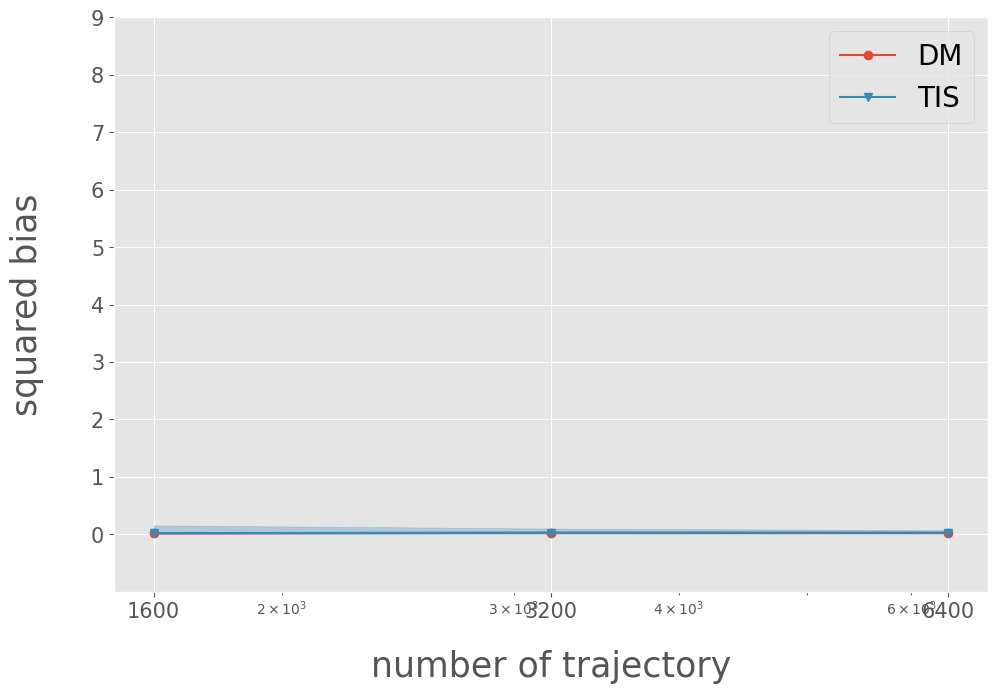

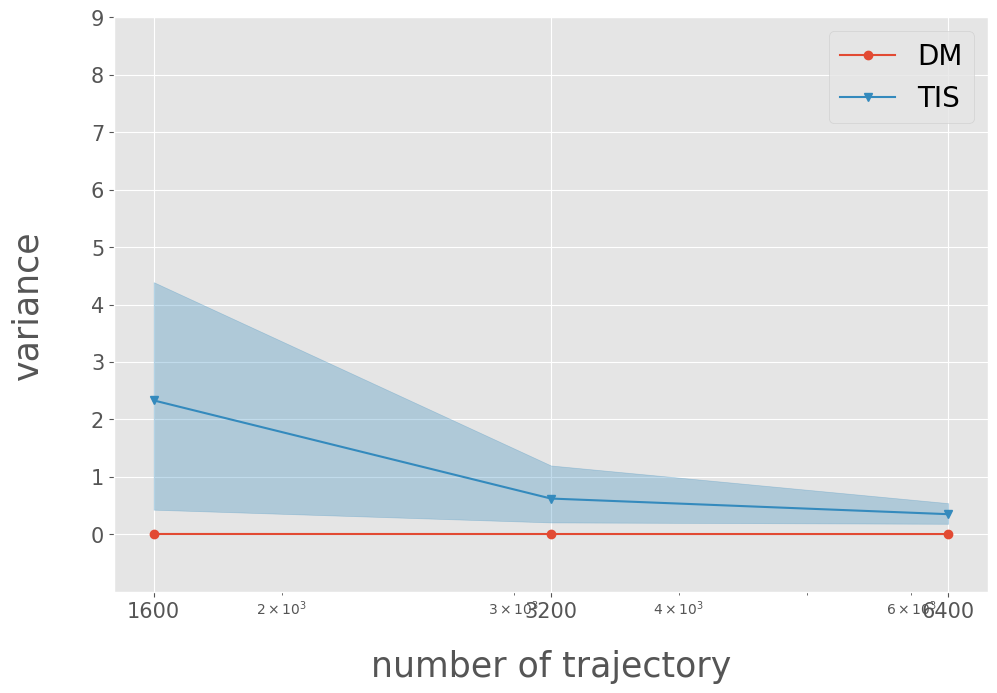

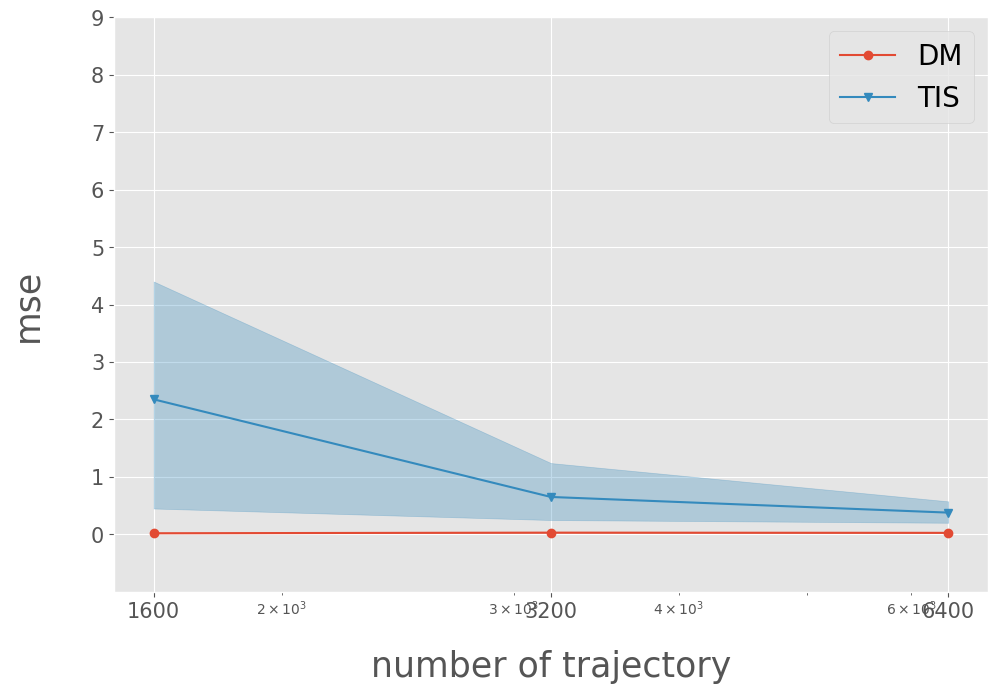

In [13]:
visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    ESTIMATORS=ESTIMATORS,
    estimators=estimators,
    x_scales=x_scales,
    log_dir=f"../tutorial/{tmp_log_dir}",
    x_label=x_label,
    # yscale_log=True,
    xscale_log=True,
)